#### First import necessary packages

In [1]:
import numpy as np
from modelbase.ode import Model, Simulator
import matplotlib.pyplot as plt
from matplotlib import patches
    
import time

Could not find GLIMDA.


## Create the model

In [2]:
variables = [
        #"B",  #photosystem II protein concentration
        "PQ",  # oxidised plastoquinone
        "PC",  # oxidised plastocyan
        "Fd",  # oxidised ferrodoxin
        "ATP",  # stromal concentration of ATP
        "NADPH",  # stromal concentration of NADPH
        "H",  # lumenal protons
        "LHC",#,  # non-phosphorylated antenna
        "Psbs", # PsBs
        "Vx",  #vioolaxathin relative concentration
        "PGA", 
        'BPGA', 
        'GAP', 
        'DHAP', 
        'FBP', 
        'F6P', 
        'G6P', 
        'G1P', 
        'SBP', 
        'S7P', 
        'E4P', 
        'X5P', 
        'R5P', 
        'RUBP', 
        'RU5P'
]

In [3]:
p = {"convf":3.2*10e-3, #converts ATP and NADPH
    "PSIItot": 2.5, # [mmol/molChl] total concentration of PSII
    "PSItot": 2.5,
    "PQtot": 17.5, # [mmol/molChl]
    "PCtot": 4., # Bohme1987 but other sources give different values - seems to depend greatly on organism and conditions
    "Fdtot": 5., # Bohme1987
    "Ctot": 2.5, #source unclear (Schoettler says 0.4...?, but plausible to assume that complexes (PSII,PSI,b6f) have approx. same abundance)
    "NADPtot": 0.8, # estimate from ~ 0.8 mM, Heineke1991
    "APtot": 2.55, # [mmol/molChl] Bionumbers ~2.55mM (=81mmol/molChl) (FIXME: Soma had 50)
    "Psbstot": 1., # relative pool of PsbS
    "Xtot": 1., # relative pool of carotenoids (V+A+Z)
    #Mara "ATPasetot": 1., # relative pool of ATPase

    # parameters associated with photosystem II
    "kH": 5e9,
    "kH0": 5e8, # base quenching" after calculation with Giovanni
    "kF": 6.25e8, # 6.25e7 fluorescence 16ns
    "k1": 5e9, # excitation of Pheo / charge separation 200ps
    "k1rev": 1e10,
    "k2": 5e9,#Mara was 5e10 # original 5e9 (charge separation limiting step ~ 200ps) - made this faster for higher Fs fluorescence
    "kdeg": 100,    # rate of PSII damage corresponds to p.k2 / .5e8
    "krep": 5.55e-4, # rate of repair fo PSII

    # parameters associated with photosystem I
    "kStt7": 0.0035, # [s-1] fitted to the FM dynamics
    "kPph1": 0.0013, # [s-1] fitted to the FM dynamics
    "KM_ST": 0.2, # Switch point (half-activity of Stt7) for 20% PQ oxidised (80% reduced)
    "n_ST": 2., # Hill coefficient of 4 -> 1/(2.5^4)~1/40 activity at PQox=PQred
    "staticAntI": 0.37,     # corresponds to PSI - LHCI supercomplex, when chlorophyll decreases more relative fixed antennae
    "staticAntII": 0.1,     # corresponds to PSII core
    "prob_attach": 1.,            # probability of antena attaching to PSI


     # ATP and NADPH parameters
    "kActATPase": 0.05,  # on 14.09 increased from 0.01 to saturate between 1-2 min, not 10
                            # paramter relating the rate constant of activation of the ATPase in the light
    "kDeactATPase": 0.002,   # paramter relating the deactivation of the ATPase at night
    "kATPsynth": 20.,    # taken from MATLAB
    "kATPcons": 10.,     # taken from MATLAB
    "ATPcyt": 0.5,       # only relative levels are relevant (normalised to 1) to set equilibrium
    "Pi_mol": 0.01,
    "DeltaG0_ATP": 30.6, # 30.6kJ/mol / RT
    "HPR": 14./3.,  #Vollmar et al. 2009 (after Zhu et al. 2013)
    "kNADPHcons": 15., # taken from MATLAB
    "NADPHcyt": 0.5, # only relatice levels

    # global conversion factor of PFD to excitation rate
    #"cPFD": 4. # [m^2/mmol PSII]

    # pH and protons
    "pHstroma": 7.8,
    "kLeak": 10.,#0.010, # [1/s] leakage rate -- inconsistency with Kathrine
    "bH": 100., # proton buffer: ratio total / free protons

    # rate constants
    "kPQred": 250., # [1/(s*(mmol/molChl))]
    "kCytb6f": 2.5, # a rough estimate: transfer PQ->cytf should be ~10ms
    "kPTOX": .01, # ~ 5 electrons / seconds. This gives a bit more (~20)
    "kPCox": 2500., # a rough estimate: half life of PC->P700 should be ~0.2ms
    "kFdred": 2.5e5, # a rough estimate: half life of PC->P700 should be ~2micro-s
    "kcatFNR": 500., # Carrillo2003 (kcat~500 1/s)
    "kcyc": 1.,

    "O2ext": 8., # corresponds to 250 microM cor to 20%
    "kNDH": .002, # re-introduce e- into PQ pool. Only positive for anaerobic (reducing) condition
    "kNh": 0.05,
    "kNr": 0.004,
    "NPQsw": 5.8,
    "nH": 5.,

    "EFNR": 3., # Bohme1987
    "KM_FNR_F": 1.56, # corresponds to 0.05 mM (Aliverti1990)
    "KM_FNR_N": 0.22, # corresponds to 0.007 mM (Shin1971 Aliverti2004)

    # quencher fitted parameters
    "gamma0": 0.1,          # slow quenching of Vx present despite lack of protonation
    "gamma1": 0.25,         # fast quenching present due to the protonation
    "gamma2": 0.6,          # slow quenching of Zx present despite lack of protonation
    "gamma3": 0.15,         # fastest possible quenching

    # non-photochemical quenching PROTONATION
    "kDeprotonation": 0.0096,
    "kProtonationL": 0.0096,
    "kphSatLHC": 5.8,
    "nH": 5.,
    "NPQsw": 5.8,

    # non-photochemical quenching XANTOPHYLLS
    "kDeepoxV": 0.0024,
    "kEpoxZ": 0.00024,      # 6.e-4        # converted to [1/s]
    "kphSat": 5.8,          # [-] half-saturation pH value for activity de-epoxidase highest activity at ~pH 5.8
    "kHillX": 5.,     # [-] hill-coefficient for activity of de-epoxidase
    "kHillL": 3.,     # [-] hill-coefficient for activity of de-epoxidase
    "kZSat": 0.12,          # [-] half-saturation constant (relative conc. of Z) for quenching of Z

    # standard redox potentials (at pH=0) in V
    "E0_QA": -0.140,
    "E0_PQ": 0.354,
    "E0_cytf": 0.350,
    "E0_PC": 0.380,
    "E0_P700": 0.480,
    "E0_FA": -0.550,
    "E0_Fd": -0.430,
    "E0_NADP": -0.113,

    # physical constants
    "F": 96.485, # Faraday constant
    "R": 8.3e-3, # universal gas constant
    "T": 298., # Temperature in K - for now assumed to be constant at 25 C

    # light
    "pfd": 100.,
    "Ton": 0.,
    "Toff": 1800,
    "dT": 120,

    "ox": True, # 1. means True, switched on
     
    # CBB cycle associated parameter set according to Pettersson and Pettersson 1988
    'CN': 0.5,
    'CO2': 0.2,
    'Cp': 15+2.05,#15.0
    'Ca': 0.5,
    'pHmedium': 7.6,
    'pHstroma': 7.9,
    'Pext': 0.5,

    #Vmaxes of Calvin cycle enzymes
    'V1': 0.34*8,
    'V6': 0.2*8,
    'V9': 0.04*8,
    'V13': 0.9999*8,
    'Vst': 0.04*8,
    'Vx': 0.25*8,

    #equilibrium constants of calvin cycle enzymes
    'q2': 3.1 * (10.0 ** (-4.0)),
    'q3': 1.6 * (10.0**7.0),
    'q4': 22.0,
    'q5': (7.1),
    'q7': 0.084,
    'q8': (13.0),
    'q10': 0.85,
    'q11': 0.4,
    'q12': 0.67,
    'q14': 2.3,
    'q15': 0.058,

    #michaelis constants of calvin cycle enzymes
    'Km1': 0.02,
    'KmCO2': 0.0107, #millimol laut witzel
    'Km6': 0.03,
    'Km9': 0.013,
    'Km131': 0.05,
    'Km132': 0.05,
    'Km161': 0.014,
    'Km162': 0.3,
    'Kmst1': 0.08,
    'Kmst2': 0.08,
    'Kmnadph': 0.19,#ausgerechneter wert (ideal wert)
    'Kpga': 0.25,
    'Kgap': 0.075,
    'Kdhap': 0.077,
    'Kpi': 0.63,
    'Kpxt': 0.74,
    'Ki11': 0.04,
    'Ki12': 0.04,
    'Ki13': 0.075,
    'Ki14': 0.9,
    'Ki15': 0.07,
    'Ki61': 0.7,
    'Ki62': 12.0,
    'Ki9': 12.0,
    'Ki131': 2.0,
    'Ki132': 0.7,
    'Ki133': 4.0,
    'Ki134': 2.5,
    'Ki135': 0.4,
    'Kist': 10.0,
    'Kast1': 0.1,
    'Kast2': 0.02,
    'Kast3': 0.02,

    'k': 10.0**8.0*8,
    'oxPPP': 0.,
    'k19' : 0. #rate constant for G6P-Shunt
    }


In [4]:
p1 = list(p)
print(p1)

['convf', 'PSIItot', 'PSItot', 'PQtot', 'PCtot', 'Fdtot', 'Ctot', 'NADPtot', 'APtot', 'Psbstot', 'Xtot', 'kH', 'kH0', 'kF', 'k1', 'k1rev', 'k2', 'kdeg', 'krep', 'kStt7', 'kPph1', 'KM_ST', 'n_ST', 'staticAntI', 'staticAntII', 'prob_attach', 'kActATPase', 'kDeactATPase', 'kATPsynth', 'kATPcons', 'ATPcyt', 'Pi_mol', 'DeltaG0_ATP', 'HPR', 'kNADPHcons', 'NADPHcyt', 'pHstroma', 'kLeak', 'bH', 'kPQred', 'kCytb6f', 'kPTOX', 'kPCox', 'kFdred', 'kcatFNR', 'kcyc', 'O2ext', 'kNDH', 'kNh', 'kNr', 'NPQsw', 'nH', 'EFNR', 'KM_FNR_F', 'KM_FNR_N', 'gamma0', 'gamma1', 'gamma2', 'gamma3', 'kDeprotonation', 'kProtonationL', 'kphSatLHC', 'kDeepoxV', 'kEpoxZ', 'kphSat', 'kHillX', 'kHillL', 'kZSat', 'E0_QA', 'E0_PQ', 'E0_cytf', 'E0_PC', 'E0_P700', 'E0_FA', 'E0_Fd', 'E0_NADP', 'F', 'R', 'T', 'pfd', 'Ton', 'Toff', 'dT', 'ox', 'CN', 'CO2', 'Cp', 'Ca', 'pHmedium', 'Pext', 'V1', 'V6', 'V9', 'V13', 'Vst', 'Vx', 'q2', 'q3', 'q4', 'q5', 'q7', 'q8', 'q10', 'q11', 'q12', 'q14', 'q15', 'Km1', 'KmCO2', 'Km6', 'Km9', 'Km1

## Here we define the model object

In [5]:
# modelbase 1.0
m = Model(parameters=p, compounds=variables)

In [6]:
#check the state variables
m.get_compounds()

['PQ',
 'PC',
 'Fd',
 'ATP',
 'NADPH',
 'H',
 'LHC',
 'Psbs',
 'Vx',
 'PGA',
 'BPGA',
 'GAP',
 'DHAP',
 'FBP',
 'F6P',
 'G6P',
 'G1P',
 'SBP',
 'S7P',
 'E4P',
 'X5P',
 'R5P',
 'RUBP',
 'RU5P']

In [7]:
# ====================================================================== #
# Composed parameters #
m.add_derived_parameter(
    parameter_name="RT", function=lambda r, t: r * t, parameters=["R", "T"]
)

m.add_derived_parameter(
    parameter_name="dG_pH", function=lambda r, t: np.log(10) * r * t, parameters=["R", "T"]
)

m.add_derived_parameter(
    parameter_name="Hstroma", function=lambda pHstroma: 3.2e4*10**(-pHstroma), parameters=["pHstroma"]
)

m.add_derived_parameter(
    parameter_name="kProtonation", function=lambda Hstroma: 4e-3 / Hstroma, parameters=["Hstroma"]
)

# FIX ME: we used two different definitions for H_stroma (!). This one is Nima's
m.add_derived_parameter(
    parameter_name="H_stroma", function=lambda pHstroma: (10.0**((-1.0)*pHstroma))*1000.0, parameters=["pHstroma"]
)

def keq_PQred(E0_QA, F, E0_PQ, pHstroma, dG_pH, RT):
    DG1 = -E0_QA * F
    DG2 = -2 * E0_PQ * F
    DG = -2 * DG1 + DG2 + 2 * pHstroma * dG_pH
    K = np.exp(-DG/RT)
    return K

m.add_derived_parameter(
    parameter_name="Keq_PQred", function=keq_PQred, parameters=["E0_QA", "F", "E0_PQ", "pHstroma", "dG_pH", "RT"]
)

def Keq_cyc(E0_Fd, F, E0_PQ, pHstroma, dG_pH, RT):
    DG1 = -E0_Fd * F
    DG2 = -2 * E0_PQ * F
    DG = -2 * DG1 + DG2 + 2 * dG_pH * pHstroma
    K = np.exp(-DG/RT)
    return K

m.add_derived_parameter(
    parameter_name="Keq_cyc", function=Keq_cyc, parameters=["E0_Fd", "F", "E0_PQ", "pHstroma", "dG_pH", "RT"]
)              

def Keq_FAFd(E0_FA, F, E0_Fd, RT):
    DG1 = -E0_FA * F
    DG2 = -E0_Fd * F
    DG = -DG1 + DG2
    K = np.exp(-DG/RT)
    return K
               
m.add_derived_parameter(
    parameter_name="Keq_FAFd", function=Keq_FAFd, parameters=["E0_FA", "F", "E0_Fd", "RT"]
)               

def Keq_PCP700(E0_PC, F, E0_P700, RT):
    DG1 = -E0_PC * F
    DG2 = -E0_P700 * F
    DG = -DG1 + DG2
    K = np.exp(-DG/RT)
    return K

m.add_derived_parameter(
    parameter_name="Keq_PCP700", function=Keq_PCP700, parameters=["E0_PC", "F", "E0_P700", "RT"]
)               

def Keq_FNR(E0_Fd, F, E0_NADP, pHstroma, dG_pH, RT):
    DG1 = -E0_Fd * F
    DG2 = -2 * E0_NADP * F
    DG = -2 * DG1 + DG2 + dG_pH * pHstroma
    K = np.exp(-DG/RT)
    return K

m.add_derived_parameter(
    parameter_name="Keq_FNR", function=Keq_FNR, parameters=["E0_Fd", "F", "E0_NADP", "pHstroma", "dG_pH", "RT"]
) 

def Keq_ATP(pH, DeltaG0_ATP, dG_pH, HPR, pHstroma, Pi_mol, RT):
    DG = DeltaG0_ATP - dG_pH * HPR * (pHstroma - pH)
    Keq = Pi_mol * np.exp(-DG/RT)
    return Keq

def Keq_cytb6f(pH, F, E0_PQ, E0_PC, pHstroma, RT, dG_pH):
    DG1 = -2 * F * E0_PQ
    DG2 = -F * E0_PC
    DG = - (DG1 + 2*dG_pH * pH) + 2 * DG2 + 2*dG_pH * (pHstroma - pH)
    Keq = np.exp(-DG/RT)
    return Keq


In [8]:
def calculate_pHstroma(x):
    return (-np.log(x*(3.2e-5))/np.log(10))    

def calculate_pHinv(x):
    return (4e3*10**(-x))

def light(pfd):
    '''
    :return: light intensity at certain point of time. 
    Typical PAM light function
    '''
    return pfd

In [9]:
def pqmoiety(PQ, pqtot):
    return pqtot - PQ

m.add_algebraic_module(
    module_name="pq_alm",
    function=pqmoiety,
    compounds=["PQ"],
    derived_compounds=["PQred"],
    modifiers=None,
    parameters=["PQtot"],
)

def pcmoiety(PC, pctot):
    return pctot - PC

m.add_algebraic_module(
    module_name="pc_alm",
    function=pcmoiety,
    compounds=["PC"],
    derived_compounds=["PCred"],
    parameters=["PCtot"],
)

def fdmoiety(Fd, fdtot):
    return fdtot - Fd

m.add_algebraic_module(
    module_name="fd_alm",
    function=fdmoiety,
    compounds=["Fd"],
    derived_compounds=["Fdred"],
    parameters=["Fdtot"],
)

def adpmoiety(ATP, atptot):
    return atptot - ATP

m.add_algebraic_module(
    module_name="adp_alm",
    function=adpmoiety,
    compounds=["ATP"],
    derived_compounds=["ADP"],
    parameters=["APtot"],
)

def nadpmoiety(NADPH, nadptot):
    return nadptot - NADPH

m.add_algebraic_module(
    module_name="nadp_alm",
    function=nadpmoiety,
    compounds=["NADPH"],
    derived_compounds=["NADP"],
    modifiers=None,
    parameters=["NADPtot"],
)

def lhcmoiety(LHC):
    return 1 - LHC

m.add_algebraic_module(
    module_name="lhc_alm",
    function=lhcmoiety,
    compounds=["LHC"],
    derived_compounds=["LHCp"]
)

def xmoiety(Vx, Xtot):
    return Xtot - Vx

m.add_algebraic_module(
    module_name="xantophylls_alm",
    function=xmoiety,
    compounds=["Vx"],
    derived_compounds=["Zx"],
    parameters=['Xtot']
)

def psbsmoiety(Psbs, Psbstot):
    return Psbstot - Psbs

m.add_algebraic_module(
    module_name="psbs_alm",
    function=psbsmoiety,
    compounds=["Psbs"],
    derived_compounds=["Psbsp"],
    parameters=['Psbstot']
)

def ps2crosssection(LHC, staticAntII, staticAntI):
    """ calculates the cross section of PSII """
    cs = staticAntII + (1 - staticAntII - staticAntI) * LHC
    return cs

m.add_algebraic_module(
    module_name="ps2crosssection",
    function=ps2crosssection,
    compounds=["LHC"],
    derived_compounds=["ps2cs"],
    modifiers=None,
    parameters=["staticAntII", "staticAntI"],
)

def quencher(Psbs, Vx, Psbsp, Zx, y0, y1, y2, y3, kZSat):
    """ 
    co-operatiove 4-state quenching mechanism
    
    Comment:
        seems like this can't reach 1, so I've checked the max value and normalized it
        for i in np.linspace(0,1,100):
            for j in np.linspace(0,1,100):
                a = np.hstack((a, vQuencher4states(p, i, j)))
        max(a)
    """
    ZAnt = Zx / (Zx + kZSat)
    Q = (y0 * Vx * Psbs + y1 * Vx * Psbsp + y2 * ZAnt * Psbsp + y3 * ZAnt * Psbs)#/0.5625
    #Q = (y0 * (1-ZAnt) * Psbs + y1 * (1-ZAnt) * Psbsp + y2 * ZAnt * Psbsp + y3 * ZAnt * Psbs)#/0.5625
    return Q

m.add_algebraic_module(
    module_name="quencher",
    function=quencher,
    compounds=["Psbs", "Vx", "Psbsp", "Zx"],
    derived_compounds=["Q"],
    modifiers=None,
    parameters=["gamma0", "gamma1", "gamma2", "gamma3", "kZSat"],
)
    

def ps2states(PQ, PQred, ps2cs, Q, PSIItot, k2, kF, _kH, Keq_PQred, kPQred, pfd, kH0):
    L = ps2cs * light(pfd)
    kH = kH0 + _kH * Q
    k3p = kPQred * PQ
    k3m = kPQred * PQred / Keq_PQred
   
    Bs = []

    
    if isinstance(kH, float) and isinstance(PQ, np.ndarray):
        kH = np.repeat(kH, len(PQ))
      
    
    for L, kH, k3p, k3m in zip(L, kH, k3p, k3m):
        M = np.array(
            [
                [-L - k3m, kH + kF, k3p, 0],
                [L, -(kH + kF + k2), 0, 0],
                [0, 0, L, -(kH + kF)],
                [1, 1, 1, 1],
            ]
        )
        A = np.array([0, 0, 0, PSIItot])
        B0, B1, B2, B3 = np.linalg.solve(M, A)
        Bs.append([B0, B1, B2, B3])
    return np.array(Bs).T


m.add_algebraic_module(
    module_name="ps2states",
    function=ps2states,
    compounds=["PQ", "PQred", "ps2cs", "Q"],
    derived_compounds=["B0", "B1", "B2", "B3"],
    parameters=["PSIItot", "k2", "kF", "kH", "Keq_PQred", "kPQred", "pfd", "kH0"],
)

def ps1states(PC, PCred, Fd, Fdred, LHC, ps2cs, PSItot, kFdred, Keq_FAFd, Keq_PCP700, kPCox, pfd):
    """ 
    QSSA calculates open state of PSI
    depends on reduction states of plastocyanin and ferredoxin
    C = [PC], F = [Fd] (ox. forms)
    accepts: light, y as an array of arrays
    returns: array of PSI open
    """
    L = (1-ps2cs) * light(pfd)

    A1 = PSItot / (1 + L/(kFdred * Fd) + (1 + Fdred/(Keq_FAFd * Fd))
                      * (PC/(Keq_PCP700 * PCred)
                         + L/(kPCox * PCred))
    )
    return A1

m.add_algebraic_module(
    module_name="ps1states",
    function=ps1states,
    compounds=["PC", "PCred", "Fd", "Fdred", "LHC", "ps2cs"],
    derived_compounds=["A1"],
    parameters=["PSItot", "kFdred", "Keq_FAFd", "Keq_PCP700", "kPCox", "pfd"],
)

def fluorescence(Q, B0, B2, ps2cs, k2, kF, kH, kH0):
    fluo = (ps2cs * kF * B0) / (kF + k2 + kH*Q) + (ps2cs * kF * B2) / (kF + kH*Q)
    return fluo

m.add_algebraic_module(
    module_name="fluorescence",
    function=fluorescence,
    compounds=["Q", "B0", "B2", "ps2cs"],
    derived_compounds=["Fluo"],
    modifiers=None,
    parameters=["k2","kF", "kH", "kH0"]
)

def calculate_pH(x):
    return (-np.log(x*(2.5e-4))/np.log(10))

m.add_algebraic_module(
    module_name="calculate_pH",
    function=calculate_pH,
    compounds=["H"],
    derived_compounds=["pH"],
    modifiers=None
)

def Pimoiety(PGA,BPGA,GAP,DHAP,FBP,F6P,G6P,G1P,SBP,S7P,E4P,X5P,R5P,RUBP,RU5P,ATP, Cp):
    return Cp - (PGA + 2*BPGA + GAP + DHAP + 2*FBP + F6P + G6P + G1P + 2*SBP + S7P + E4P + X5P + R5P + 2*RUBP + RU5P + ATP)

m.add_algebraic_module(
    module_name="pi_alm",
    function=Pimoiety,
    compounds=["PGA","BPGA","GAP","DHAP","FBP","F6P","G6P","G1P","SBP","S7P","E4P","X5P","R5P","RUBP","RU5P","ATP"],
    derived_compounds=["Pi"],
    parameters=["Cp"],
    modifiers=None
)

def Nmoiety(Pi, PGA, GAP, DHAP, Kpxt, Pext, Kpi, Kpga, Kgap, Kdhap):
    """Used several times to calculate the rate of vPGA, vGAP and vDHAP"""
    return 1+(1+(Kpxt/Pext))*((Pi/Kpi)
               +(PGA/Kpga)
               +(GAP/Kgap)
               +(DHAP/Kdhap))

m.add_algebraic_module(
    module_name="n_alm",
    function=Nmoiety,
    compounds=["Pi","PGA","GAP","DHAP"],
    derived_compounds=["N"],
    parameters=["Kpxt", "Pext", "Kpi", "Kpga", "Kgap", "Kdhap"],
    modifiers=None
)

I found it critical to introduce each occupation state of PSII as a new variable, and hence algebraic mode

In [10]:
# Rate of electron flow through the photosystems.
# Calling algebraic modules calculating excited states of each photosystem
def vPS2(B1, k2):
    """ reaction rate constant for photochemistry """
    v = 0.5 * k2 * B1
    return v

m.add_reaction(
    rate_name='vPS2',
    function=vPS2,
    stoichiometry= {"PQ":-1, "H": 2/m.get_parameter("bH")},
    dynamic_variables=["B1"],
    parameters=["k2"],
    reversible=True,
)

def vPS1(A, ps2cs, pfd):
    """ reaction rate constant for open PSI """
    L = (1-ps2cs) * light(pfd)
    v = L * A
    return v

m.add_reaction(
    rate_name='vPS1',
    function=vPS1,
    stoichiometry={"Fd": -1, "PC": 1},
    dynamic_variables=["A1", "ps2cs"],
    parameters=["pfd"],
    reversible=True,
)



In [11]:
###############################################################################
# Reaction rates
###############################################################################
def _oxygen(time, ox, O2ext, kNDH, Ton, Toff):
    """ return oxygen and NDH concentration as a function of time
    used to simulate anoxia conditions as in the paper"""
    if ox == True:
        ''' by default we assume constant oxygen supply'''
        return O2ext, kNDH
    else:
        if time<Ton or time>Toff:
            return O2ext, 0
        else:
            return 0, kNDH

##############################################################################
def oxygen(time, ox, O2ext, kNDH, Ton, Toff):
    """ return oxygen and NDH concentration as a function of time
    used to simulate anoxia conditions as in the paper"""
    if isinstance(time, (int, float)):
        return np.array(_oxygen(time, ox, O2ext, kNDH, Ton, Toff))
    else:
        return np.array(
            [
                _oxygen(t, ox, O2ext, kNDH, Ton, Toff)
                for t in time
            ]
        ).T     
        
def vPTOX(Pred, time, kPTOX, ox, O2ext, kNDH, Ton, Toff):
    """ calculates reaction rate of PTOX """
    v = Pred * kPTOX * oxygen(time, ox, O2ext, kNDH, Ton, Toff)[0] 
    return v

m.add_reaction(
    rate_name='vPTOX',
    function=vPTOX,
    stoichiometry= {"PQ": 1},
    modifiers=["PQred", "time"],
    parameters=["kPTOX", "ox", "O2ext", "kNDH", "Ton", "Toff"],
    reversible=False,
)


def vNDH(Pox, time, ox, O2ext, kNDH, Ton, Toff):
    """ 
    calculates reaction rate of PQ reduction under absence of oxygen
    can be mediated by NADH reductase NDH
    """
    v = oxygen(time, ox, O2ext, kNDH, Ton, Toff)[1] * Pox
    return v



m.add_reaction(
    rate_name='vNDH',
    function=vNDH,
    stoichiometry=  {"PQ":-1},
    modifiers=["time"],
    parameters=["ox", "O2ext", "kNDH", "Ton", "Toff"],
    reversible=False,
)


def vB6f(PC, Pox, H, Pred, PCred, pH, kCytb6f, F, E0_PQ, E0_PC, pHstroma, RT, dG_pH):
    """ calculates reaction rate of cytb6f """
    Keq = Keq_cytb6f(pH, F, E0_PQ, E0_PC, pHstroma, RT, dG_pH)
    v = np.maximum(kCytb6f * (Pred * PC**2 - (Pox * PCred**2)/Keq), -kCytb6f)
    return v

m.add_reaction(
    rate_name='vB6f',
    function=vB6f,
    stoichiometry={"PC": -2, "PQ": 1, "H": 4/100},
    modifiers=["PQred", "PCred", "pH"],
    parameters=["kCytb6f", "F", "E0_PQ", "E0_PC", "pHstroma", "RT", "dG_pH"],
    reversible=True,
)

def vCyc(Pox, Fdred, kcyc):
    """
    calculates reaction rate of cyclic electron flow
    considered as practically irreversible
    """
    v = kcyc * ((Fdred**2) * Pox)
    return v

m.add_reaction(
    rate_name='vCyc',
    function=vCyc,
    stoichiometry=  {"PQ": -1, "Fd": 2},
    dynamic_variables=["PQ","Fdred"],
    parameters=["kcyc"],
    reversible=True,
)

def vFNR(Fd, Fdred, NADPH, NADP, KM_FNR_F, KM_FNR_N, EFNR, kcatFNR, Keq_FNR, convf):
    """
    Reaction rate mediated by the Ferredoxin—NADP(+) reductase (FNR)
    Kinetic: convenience kinetics Liebermeister and Klipp, 2006
    Compartment: lumenal side of the thylakoid membrane
    Units:
    Reaction rate: mmol/mol Chl/s
    [F], [Fdred] in mmol/mol Chl/s
    [NADPH] in mM
    """
    fdred = Fdred/KM_FNR_F
    fdox = Fd/KM_FNR_F
    nadph = (NADPH/convf)/KM_FNR_N  # NADPH requires conversion to mmol/mol of chlorophyll 
    nadp = (NADP/convf)/KM_FNR_N # NADP requires conversion to mmol/mol of chlorophyll 
    v = (EFNR * kcatFNR *
        ((fdred**2) * nadp - ((fdox**2) * nadph) / Keq_FNR) /
        ((1+fdred+fdred**2) * (1+nadp) + (1+fdox+fdox**2) * (1+nadph) - 1))
    return v

m.add_reaction(
    rate_name='vFNR',
    function=vFNR,
    stoichiometry=  {"Fd": 2, "NADPH": 1*m.get_parameter('convf')},
    dynamic_variables=["Fd", "Fdred", "NADPH", "NADP"],
    parameters=["KM_FNR_F", "KM_FNR_N", "EFNR", "kcatFNR", "Keq_FNR", "convf"],
    reversible=False,
)
         

def vLeak(H, kLeak, pHstroma):
    """ 
    rate of leak of protons through the membrane
    """
    v = kLeak * (H - calculate_pHinv(pHstroma))
    return v


m.add_reaction(
    rate_name='vLeak',
    function=vLeak,
    stoichiometry= {"H": -1/m.get_parameter("bH")},
    modifiers=None,
    parameters=["kLeak", "pHstroma"],
    reversible=False,
)

def vSt12(Ant, Pox, kStt7, PQtot, KM_ST, n_ST):
    """ 
    reaction rate of state transitions from PSII to PSI
    Ant depending on module used corresponds to non-phosphorylated antennae
    or antennae associated with PSII
    """
    kKin = kStt7 * ( 1 / (1 + ((Pox /PQtot)/KM_ST)**n_ST))
    v = kKin * Ant
    return v

m.add_reaction(
    rate_name='vSt12',
    function=vSt12,
    stoichiometry= {"LHC": -1},
    modifiers=["PQ"],
    parameters=["kStt7", "PQtot", "KM_ST", "n_ST"],
    reversible=False,
)

def vSt21(LHCp, kPph1):
    """
    reaction rate of state transitions from PSI to PSII
    """
    v = kPph1 * LHCp
    return v

m.add_reaction(
    rate_name='vSt21',
    function=vSt21,
    stoichiometry= {"LHC": 1},
    dynamic_variables=["LHCp"],
    parameters=["kPph1"],
    reversible=False,
)

def vATPsynthase(ATP, ADP, pH, kATPsynth, DeltaG0_ATP, dG_pH, HPR, pHstroma,Pi_mol, RT, convf):
    """
    Reaction rate of ATP production
    Kinetic: simple mass action with PH dependant equilibrium
    Compartment: lumenal side of the thylakoid membrane
    Units:
    Reaction rate: mmol/mol Chl/s
    [ATP], [ADP] in mM
    """    
    v = kATPsynth * (ADP/convf - ATP/convf / Keq_ATP(pH, DeltaG0_ATP, dG_pH, HPR, pHstroma, Pi_mol, RT)) #* E
    return v

m.add_reaction(
    rate_name='vATPsynthase',
    function=vATPsynthase,
    stoichiometry= {"ATP": 1*m.get_parameter('convf'), "H": -m.get_parameter('HPR')/m.get_parameter('bH')},
    dynamic_variables=["ATP","ADP","pH"],
    parameters=["kATPsynth","DeltaG0_ATP","dG_pH","HPR","pHstroma","Pi_mol","RT","convf"],
    reversible=True,
)


def vDeepox(Vx, H, nH, kDeepoxV, kphSat):
    """
    activity of xantophyll cycle: de-epoxidation of violaxanthin, modelled by Hill kinetics
    """
    vf = kDeepoxV * ((H ** nH)/ (H ** nH + calculate_pHinv(kphSat) ** nH)) * Vx
    return vf

m.add_reaction(
    rate_name='vDeepox',
    function=vDeepox,
    stoichiometry= {"Vx": -1},
    modifiers=["H"],
    parameters=["kHillX", "kDeepoxV", "kphSat"],
    reversible=False,
)

def vEpox(Zx, kEpoxZ):
    """
    activity of xantophyll cycle: epoxidation
    """
    vr = kEpoxZ * Zx
    return vr

m.add_reaction(
    rate_name='vEpox',
    function=vEpox,
    stoichiometry= {"Vx": 1},
    dynamic_variables=["Zx"],
    parameters=["kEpoxZ"],
    reversible=True,
)

def vLhcprotonation(Psbs, H, nH, kProtonationL, kphSatLHC):
    """
    activity of PsbS protein protonation: protonation modelled by Hill kinetics
    """
    vf = kProtonationL * ((H ** nH)/ (H ** nH + calculate_pHinv(kphSatLHC) ** nH)) * Psbs
    return vf

m.add_reaction(
    rate_name='vLhcprotonation',
    function=vLhcprotonation,
    stoichiometry= {"Psbs": -1},
    modifiers=["H"],
    parameters=["kHillL", "kProtonationL", "kphSatLHC"],
    reversible=False,
)

def vLhcdeprotonation(Psbsp, kDeprotonation):
    """
    activity of PsbS protein protonation: deprotonation
    """
    vr = kDeprotonation * Psbsp
    return vr

m.add_reaction(
    rate_name='vLhcdeprotonation',
    function=vLhcdeprotonation,
    stoichiometry= {"Psbs": 1},
    dynamic_variables=["Psbsp"],
    parameters=["kDeprotonation"],
    reversible=True,
)



In [12]:
###############################################################################
# Reaction rates
###############################################################################


 # rate constants
parameters =["kPQred", # [1/(s*(mmol/molChl))]
    "kCytb6f", # a rough estimate: transfer PQ->cytf should be ~10ms
    "kPTOX", # ~ 5 electrons / seconds. This gives a bit more (~20)
    "kPCox", # a rough estimate: half life of PC->P700 should be ~0.2ms
    "kFdred", # a rough estimate: half life of PC->P700 should be ~2micro-s
    "kcatFNR", # Carrillo2003 (kcat~500 1/s)
    "kcyc",

    "O2ext", # corresponds to 250 microM cor to 20%
    "kNDH", # re-introduce e- into PQ pool. Only positive for anaerobic (reducing) condition
    "kNh",
    "kNr",
    "NPQsw",
    "nH",

    "EFNR", # Bohme1987
    "KM_FNR_F", # corresponds to 0.05 mM (Aliverti1990)
    "KM_FNR_N", # corresponds to 0.007 mM (Shin1971 Aliverti2004)

    # quencher fitted parameters
    "gamma0",          # slow quenching of Vx present despite lack of protonation
    "gamma1",         # fast quenching present due to the protonation
    "gamma2",          # slow quenching of Zx present despite lack of protonation
    "gamma3",         # fastest possible quenching

    # non-photochemical quenching PROTONATION
    "kDeprotonation",
    "kProtonationL",
    "kphSatLHC",
    "nH",
    "NPQsw",

    # non-photochemical quenching XANTOPHYLLS
    "kDeepoxV",
    "kEpoxZ",      # 6.e-4        # converted to [1/s]
    "kphSat",          # [-] half-saturation pH value for activity de-epoxidase highest activity at ~pH 5.8
    "kHillX",     # [-] hill-coefficient for activity of de-epoxidase
    "kHillL",     # [-] hill-coefficient for activity of de-epoxidase
    "kZSat"]         # [-] half-saturation constant (relative conc. of Z) for quenching of Z


In [13]:
""" Calvin-Benson-Bassham Cycle Reaction Rates """
def v1(RUBP, PGA, FBP, SBP, P, NADPH, V1, CO2, Km1, Ki11, Ki12, Ki13, Ki14, Ki15, KmCO2):
    """ rate of RuBisCO
    3 Ribulose-1,5-bisphosphate + 3 CO2
    -- RuBisCO -->
    6 3-Phosphoglycerate
    RuBp + CO2 -> PGA
    """
    return (V1*RUBP*CO2)/((RUBP+Km1*(1+(PGA/Ki11)+(FBP/Ki12)+(SBP/Ki13)+(P/Ki14)+(NADPH/Ki15)))*(CO2+KmCO2))

m.add_reaction(
    rate_name='vRuBisCO',
    function=v1,
    stoichiometry= {"RUBP": -1, "PGA": 2},
    dynamic_variables=["RUBP", "PGA", "FBP", "SBP", "Pi", "NADPH"],
    parameters=["V1", "CO2", "Km1", "Ki11", "Ki12", "Ki13", "Ki14", "Ki15", "KmCO2"],
    reversible=True,
)

def v2(ATP, PGA, BPGA, ADP, k, q2):
    """
    6 3-Phosphoglycerate + 6 ATP
    -- Phosphoglycerate kinase (PGK) -->
    6 1,3-Bisphosphoglycerate + 6 ADP
    PGA + ATP -> BPGA + ADP
    Assumed to be at equilibrium
    """
    return k*((ATP*PGA)-(1/q2)*(ADP*BPGA))

m.add_reaction(
    rate_name='vPGA_kinase',
    function=v2,
    stoichiometry= {"ATP": -1, "PGA": -1, "BPGA": 1},
    modifiers=["ADP"],
    parameters=["k", "q2"],
    reversible=True,
)

def v3(BPGA, NADPH, GAP, NADP, P, k, H_stroma, q3):
    """
    6 1,3-Bisphosphoglycerate + 6 NADPH + 6 H+
    -- Glyceraldehyde 3-phosphate dehydrogenase (GADPH)-->
    1 G3P + 5 Glyceraldehyde 3-phosphate
    BPGA + NADPH -> GAP + NADP
    Assumed to be at equilibrium
    Stroma pH is assumed to be constant
    """

    return k*((NADPH*BPGA*H_stroma)-(1/q3)*(GAP*NADP*P))

m.add_reaction(
    rate_name='vBPGA_dehydrogenase',
    function=v3,
    stoichiometry= {"BPGA": -1, "NADPH": -1, "GAP": 1},
    dynamic_variables=["BPGA", "NADPH", "GAP", "NADP", "Pi"],
    parameters=["k", "H_stroma", "q3"],
    reversible=True,
)

def v4(GAP, DHAP, k, q4):
    """ 
    (5) Glyceraldehyde 3-phosphate
    -- Triose phosphate isomerae (TPI)-->
    (?) Dihydroxyacetone phosphate
    GAP -> DHAP
    Assumed to be at equilibrium
    """
    return k*((GAP)-(1/q4)*(DHAP))

m.add_reaction(
    rate_name='vTPI',
    function=v4,
    stoichiometry= {"GAP": -1, "DHAP": 1},
    parameters=["k", "q4"],
    reversible=True,
)

def v5(GAP, DHAP, FBP, k, q5):
    """
    (5) Glyceraldehyde 3-phosphate + (?) Dihydroxyacetone phosphate
    -- Aldolase (ALD)-->
    Frucose 1,6-bisphosphate
    GAP + DHAP -> FBP
    Assumed to be at equilibrium
    """
    return k*((GAP*DHAP)-(1/q5)*(FBP))

m.add_reaction(
    rate_name='vAldolase',
    function=v5,
    stoichiometry= {"GAP": -1, "DHAP": -1, "FBP": 1},
    parameters=["k", "q5"],
    reversible=True,
)

def v6(FBP, F6P, P, V6, Km6, Ki61, Ki62):
    """
    (?) Fructose 1,6-bisphosphate + (?) H20
    --Fructose 1,6-bisphosphatase (FBPase) -->
    (6) Fructose 6-phosphate + (Pi)
    FBP -> F6P
    """
    return (V6*FBP)/(FBP+Km6*(1+(F6P/Ki61)+(P/Ki62)))

m.add_reaction(
    rate_name='vFBPase',
    function=v6,
    stoichiometry= {"FBP": -1, "F6P": 1},
    modifiers= ["Pi"],
    parameters=["V6", "Km6", "Ki61", "Ki62"],
    reversible=True,
)

def v7(GAP, F6P, X5P, E4P, k, q7):
    """
    (?) Fructose 6-phosphate + (?) Glyceraldehyde 3-phosphate
    -- Transketolase (TK) -->
    (?) Xylulose 5-phosphate + (?) Erythrose 4-phosphate
    GAP + F6P -> X5P + E4P
    Assumed to be at equilibrium
    """
    return k*((GAP*F6P)-(1/q7)*(X5P*E4P))

m.add_reaction(
    rate_name='vF6P_Transketolase',
    function=v7,
    stoichiometry= {"GAP": -1, "F6P": -1, "X5P": 1, "E4P": 1},
    parameters=["k", "q7"],
    reversible=True,
)

def v8(DHAP, E4P, SBP, k, q8):
    """
    (?) Dihydroxyacetone phosphate + (?) Erythrose 4-phosphate
    -- Aldolase (ALD)-->
    (?) Sedoheptulose 1,7-bisphosphate
    DHAP + E4P -> SBP
    Assumed to be at equilibrium
    """
    return k*((DHAP*E4P)-(1/q8)*(SBP))

m.add_reaction(
    rate_name='v8',
    function=v8,
    stoichiometry= {"DHAP": -1, "E4P": -1, "SBP": 1},
    parameters=["k", "q8"],
    reversible=True,
)

def v9(SBP, Pi, V9, Km9, Ki9):
    """
    (?) Sedoheptulose 1,7-bisphosphate + H20
    --Sedoheptulose 1,7-bisphosphatase (SBPase)-->
    (?) Sedoheptulose 7-phosphate + (?) Pi
    SBP -> S7P
    """

    return (V9*SBP)/(SBP+Km9*(1+(Pi/Ki9)))

m.add_reaction(
    rate_name='v9',
    function=v9,
    stoichiometry= {"SBP": -1, "S7P": 1}, #CHECKME
    dynamic_variables=["SBP","Pi"],
    parameters=["V9", "Km9", "Ki9"],
    reversible=True,
)

def v10(GAP, S7P, X5P, R5P, k, q10):
    return k*((GAP*S7P)-(1/q10)*(X5P*R5P))

m.add_reaction(
    rate_name='v10',
    function=v10,
    stoichiometry= {"GAP": -1, "S7P": -1, "X5P": 1, "R5P": 1}, 
    parameters=["k", "q10"],
    reversible=True,
)

def v11(R5P, RU5P, k, q11):
    return k*((R5P)-(1/q11)*(RU5P))

m.add_reaction(
    rate_name='v11',
    function=v11,
    stoichiometry= {"R5P": -1, "RU5P": 1}, 
    parameters=["k", "q11"],
    reversible=True,
)

def v12(X5P, RU5P, k, q12):
    return k*((X5P)-(1/q12)*(RU5P))

m.add_reaction(
    rate_name='v12',
    function=v12,
    stoichiometry= {"X5P": -1, "RU5P": 1}, 
    parameters=["k", "q12"],
    reversible=True,
)

def v13(RU5P, ATP, RUBP, PGA, P, ADP, V13, Km131, Ki131, Ki132, Ki133, Ki134, Km132, Ki135):
    return (V13*RU5P*ATP)/((RU5P+Km131*(1+(PGA/Ki131)+(RUBP/Ki132)+(P/Ki133)))*(ATP*(1+(ADP/Ki134))+Km132*(1+(ADP/Ki135))))

m.add_reaction(
    rate_name='v13',
    function=v13,
    stoichiometry= {"RU5P": -1, "ATP": -1, "RUBP": 1}, 
    modifiers=["PGA", "Pi", "ADP"],
    parameters=["V13", "Km131", "Ki131", "Ki132", "Ki133", "Ki134", "Km132", "Ki135"],
    reversible=True,
)

def v14(F6P, G6P, k, q14):
    return k*((F6P)-(1/q14)*(G6P))

m.add_reaction(
    rate_name='vG6P_isomerase',
    function=v14,
    stoichiometry= {"F6P": -1, "G6P": 1}, 
    parameters=["k", "q14"],
    reversible=True,
)

def v15(G6P, G1P, k, q15):
    return k*((G6P)-(1/q15)*(G1P))

m.add_reaction(
    rate_name='vPhosphoglucomutase',
    function=v15,
    stoichiometry= {"G6P": -1, "G1P": 1}, 
    parameters=["k", "q15"],
    reversible=True,
)

def vpga(PGA, N, Vx, Kpga):
    return (Vx*PGA)/(N*Kpga)

m.add_reaction(
    rate_name='vpga',
    function=vpga,
    stoichiometry= {"PGA": -1}, 
    modifiers=["N"],
    parameters=["Vx", "Kpga"],
    reversible=True,
)

def vgap(GAP, N, Vx, Kgap):
    return (Vx*GAP)/(N*Kgap)

m.add_reaction(
    rate_name='vgap',
    function=vgap,
    stoichiometry= {"GAP": -1}, 
    modifiers=["N"],
    parameters=["Vx", "Kgap"],
    reversible=True,
)

def vdhap(DHAP, N, Vx, Kdhap):
    return (Vx*DHAP)/(N*Kdhap)

m.add_reaction(
    rate_name='vdhap',
    function=vdhap,
    stoichiometry= {"DHAP": -1},
    modifiers=["N"],
    parameters=["Vx", "Kdhap"],
    reversible=True,
)

def vStarch(G1P, ATP, ADP, P, PGA, F6P, FBP, Vst, Kmst1, Kist, Kmst2, Kast1, Kast2, Kast3):
    """G1P -> Gn-1 ; Starch production"""
    return (Vst*G1P*ATP)/((G1P+Kmst1)*((1+(ADP/Kist))*(ATP+Kmst2)+((Kmst2*P)/(Kast1*PGA+Kast2*F6P+Kast3*FBP))))

m.add_reaction(
    rate_name='vStarch',
    function=vStarch,
    stoichiometry= {"G1P": -1, "ATP": -1}, 
    modifiers= ["ADP", "Pi", "PGA", "F6P", "FBP"],
    parameters=["Vst", "Kmst1", "Kist", "Kmst2", "Kast1", "Kast2", "Kast3"],
    reversible=False,
)
#The OPP/G6P-Shunt/E13/G6P_Dehydrogenase:
def v19(G6P, NADP, k19):
  #  G6P + 2NADP -> Ru5P + 2NADPH + CO2 
    return (k19*G6P*(NADP**2))

m.add_reaction(
    rate_name='G6P_dehydrogenase',
    function=v19,
    stoichiometry= {"G6P":-1, "RU5P": 1, "NADPH": 2},
    modifiers=["NADP"],
    parameters=["k19"],
    reversible=False,
)

In [14]:
s = Simulator(m)

# Set initial conditions using dictionary
y0 = {
        "PQ":m.get_parameter('PQtot')/2,
        "PC":m.get_parameter('PCtot')/2,
        "Fd":m.get_parameter('Fdtot')/2,
        "ATP":0.12,
        "NADPH":0.281543418344,
        "H":calculate_pHinv(7.2),
        "LHC":0.9,
        "Psbs":0.9,
        "Vx":0.9,
        "PGA":2.15,
        'BPGA':0.000907499521924,
        'GAP':0.011839616887,
        'DHAP':0.260471552645,
        'FBP':0.11,
        'F6P':0.36,
        'G6P':0.46,
        'G1P':0.166166918189,
        'SBP':0.2,
        'S7P':0.56,
        'E4P':0.0330766864679,
        'X5P':0.0374527459593,
        'R5P':0.0627333486958,
        'RUBP':0.45,
        'RU5P':0.02,
}

In [15]:
klist= [0,0.1,1,2,5,10,20]
limly=0
limy=10
limlx=0
limx=1000
def rates_time_k(inrate):
    for i in klist:
        s.model.update_parameter('k19',i)
        s.initialise(y0)
        s.simulate(1000,steps=1000)
        rates=s.get_fluxes_dict()['%s'% inrate]
        plt.plot(s.get_time(),rates, label=i)
        plt.xlabel("time",fontsize=15) 
        plt.ylabel("rate of %s" %inrate,fontsize=15)
        plt.title("%s over time" % inrate,fontsize=20)
        plt.ylim(limly,limy)
        plt.xlim(limlx,limx)
        plt.legend(title="k", loc = "lower right")

    plt.grid()
    plt.show()

#  Figure 5: Rate of G6P Dehydrogenase over time

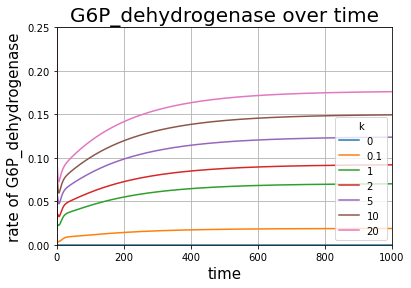

None


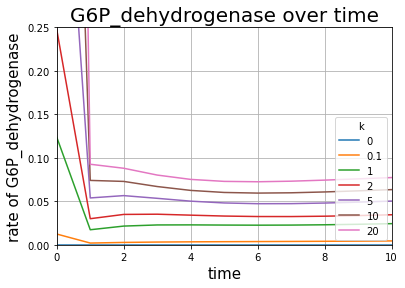

None


In [16]:
#(a) clear 
limy=0.25
print(rates_time_k('G6P_dehydrogenase'))

limx=10
print(rates_time_k('G6P_dehydrogenase'))


# Figure 6: Rate of RuBisCo over time

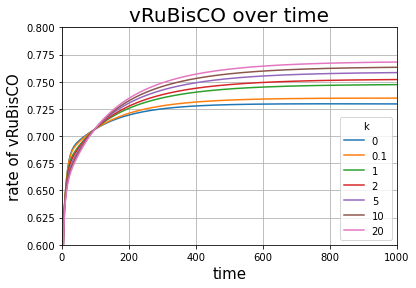

None


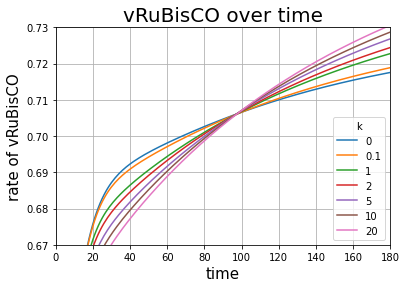

None


In [17]:
#(a) clear 
limly=0.600
limy=0.800

limlx=0
limx=1000

print(rates_time_k('vRuBisCO'))

#(b) zoomed
limly=0.67
limy=0.73

limlx=0
limx=180

print(rates_time_k('vRuBisCO'))

# Figure 7 Rate of starch synthesis over time

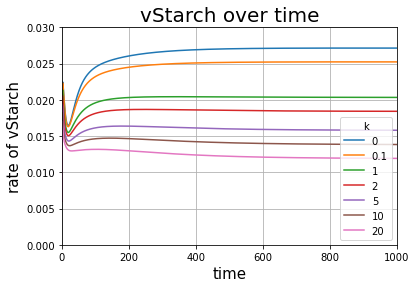

None


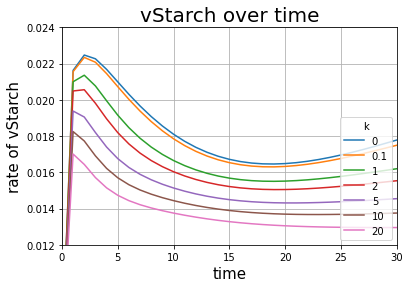

None


In [18]:
#(a) clear 
limy=0.030
limly=0
limlx=0
limx=1000
print(rates_time_k('vStarch'))

#(b) zoomed
limly=0.012
limy=0.024
limlx=0
limx=30
print(rates_time_k('vStarch'))

# Figure 8 Rates of Triose-Phosphate Transporter over time

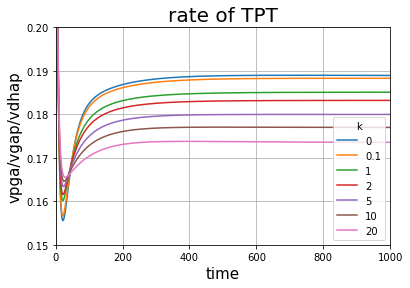

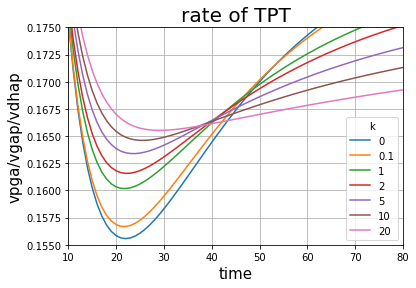

In [19]:
#(a) clear 
for i in klist:
    s.model.update_parameter('k19',i)
    s.initialise(y0)
    s.simulate(1000,steps=1000)
    rates=s.get_fluxes_dict()['vpga']+s.get_fluxes_dict()['vgap']+s.get_fluxes_dict()['vdhap']
    plt.plot(s.get_time(),rates,label=i)
    #instead of 2 x almost the same code, for
    #print('kvalue:',i)
    plt.xlabel("time", fontsize=15) 
    plt.ylabel("vpga/vgap/vdhap",fontsize=15)
    plt.title("rate of TPT", fontsize=20)
    plt.ylim(0.15,0.2)
    plt.xlim(0,1000)
    plt.legend(title="k", loc="lower right")

plt.grid()        
plt.show()

#(b) zoomed
for i in klist:
    s.model.update_parameter('k19',i)
    s.initialise(y0)
    s.simulate(1000,steps=1000)
    rates=s.get_fluxes_dict()['vpga']+s.get_fluxes_dict()['vgap']+s.get_fluxes_dict()['vdhap']
    plt.plot(s.get_time(),rates,label=i)
    #print('kvalue:',i)
    plt.xlabel("time", fontsize=15) 
    plt.ylabel("vpga/vgap/vdhap",fontsize=15)
    plt.title("rate of TPT", fontsize=20)
    plt.ylim(0.1550,0.1750)
    plt.xlim(10,80)
    plt.legend(title="k", loc="lower right")

plt.grid()        
plt.show()


using a new model for tests and preparing a list for the future k19-values and a dictionary which contents a list(as value) for each variable(as Key) 

# k19 loop for steady state concentrations

function with a loop for different 'k19' values; outputs steady State concentrations for every variable and every k19 value

"argumentk" to determine the K-values e.g. = range(0,1000,100)
"argumentp=1" to activate Plots for each k

In [20]:
import copy
kloop =  copy.deepcopy(m) 
loop = Simulator(kloop)

dct = {}
klist = []
for i in variables:
    dct['lst_%s' % i] = []
    

In [21]:
from collections import defaultdict
#argumentp can more or less be ignored - i found it interesting to plot some ranges
def steady_dict_k(argumentk, argumentp):
    
    for i in argumentk:
        klist.append(i)
        loop.model.update_parameter('k19', i)
        loop.initialise(y0)
        loop.simulate(3000, steps=1000)
        if argumentp == 1: 
            loop.plot_grid([['G6P', 'RU5P'], ['NADP', 'NADPH'], ['ATP', 'ADP']], sharey=False, xlabels="time [s]", ylabels="concentration [mM]") 
            plt.title("K19-value= %s" %i)
            loop.plot()
            plt.xlabel("time [s]")
            plt.ylabel("concentration [mM]")
            plt.show()

        for j in variables: 
            stdys = loop.get_variable('%s' % j)
            dct['lst_%s' % j].append(stdys[-1])
        if argumentp == 1:
            for key in dct: 
                print("Steady State concentration for k=",i,key, ':',((dct[key][-1]))) 
    return(dct)


calling up my function 

In [22]:
dctsty300 = (steady_dict_k(range(0,300,1), 0))
#print(dctsty300)

printing the result in a table

df = pd.DataFrame(data=dctsty300, index=klist)
print(df)

# Figure 9 : Steady state concentrations in dependency of the OPP

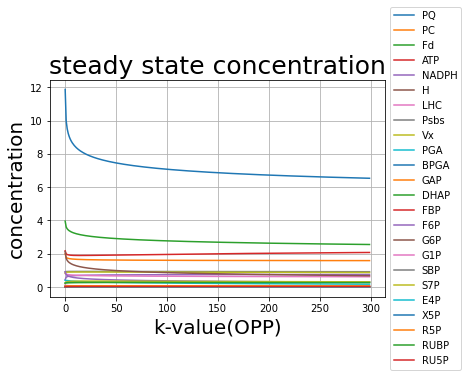

In [23]:
for i in variables:
    plt.plot(klist,dct['lst_%s' % i],label="%s"%i)

plt.xlabel("k-value(OPP)", fontsize = 20) 
plt.ylabel("concentration", fontsize=20)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("steady state concentration", fontsize=25)
plt.grid()
plt.show()


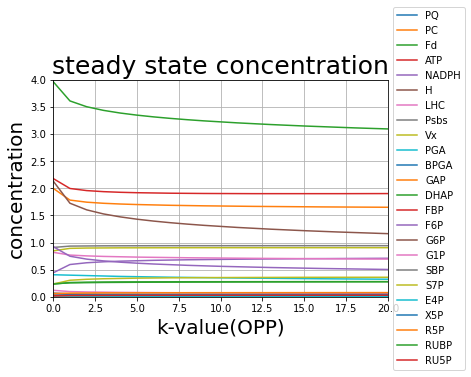

In [24]:
for i in variables:
    plt.plot(klist,dct['lst_%s' % i],label="%s"%i)

plt.xlabel("k-value(OPP)", fontsize = 20) 
plt.ylabel("concentration", fontsize=20)
plt.xlim(0,20)
plt.ylim(0,4)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("steady state concentration", fontsize=25)
plt.grid()
plt.show()


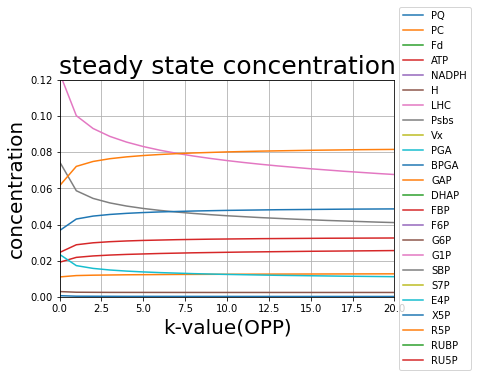

In [25]:
for i in variables:
    plt.plot(klist,dct['lst_%s' % i],label="%s"%i)

plt.xlabel("k-value(OPP)", fontsize = 20) 
plt.ylabel("concentration", fontsize=20)
plt.xlim(0,20)
plt.ylim(0,0.12)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("steady state concentration", fontsize=25)
plt.grid()
plt.show()


# Function for steady state rates

In [26]:
limly=0
limy=10
limlx=0
limx=1000

def steady_rates_k(vinrate, klist):
    dct2 = {}
    lst_vvalues = []

    for i in range(len(klist)):

        for j in variables:
            dct2[j] = dct['lst_%s' % j][i]

        vvalue = loop.model.get_fluxes_dict(dct2)['%s' % vinrate]
        lst_vvalues.append(vvalue)
    #print(lst_vvalues)

    plt.plot(klist,lst_vvalues)
    plt.xlabel("k19-value", fontsize=15)
    plt.ylabel("rate of %s" % vinrate, fontsize=15)
    #plt.legend(loc='center left')
    plt.ylim(limly,limy)
    plt.xlim(limlx,limx)
    plt.title("reaction rate of %s in steady state" % vinrate, fontsize=20)
    plt.grid()
    plt.show()

# Figure 10: Steady state rate of RuBisCO in relation to the OPP


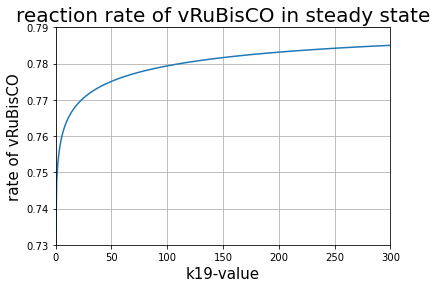

None


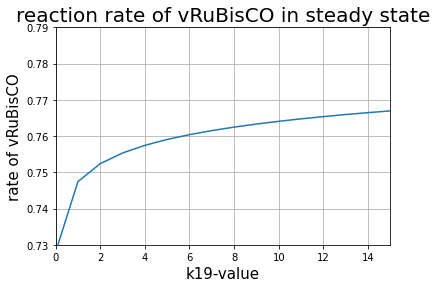

None


In [27]:
limly=0.73
limy=0.79
limlx=0
limx=300

print(steady_rates_k('vRuBisCO', klist))

limly=0.73
limy=0.79
limlx=0
limx=15
print(steady_rates_k('vRuBisCO', klist))


# Figure 11: Steady state rate of starch synthesis in relation to the OPP


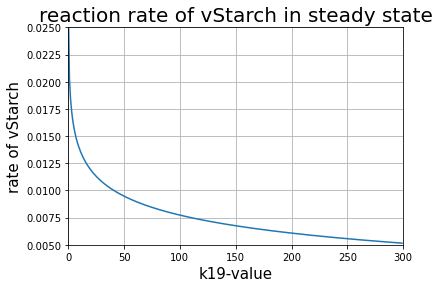

None


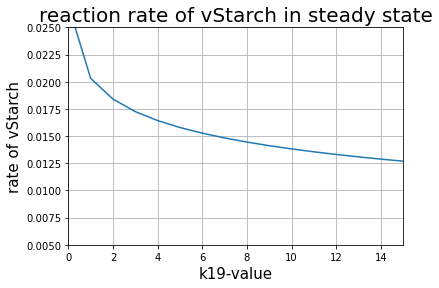

None


In [28]:
limly=0.005
limy=0.025
limlx=0
limx=300

print(steady_rates_k('vStarch', klist))

limly=0.005
limy=0.025
limlx=0
limx=15
print(steady_rates_k('vStarch', klist))


# Figure 12: Rate of TPT in relation to OPP


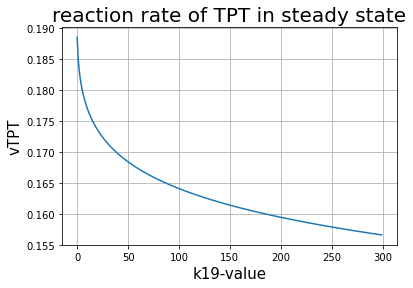

In [29]:
dct2 = {}
lst_vvalues = []

for i in range(len(klist)):

    for j in variables:
        dct2[j] = dct['lst_%s' % j][i]

    vvalue = loop.model.get_fluxes_dict(dct2)['vpga'] + loop.model.get_fluxes_dict(dct2)['vgap']+loop.model.get_fluxes_dict(dct2)['vdhap']
    lst_vvalues.append(vvalue)
#print(lst_vvalues)

#plt.figure(figsize=[15,15])
plt.plot(klist,lst_vvalues)
plt.xlabel("k19-value", fontsize = 15)
plt.ylabel("vTPT", fontsize=15)
#plt.xlim(0,15)
#plt.legend()
plt.title("reaction rate of TPT in steady state", fontsize=20)
plt.grid()
plt.show()



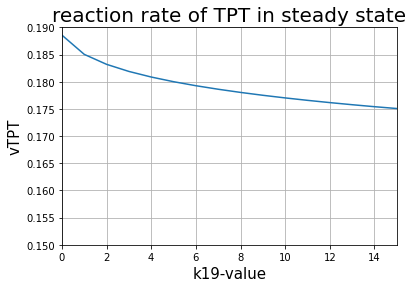

In [30]:
dct2 = {}
lst_vvalues = []
for i in range(len(klist)):

    for j in variables:
        dct2[j] = dct['lst_%s' % j][i]

    vvalue = loop.model.get_fluxes_dict(dct2)['vpga'] + loop.model.get_fluxes_dict(dct2)['vgap']+loop.model.get_fluxes_dict(dct2)['vdhap']
    lst_vvalues.append(vvalue)
#print(lst_vvalues)

#plt.figure(figsize=[15,15])
plt.plot(klist,lst_vvalues)
plt.xlabel("k19-value", fontsize = 15)
plt.ylabel("vTPT", fontsize=15)
plt.xlim(0,15)
plt.ylim(0.15,0.190)
#plt.legend()
plt.title("reaction rate of TPT in steady state", fontsize=20)
plt.grid()
plt.show()



just a test to look if the G6P Shunt is actually proportionally changed by changing the k_OPP value

# Light-Dark-Light Simulations

In [31]:
start_time = time.time()


start_time = time.time()

def LDL(s, y0, Tmax, intensity, darkphase, k19value):  
    '''Simple Light-Dark-Light simulation'''
        
    s.initialise(y0)
    s.update_parameters({'pfd': intensity})
    s.update_parameter('k19', 0.)
    s.simulate(300, steps=600, **{'atol':1.e-14}) #FIXME: this part I hate. I needed to fix integration steps to match Nimas previous work, otherwise doesn't converge
    s.update_parameter('pfd', 5.)
    s.update_parameter('k19', k19value)
    s.simulate(500, steps=200, **{'atol':1.e-14})  #I needed to make it smaller from the default, otherwise integration problems  
    s.update_parameter('pfd', intensity)
    s.update_parameter('k19', 0.)

    s.simulate(800, steps=300, **{'atol':1.e-14})
        
    return s, s.model


print (time.time() - start_time, 's')


def LDL_PAM(s, y0, Tmax, intensity, darkphase, Tflash=60.):  
    '''Simple Light-Dark-Light simulation with saturating pulses of light every Tflash seconds'''
        
    s.initialise(y0)
    s.update_parameters({'pfd': intensity, 'Ton': 300, 'Toff':300+darkphase, 'dT': Tflash})

    t=0
    Tmax=1800
    while t < Tmax :   
        #turn on the saturating pulse of light of Tflash length
        if t%s.model.get_parameter('dT') == 0:
            s.update_parameter('pfd', 5000)
            s.simulate(t+0.8)
        else:
            #switch on the light except for the dark period
            #t+dT-Tflash is the time to the next flash
            if t> s.model.get_parameter('Ton') or t<s.model.get_parameter('Toff'):
                s.update_parameter('pfd', 5.)
            else:
                #put the actinic light
                s.update_parameter('pfd', intensity)
            new_t = t+s.model.get_parameter('dT')-0.8
            s.simulate(new_t)  #I needed to make it smaller from the default, otherwise integration problems  
        t = s.get_time()[-1]  
        
    return s, s.model

print (time.time() - start_time, 's')

0.0 s
0.0 s


# Figure: 13 (a) Light-dark-light simulations with and without the OPP

20
50
100
150
200


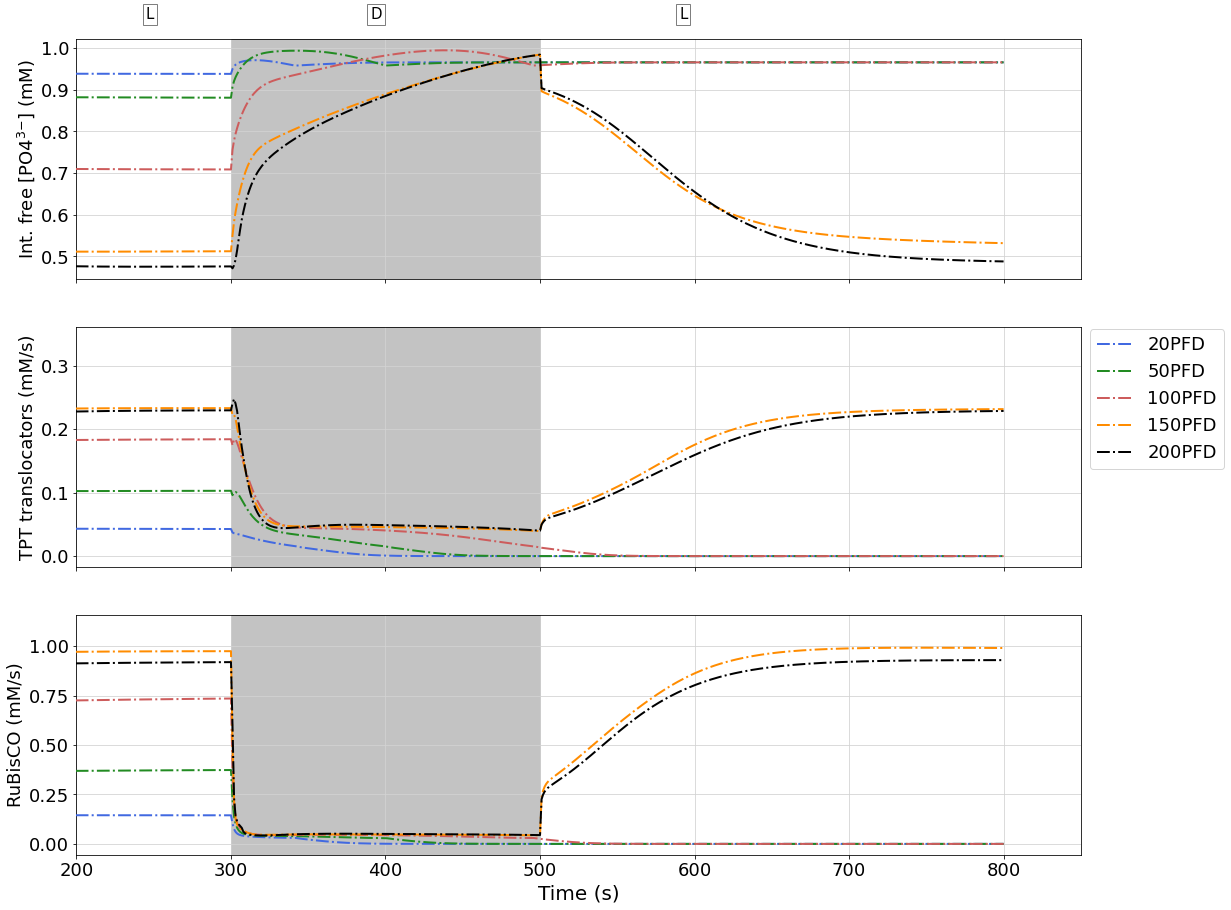

In [41]:
#Shunt not active !!
PhosphoMAX=15

fig, ax = plt.subplots(3,1, sharex=True)
plt.rcParams["figure.figsize"] = (18, 15)
for (aa), subplot in np.ndenumerate(ax):
    subplot.set_xlim(200,850)
    subplot.axvspan(300,500,alpha=0.4,color='dimgray')
    subplot.set_facecolor('white')
    subplot.grid(color='lightgrey')
    subplot.tick_params(axis='both', which='major', labelsize=18)


ax[0].set_ylabel('Int. free [PO4$^{3−}$] (mM)',fontsize=18.)
ax[0].text(245,1.07, 'L', fontsize=15,bbox={'facecolor':'w', 'alpha':0.5, 'pad':3})
ax[0].text(390, 1.07, 'D', fontsize=15,bbox={'facecolor':'w', 'alpha':0.5, 'pad':3})
ax[0].text(590, 1.07, 'L', fontsize=15,bbox={'facecolor':'w', 'alpha':0.5, 'pad':3})
ax[1].set_ylabel('TPT translocators (mM/s)',fontsize=18.)
ax[2].set_ylabel('RuBisCO (mM/s)',fontsize=18.)

ax[2].set_xlabel('Time (s)',fontsize=20.)

col = {20:'royalblue',50:'forestgreen',100:'indianred', 150: 'darkorange', 200:'black'}

for i in [20, 50, 100, 150, 200]: 
    print(i)

    s = Simulator(m)
    s.initialise(y0)
    s, m = LDL(s, y0, Tmax=500, intensity=i,darkphase=200., k19value=0)

    yvex1=s.get_fluxes_dict()['vpga']+s.get_fluxes_dict()['vgap']+s.get_fluxes_dict()['vdhap']
    yrub1=s.get_fluxes_dict()['vRuBisCO']

    ax[0].plot(s.get_time(),s.get_variable('Pi')/PhosphoMAX,color=col[i],linestyle='-.',linewidth=2.,label=str(i)+'PFD',zorder=10.)
    ax[1].plot(s.get_time(),yvex1, color=col[i],linestyle='-.',linewidth=2.,label=str(i)+'PFD',zorder=10.)
    ax[2].plot(s.get_time(),yrub1, color=col[i],linestyle='-.',linewidth=2.,zorder=10.)

ax[1].legend(loc='center left',bbox_to_anchor=(1., 0.7), prop={'size': 18})
#plt.legend()
plt.show()

# Figure: 13 (b) Light-dark-light simulations with and without the OPP

In [33]:
#LDL only active in the dark k_OPP = 5

start_time = time.time()

def LDL(s, y0, Tmax, intensity, darkphase, k19value):  
    '''Simple Light-Dark-Light simulation'''
        
    s.initialise(y0)
    s.update_parameters({'pfd': intensity})
    s.update_parameter('k19', 0.)
    s.simulate(300, steps=600, **{'atol':1.e-14}) #FIXME: this part I hate. I needed to fix integration steps to match Nimas previous work, otherwise doesn't converge
    s.update_parameter('pfd', 5.)
    s.update_parameter('k19', k19value)
    s.simulate(500, steps=200, **{'atol':1.e-14})  #I needed to make it smaller from the default, otherwise integration problems  
    s.update_parameter('pfd', intensity)
    s.update_parameter('k19', 0.)

    s.simulate(800, steps=300, **{'atol':1.e-14})
        
    return s, s.model


print (time.time() - start_time, 's')

0.0 s


20
50
100
150
200


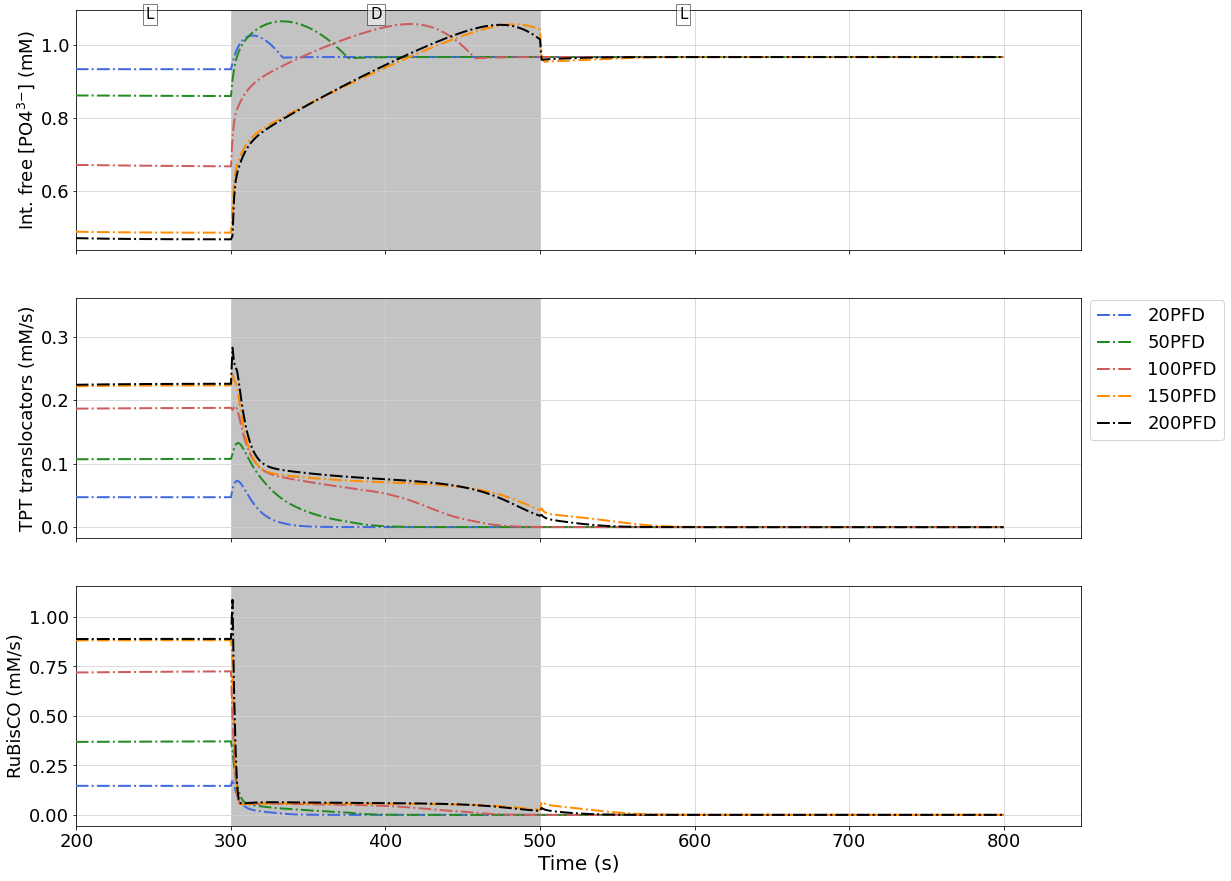

In [34]:
PhosphoMAX=15

fig, ax = plt.subplots(3,1, sharex=True)
plt.rcParams["figure.figsize"] = (18, 15)
for (aa), subplot in np.ndenumerate(ax):
    subplot.set_xlim(200,850)
    subplot.axvspan(300,500,alpha=0.4,color='dimgray')
    subplot.set_facecolor('white')
    subplot.grid(color='lightgrey')
    subplot.tick_params(axis='both', which='major', labelsize=18)


ax[0].set_ylabel('Int. free [PO4$^{3−}$] (mM)',fontsize=18.)
ax[0].text(245,1.07, 'L', fontsize=15,bbox={'facecolor':'w', 'alpha':0.5, 'pad':3})
ax[0].text(390, 1.07, 'D', fontsize=15,bbox={'facecolor':'w', 'alpha':0.5, 'pad':3})
ax[0].text(590, 1.07, 'L', fontsize=15,bbox={'facecolor':'w', 'alpha':0.5, 'pad':3})
ax[1].set_ylabel('TPT translocators (mM/s)',fontsize=18.)
ax[2].set_ylabel('RuBisCO (mM/s)',fontsize=18.)

ax[2].set_xlabel('Time (s)',fontsize=20.)

col = {20:'royalblue',50:'forestgreen',100:'indianred', 150: 'darkorange', 200:'black'}

for i in [20, 50, 100, 150, 200]: 
    print(i)

    s = Simulator(m)
    s.initialise(y0)
    s, m = LDL(s, y0, Tmax=500, intensity=i,darkphase=200., k19value=5)

    yvex1=s.get_fluxes_dict()['vpga']+s.get_fluxes_dict()['vgap']+s.get_fluxes_dict()['vdhap']
    yrub1=s.get_fluxes_dict()['vRuBisCO']

    ax[0].plot(s.get_time(),s.get_variable('Pi')/PhosphoMAX,color=col[i],linestyle='-.',linewidth=2.,label=str(i)+'PFD',zorder=10.)
    ax[1].plot(s.get_time(),yvex1, color=col[i],linestyle='-.',linewidth=2.,label=str(i)+'PFD',zorder=10.)
    ax[2].plot(s.get_time(),yrub1, color=col[i],linestyle='-.',linewidth=2.,zorder=10.)

ax[1].legend(loc='center left',bbox_to_anchor=(1., 0.7), prop={'size': 18})
#plt.legend()
plt.show()

In [35]:
#k_OPP always on 1

start_time = time.time()

def LDL(s, y0, Tmax, intensity, darkphase, k19value):  
    '''Simple Light-Dark-Light simulation'''
        
    s.initialise(y0)
    s.update_parameters({'pfd': intensity})
    s.update_parameter('k19', 1.)
    s.simulate(300, steps=600, **{'atol':1.e-14}) #FIXME: this part I hate. I needed to fix integration steps to match Nimas previous work, otherwise doesn't converge
    s.update_parameter('pfd', 5.)
    s.update_parameter('k19', k19value)
    s.simulate(500, steps=200, **{'atol':1.e-14})  #I needed to make it smaller from the default, otherwise integration problems  
    s.update_parameter('pfd', intensity)
    s.update_parameter('k19', 1.)

    s.simulate(800, steps=300, **{'atol':1.e-14})
        
    return s, s.model


print (time.time() - start_time, 's')

0.0 s


20
50
100
150
200


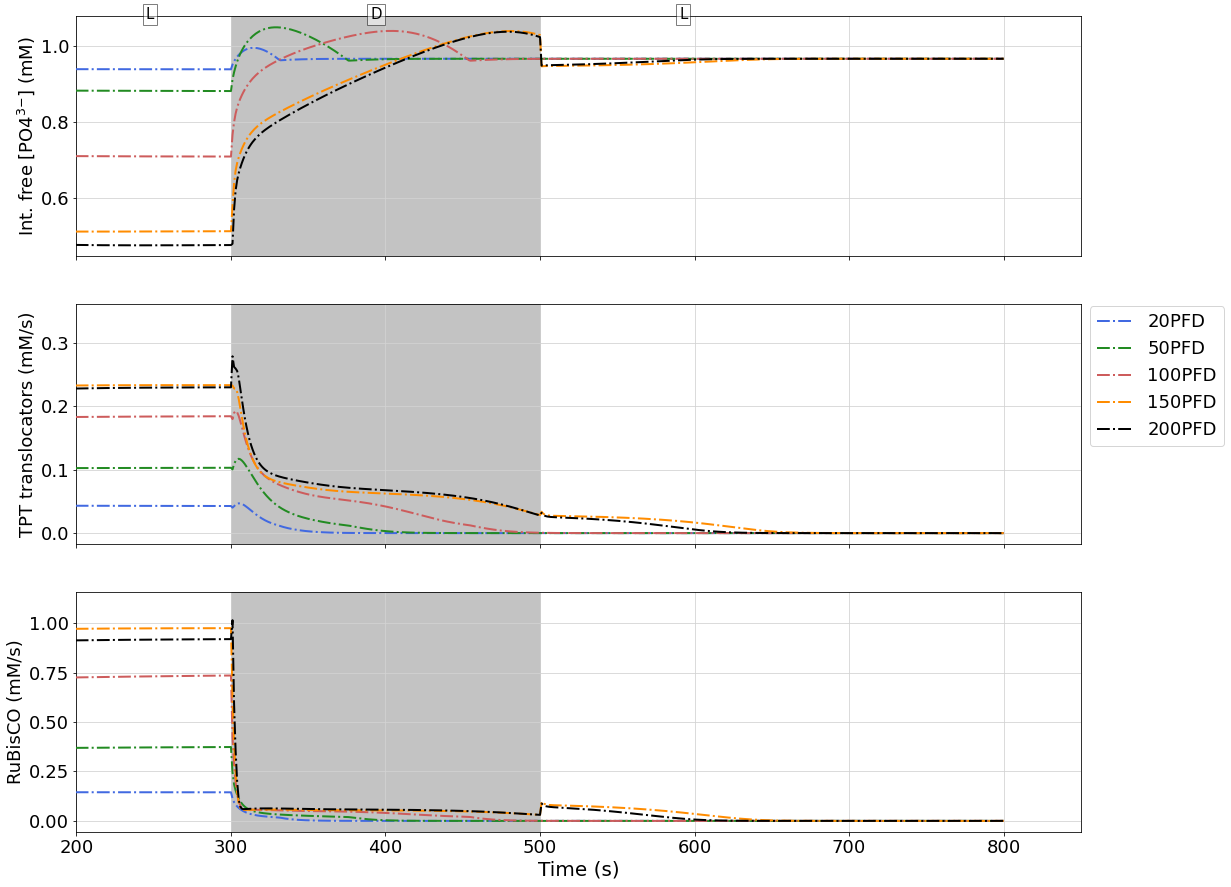

In [36]:
PhosphoMAX=15

fig, ax = plt.subplots(3,1, sharex=True)
plt.rcParams["figure.figsize"] = (18, 15)
for (aa), subplot in np.ndenumerate(ax):
    subplot.set_xlim(200,850)
    subplot.axvspan(300,500,alpha=0.4,color='dimgray')
    subplot.set_facecolor('white')
    subplot.grid(color='lightgrey')
    subplot.tick_params(axis='both', which='major', labelsize=18)


ax[0].set_ylabel('Int. free [PO4$^{3−}$] (mM)',fontsize=18.)
ax[0].text(245,1.07, 'L', fontsize=15,bbox={'facecolor':'w', 'alpha':0.5, 'pad':3})
ax[0].text(390, 1.07, 'D', fontsize=15,bbox={'facecolor':'w', 'alpha':0.5, 'pad':3})
ax[0].text(590, 1.07, 'L', fontsize=15,bbox={'facecolor':'w', 'alpha':0.5, 'pad':3})
ax[1].set_ylabel('TPT translocators (mM/s)',fontsize=18.)
ax[2].set_ylabel('RuBisCO (mM/s)',fontsize=18.)

ax[2].set_xlabel('Time (s)',fontsize=20.)

col = {20:'royalblue',50:'forestgreen',100:'indianred', 150: 'darkorange', 200:'black'}

for i in [20, 50, 100, 150, 200]: 
    print(i)

    s = Simulator(m)
    s.initialise(y0)
    s, m = LDL(s, y0, Tmax=500, intensity=i,darkphase=200., k19value=1)

    yvex1=s.get_fluxes_dict()['vpga']+s.get_fluxes_dict()['vgap']+s.get_fluxes_dict()['vdhap']
    yrub1=s.get_fluxes_dict()['vRuBisCO']

    ax[0].plot(s.get_time(),s.get_variable('Pi')/PhosphoMAX,color=col[i],linestyle='-.',linewidth=2.,label=str(i)+'PFD',zorder=10.)
    ax[1].plot(s.get_time(),yvex1, color=col[i],linestyle='-.',linewidth=2.,label=str(i)+'PFD',zorder=10.)
    ax[2].plot(s.get_time(),yrub1, color=col[i],linestyle='-.',linewidth=2.,zorder=10.)

ax[1].legend(loc='center left',bbox_to_anchor=(1., 0.7), prop={'size': 18})
#plt.legend()
plt.show()

# Figure 14: Photosynthetic electron transport chain metabolites with and without the OPP


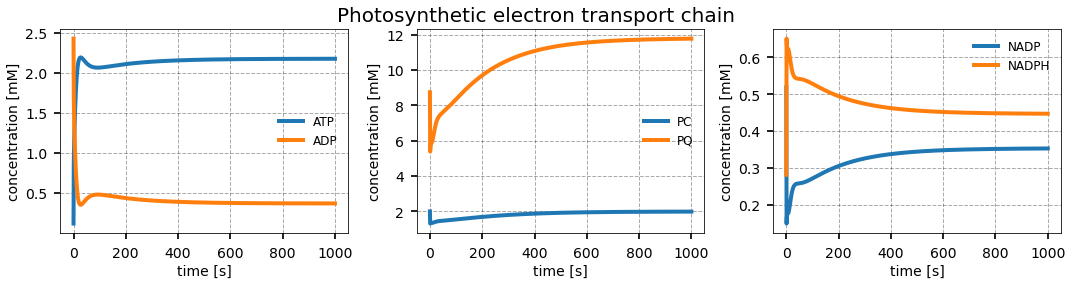

In [46]:
#(a) PETC metabolites without OPP activity (kOP P = 0)
s = Simulator(m)
s.model.update_parameter('pfd',100)
s.model.update_parameter('k19', 0)
s.initialise(y0)
s.simulate(1000, steps=1000)
s.plot_grid([['ATP', 'ADP'], ['PC', 'PQ'], ['NADP', 'NADPH']], sharey=False, xlabels="time [s]", ylabels="concentration [mM]" )
plt.tight_layout()
plt.suptitle("Photosynthetic electron transport chain",fontsize=20)
plt.subplots_adjust(top = 0.9)


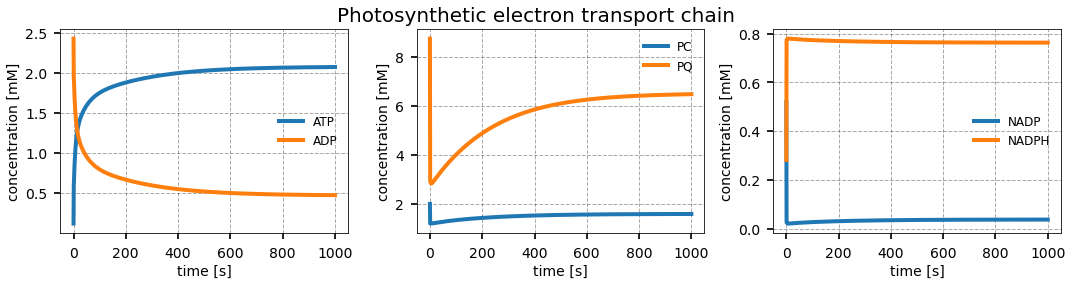

In [47]:
#(b) PETC metabolites with a fast OPP (kOP P = 300)


s = Simulator(m)
s.model.update_parameter('pfd',100)
s.model.update_parameter('k19', 300)
s.initialise(y0)
s.simulate(1000, steps=1000)
s.plot_grid([['ATP', 'ADP'], ['PC', 'PQ'], ['NADP', 'NADPH']], sharey=False, xlabels="time [s]", ylabels="concentration [mM]" )
plt.tight_layout()
plt.suptitle("Photosynthetic electron transport chain",fontsize=20)
plt.subplots_adjust(top = 0.9)


# Figure 15 : Steady state rate of cyclic and linear electron flow

In [56]:
def steady_rates_k(vinrate, klist):
    dct2 = {}
    lst_vvalues = []

    for i in range(len(klist)):

        for j in variables:
            dct2[j] = dct['lst_%s' % j][i]

        vvalue = loop.model.get_fluxes_dict(dct2)['%s' % vinrate]
        lst_vvalues.append(vvalue)
    print(lst_vvalues)

    #plt.figure(figsize=[15,15])
    plt.plot(klist,lst_vvalues)
    plt.xlabel("k19-value", fontsize=15)
    plt.ylabel("rate of %s" % vinrate, fontsize=15)
    #plt.ylim()
    #plt.xlim(0,15)
    plt.legend(loc='center left')
    plt.title("reaction rate of %s in steady state" % vinrate, fontsize=20)
    plt.grid()
    plt.show()

In [57]:
klist = []
for i in range(0,600,1):
    klist.append(i)

dct = {'lst_PQ': [11.864890104683903, 9.971974013127435, 9.501485010237667, 9.225798613788768, 9.03171009974702, 8.882512968362681, 8.761678163880578, 8.660355894016693, 8.573260259807613, 8.496985504008649, 8.429210004284204, 8.368282288367066, 8.312986209043554, 8.262399377711116, 8.215807695999063, 8.172647296837212, 8.13246286266882, 8.09488618682886, 8.059609313651725, 8.026378433706732, 7.994976269757808, 7.965219965961511, 7.9369522024265535, 7.9100366333203445, 7.884354317453209, 7.859801904501571, 7.836288027545069, 7.813731450430942, 7.792061384784021, 7.771212452342724, 7.751127252292968, 7.731755670822697, 7.713048158123588, 7.694964881197716, 7.677466363955062, 7.660518166374182, 7.644086115419197, 7.6281436454863005, 7.612663195634146, 7.597619492763644, 7.582988569796666, 7.568750385263912, 7.55488608754243, 7.541376350561589, 7.528204461788895, 7.515354865000909, 7.50281279789264, 7.490565133574154, 7.47859818452039, 7.466900302910097, 7.4554601908459635, 7.444267072292353, 7.433311552667552, 7.422584573729273, 7.412075329918698, 7.4017774915331955, 7.391682343917017, 7.381782286342308, 7.3720709226071, 7.362541006666876, 7.353186844344627, 7.344002203066577, 7.334980480508515, 7.326116701636894, 7.317406045691376, 7.308843909314387, 7.30042478562535, 7.292144896042565, 7.283999169344883, 7.275984373783738, 7.2680956916902995, 7.260330372688526, 7.252684066087685, 7.2451539090229415, 7.237736374960829, 7.2304284192890425, 7.2232265684044625, 7.216128710575501, 7.209131405216369, 7.202232034103949, 7.195428361632458, 7.1887181418328066, 7.182098383939746, 7.175567259382159, 7.169122194199648, 7.162761352288863, 7.156482255435063, 7.150283542083638, 7.144162668350133, 7.138118777777394, 7.132148871589153, 7.126252136603675, 7.1204264794264125, 7.114671134094252, 7.108982814646439, 7.103361245651133, 7.097804658446253, 7.092312410975801, 7.086882118285161, 7.0815129354868604, 7.076203229593007, 7.070952487720335, 7.065758712756133, 7.0606213465820815, 7.055538593410335, 7.0505102796956125, 7.045534577265017, 7.040610236874655, 7.035737740855363, 7.030914508976721, 7.026140250771266, 7.021414098346335, 7.016734783393012, 7.012101561221474, 7.0075136965320315, 7.002971010089797, 6.998471840580877, 6.994015307208526, 6.989601038374368, 6.9852284906254765, 6.980896321621184, 6.976604255065412, 6.972351557623296, 6.968137641402963, 6.963961805467933, 6.959822970564345, 6.955720968734676, 6.951655493712865, 6.947625491113471, 6.9436309047833955, 6.939669773953254, 6.935742980424399, 6.931849648499585, 6.927988891121003, 6.924160720308091, 6.92036426091312, 6.916598893390726, 6.912864506403708, 6.9091606956263325, 6.905486537557448, 6.901841940838935, 6.898225836402494, 6.894639010339144, 6.891080605838758, 6.887549602084946, 6.884045873765747, 6.880569310790023, 6.877119329759989, 6.873695178171959, 6.87029742015391, 6.866925607328124, 6.863577591660219, 6.860255097173206, 6.856957063301158, 6.853682915638594, 6.850433073465144, 6.8472064483624155, 6.844002839942306, 6.840822181837829, 6.837664488923805, 6.834528520858037, 6.831414788791463, 6.828322561334886, 6.825251350301685, 6.8222024741622525, 6.819173832496502, 6.816165262128394, 6.813178032434695, 6.81021035441853, 6.807262764119814, 6.80433453972606, 6.80142581020936, 6.798536266647254, 6.795665562472485, 6.792813488320947, 6.7899796128352055, 6.787164647547635, 6.784366957751402, 6.781587876578339, 6.778825915786503, 6.776081472468386, 6.773354118374399, 6.770643799508882, 6.767950290599873, 6.765273297930925, 6.762612855645082, 6.759968876043821, 6.757340672138581, 6.7547284197906, 6.752131893031758, 6.749550802664929, 6.746985241028675, 6.744434792334036, 6.7418992044856205, 6.739378769204743, 6.736872849208616, 6.734381316893113, 6.731904692870125, 6.729442151036756, 6.7269935487665, 6.724559097757469, 6.722138138169023, 6.7197311032091775, 6.71733755204431, 6.714957072879032, 6.712590404676352, 6.710236527521419, 6.707895833861497, 6.705567751902842, 6.703252679325938, 6.700949874165257, 6.698659780542612, 6.696381865547402, 6.694116275010398, 6.691862772836857, 6.689621261251593, 6.687391419241647, 6.685173674481781, 6.6829675648781635, 6.680772809987578, 6.678589628915819, 6.676417755945646, 6.674257709443881, 6.672107424028219, 6.6699689816748124, 6.667841263260274, 6.665724308188665, 6.663618345659543, 6.661522566535925, 6.65943766034425, 6.657363154703995, 6.655298847072815, 6.6532444718029415, 6.651200753577681, 6.649166980005827, 6.647142856817123, 6.645129046853261, 6.643124685287117, 6.641130176780751, 6.63914519105297, 6.637169897283494, 6.635203832660422, 6.633247181138284, 6.631299884054044, 6.629361555734295, 6.627432746880187, 6.625513021256566, 6.623602075219313, 6.62170018663604, 6.619806748836763, 6.617922217717454, 6.616046547441552, 6.614178865533136, 6.612320689404709, 6.610470416393174, 6.608628792443478, 6.606794873686465, 6.604970102933836, 6.603153087549908, 6.60134429668659, 6.599543499358945, 6.597750563348719, 6.5959656998642, 6.594188488549799, 6.592419762656328, 6.5906579248295225, 6.588904595017133, 6.587158370420492, 6.585419349975887, 6.583688982680226, 6.581965099203109, 6.580249041706963, 6.578540296212129, 6.576838692446379, 6.575144342352213, 6.573457179993896, 6.571777144343483, 6.570104124094145, 6.56843804936939, 6.5667792987656695, 6.5651273948221425, 6.563481990918509, 6.561843730742081, 6.560211905316636, 6.5585871440369115, 6.556968817942032, 6.555357105663704, 6.553752047720259, 6.552153581638431, 6.550561433560177, 6.548975724207764, 6.547396352160052, 6.545823078094097, 6.544256694807978, 6.5426962461112925, 6.541141888459961, 6.539594410533839, 6.538052063769437, 6.536515822265764, 6.534986051574162, 6.533462114523435, 6.531944532513037, 6.530432381703662, 6.528926239666961, 6.527425778778849, 6.525931284235889, 6.524442462641911, 6.522959540455487, 6.521482037870781, 6.520010019354314, 6.5185440054980806, 6.517083328178647, 6.515628154420322, 6.514178520350718, 6.512734359556683, 6.511295519279419, 6.509862019414758, 6.50843398369015, 6.507011052055199, 6.505593397484886, 6.504181342330042, 6.502774404362168, 6.501372444948758, 6.499975639331376, 6.498583911616424, 6.4971973134844925, 6.4958157282870985, 6.494439237639454, 6.493067538744801, 6.491701029886702, 6.4903388053075135, 6.488982036368723, 6.4876302649400595, 6.486283162759002, 6.4849406399265055, 6.48360313984301, 6.482269636673351, 6.480942007217755, 6.4796186460879115, 6.478299456503825, 6.47698533139386, 6.475675554321211, 6.474370542843799, 6.473069979002767, 6.471774054996278, 6.47048224163105, 6.469195137601808, 6.467912508253954, 6.466634280783206, 6.465360486783186, 6.464090745548518, 6.462825747029835, 6.461564532335348, 6.46030791839811, 6.459055533496844, 6.457807029635255, 6.456563075184774, 6.455323402290127, 6.454087869924286, 6.452856180739806, 6.451628400440335, 6.450405217545892, 6.449185770447613, 6.447970691015057, 6.446759523108946, 6.445552245878787, 6.444348848511465, 6.443149514126234, 6.441953525956691, 6.440763321894153, 6.439574725724963, 6.4383912188450925, 6.437210864842794, 6.436034894377819, 6.43486241084269, 6.433693953491584, 6.432529129718963, 6.4313679252375815, 6.430210500332942, 6.429056498073657, 6.427906596844642, 6.426760213400167, 6.4256176183613185, 6.4244783523483635, 6.423342689635372, 6.422210479916513, 6.421082311763153, 6.419957471348145, 6.418836116498474, 6.417717928860105, 6.416603862897508, 6.415492762535391, 6.414385330967576, 6.413281186384505, 6.412180340823917, 6.411083112381217, 6.409989210949807, 6.408898574500987, 6.407811549030951, 6.406727555908431, 6.4056472289909765, 6.404569696384975, 6.4034955944382785, 6.402424857379931, 6.401357457504715, 6.400292992079625, 6.399231816933994, 6.398173936119892, 6.3971191180676605, 6.396067514790489, 6.395018761074018, 6.393973845333986, 6.392931456256664, 6.3918923057245145, 6.39085613211805, 6.38982326703174, 6.388793047826312, 6.3877664865675605, 6.386742687869732, 6.385721658913422, 6.384703669276251, 6.3836884106838845, 6.382676666833665, 6.381667331168394, 6.380661704463565, 6.379658401961889, 6.378658078178567, 6.377660974096223, 6.3766663384377, 6.375674641895968, 6.374685901703861, 6.373699860151072, 6.37271673819754, 6.371736386555086, 6.370758308561136, 6.369784030911595, 6.368812142249464, 6.367842876542458, 6.366876329901999, 6.365912498746648, 6.3649516006218425, 6.363993170194714, 6.363037643395477, 6.36208485375941, 6.361134344868435, 6.360186883217287, 6.359241826328307, 6.358299182233008, 6.357359682544073, 6.356422573632797, 6.355488107389075, 6.354555936888942, 6.353626930799722, 6.352699925564629, 6.351775545410015, 6.350854073893103, 6.349934847008998, 6.349018229057269, 6.34810409456384, 6.3471924057416595, 6.346283381033985, 6.3453764209095285, 6.3444723544916535, 6.343570420551516, 6.342671174300748, 6.341773790642368, 6.340879698150236, 6.339987599441903, 6.339098072124991, 6.338210621265795, 6.337325775968973, 6.336443149547742, 6.335563070005023, 6.3346851249599, 6.333809573589301, 6.3329364465519475, 6.332065448571158, 6.331196935609653, 6.330330665406761, 6.329466744202323, 6.328604887188846, 6.327745535165098, 6.326888306336513, 6.326033659880926, 6.3251808636303375, 6.324330447014733, 6.323482342932468, 6.322635994196641, 6.321792480552938, 6.320950973617563, 6.320111436602618, 6.319274345207925, 6.318439170378941, 6.317606254263935, 6.31677554272202, 6.315946641788788, 6.3151205445472725, 6.314296147865004, 6.313473839921355, 6.312653499751102, 6.311835567252398, 6.311019723181676, 6.3102059516247975, 6.309394161720422, 6.308584508883525, 6.30777665252945, 6.306971221810426, 6.306167572311633, 6.305366101273627, 6.304566536257578, 6.303769017389107, 6.302973517370303, 6.302180120100489, 6.3013888172720804, 6.300599118043058, 6.299811639632474, 6.299026152726933, 6.298242573685951, 6.297460455759611, 6.296681315325237, 6.2959036751803295, 6.295127533457269, 6.294353817521866, 6.2935818994420405, 6.292811871821811, 6.2920437750539335, 6.2912775839223425, 6.2905131672651455, 6.289751102127181, 6.288990092093664, 6.288231572337664, 6.287474554770369, 6.286719659838638, 6.285966555059143, 6.285215188515437, 6.2844657713163965, 6.283717900478261, 6.282972190413491, 6.282228054756677, 6.281486106806687, 6.280745783527576, 6.280007233199855, 6.279270391633286, 6.278534887964852, 6.277802152578872, 6.277070601124682, 6.276340914641004, 6.275612975561673, 6.274886482335841, 6.274162157521145, 6.273439522340937, 6.2727185593405945, 6.271999224575206, 6.2712817215161385, 6.270565851764144, 6.26985166022903, 6.269139273175888, 6.268428570337405, 6.267719584383335, 6.267012186030958, 6.266306458285785, 6.265602415641127, 6.2649004507036645, 6.264199502911405, 6.263500334803099, 6.262802984175074, 6.262107224658266, 6.261412996562986, 6.260720609681586, 6.260029841325377, 6.259340592314033, 6.258652879690079, 6.257966964133954, 6.257282538987378, 6.256599865052445, 6.255918615829356, 6.255238875259899, 6.254560889757251, 6.253883816917257, 6.253209359983362, 6.252536213758183, 6.251864422202686, 6.251194209505406, 6.250525167032659, 6.249858477235211, 6.249192803483581, 6.24852866541203, 6.2478662867199555, 6.2472053006557955, 6.2465459086457145, 6.245887908951724, 6.2452317384814275, 6.244576571772698, 6.243923227095967, 6.243271220185923, 6.242620699477472, 6.241972085251445, 6.241324228548133, 6.240677970815489, 6.240033737549495], 'lst_PC': [2.0000095512703053, 1.7832192381739118, 1.7447904083845267, 1.7244698699188699, 1.711063884031534, 1.701239846707605, 1.693579144598273, 1.687353910342868, 1.6821441072107222, 1.677686849680045, 1.6738073520508954, 1.6703840199859088, 1.6673290613501273, 1.6645770176478987, 1.6620780649755595, 1.6597934720078036, 1.657692309744153, 1.6557500228130537, 1.6539461552891839, 1.6522641895478478, 1.6506899963143575, 1.6492118987656603, 1.6478199288630981, 1.6465055096840635, 1.6452612106826012, 1.644080664224172, 1.6429582674477665, 1.641889057625178, 1.6408688090760124, 1.6398935411010183, 1.6389598389228406, 1.6380648148932413, 1.6372054163795604, 1.6363794373732972, 1.6355845325674547, 1.634818742194666, 1.6340799964982644, 1.6333669148971854, 1.6326778996642042, 1.6320114977191986, 1.6313663054062053, 1.630741255388089, 1.6301353350468748, 1.629547412766792, 1.6289765743332631, 1.6284219733083147, 1.627882796971029, 1.6273583585278562, 1.6268478698322613, 1.6263507195337852, 1.6258662971490494, 1.6253940135310656, 1.624933396297325, 1.6244839781299933, 1.6240450818172711, 1.6236164784986145, 1.6231976640009653, 1.6227882310661121, 1.6223878787951682, 1.6219961994506222, 1.621612930444487, 1.6212377369302144, 1.620870230443437, 1.6205101781916256, 1.620157351890157, 1.619811532569044, 1.6194723953087815, 1.6191397844015432, 1.6188134002636552, 1.6184931242081508, 1.6181786635200757, 1.6178699328824064, 1.6175666709289527, 1.61726876484048, 1.6169760245145441, 1.6166883030083303, 1.6164054029408825, 1.6161272617285662, 1.6158536734750493, 1.6155845107368612, 1.6153196820063922, 1.615059089532668, 1.6148025515503674, 1.6145500050005155, 1.6143013037079446, 1.6140563728382251, 1.613815069312038, 1.613577360114317, 1.6133430866603677, 1.6131122629721635, 1.6128846754357908, 1.612660335880641, 1.612439118994598, 1.612221035180426, 1.6120058295379853, 1.611793557559691, 1.6115841181391144, 1.6113775233493297, 1.6111736013828826, 1.6109723391829225, 1.6107736384704636, 1.610577520286223, 1.6103838396108598, 1.6101926086313567, 1.6100037041896504, 1.6098171697285242, 1.6096328778003854, 1.609450756512829, 1.6092709132675176, 1.6090931380304032, 1.6089174530035049, 1.6087438219586345, 1.6085721659112442, 1.6084024536493144, 1.60823466181271, 1.6080688181142133, 1.607904794901065, 1.6077425508782972, 1.6075820851637492, 1.6074233931058275, 1.6072663699788057, 1.60711102820903, 1.6069573343005992, 1.6068052658342091, 1.6066547871013632, 1.6065058244920023, 1.6063583965085175, 1.6062125076842657, 1.606068081095272, 1.6059251460480926, 1.605783532557707, 1.6056433628840405, 1.605504579581512, 1.6053671225491044, 1.6052310193392754, 1.6050962117604446, 1.6049626637449133, 1.6048303906025698, 1.604699380570963, 1.604569564307288, 1.6044409562365245, 1.6043134759195914, 1.6041872268180255, 1.6040621452158004, 1.6039381508297068, 1.60381525507381, 1.6036934677034431, 1.6035727519897016, 1.6034530564720175, 1.6033344526823696, 1.6032169236001619, 1.6031002641893677, 1.6029846756572501, 1.60287006731356, 1.6027564001340877, 1.6026437366969017, 1.6025319804525466, 1.6024211364680438, 1.6023112110270075, 1.6022022253401587, 1.6020940692892014, 1.6019868078154385, 1.6018803913137283, 1.601774780336025, 1.6016701286943147, 1.601566235478526, 1.6014631006318492, 1.601360870525887, 1.6012593738784073, 1.6011586828081867, 1.6010587391789677, 1.6009595666055116, 1.6008611489049127, 1.6007634646822677, 1.6006665107495557, 1.6005702496525986, 1.6004747692751171, 1.6003799166333015, 1.6002858391385808, 1.60019239671304, 1.6000996424931806, 1.600007548387078, 1.5999161154702826, 1.5998253345673992, 1.599735189439647, 1.599645690363273, 1.5995568416562318, 1.5994685830898259, 1.5993809466336761, 1.599293914153327, 1.5992074751201832, 1.5991216390821146, 1.599036378023219, 1.598951679214244, 1.5988675787522832, 1.5987840214482465, 1.598701004011634, 1.598618589565342, 1.5985367037963873, 1.5984553364641225, 1.5983745236966087, 1.5982942041608557, 1.5982144333109558, 1.5981351697209072, 1.5980563845544258, 1.5979781586878845, 1.5979003979080173, 1.597823148609869, 1.5977463611272988, 1.5976700841200433, 1.597594251328164, 1.5975189104801744, 1.5974440190578538, 1.5973696003560678, 1.5972956315116156, 1.5972221186954196, 1.597149028892317, 1.5970764140063851, 1.5970042376607445, 1.596932472082366, 1.596861150700313, 1.5967902505665217, 1.5967198338256154, 1.5966496952421378, 1.5965800493854272, 1.5965107950643298, 1.5964419392451439, 1.5963735098104963, 1.5963054322651182, 1.5962377806093895, 1.5961705148214331, 1.5961036234512522, 1.5960370803013386, 1.5959709633313344, 1.595905205531449, 1.5958397969952591, 1.595774785206543, 1.5957101071174389, 1.5956458018369961, 1.595581840328206, 1.5955182508326726, 1.5954549822467499, 1.5953920629431593, 1.5953295034959825, 1.5952672429444366, 1.5952053628175273, 1.5951438187748526, 1.5950825873594987, 1.5950216935463069, 1.594961080543533, 1.5949008112338117, 1.5948408744312377, 1.5947811911906102, 1.5947219183667987, 1.594662896048271, 1.594604201221355, 1.5945457533021348, 1.5944876918009467, 1.5944298852753263, 1.5943723829586065, 1.5943151632626336, 1.5942582292893397, 1.5942015930705633, 1.5941452129019218, 1.5940891878064984, 1.5940333573423873, 1.5939778904494184, 1.5939226434817035, 1.5938676300788963, 1.593813002727158, 1.5937585551651983, 1.5937044118535861, 1.5936505298508472, 1.5935968938006537, 1.5935435195292529, 1.5934904096012894, 1.59343755383553, 1.5933849437520067, 1.5933325799230404, 1.593280503122968, 1.5932286698500293, 1.5931770428135652, 1.5931256873124322, 1.5930745467246339, 1.593023685602047, 1.5929730358269067, 1.5929226250686308, 1.592872450743317, 1.592822520849859, 1.5927728036021813, 1.5927233175491624, 1.5926740573413625, 1.5926249982704823, 1.592576214104168, 1.5925276291172414, 1.592479248176533, 1.5924311656112198, 1.5923831932150165, 1.592335443823802, 1.5922879497210194, 1.592240651358689, 1.5921936069670521, 1.5921467248666819, 1.5921000586107934, 1.5920535880162616, 1.5920073413829068, 1.5919612839865107, 1.5919154440028251, 1.591869788866269, 1.591824309193994, 1.591779073643312, 1.5917340069850903, 1.591689133941601, 1.5916444591858858, 1.5915999751198486, 1.5915556764929004, 1.5915115602504988, 1.5914676456218515, 1.5914238926380726, 1.5913803245112723, 1.5913369790736882, 1.5912938028949342, 1.5912507908274327, 1.591207962142161, 1.5911653053654253, 1.591122827244996, 1.591080529857095, 1.5910384116900753, 1.5909964479547036, 1.5909546792238183, 1.5909130200474968, 1.59087159150643, 1.5908303380140607, 1.5907892426995909, 1.5907482886574416, 1.5907075256787822, 1.5906668553481214, 1.5906264679907554, 1.5905861932743943, 1.5905460377405376, 1.590506084517507, 1.5904662673048833, 1.5904266230097583, 1.5903871283083675, 1.5903477956287064, 1.5903085968863295, 1.5902695681426944, 1.5902306928005847, 1.5901919737648813, 1.5901534086015385, 1.590114965753014, 1.590076705656793, 1.5900385492073705, 1.5900005710143204, 1.5899627353647299, 1.5899250201635815, 1.5898874647633854, 1.5898500723284061, 1.589812815501319, 1.5897756778142613, 1.5897386611044022, 1.5897018328880927, 1.5896651143286984, 1.5896285620536401, 1.5895921407621345, 1.5895558417811597, 1.58951967305815, 1.5894836440495694, 1.589447692243192, 1.589412066701538, 1.5893763465664539, 1.5893408696355635, 1.589305465260687, 1.5892702467728577, 1.5892351260386446, 1.5892001550250823, 1.589165297315894, 1.5891305620166742, 1.5890959549974013, 1.5890614453612213, 1.5890271084341485, 1.588992874565384, 1.588958776166253, 1.5889247825590107, 1.588890905565304, 1.5888571367111102, 1.588823535672082, 1.5887900328627445, 1.5887566432929663, 1.588723339658054, 1.5886902224871884, 1.5886571663859876, 1.5886242514428486, 1.5885914412211815, 1.5885587288610015, 1.5885261535864346, 1.5884936872797706, 1.5884613258284617, 1.5884290996886326, 1.5883969560015476, 1.5883649651953031, 1.5883330279915857, 1.5883012241568202, 1.5882695323871454, 1.5882379624074117, 1.5882064722871108, 1.5881751022684418, 1.5881438367862115, 1.588112673702642, 1.5880816203096741, 1.58805064617033, 1.588019841703067, 1.5879890841192181, 1.5879584444510373, 1.5879279002650166, 1.5878974815854885, 1.5878671177684474, 1.5878369185741354, 1.5878067884247917, 1.5877767468665784, 1.5877468068989886, 1.5877169403278688, 1.5876872250083964, 1.5876575533890467, 1.587628058359118, 1.5875985976280582, 1.587569242439941, 1.5875400200814198, 1.587510844385448, 1.5874817672262609, 1.5874528021616556, 1.5874239168361501, 1.5873951315307417, 1.5873664390663762, 1.587337780606427, 1.5873093233941702, 1.587280911839995, 1.587252582587463, 1.5872243372474688, 1.587196183198183, 1.587168136446195, 1.5871401572515476, 1.5871122843503307, 1.5870845054573395, 1.5870567806004847, 1.587029179728571, 1.587001632508545, 1.5869741607419081, 1.5869468245442393, 1.586919549684844, 1.586892362064713, 1.586865245493631, 1.5868382499708074, 1.586811292392912, 1.5867844222228686, 1.5867576739584452, 1.5867309812070622, 1.5867043758458712, 1.5866778493049856, 1.5866514028288703, 1.586625049306349, 1.5865987539347048, 1.5865725630289265, 1.586546426986101, 1.5865203902536071, 1.586494379561393, 1.5864685366988083, 1.586442724639352, 1.5864170069126617, 1.5863913378250853, 1.5863657658700296, 1.5863402610118185, 1.5863148502927693, 1.5862894976854238, 1.5862642187206943, 1.5862390279772438, 1.5862138950282896, 1.5861888540299387, 1.5861638785585728, 1.5861389811431468, 1.5861141469012687, 1.5860893944661512, 1.5860647130632337, 1.5860401284659897, 1.5860155811827465, 1.5859911217595877, 1.5859667372905684, 1.5859423849703433, 1.5859181600138175, 1.5858939870003712, 1.5858698699979097, 1.5858458472541495, 1.5858218680096043, 1.5857979629817944, 1.5857741391026354, 1.5857503467516776, 1.5857266906564056, 1.5857030603044848, 1.5856794933279557, 1.5856559812507027, 1.5856325709636399, 1.5856092243879103, 1.5855859370608683, 1.5855627184804724, 1.5855395645986132, 1.5855164573312677, 1.5854934430974563, 1.5854704734118938, 1.5854475829052528, 1.5854247437252087, 1.5854019762604217, 1.5853792686809904, 1.585356631770869, 1.5853340770873736, 1.5853115391541, 1.5852890967853404, 1.585266710814859, 1.5852443827744103, 1.5852220708203595, 1.5851999217472175, 1.5851777922378258, 1.5851556741792692, 1.5851336710903456, 1.5851117260366259, 1.5850898209080702, 1.5850679944035668, 1.5850462177511087, 1.5850244953730366, 1.5850028619110916, 1.5849812388050415, 1.584959712398978, 1.5849382225978013, 1.584916809968039, 1.5848954485898992, 1.5848741384181313, 1.5848528977841436, 1.5848316863361547, 1.584810568196086, 1.5847894758986931, 1.5847684795026369, 1.5847475245673135, 1.58472662662734, 1.5847057738359935, 1.5846849333753181, 1.5846642467251728, 1.584643556793289, 1.5846229414691893, 1.5846023669235034, 1.5845818297139251, 1.584561383012842, 1.5845409830004864, 1.5845206356841766, 1.5845003315087862, 1.5844800937139885, 1.58445990251197, 1.5844397534724057, 1.5844196752744133, 1.5843996505511766, 1.5843796768230503, 1.5843597461681993, 1.5843398663637134, 1.5843200440549925, 1.5843003133173086, 1.5842805673090203, 1.5842608904417408, 1.5842412804507442, 1.5842217169930592, 1.5842021923077385, 1.5841827423908847, 1.584163338270819, 1.5841439752972937, 1.5841246505615052, 1.5841053993534178, 1.5840861834813895, 1.5840670342707328, 1.5840479190915535, 1.5840288458679015, 1.5840098377992828, 1.5839908177234192, 1.583971946497376, 1.5839530931013126, 1.5839342706955308, 1.583915501653978, 1.583896738032084, 1.583878099988991, 1.5838594707569915, 1.583840877931518, 1.583822358116355, 1.5838038704752009, 1.5837854384003092, 1.5837670396527908, 1.5837487131425374, 1.5837303962087084, 1.5837121487146528, 1.5836939328853357, 1.5836757725866868, 1.5836576876711574, 1.5836395816067235, 1.5836215276541614, 1.5836035796793617], 'lst_Fd': [3.961170052671549, 3.607277251077296, 3.500511882538443, 3.4337671515166956, 3.384786268578803, 3.3459601958338516, 3.313738334500454, 3.2861672219327636, 3.262054003809996, 3.2406155271544077, 3.221309291032045, 3.2037437089095584, 3.1876266768896047, 3.172734312777712, 3.158891269854569, 3.14595761059692, 3.1338197017935103, 3.1223842509478685, 3.11157336383414, 3.1013216789997156, 3.091573478715451, 3.082281135996714, 3.073403497810695, 3.064904756147685, 3.0567535556784735, 3.048922343988463, 3.0413867177867138, 3.03412495359035, 3.027117735702779, 3.0203476054835456, 3.0137989172370108, 3.0074576296974307, 3.00131074230362, 2.9953467478513787, 2.989554944157958, 2.983925637744229, 2.9784497647798487, 2.9731192985492325, 2.967926637755658, 2.962864768375389, 2.9579271555835485, 2.953107879545645, 2.948401419890174, 2.9438025194475563, 2.9393063588138024, 2.9349084387918443, 2.930604533398765, 2.9263907307284898, 2.922263265472606, 2.918218680767497, 2.9142537004464817, 2.910365228977217, 2.906550397164, 2.9028064847300667, 2.899130763428582, 2.8955209199248886, 2.8919745751692205, 2.8884895180285706, 2.885063707715695, 2.8816951219164264, 2.878381922750087, 2.8751223031538453, 2.8719144937025636, 2.8687569027043307, 2.8656480045386714, 2.8625863440952313, 2.8595704505985347, 2.856599026028642, 2.853670721093083, 2.8507843633853187, 2.847938704037716, 2.845132681562925, 2.842365153578656, 2.8396351187005755, 2.8369415590251745, 2.83428352209509, 2.8316600506398166, 2.8290703161809163, 2.82651341557594, 2.8239885327160374, 2.8214949011287995, 2.8190317755712715, 2.816598377562153, 2.8141940324552475, 2.811818029824877, 2.8094697341618096, 2.807148475276396, 2.804853686498477, 2.8025847258407635, 2.8003410934387167, 2.7981221425791816, 2.7959274047400684, 2.7937563279512077, 2.7916084734834876, 2.789483221872275, 2.787380195810299, 2.785298912554203, 2.7832389890097264, 2.7811999167534456, 2.7791813165671795, 2.7771827576335366, 2.7752038983654286, 2.773244304274211, 2.771303646920928, 2.7693815166760327, 2.767477637903862, 2.765591609601369, 2.763723086665944, 2.7618718650925307, 2.760037504527337, 2.758219755742257, 2.7564183263916773, 2.754632897926238, 2.7528632063311274, 2.7511089820000385, 2.74937001238723, 2.7476459728992046, 2.745936597084561, 2.744241678477288, 2.7425609816385843, 2.7408942329350077, 2.739241238997384, 2.7376017693465715, 2.7359756141491314, 2.7343625591016196, 2.7327623600875732, 2.731174851991305, 2.7295998604829377, 2.7280371585394776, 2.7264865982315447, 2.7249478822945457, 2.723420948590542, 2.721905591867262, 2.7204016091179626, 2.718908880468266, 2.717427207531985, 2.715956419512919, 2.7144963910321436, 2.713046970208635, 2.711607969362683, 2.7101792739533366, 2.7087606813099536, 2.7073521551208146, 2.7059535205600422, 2.704564590611822, 2.703185254394216, 2.701815408198885, 2.700454907438949, 2.699103590566821, 2.6977614243814987, 2.696428271316791, 2.695103870240262, 2.693788274758697, 2.6924813138265367, 2.6911828557741844, 2.6898928544861413, 2.688611143488171, 2.687337618115343, 2.686072202864176, 2.6848148215148187, 2.683565295698101, 2.682323602273575, 2.6810895968440756, 2.6798631759381952, 2.6786443803325364, 2.6774329657167177, 2.6762288505926066, 2.67503207749835, 2.673842433878911, 2.6726599000939046, 2.671484350790182, 2.670315742073477, 2.6691539861926303, 2.667998994719831, 2.6668506859168195, 2.665708975302879, 2.664573866265513, 2.663445161729517, 2.6623229252157365, 2.661206976034913, 2.660097296385908, 2.658993792958963, 2.657896418764185, 2.656805101712271, 2.6557197642360673, 2.6546403691763234, 2.6535668579227685, 2.6524991258825668, 2.651437138689673, 2.65038084000056, 2.6493301478817486, 2.6482850416252703, 2.6472454366107017, 2.6462112638727278, 2.6451825128881477, 2.6441590864632545, 2.6431409330049926, 2.6421280583135798, 2.6411203491849666, 2.640117762003834, 2.639120269500943, 2.638127780204855, 2.6371402924308067, 2.636157737940982, 2.635180038088534, 2.6342072275102257, 2.633239179069761, 2.632275895607308, 2.631317291917307, 2.630363370188241, 2.6294140290485917, 2.62846928373897, 2.6275290485958247, 2.6265933042912257, 2.6256620075591686, 2.624735106647101, 2.623812553167928, 2.622894354416245, 2.621980434372691, 2.6210707475897816, 2.6201652792586922, 2.6192639811919305, 2.6183668687038923, 2.617473729894724, 2.6165847317378383, 2.6156997371994914, 2.6148187283801336, 2.613941702705919, 2.6130685583461455, 2.6121993367594065, 2.6113339664470776, 2.610472400024288, 2.609614596163899, 2.6087605991250973, 2.607910320588089, 2.6070636901834168, 2.6062207813932545, 2.60538146448361, 2.6045457660485765, 2.603713631804975, 2.602885050101282, 2.6020599687788666, 2.6012383771942362, 2.6004202309030657, 2.5996055160870815, 2.5987942298380085, 2.597986319208406, 2.597181732934338, 2.596380487942175, 2.5955825085884885, 2.5947878008217677, 2.593996357016162, 2.593208070181794, 2.592423064748778, 2.5916411760065627, 2.5908624593939376, 2.590086793599286, 2.5893143111015164, 2.5885448566061604, 2.5877784600285594, 2.587015085881631, 2.5862546872607726, 2.5854972860560226, 2.584742830728151, 2.5839913665417504, 2.583242735156656, 2.5824970671019365, 2.5817542236715343, 2.581014198696367, 2.5802771100200643, 2.579542724564448, 2.578811174770699, 2.5780823895445333, 2.5773563390875847, 2.5766330216444753, 2.575912404575234, 2.5751944796140105, 2.5744792229534093, 2.573766607823105, 2.573056657457418, 2.5723493108365356, 2.5716445291864476, 2.570942364279077, 2.570242718927289, 2.569545642902542, 2.568851074021088, 2.5681590068277873, 2.567469447823182, 2.5667823608301847, 2.56609771766685, 2.5654155131352456, 2.5647357220962457, 2.564058314623832, 2.5633833675939726, 2.5627107520624035, 2.5620404907553493, 2.5613726309417992, 2.5607070140519324, 2.560043704115351, 2.5593827375211666, 2.558724037215778, 2.558067639176975, 2.5574134443815235, 2.556761508343464, 2.55611177394953, 2.5554642625066544, 2.5548189461138167, 2.5541758314156033, 2.5535348448893407, 2.5528960055195515, 2.552259337899351, 2.551624778784184, 2.5509923269676578, 2.550361978966445, 2.549733723139587, 2.5491075234596448, 2.5484833829899958, 2.5478612978129997, 2.5472412322353706, 2.5466231881741397, 2.5460071839524674, 2.5453931734397073, 2.5447811243709983, 2.5441710457127744, 2.5435629297569413, 2.542956773621292, 2.5423525393729394, 2.541750246285718, 2.5411498478956975, 2.5405513782046807, 2.5399547333088925, 2.5393600214887164, 2.5387672029946113, 2.538176217640117, 2.537587063312818, 2.536999770155568, 2.5364142256119298, 2.5358306067964755, 2.5352487635668557, 2.5346686576459914, 2.5340903818004223, 2.5335138520196376, 2.532939111996082, 2.5323661130110757, 2.531794879131651, 2.5312253168678462, 2.5306575157170905, 2.530091437568774, 2.5295270557250618, 2.528964377111616, 2.528403349292045, 2.5278440492301035, 2.527286352255609, 2.5267303459009303, 2.5261759863154167, 2.5256232164071224, 2.5250721375137637, 2.5245226759043207, 2.5239748322814655, 2.523428553375306, 2.522883848158051, 2.5223407837259586, 2.5217992586989815, 2.52125934212913, 2.5207209690608576, 2.520184142513485, 2.5196488454368495, 2.5191151040513162, 2.518582829151283, 2.518052255994151, 2.517522961934505, 2.51699531125495, 2.516469070833025, 2.5159443752037562, 2.51542112823242, 2.5148993831301305, 2.514379091322605, 2.513860236044524, 2.5133428406242193, 2.5128268603912804, 2.512312348984828, 2.5117992604376136, 2.5112876107909794, 2.51077732782225, 2.510268458452755, 2.509760975067359, 2.5092549323246987, 2.5087502517585536, 2.508246947274877, 2.5077449764542195, 2.507244425919344, 2.5067451888586954, 2.5062473193917203, 2.505750772956809, 2.505255559012563, 2.504761696877628, 2.504269151273157, 2.503777910636744, 2.50328801262099, 2.5027993887158813, 2.502312089442108, 2.501826040540549, 2.5013412804262734, 2.5008578214726316, 2.500375639010348, 2.499894691513596, 2.4994150055245767, 2.498936602421755, 2.498459424235114, 2.4979834956871283, 2.497508767384363, 2.497035350253533, 2.496563095117083, 2.4960920720118107, 2.4956222460404374, 2.495153653360674, 2.494686229348723, 2.4942200627485884, 2.4937550650587936, 2.4932912151305864, 2.492828550080866, 2.4923670344017865, 2.4919067474297787, 2.4914475675305385, 2.4909896223957575, 2.4905327721386166, 2.4900770732470927, 2.4896225437907944, 2.4891691192359073, 2.4887168393979775, 2.488265685752514, 2.4878156391934088, 2.487366722588076, 2.4869189069296795, 2.4864721514863897, 2.486026591218276, 2.4855820991194975, 2.4851386757555125, 2.48469634244304, 2.4842550841977977, 2.483814930575225, 2.483375820184707, 2.482937803601502, 2.4825008548494623, 2.4820649159321966, 2.481630074018416, 2.4811962692936973, 2.4807634690805744, 2.480331767685658, 2.4799010814521765, 2.4794714341282647, 2.4790427644439603, 2.478615202657954, 2.4781885884282433, 2.477762999951782, 2.4773384558525264, 2.4769148876449454, 2.476492329551218, 2.476070769099657, 2.475650189378632, 2.4752306253421206, 2.4748119748125137, 2.4743943766953427, 2.4739777102576603, 2.4735620479984024, 2.4731472862008905, 2.47273357889785, 2.472320793810935, 2.4719089851112868, 2.471498090495299, 2.471088171254373, 2.470679171746928, 2.4702711344644017, 2.4698640050127363, 2.469457824755111, 2.4690525783332955, 2.468648233738734, 2.4682448283198486, 2.4678423399304763, 2.467440773667394, 2.4670400831951413, 2.4666403347849077, 2.466241462387676, 2.4658435370091287, 2.4654464592279566, 2.465050286891549, 2.4646550197482613, 2.464260580344511, 2.463867097131113, 2.463474471897819, 2.463082687036377, 2.4626918048495514, 2.4623017647282754, 2.4619126062813503, 2.4615243041484964, 2.4611368300389276, 2.4607502796362533, 2.4603645346168785, 2.459979635498456, 2.4595955655233244, 2.4592123623831195, 2.4588300005849093, 2.4584484816858354, 2.458067766713696, 2.457687899534961, 2.4573088233055573, 2.456930614111063, 2.4565531942695134, 2.45617660424598, 2.4558008156163096, 2.4554258336744144, 2.455051665057243, 2.454678315729318, 2.4543057641074353, 2.453933981724307, 2.453563006650632, 2.4531928373979905, 2.452823449592791, 2.4524547883603596, 2.4520870228774916, 2.451719986993185, 2.4513536911258598, 2.450988216842564, 2.4506234868155405, 2.4502595506060993, 2.4498963593958694, 2.4495339483811946, 2.4491722758447723, 2.4488114349242105, 2.448451216962917, 2.448091849252482, 2.447733175298385, 2.4473752834224487, 2.4470181339298356, 2.446661709127243, 2.4463060349624377, 2.4459510668450863, 2.445596865666148, 2.445243379358395, 2.4448906623132354, 2.4445386469925046, 2.444187348701586, 2.443836766676711, 2.443486854125602, 2.4431377653688755, 2.4427893274351025, 2.4424415971352142, 2.4420945942798418, 2.441748244802617, 2.4414026543139165, 2.4410577638204494, 2.4407135586002378, 2.4403700414425793, 2.440027226307334, 2.439685093115995, 2.4393436581090597, 2.439002909682024, 2.438662841899658, 2.4383234656977097, 2.437984758448748, 2.43764672889224, 2.4373093696546855, 2.436972730332295, 2.4366366957395003, 2.436301335331709, 2.435966660740417, 2.4356326428802784, 2.4352992794458608, 2.4349665921187507, 2.434634567404169, 2.4343031851113337, 2.4339724531783733, 2.4336423830610547, 2.433312957653079, 2.432984190625828, 2.432656047130482, 2.432328536170295, 2.432001686114337, 2.431675392442405, 2.4313498551616988, 2.4310249313892602, 2.430700611745612, 2.430376918209809, 2.430053820469966, 2.4297314395433607, 2.429409604214695, 2.4290884070704926, 2.4287678501269285, 2.428447898911194, 2.4281285691558407, 2.427809841287049, 2.4274917692836246, 2.4271742323602306, 2.4268573518095375, 2.4265410575508133, 2.4262253502565567, 2.4259103122926087, 2.425595785673418, 2.4252818791177773, 2.424968621246675], 'lst_ATP': [2.179666458795554, 1.9966905240011295, 1.9578694290262577, 1.9384572190693348, 1.9267025337746115, 1.9189181052239053, 1.913502026854014, 1.9096269784774302, 1.906816071264246, 1.9047725508463018, 1.903300947180293, 1.9022667864069551, 1.9015742616338085, 1.901153070459304, 1.9009504884494748, 1.9009261765715706, 1.9010486076420037, 1.9012930292421875, 1.901639417791614, 1.902071744591476, 1.9025767255399362, 1.9031435121264477, 1.903763057499334, 1.904427759343602, 1.9051311865623948, 1.9058679264613483, 1.9066333390717787, 1.9074234213706873, 1.9082348126704123, 1.9090644742504903, 1.9099098398711305, 1.9107687714964259, 1.9116391325709354, 1.9125193651093353, 1.9134078966191796, 1.9143034387285953, 1.9152046785420995, 1.9161107599495495, 1.9170207251133136, 1.9179337269840064, 1.9188489665311443, 1.9197658720820425, 1.9206839183835769, 1.9216025139929636, 1.9225212128058258, 1.9234396170254648, 1.924357354084329, 1.9252741371987077, 1.9261896123814608, 1.9271035432169024, 1.9280156927802992, 1.928925837202886, 1.929833829856067, 1.9307395261099372, 1.93164263393344, 1.9325431655644034, 1.9334409417449334, 1.9343358470621983, 1.9352278360145385, 1.9361167850875982, 1.9370026696709692, 1.9378854115127564, 1.9387648866435794, 1.9396410838930815, 1.9405139865647785, 1.9413835865306883, 1.942249790844897, 1.9431126290926828, 1.9439720197506762, 1.9448280135896934, 1.9456805266882073, 1.9465296275731927, 1.9473752498437749, 1.9482174349629673, 1.949056163239477, 1.9498914451617155, 1.9507232486722939, 1.9515516426217638, 1.9523765826813226, 1.9531980826078492, 1.9540161800882183, 1.954830907602696, 1.9556422273096192, 1.9564501925510036, 1.9572547890601653, 1.958056056657238, 1.9588539782570087, 1.9596486216102347, 1.960439953483781, 1.961228075162329, 1.9620129043767325, 1.962794536909565, 1.9635729576217156, 1.964348257533037, 1.965120311281784, 1.965889245805229, 1.9666550540797156, 1.9674178233530106, 1.9681774905123013, 1.9689341162601135, 1.9696876929931497, 1.97043830308531, 1.9711859087768182, 1.9719305767843334, 1.972672274099952, 1.9734111046905427, 1.974147023176603, 1.9748800339494101, 1.9756102897097447, 1.9763376719192456, 1.977062260453479, 1.977784082352576, 1.978503123570344, 1.9792194265908511, 1.9799330134317075, 1.9806439677493277, 1.981352233306948, 1.9820578235544977, 1.9827607936462077, 1.9834611836923228, 1.9841589533687587, 1.9848541750826305, 1.9855468530003855, 1.986237018631625, 1.9869246886338265, 1.9876098412159278, 1.9882925388635209, 1.988972828526389, 1.989650687093819, 1.9903261824957401, 1.9909992037582935, 1.9916699029776974, 1.992338269948547, 1.9930042828362657, 1.9936680157578603, 1.9943294491220889, 1.994988589548324, 1.995645489460583, 1.9963001721825513, 1.9969526113722091, 1.9976028617862431, 1.9982508699364026, 1.9988967796654793, 1.9995405615654611, 2.0001821746010653, 2.0008216607061016, 2.001459064947042, 2.0020943825487834, 2.0027275949973253, 2.0033588069458306, 2.003988026453258, 2.0046150946047403, 2.0052402274020076, 2.005863370556793, 2.0064845153330437, 2.0071037495068853, 2.007721012477213, 2.008336330015383, 2.0089497396129974, 2.0095612871832906, 2.0101708962411, 2.0107786519611217, 2.0113845317545, 2.0119885254740066, 2.0125908053593675, 2.013191202511542, 2.013789739420093, 2.014386581310853, 2.014981592489221, 2.015574855941578, 2.0161663438989867, 2.016756102196981, 2.017344137500453, 2.0179304497854673, 2.0185150533088287, 2.0190979385732093, 2.0196792098089027, 2.020258743702626, 2.020836698486988, 2.021412961908745, 2.0219876048117964, 2.022560611206032, 2.023132014418033, 2.0237018180007347, 2.0242700231803834, 2.0248366634878963, 2.025401761316092, 2.025965272617109, 2.026527246386887, 2.02708768892787, 2.0276465955707024, 2.0282040024947077, 2.028759902206952, 2.0293142881491284, 2.029867220076685, 2.030418657373648, 2.03096861305525, 2.03151716854868, 2.032064256557759, 2.0326099017894235, 2.0331541376331788, 2.0336969237128972, 2.034238329985973, 2.0347783341466466, 2.035316915712756, 2.035854176503834, 2.036390033068098, 2.036924547727609, 2.037457683374596, 2.0379895044482406, 2.03851995192478, 2.0390490997824684, 2.0395769068939775, 2.0401034127014244, 2.0406286165624015, 2.0411525229790795, 2.0416751198530574, 2.0421964743457393, 2.042716555925333, 2.043235354962831, 2.043752913547309, 2.044269223238943, 2.044784358493263, 2.0452981143506794, 2.045810739092487, 2.0463221242023097, 2.0468322940745436, 2.0473412940026776, 2.0478490512167413, 2.0483556595551997, 2.048861085302751, 2.0493653215921888, 2.0498683585427515, 2.0503702927105714, 2.0508710615294787, 2.051370648934869, 2.051869149156646, 2.0523664722198323, 2.0528626866937185, 2.053357774646033, 2.053851764992275, 2.054344623446951, 2.054836386243732, 2.055327058967235, 2.055816621027028, 2.0563051439753344, 2.056792593507638, 2.0572789514735637, 2.0577642629269284, 2.0582484746203145, 2.0587316514079075, 2.0592138034237912, 2.059694844186568, 2.060174960266366, 2.060653984063093, 2.0611320146411525, 2.061608954305745, 2.0620849854762486, 2.062559959685274, 2.0630339443265067, 2.0635069257487757, 2.0639789009031277, 2.064449907331273, 2.0649199093691877, 2.0653890182054035, 2.065857054002797, 2.0663242237008985, 2.0667903745531713, 2.0672555298702555, 2.0677198696732475, 2.068183153303432, 2.068645549022964, 2.069107008941962, 2.069567514410069, 2.0700271192520336, 2.0704857966506807, 2.0709435616475385, 2.071400412514563, 2.071856350758543, 2.072311432444575, 2.0727656117279687, 2.0732188587418983, 2.073671260160599, 2.074122742179228, 2.074573390298472, 2.075023137633463, 2.0754720115984826, 2.075920047238424, 2.076367226342842, 2.076813531154338, 2.0772589909738897, 2.077703598116908, 2.0781473364272345, 2.0785903089154276, 2.079032410911625, 2.0794736711610664, 2.07991419247349, 2.080353780462339, 2.0807925430629117, 2.0812305585460846, 2.0816677416157074, 2.082104170344965, 2.0825397404149304, 2.0829745316843713, 2.0834085114676206, 2.083841723900746, 2.0842741428033165, 2.0847057915320484, 2.085136655290586, 2.085566713268832, 2.0859960585942807, 2.0864246078498745, 2.086852383547044, 2.087279410713091, 2.0877056896383914, 2.0881312026131993, 2.0885559627129027, 2.088979992409226, 2.0894032574816266, 2.0898257828638886, 2.0902476182721865, 2.090668713789178, 2.0910890564992815, 2.091508676456467, 2.0919275724567363, 2.092345757701796, 2.092763211149957, 2.0931799925457915, 2.093596028934566, 2.0940113918317445, 2.0944259706817423, 2.094839927691917, 2.095253207249036, 2.0956657711460216, 2.096077627099396, 2.096488823749677, 2.0968992477830963, 2.097309136909756, 2.0977183004282263, 2.0981267296618653, 2.0985345446248806, 2.0989416610493095, 2.099348138839436, 2.0997539442105095, 2.1001591085130737, 2.100563566741348, 2.100967406070442, 2.1013706017167357, 2.1017731492082095, 2.1021750611433543, 2.1025762915827126, 2.1029769383919086, 2.1033768824136136, 2.1037762349417934, 2.1041749530175218, 2.104573006731253, 2.1049704703492202, 2.1053673284063583, 2.1057635663535, 2.10615915083233, 2.1065540950921733, 2.106948493727152, 2.1073422412499703, 2.1077354269111894, 2.108127993952136, 2.108519947119663, 2.1089112910520766, 2.1093020538155014, 2.109692147620537, 2.1100818934065124, 2.110470756789585, 2.1108591940406614, 2.111246957127241, 2.1116342097643916, 2.112020848583886, 2.1124069417384557, 2.112792426672348, 2.11317736028758, 2.113561712759348, 2.1139454693395696, 2.1143287128188195, 2.1147113772311927, 2.1150935009155742, 2.115475027520909, 2.11585600044631, 2.1162364017316784, 2.11661632289314, 2.116995663427422, 2.1173744530270526, 2.117752653924192, 2.118130395709924, 2.118507533174915, 2.1188841609751705, 2.119260234028464, 2.1196357588218966, 2.120010783646372, 2.1203852711437543, 2.120759219329494, 2.1211326750673383, 2.1215055759457533, 2.121877999151897, 2.122249838483207, 2.1226211802394417, 2.1229920242550033, 2.1233623669742205, 2.1237321601339123, 2.124101453298418, 2.124470259804045, 2.124838540321035, 2.125206327562202, 2.12557357320476, 2.125940414966684, 2.126306683063689, 2.12667247353807, 2.1270377546417447, 2.1274025801098864, 2.1277668622798376, 2.1281307377168166, 2.128494050029184, 2.1288569329423725, 2.1292192958888987, 2.1295811448827195, 2.1299425921003494, 2.130303488439966, 2.130664014645747, 2.1310239870221555, 2.131383497381532, 2.1317425824720067, 2.1321011428987027, 2.1324592517270653, 2.1328169065521783, 2.133174081903034, 2.1335308085277735, 2.1338870700471038, 2.1342428000705964, 2.1345982172515656, 2.134953135706625, 2.135307564856782, 2.135661549685749, 2.136015085454614, 2.1363681961169627, 2.1367208300487777, 2.137073049589434, 2.1374248344342477, 2.1377761234454113, 2.1381270267322012, 2.138477461085638, 2.138827426239407, 2.1391770302001833, 2.139526169407152, 2.1398748831227876, 2.1402231911482295, 2.1405710284683517, 2.14091841982268, 2.141265395664521, 2.141611999530386, 2.141958180627633, 2.142303881024556, 2.1426491952507543, 2.1429940817663096, 2.143338579241474, 2.143682600793191, 2.1440262731589215, 2.14436948803693, 2.1447123284872793, 2.145054676870767, 2.145396739191714, 2.145738330616892, 2.1460795626776537, 2.1464203347528725, 2.146760737120584, 2.147100718885744, 2.147440327714476, 2.1477795074214114, 2.1481183002708035, 2.1484567142763034, 2.148794701854594, 2.1491323233365853, 2.1494695503750445, 2.1498063941386922, 2.1501429017916176, 2.150478891883198, 2.150814557646545, 2.1511498888763705, 2.151484779997927, 2.1518193102139356, 2.152153461209567, 2.152487195669032, 2.1528206213701924, 2.153153651092858, 2.1534862768753413, 2.1538185642680507, 2.154150442657285, 2.154481964392187, 2.1548131231338292, 2.1551438665995364, 2.155474338857071, 2.1558043823977204, 2.1561340560540745, 2.156463351803395, 2.1567923247292686, 2.1571209351690417, 2.157449186762025, 2.1577770639824827, 2.158104592208656, 2.1584317657285363, 2.158758550410158, 2.159085010766584, 2.1594111213187426, 2.1597368635837784, 2.160062268003461, 2.16038730780847, 2.160712022909548, 2.161036402336206, 2.1613603847735607, 2.161684054943553, 2.162007384044933, 2.162330371453473, 2.162652929523385, 2.162975304731488, 2.163297275248764, 2.163618846872805, 2.1639401544518, 2.1642611042040807, 2.164581721944415, 2.16490200491822, 2.1652219596006317, 2.1655415625198633, 2.1658608670643353, 2.1661798203751568, 2.1664984599677926, 2.166816775318313, 2.167134722669217, 2.167452382907867, 2.167769700104284, 2.168086710071608, 2.1684033569743693, 2.1687197348238607, 2.1690357558170192, 2.1693515177167706, 2.1696669316087287, 2.1699820290756433, 2.1702967949848055, 2.170611183246876, 2.1709254034678196, 2.1712392259937032, 2.171552747200794, 2.171865962335064, 2.172178816930279, 2.172491430648462, 2.1728037291957056, 2.1731157105579837, 2.173427373736521, 2.173738745255229, 2.1740498028191384, 2.1743605556966896, 2.1746710191167513, 2.1749811804896306, 2.175291047210353, 2.175600599534635, 2.175909853636413, 2.17621881155549, 2.1765275358338974, 2.176835869567908, 2.1771439270251025, 2.1774517108434925, 2.177759200626255, 2.178066383908731, 2.1783733030308, 2.1786799368349232, 2.178986263871618, 2.179292292094391, 2.179598029854757, 2.179903526552099, 2.1802087312951675, 2.180513624048081, 2.180818220850892, 2.181122568952362, 2.181426516126484, 2.181730355205159, 2.1820338747267187, 2.1823370813778094, 2.1826400085307665, 2.1829426062433708, 2.183245055257606, 2.183547140835997, 2.1838489547494384, 2.184150528193216, 2.184451808419388, 2.1847528287562015, 2.185053557136279, 2.1853540657901704, 2.1856542260864993, 2.185954168606468, 2.186253817409011, 2.1865531790615504, 2.186852372739313, 2.187151173430347, 2.1874497305805525, 2.1877481071282716], 'lst_NADPH': [0.44537601305399627, 0.5979240451670379, 0.6302789705810471, 0.6478526094415671, 0.6595794758865445, 0.6682237973110584, 0.6749865833027593, 0.6804921330014873, 0.685103967413023, 0.6890511552278032, 0.6924867296422526, 0.6955176308474237, 0.6982213202135814, 0.7006555822151583, 0.7028645695382757, 0.7048827204683996, 0.7067373916286153, 0.7084506139500025, 0.7100404128868338, 0.7115216653495451, 0.7129068204464847, 0.7142063611948931, 0.7154292049008822, 0.7165829951743038, 0.7176743294349155, 0.7187089316129868, 0.7196918037608736, 0.7206273408683699, 0.7215194123748219, 0.7223714625108008, 0.7231865500715764, 0.723967399677243, 0.7247164824500767, 0.7254359918673888, 0.7261279292967046, 0.7267940985658963, 0.7274361549437701, 0.7280555778168472, 0.7286537375782944, 0.7292318883466664, 0.7297911848554882, 0.730332676591561, 0.7308573326310087, 0.7313660585387457, 0.7318596847838545, 0.7323389810740588, 0.7328046635064064, 0.7332573941749047, 0.7336977978469562, 0.7341264505676454, 0.7345438925691109, 0.7349506301062738, 0.7353471332379188, 0.7357338439877071, 0.7361111900960415, 0.7364795520980421, 0.7368393033718673, 0.7371907921432779, 0.7375343424484224, 0.7378702667830335, 0.7381988539916642, 0.7385203818580295, 0.7388351171242544, 0.7391433054058045, 0.739445180237504, 0.7397409633335829, 0.7400308714058338, 0.7403151025278051, 0.740593853083801, 0.7408673013943674, 0.7411356266421657, 0.7413989897962474, 0.741657553569855, 0.7419114664409462, 0.7421608744028402, 0.7424059152434731, 0.7426467236982465, 0.7428834223027321, 0.743116135832057, 0.7433449802108807, 0.7435700651666673, 0.7437914964536788, 0.744009379836969, 0.7442238114931713, 0.744434887986144, 0.7446426987904035, 0.7448473336346175, 0.7450488735388797, 0.7452474027816597, 0.7454429943927803, 0.7456357297316974, 0.7458256766575988, 0.7460129071996477, 0.7461974845016739, 0.7463794823012171, 0.7465589571331493, 0.7467359712130002, 0.7469105792275171, 0.7470828428122818, 0.7472528142795084, 0.7474205482236982, 0.7475860922944806, 0.7477494997024171, 0.7479108154972436, 0.7480700892887944, 0.7482273613984808, 0.748382679148435, 0.748536085716218, 0.7486876146876993, 0.7488373136166763, 0.7489852176763253, 0.7491313639330927, 0.7492757904516998, 0.7494185315831834, 0.74955962108214, 0.7496990889024383, 0.749836971377381, 0.7499733003798745, 0.7501081042956741, 0.7502414119523748, 0.7503732549430095, 0.7505036591030104, 0.750632652020811, 0.7507602597614532, 0.750886508308773, 0.751011424910657, 0.751135031830459, 0.7512573514793385, 0.7513784091997089, 0.751498225152234, 0.7516168279855501, 0.7517342323524855, 0.7518504608142096, 0.7519655355648832, 0.7520794738992493, 0.7521922970899209, 0.7523040246734848, 0.7524146733869407, 0.7525242610467844, 0.7526328074349758, 0.7527403280048608, 0.7528468426751792, 0.7529523620494518, 0.7530569042378678, 0.7531604877626514, 0.753263126667593, 0.7533648345419194, 0.7534656269561878, 0.7535655200310226, 0.753664523242171, 0.753762650850393, 0.7538599244016575, 0.7539563474945596, 0.7540519362168441, 0.7541467042136681, 0.7542406603192232, 0.7543338199853746, 0.754426194594783, 0.7545177944291069, 0.7546086293440102, 0.7546987146661832, 0.7547880574754662, 0.7548766705403767, 0.7549645650612359, 0.7550517439967354, 0.755138225611547, 0.7552240192215499, 0.7553091274737654, 0.7553935666131999, 0.7554773423726042, 0.7555604659076354, 0.7556429443209612, 0.7557247866297442, 0.7558060018682298, 0.7558865983924484, 0.7559665851742942, 0.7560459661175375, 0.7561247554419642, 0.7562029539798818, 0.7562805750138712, 0.7563576233117926, 0.7564341073122076, 0.7565100333866226, 0.756585408799077, 0.7566602409807018, 0.756734535634181, 0.7568082990539962, 0.7568815400420341, 0.7569542635274223, 0.7570264759360334, 0.757098184200161, 0.7571693930662333, 0.7572401096997257, 0.7573103404865545, 0.7573800891414172, 0.7574493634923742, 0.7575181690189733, 0.7575865082702152, 0.7576543897346868, 0.7577218184104137, 0.7577887982781604, 0.7578553366336329, 0.7579214360739905, 0.7579871028059368, 0.7580523430339905, 0.7581171576989276, 0.758181555459524, 0.758245538670903, 0.7583091138733841, 0.7583722833059906, 0.7584350541601873, 0.7584974282072394, 0.758559411677171, 0.7586210076640599, 0.7586822207255323, 0.7587430551063263, 0.7588035155937647, 0.7588636038590058, 0.7589233254390946, 0.7589826848133784, 0.7590416844771157, 0.7591003288181984, 0.7591586189128982, 0.7592165668334345, 0.7592741666542592, 0.7593314264693926, 0.7593883490905217, 0.7594449365001883, 0.7595011952001057, 0.7595571251010481, 0.7596127311646502, 0.7596680171805061, 0.7597229869731907, 0.7597776401768408, 0.7598319825691685, 0.7598860183858691, 0.7599397469003887, 0.7599931748796258, 0.7600463029608183, 0.7600991350914141, 0.7601516731765192, 0.7602039214701887, 0.7602558817168794, 0.7603075568976851, 0.7603589501984185, 0.7604100623058894, 0.7604608972026815, 0.7605114584948446, 0.760561747095261, 0.7606117677853701, 0.7606615210626457, 0.7607110090510119, 0.7607602376780319, 0.7608092025950622, 0.7608579126103615, 0.7609063665533493, 0.7609545706620702, 0.7610025205984148, 0.7610502243279575, 0.7610976817613536, 0.7611448957447968, 0.7611918689750459, 0.7612386021651247, 0.7612850988669535, 0.7613313576047516, 0.7613773868579514, 0.7614231816043663, 0.7614687493845186, 0.7615140915086424, 0.7615592036694804, 0.7616040968239821, 0.7616487667319234, 0.7616932172966748, 0.7617374508939782, 0.7617814684900001, 0.7618252722618115, 0.7618688638192211, 0.7619122451639485, 0.7619554182108225, 0.7619983828795197, 0.7620411426875874, 0.7620837004454444, 0.7621260548812858, 0.7621682106172248, 0.762210166421585, 0.7622519261854076, 0.7622934907108754, 0.7623348609010216, 0.7623760387217459, 0.7624170264894808, 0.762457825065128, 0.7624984362596239, 0.7625388622789139, 0.7625791009702492, 0.7626191578958874, 0.7626590334032437, 0.7626987257178645, 0.7627382429647741, 0.7627775826809206, 0.7628167442710935, 0.762855731693826, 0.7628945440035044, 0.7629331861495083, 0.7629716567626363, 0.7630099585313006, 0.7630480913495992, 0.7630860573847108, 0.7631238569326676, 0.7631614931139282, 0.7631989665922392, 0.7632362764478989, 0.7632734263324973, 0.7633104167478556, 0.7633472484761666, 0.7633839227574857, 0.7634204414053705, 0.7634568051875705, 0.7634930146789187, 0.7635290722011026, 0.7635649781075019, 0.7636007320924791, 0.7636363369269474, 0.7636717942569222, 0.7637071042835366, 0.7637422681214692, 0.7637772864616521, 0.7638121609850869, 0.7638468917842933, 0.7638814812841704, 0.7639159286313222, 0.7639502384578025, 0.7639844068444354, 0.7640184363169239, 0.7640523293298701, 0.7640860868289207, 0.7641197079815605, 0.7641531977496756, 0.7641865493862822, 0.7642197699491403, 0.764252860901292, 0.7642858192601582, 0.7643186487695546, 0.7643513483824094, 0.7643839202677004, 0.7644163642444471, 0.7644486836365709, 0.7644808762747793, 0.7645129439425858, 0.7645448878169951, 0.7645767083458773, 0.7646084078777486, 0.7646399841364446, 0.7646714419659105, 0.7647027786079709, 0.7647339962478036, 0.7647650971214452, 0.7647960787632714, 0.7648269433803102, 0.7648576919343186, 0.7648883264861479, 0.7649188473108016, 0.7649492522374991, 0.7649795454597288, 0.7650097249199262, 0.7650397932469258, 0.7650697509959824, 0.7650995989229691, 0.765129336757265, 0.7651589680913315, 0.7651884838764303, 0.7652179012319461, 0.7652472066918199, 0.7652764089376279, 0.7653055034478754, 0.7653344943340123, 0.7653633799828027, 0.7653921626313218, 0.7654208427796108, 0.7654494204171147, 0.7654778974407394, 0.7655062718546554, 0.7655345462611207, 0.7655627202029612, 0.7655907962776939, 0.7656187736088429, 0.7656466534121772, 0.7656744338304405, 0.7657021182535101, 0.7657297065076947, 0.7657572004140577, 0.7657845967628726, 0.7658119004128757, 0.765839109236164, 0.7658662252297893, 0.7658932486596662, 0.7659201788416312, 0.7659470174240034, 0.7659737651051429, 0.7660004209229082, 0.7660269876168876, 0.766053463323476, 0.7660798516632942, 0.7661061508543869, 0.7661323613056829, 0.7661584837839217, 0.7661845202546446, 0.7662104698287411, 0.7662363325789805, 0.7662621102483111, 0.7662878024700731, 0.766313411199615, 0.7663389328102692, 0.7663643729661763, 0.7663897292884877, 0.7664150032572783, 0.7664401938788562, 0.7664653040636369, 0.7664903304050165, 0.7665152768670688, 0.7665401434818482, 0.7665649299730892, 0.7665896377392767, 0.7666142640675737, 0.7666388137043905, 0.7666632819835609, 0.7666876745898817, 0.7667119894260102, 0.7667362259664084, 0.7667603872918854, 0.7667844719697762, 0.7668084805242394, 0.7668324141522532, 0.7668562723167245, 0.7668800560613069, 0.7669037675003444, 0.7669274012547428, 0.7669509628621274, 0.7669744520991592, 0.7669978686335948, 0.7670212129699988, 0.7670444845305071, 0.767067685502864, 0.7670908144364104, 0.7671138723634581, 0.7671368614584493, 0.7671597789472311, 0.7671826274999337, 0.7672054077633933, 0.7672281169761682, 0.7672507583750585, 0.7672733312873825, 0.7672958373398656, 0.7673182737713302, 0.7673406450253669, 0.7673629490502674, 0.7673851851387326, 0.7674073559053247, 0.7674294607979871, 0.7674515000122292, 0.7674734742783527, 0.7674953828538518, 0.7675172287688439, 0.7675390084515267, 0.7675607255631491, 0.7675823780406659, 0.7676039694924862, 0.7676254946717781, 0.7676469587335674, 0.7676683596362286, 0.767689699812055, 0.767710977331989, 0.7677321940829287, 0.7677533489401076, 0.7677744438522547, 0.7677954778774863, 0.7678164513309038, 0.7678373656178878, 0.7678582195512961, 0.7678790142539017, 0.7678997496207428, 0.7679204267809652, 0.7679410450849168, 0.767961605471453, 0.7679821064704906, 0.7680025513560848, 0.7680229382904512, 0.7680432676985551, 0.7680635419884939, 0.7680837572599647, 0.7681039168817385, 0.7681240213881475, 0.7681440690395422, 0.76816406209864, 0.7681839994190391, 0.7682038816289258, 0.7682237102650841, 0.7682434818591389, 0.7682632008182498, 0.7682828658628419, 0.7683024776627855, 0.7683220348801261, 0.7683415388059379, 0.7683609896360698, 0.7683803882491733, 0.7683997339316905, 0.7684190281819224, 0.7684382693382454, 0.7684574593662835, 0.7684765973492862, 0.7684956844176429, 0.7685147202928883, 0.7685337052565338, 0.7685526390883423, 0.7685715222723, 0.7685903565509088, 0.7686091400903123, 0.7686278736668538, 0.7686465578986126, 0.7686651948246566, 0.768683778709761, 0.7687023154249263, 0.7687208050112827, 0.7687392443355668, 0.7687576360600493, 0.7687759795230171, 0.7687942753597079, 0.7688125233757647, 0.7688307245633926, 0.7688488766448709, 0.7688669849954676, 0.7688850441585983, 0.7689030580758478, 0.7689210248624788, 0.76893894546901, 0.7689568205702167, 0.7689746494785672, 0.7689924338648665, 0.7690101716231311, 0.7690278649936207, 0.769045511941823, 0.769063114815824, 0.7690806731915518, 0.7690981874172945, 0.7691156590647207, 0.7691330829517866, 0.7691504651508758, 0.7691678034656025, 0.7691850980793796, 0.7692023507570259, 0.7692195585949838, 0.769236723618571, 0.7692538461796531, 0.7692709264797113, 0.769287964000593, 0.7693049595872454, 0.7693219130776525, 0.7693388244268914, 0.7693556941279586, 0.7693725221072835, 0.7693893090813407, 0.7694060548658168, 0.769422759630283, 0.7694394219712205, 0.7694560459652721, 0.7694726290414444, 0.7694891711319, 0.7695056732019439, 0.7695221355714847, 0.7695385573699289, 0.769554939391159, 0.7695712822597649, 0.7695875859543447, 0.7696038499325594, 0.7696200749215144, 0.7696362605817146, 0.7696524081324527, 0.7696685173744464, 0.7696845874655942, 0.7697006218756132, 0.7697166141311562, 0.7697325692541291, 0.7697484873524846, 0.7697643677349862, 0.7697802118644235, 0.7697960155283966, 0.7698117841287112, 0.769827515423578, 0.7698432089527538, 0.7698588661010498, 0.7698744863479291, 0.7698900704819752, 0.7699056169329067, 0.7699211291982653, 0.769936604010069, 0.7699520434587857, 0.7699674473290045, 0.7699828136019498, 0.7699981471433709, 0.7700134447077933, 0.7700287050296791], 'lst_H': [0.003011717075051367, 0.0026429071801598023, 0.0025857395380107636, 0.0025589539586385037, 0.002543285790347248, 0.0025331442146968937, 0.002526208824781121, 0.0025213184122187407, 0.002517819183824132, 0.0025153117132183187, 0.0025135367732370124, 0.002512318195434052, 0.002511531745522146, 0.0025110870497965037, 0.002510916834351062, 0.0025109699600224383, 0.0025112066735788717, 0.002511595926735185, 0.0025121126926247166, 0.0025127370260666403, 0.002513452434500348, 0.0025142454966598413, 0.0025151050449147058, 0.002516021711699269, 0.002516987584111973, 0.00251799601624261, 0.002519041315215164, 0.0025201185707573186, 0.0025212236732973445, 0.002522352892276739, 0.0025235030857071517, 0.0025246716485067293, 0.002525855940372396, 0.0025270540721511, 0.00252826410674779, 0.0025294844678189804, 0.0025307135228768867, 0.002531950242116613, 0.0025331934397076366, 0.0025344420660806514, 0.0025356951218159078, 0.002536951907326753, 0.0025382117763446898, 0.0025394739811826104, 0.002540737964293434, 0.0025420032284241886, 0.0025432693028503875, 0.002544535829563213, 0.0025458023511677323, 0.002547068568296622, 0.002548334176036343, 0.0025495988832718217, 0.002550862503270404, 0.002552124848248795, 0.002553385520187351, 0.002554644545863059, 0.0025559016798691724, 0.0025571567641945016, 0.0025584097376102023, 0.002559660426528188, 0.0025609087958016717, 0.0025621547325848457, 0.002563398057297503, 0.0025646387487765726, 0.002565876778453754, 0.0025671121282119557, 0.002568344657480761, 0.002569574400534431, 0.0025708012313531976, 0.0025720252131544233, 0.0025732462148306567, 0.0025744643247778624, 0.0025756794354110614, 0.002576891595430091, 0.002578100764042745, 0.002579306944089557, 0.0025805100760121205, 0.0025817102471791193, 0.002582907379855373, 0.00258410148000626, 0.0025852925895529094, 0.0025864807423439163, 0.002587665868913209, 0.0025888480334166396, 0.002590027200690192, 0.00259120341503592, 0.0025923766367094776, 0.0025935469518716683, 0.0025947142962941777, 0.0025958788068291797, 0.0025970403454618576, 0.0025981990414687185, 0.0025993548565263203, 0.002600507914283328, 0.0026016580101109405, 0.0026028053208196765, 0.0026039498214649273, 0.0026050915326698266, 0.0026062306349580507, 0.002607366915129303, 0.0026085004438873944, 0.002609631333308291, 0.002610759510106754, 0.002611885063074104, 0.0026130079271032276, 0.002614128247050763, 0.002615245940777759, 0.002616360999362253, 0.002617473645059554, 0.00261858368125656, 0.0026196912174838273, 0.0026207962821699904, 0.0026218988403411687, 0.002622998943217188, 0.002624096612829726, 0.0026251919668788073, 0.002626284902661732, 0.002627375430304392, 0.0026284636211759155, 0.0026295495278892797, 0.002630633074663339, 0.0026317143554911607, 0.00263279337237796, 0.0026338701602137147, 0.0026349447324323988, 0.002636017042702787, 0.002637087177602299, 0.0026381552000949307, 0.002639221061101399, 0.002640284857249626, 0.0026413463993171845, 0.0026424059185890373, 0.002643463387487553, 0.0026445187597379516, 0.0026455721448485816, 0.0026466234926567638, 0.0026476728105536283, 0.0026487201680568074, 0.0026497655935323497, 0.0026508090327977472, 0.00265185056305821, 0.002652890088657321, 0.002653927829211113, 0.002654963729470803, 0.0026559977110646145, 0.002657029832079294, 0.002658060155398637, 0.0026590886636379783, 0.0026601153162272057, 0.0026611402739022986, 0.0026621635417801706, 0.002663184846218907, 0.0026642045353483463, 0.002665222508849312, 0.0026662387425798032, 0.0026672533729624037, 0.0026682662891450892, 0.0026692775254650238, 0.0026702871348005704, 0.002671295184359654, 0.002672301537457839, 0.002673306325473801, 0.002674309504264891, 0.002675311046013206, 0.0026763112324282965, 0.0026773097698852147, 0.00267830668732029, 0.002679302255726566, 0.0026802962354918166, 0.002681288761181724, 0.002682279775349238, 0.0026832693479311998, 0.002684257480674438, 0.002685244166741681, 0.0026862294227706297, 0.0026872132238185604, 0.0026881957380466242, 0.0026891767487176267, 0.0026901565188503524, 0.0026911348471671667, 0.0026921118479526812, 0.0026930874867119865, 0.002694061811826548, 0.0026950348226331077, 0.0026960064967769524, 0.002696976935357619, 0.00269794611908559, 0.002698913980835185, 0.0026998805991807254, 0.002700845974316875, 0.002701810099538824, 0.0027027730265974568, 0.002703734724920701, 0.0027046951899770497, 0.0027056545143993188, 0.0027066126280796015, 0.002707569522774151, 0.002708525359719453, 0.0027094809146068093, 0.0027104334957754675, 0.0027113858845479724, 0.002712337092567386, 0.0027132872389183313, 0.0027142363020443263, 0.0027151841593217353, 0.002716131057475293, 0.0027170768416217243, 0.002718021589831764, 0.002718965238051388, 0.0027199078957405726, 0.0027208494513435762, 0.0027217900301592223, 0.0027227295531076804, 0.0027236678055341515, 0.002724605619221605, 0.002725542157827641, 0.0027264776720694077, 0.0027274122780458934, 0.0027283459156668475, 0.0027292785591716703, 0.002730210283088221, 0.002731141063245535, 0.0027320710318409574, 0.00273299980703026, 0.002733927838017011, 0.002734854921138256, 0.0027357810951824874, 0.0027367064377534557, 0.0027376308048983468, 0.0027385543779337687, 0.002739477076204526, 0.002740398886317147, 0.0027413197835193517, 0.0027422399421327295, 0.0027431592404766943, 0.0027440776464752936, 0.0027449953250128513, 0.0027459121077488035, 0.0027468280858179476, 0.002747743310454473, 0.002748657742007841, 0.002749571339847857, 0.0027504841670250935, 0.002751396669415861, 0.0027523074886856296, 0.002753218064271709, 0.0027541278946392233, 0.0027550369391841204, 0.002755945277092052, 0.002756852802078704, 0.00275775963569598, 0.002758665790816287, 0.002759571096919214, 0.0027604759076401146, 0.0027613798968225325, 0.0027622832489346983, 0.002763185774559668, 0.0027640878170755072, 0.002764989087958239, 0.0027658897120351003, 0.0027667896579485745, 0.0027676889183581924, 0.002768587558720448, 0.002769485504337578, 0.0027703829864454215, 0.002771279599720329, 0.0027721757956818698, 0.002773071251948275, 0.0027739660103536894, 0.0027748604191761856, 0.002775754006216423, 0.0027766470919468786, 0.0027775395830503015, 0.0027784310267939915, 0.0027793227526407747, 0.002780213477282202, 0.002781103635683531, 0.0027819932194509686, 0.0027828822286559986, 0.0027837707704580356, 0.002784658750120498, 0.0027855461035372338, 0.0027864330000363646, 0.0027873192892924068, 0.0027882051384694843, 0.0027890904086885775, 0.0027899750999495496, 0.0027908594337841533, 0.0027917432155540687, 0.0027926264634083324, 0.002793509213603361, 0.002794391467251185, 0.002795273180781484, 0.002796154556349266, 0.00279703538376814, 0.002797915714315612, 0.0027987957549599034, 0.002799674860451947, 0.0028005539843196613, 0.0028014325439915575, 0.0028023106113490427, 0.0028031883379207403, 0.0028040655117927893, 0.0028049422893934657, 0.0028058186029344904, 0.0028066945390428175, 0.002807570038790472, 0.002808445148405815, 0.0028093198360384084, 0.002810194059901666, 0.002811067989140706, 0.0028119414687799485, 0.0028128145362983086, 0.002813687239537788, 0.0028145595752800795, 0.002815431505978751, 0.0028163030532005165, 0.0028171742622972126, 0.0028180450584723757, 0.0028189154914704507, 0.0028197856611245618, 0.0028206554598266815, 0.0028215248590250175, 0.002822393918720865, 0.00282326263198872, 0.002824131023290828, 0.0028249990495866563, 0.002825866828602556, 0.0028267342070186895, 0.0028276013316806898, 0.0028284679746097114, 0.0028293344536041384, 0.0028302006682874004, 0.0028310665317130695, 0.0028319320543946256, 0.0028327973372375102, 0.002833662137332746, 0.0028345269599817113, 0.00283539139178803, 0.0028362554149319722, 0.0028371192823610294, 0.002837982811168914, 0.0028388461260262046, 0.0028397091534597945, 0.002840571956123487, 0.0028414343975179373, 0.0028422966564989878, 0.0028431586785715116, 0.002844020455137046, 0.0028448820044922516, 0.0028457432304307773, 0.0028466043395686536, 0.0028474650733035394, 0.002848325669896247, 0.0028491860331894157, 0.002850046078770191, 0.00285090601709489, 0.0028517657628358175, 0.002852625295804843, 0.0028534845418331607, 0.002854343529009978, 0.0028552024618193027, 0.0028560611066251354, 0.002856919656814226, 0.0028577779858720985, 0.002858636440864294, 0.0028594940112500176, 0.0028603517746491123, 0.002861209195551497, 0.0028620669959981073, 0.002862923956089299, 0.0028637811155208573, 0.0028646379121369833, 0.002865494596242167, 0.002866351274814673, 0.002867207755417254, 0.0028680640109186003, 0.002868920168420154, 0.0028697761557149345, 0.002870631939107967, 0.0028714877055870808, 0.002872343300222002, 0.0028731988083334084, 0.002874054105039388, 0.0028749092856037543, 0.0028757642848311646, 0.0028766193559565116, 0.0028774742300563807, 0.0028783289834787393, 0.002879183529013849, 0.002880038161796081, 0.0028808925451120227, 0.002881746896310653, 0.002882601109240954, 0.0028834551975325208, 0.0028843092666598603, 0.00288516323440817, 0.0028860170907409185, 0.0028868710830996275, 0.0028877246416336346, 0.002888578375765393, 0.0028894318834802165, 0.00289028537317399, 0.0028911388307000145, 0.002891992257750465, 0.002892845536792591, 0.0028936987807364864, 0.00289455203281726, 0.002895405155026389, 0.002896258270964259, 0.002897111244836788, 0.002897964406041212, 0.0028988173446941818, 0.0028996702880062734, 0.0029005231634809305, 0.0029013760947474627, 0.002902228869866665, 0.0029030818140657138, 0.0029039345535703883, 0.0029047874048676293, 0.002905640151676178, 0.002906492795837296, 0.0029073456318331097, 0.002908198274255194, 0.0029090511631829023, 0.002909903856706886, 0.002910756578569155, 0.0029116094040691053, 0.0029124621020803704, 0.0029133148429452693, 0.00291416762346943, 0.002915020378050878, 0.002915873179454945, 0.0029167259873590736, 0.002917578635886787, 0.0029184316634260905, 0.0029192846063856716, 0.002920137492022838, 0.0029209904280881583, 0.0029218434015288062, 0.002922696466087579, 0.002923549499035841, 0.002924402648607838, 0.0029252558649286334, 0.0029261089985570606, 0.002926962315055566, 0.0029278156077859442, 0.002928668884387113, 0.002929522392641204, 0.00293037589135257, 0.002931229468672423, 0.0029320831769694368, 0.0029329368494118717, 0.002933790548099773, 0.002934644346195487, 0.0029354986073230533, 0.0029363524383249533, 0.002937206460973884, 0.0029380606477702274, 0.002938914904613562, 0.0029397693173476864, 0.002940623676458922, 0.002941478288064979, 0.0029423328856963086, 0.0029431876744739206, 0.0029440423579500654, 0.002944897458393245, 0.002945752501495858, 0.002946607770709315, 0.00294746301146335, 0.002948318450096868, 0.0029491739365721447, 0.002950029655324345, 0.0029508853976652925, 0.0029517412885625574, 0.0029525973459918952, 0.0029534534849612855, 0.002954309768790422, 0.0029551662121811693, 0.0029560228016208344, 0.00295687967572087, 0.002957736355087036, 0.002958593338741884, 0.0029594505974436577, 0.0029603078624026165, 0.002961165333639352, 0.0029620229637522645, 0.0029628806559460915, 0.002963738688645785, 0.0029645968332008246, 0.0029654550721325656, 0.0029663135718791442, 0.0029671721464128507, 0.0029680309329765224, 0.0029688899158421414, 0.0029697489542411908, 0.00297060842696284, 0.0029714679193731876, 0.002972327600098648, 0.0029731874011122927, 0.00297404752116297, 0.0029749078197391656, 0.0029757683204702404, 0.002976628982859373, 0.0029774898667249894, 0.002978348635952902, 0.00297921225659883, 0.002980073683375866, 0.0029809353800019185, 0.0029817972674362364, 0.002982659397805858, 0.002983521708364929, 0.002984384301136695, 0.0029852471527485294, 0.002986110084320983, 0.002986973316322183, 0.0029878368226207343, 0.002988700544394128, 0.0029895642625357146, 0.00299042864535338, 0.002991293091164975, 0.002992157609220565, 0.0029930225727469884, 0.002993887726287455, 0.0029947531206201334, 0.0029956187872638013, 0.0029964847070124163, 0.00299735095870167, 0.0029982168581382147, 0.002999083966262595, 0.0029999509374378235, 0.0030008181849594234, 0.0030016856039378165, 0.003002553360075085, 0.0030034213568928716, 0.0030042896711151685, 0.00300515814941737, 0.0030060270522719256, 0.0030068961156269267, 0.003007765662426047, 0.0030086354030465137, 0.0030095054360576427, 0.0030103757070000783, 0.0030112461006970015, 0.003012117200355406, 0.0030129883619499486, 0.0030138598550059925, 0.0030147316613782964, 0.0030156036316627403, 0.0030164761080828176, 0.0030173488719803746, 0.0030182219204112947, 0.0030190952414933295, 0.003019968935198378, 0.0030208429132155576, 0.0030217172065890893, 0.0030225918644881094, 0.0030234668471956485, 0.0030243421747629673, 0.003025217792305903, 0.0030260937505231286, 0.003026970040608304, 0.0030278468505119697, 0.003028723730912583, 0.003029600952936763, 0.0030304786950225856, 0.0030313566268366644, 0.0030322350617143037, 0.00303311383257704, 0.0030339929714592014, 0.0030348724186987377, 0.0030357521943319508, 0.0030366323276384477, 0.0030375129553375344, 0.003038393934178447, 0.003039275205567417, 0.00304015681430505, 0.0030410388977182372, 0.0030419210127107066, 0.003042804014412111, 0.0030436872823704822, 0.0030445708380726884, 0.003045454804198589, 0.003046338955673113, 0.003047223906788147, 0.0030481089911063345, 0.0030489944845483027, 0.0030498804753021753, 0.003050765627749246, 0.003051653588917819, 0.0030525407144029897, 0.003053428399679429, 0.00305431626736315, 0.0030552046990855695, 0.0030560934748796557, 0.0030569822334002906, 0.0030578724673337933, 0.003058762360780684, 0.0030596527602844434, 0.0030605438203998307], 'lst_LHC': [0.8223230070174871, 0.7719599325013132, 0.756600619314048, 0.7469849829676132, 0.7399278310033599, 0.7343360410932036, 0.7296983367706269, 0.7257329860127787, 0.7222677714519443, 0.7191895192080867, 0.7164197980363847, 0.7139019453622906, 0.7115936726858639, 0.7094626061848004, 0.7074833519406597, 0.7056356188616056, 0.7039029990266711, 0.702271905320071, 0.700731130797496, 0.6992711432621754, 0.6978839332129353, 0.6965625748670294, 0.6953010984512126, 0.6940943233783322, 0.6929377246843846, 0.6918272963791895, 0.6907595061568759, 0.6897312254439747, 0.6887396161699697, 0.687782200511865, 0.6868567103453038, 0.6859610485952419, 0.6850934490489976, 0.6842521455548639, 0.6834356325036615, 0.682642482665209, 0.6818714738682412, 0.6811213317080922, 0.6803909818710799, 0.6796794305276721, 0.6789857785111907, 0.6783091252960384, 0.6776486409107734, 0.6770036153458412, 0.6763733443082472, 0.6757571714095228, 0.6751544894626693, 0.674564709592263, 0.6739873253366961, 0.6734218222714208, 0.6728677289520448, 0.6723246079210552, 0.6717920200357068, 0.671269559841379, 0.6707569205586073, 0.670253680294381, 0.6697595332737004, 0.6692741674034262, 0.6687972603360661, 0.6683285450768396, 0.6678677288348095, 0.6674145607996551, 0.6669688256210983, 0.66653027427553, 0.666098671233022, 0.6656737926849727, 0.6652554632665082, 0.66484346568706, 0.6644376407399817, 0.6640377819294, 0.663643751262906, 0.663255351411503, 0.6628724538907492, 0.6624948890872258, 0.662122522156808, 0.6617552122883618, 0.6613928424517012, 0.6610352582876569, 0.6606823599590063, 0.6603340287619326, 0.6599901390984498, 0.6596505729566021, 0.6593152489220837, 0.658984047152655, 0.6586568832026595, 0.6583336539237568, 0.6580142818606598, 0.657698658356476, 0.6573867211120938, 0.6570783517163298, 0.6567735156808361, 0.6564721032415447, 0.6561740556544454, 0.6558792711980664, 0.6555877429213834, 0.6552993593779053, 0.6550140653999035, 0.6547317704253727, 0.6544524509617968, 0.6541760303741415, 0.6539024650050387, 0.6536316666330766, 0.6533636177160698, 0.6530982378007928, 0.652835501438601, 0.6525753256980419, 0.652317689036421, 0.6520625532914571, 0.6518098177729972, 0.6515594949768483, 0.6513115198950855, 0.6510658470448046, 0.6508224478482351, 0.6505812831823756, 0.6503423042625646, 0.6501054510763836, 0.6498707203836951, 0.6496380742715161, 0.6494074711529532, 0.6491788579849622, 0.6489522345399309, 0.6487275519718408, 0.6485047767957091, 0.6482838755702617, 0.6480648211670603, 0.6478475996390423, 0.647632165291834, 0.6474184773884339, 0.6472065292029906, 0.6469962720418632, 0.646787733151903, 0.6465808338555612, 0.6463755597462261, 0.6461718990285279, 0.6459698124291773, 0.645769287892816, 0.6455703078906357, 0.6453728374785163, 0.6451768494681435, 0.6449823413389367, 0.6447892817737534, 0.6445976694074582, 0.6444074400038498, 0.6442185920410669, 0.6440311281728284, 0.6438450180601831, 0.6436602352228143, 0.6434767680287234, 0.6432946083306426, 0.643113713987162, 0.6429340607905735, 0.6427557076441788, 0.6425785542623292, 0.6424026143399684, 0.6422278809989718, 0.6420543099537617, 0.6418819205843878, 0.6417106840079326, 0.6415405835884087, 0.6413715900626566, 0.6412037263641501, 0.6410369542336228, 0.6408712658404808, 0.6407066640436155, 0.6405430711807735, 0.6403805471856872, 0.6402190743517122, 0.6400585801047134, 0.6398991148717424, 0.6397406359716049, 0.6395831457763035, 0.6394266250219032, 0.6392710625517665, 0.6391164521627551, 0.6389627757299203, 0.6388100397396119, 0.6386581945192317, 0.6385072832978271, 0.63835723802259, 0.6382080988558968, 0.638059832139671, 0.6379124321783078, 0.6377658909732749, 0.6376201973599925, 0.6374753432462179, 0.6373313163930449, 0.6371881017136399, 0.6370457112705099, 0.6369041181785356, 0.6367633226333835, 0.6366233118620365, 0.636484079498544, 0.6363456188931295, 0.6362079245870911, 0.6360709745012645, 0.6359347796318401, 0.6357993300547148, 0.635664591684523, 0.6355305848200079, 0.6353973005567076, 0.6352647178515793, 0.63513285101558, 0.6350016668370786, 0.6348711773892988, 0.6347413798790644, 0.6346122371283135, 0.6344837744957923, 0.6343559681030027, 0.6342288276325819, 0.6341023255819831, 0.6339764778939191, 0.633851262873576, 0.6337266848723075, 0.6336027266105776, 0.6334793931849234, 0.6333566677725229, 0.6332345622754324, 0.6331130476566058, 0.6329921270944524, 0.6328718098273776, 0.6327520719566382, 0.6326329172638921, 0.632514311951709, 0.6323963306830173, 0.6322788865675429, 0.6321620061411247, 0.6320456832707494, 0.6319299020652847, 0.6318146837328897, 0.6316999943122652, 0.6315858418573783, 0.6314722211657763, 0.6313591412259034, 0.6312465668308017, 0.6311345184639967, 0.631022979991868, 0.630911951770315, 0.6308014338058403, 0.6306914133976512, 0.6305818937193681, 0.6304728557004403, 0.6303643221217541, 0.6302562716070438, 0.6301486895990212, 0.6300416035442091, 0.6299349724334756, 0.629828808671726, 0.6297231134690742, 0.6296178798698489, 0.6295131250880595, 0.6294088077532158, 0.629304938283074, 0.6292015381099573, 0.6290985420872575, 0.6289960103934726, 0.6288939109766152, 0.6287922605582391, 0.6286910102458935, 0.6285902021359525, 0.6284898148104006, 0.6283898546689672, 0.6282903040409133, 0.6281911670233973, 0.6280924588951545, 0.627994124188183, 0.6278962298858174, 0.6277986987848347, 0.6277015909292383, 0.6276048970329859, 0.6275085506013198, 0.62741262016131, 0.6273170671681938, 0.6272218994995574, 0.6271271227040451, 0.6270327211505581, 0.6269386891622413, 0.6268450328912699, 0.6267517527327292, 0.6266588407003258, 0.6265662778946292, 0.6264740765540886, 0.6263822535866268, 0.62629078283364, 0.6261996713777522, 0.6261088925153437, 0.6260184776208295, 0.6259284061143269, 0.6258386850107358, 0.62574929716924, 0.6256602590221313, 0.6255715566581066, 0.6254831872219851, 0.6253951609073977, 0.6253074541513455, 0.625220076613901, 0.6251330369060047, 0.6250462824580352, 0.624959899553489, 0.6248738301223147, 0.6247880637875932, 0.624702620497349, 0.6246174705079037, 0.6245326494831285, 0.6244481401703983, 0.6243639378900392, 0.6242800315067047, 0.6241964398119416, 0.6241131461068947, 0.6240301477417731, 0.6239474651554989, 0.6238650509424055, 0.6237829466480587, 0.6237011331752553, 0.623619607461243, 0.6235383732600677, 0.6234574225825821, 0.6233767613821798, 0.6232963752508724, 0.6232162835994011, 0.623136471555078, 0.6230569180081738, 0.6229776493198692, 0.6228986587288085, 0.6228199367415881, 0.6227414915884364, 0.6226633188419635, 0.6225854040093943, 0.622507756998001, 0.622430382249207, 0.6223532625620041, 0.6222764278986016, 0.6221998228812851, 0.6221234822085181, 0.6220473957333637, 0.6219715778707235, 0.6218960031380252, 0.6218207066945943, 0.62174560974295, 0.6216707898415446, 0.6215962282339256, 0.6215218976868473, 0.6214478192575452, 0.62137398286636, 0.6213003893350524, 0.6212270403087649, 0.621153922358285, 0.6210810444329621, 0.6210084062690677, 0.6209359966895541, 0.6208638215782389, 0.6207918875369859, 0.6207201785256754, 0.620648709571539, 0.6205774576061214, 0.6205064354141258, 0.6204356392917376, 0.6203650802643161, 0.6202947276229751, 0.6202246051363809, 0.6201547062384992, 0.6200850349365498, 0.6200155651229982, 0.6199463212705163, 0.6198772869356094, 0.6198084659474363, 0.6197398700422677, 0.6196714818839866, 0.6196033113323139, 0.6195353728982148, 0.6194675596881468, 0.6194000473389901, 0.6193327072238918, 0.619265586166362, 0.6191986479397033, 0.6191319263134711, 0.6190654023962638, 0.6189990879552579, 0.6189329687027391, 0.6188670525372737, 0.6188013468249958, 0.6187358136412228, 0.6186704923293195, 0.6186053643627273, 0.6185404271100664, 0.6184756914781943, 0.6184111528387491, 0.6183467879853861, 0.6182826222977849, 0.618218650535532, 0.6181548793615005, 0.6180912625731904, 0.6180278609844554, 0.6179646321741341, 0.6179015891581934, 0.6178387429175959, 0.6177760691892348, 0.6177135798232352, 0.6176512733405911, 0.6175891417226379, 0.6175272012488447, 0.6174654164308487, 0.6174038396313054, 0.6173424224451496, 0.6172811872773966, 0.6172201185594184, 0.6171592347583313, 0.6170985147540441, 0.6170379805097693, 0.6169776122252528, 0.6169174145717636, 0.6168573939998231, 0.6167975217705056, 0.616737839551357, 0.6166783187567643, 0.6166189645744109, 0.6165597678469571, 0.616500761821142, 0.6164418928348497, 0.6163832061188869, 0.6163246750264085, 0.6162663078880741, 0.6162081137440214, 0.6161500607269358, 0.6160921902703227, 0.616034444672555, 0.6159768863235374, 0.6159194802220128, 0.6158622113818636, 0.6158051268260568, 0.6157482000395261, 0.6156914137428513, 0.6156347877460258, 0.6155783154159817, 0.6155219919510166, 0.6154658507350662, 0.615409808279907, 0.6153539428377759, 0.6152982264056481, 0.6152426660911852, 0.6151872516020467, 0.6151319805069936, 0.6150768639879162, 0.6150218901695271, 0.6149670598353794, 0.6149123838992674, 0.6148578400576252, 0.6148034632484237, 0.6147492240803031, 0.6146951093023065, 0.6146411499425628, 0.6145873337409958, 0.6145336493497895, 0.6144801121368716, 0.6144267239924003, 0.6143734769875808, 0.6143203507973688, 0.6142673726331285, 0.6142145340790989, 0.6141618343357619, 0.6141092685910287, 0.6140568395517345, 0.6140045372287467, 0.6139523781795962, 0.6139003570043131, 0.6138484659923683, 0.6137967288291243, 0.613745080693271, 0.6136935925214233, 0.61364222988206, 0.613591008114274, 0.6135399111763346, 0.6134889437639858, 0.613438098360447, 0.6133873867054203, 0.6133368118331187, 0.6132863562502263, 0.6132360332082858, 0.6131858312895323, 0.613135761527498, 0.6130858178892223, 0.6130359934707926, 0.6129863049170734, 0.6129367298429457, 0.6128872772573932, 0.6128379586910114, 0.6127887551064155, 0.6127396780475957, 0.6126907327599205, 0.6126418917199734, 0.6125931792986209, 0.6125445861726261, 0.6124961053473765, 0.6124477560076536, 0.612399528734596, 0.6123514083392024, 0.6123034258002221, 0.6122555315274669, 0.6122077723573933, 0.6121601344032398, 0.6121126150324696, 0.6120651939271733, 0.612017893091855, 0.6119707163747932, 0.6119236417827727, 0.6118766902211166, 0.6118298519742433, 0.6117831288755776, 0.6117365196520911, 0.6116900174478036, 0.6116436344433722, 0.6115973549964022, 0.6115511937594997, 0.6115051435183194, 0.6114591874194935, 0.6114133685906904, 0.6113676375110111, 0.6113220264090504, 0.6112765249791973, 0.6112311480846823, 0.6111858382248786, 0.6111406518552226, 0.6110956000902379, 0.6110506284730227, 0.6110057553630861, 0.6109610152493283, 0.610916357710015, 0.6108718206739581, 0.6108273849871431, 0.6107830585514326, 0.6107388247221118, 0.6106947026969115, 0.6106506800880795, 0.6106067606865059, 0.6105629482896675, 0.6105192374967666, 0.6104756242601722, 0.6104321247277896, 0.6103887092947022, 0.6103454159122096, 0.6103022042387748, 0.6102590978043678, 0.6102160882610292, 0.6101731861036116, 0.610130401118661, 0.6100876744457557, 0.6100450717327781, 0.6100025502480515, 0.6099601459043626, 0.609917834048913, 0.6098756106137907, 0.609833490284233, 0.6097914629250486, 0.6097495368786722, 0.609707701645916, 0.609665963298966, 0.6096243332339494, 0.6095827834344293, 0.609541326502825, 0.6094999691459885, 0.6094587098111659, 0.6094175456726384, 0.6093764688843942, 0.6093354694995314, 0.6092945944635922, 0.609253799499817, 0.6092130913384195, 0.6091724763964771, 0.6091319601668616, 0.6090915218073507, 0.6090511804358005, 0.6090109328924378, 0.6089707848990601, 0.6089307122645196, 0.6088907387297903, 0.6088508456493607, 0.6088110470856493, 0.6087713400104143, 0.6087317158471894, 0.6086922008315898, 0.6086527350595811, 0.6086133752845887, 0.6085741072877294, 0.6085349225667844, 0.6084958454017, 0.6084568254203773, 0.6084178952565281, 0.608379066868586, 0.6083403105003712, 0.6083016477454302, 0.6082630655784189, 0.608224575347582, 0.6081861649821277, 0.6081478420361356, 0.608109602110473, 0.6080714512674292, 0.6080333703646308, 0.6079953719051018, 0.6079574802364591, 0.6079196742010002, 0.6078819193649445], 'lst_Psbs': [0.9117154558774712, 0.9367160174648859, 0.9402541905503903, 0.9418780694536456, 0.9428177610293201, 0.943421953298447, 0.9438332933715762, 0.9441224410369238, 0.9443288733590216, 0.9444765594394307, 0.9445809793322758, 0.9446526078837036, 0.944698805610469, 0.9447249158203963, 0.9447349033885095, 0.9447317732370427, 0.9447178642524802, 0.9446949888651206, 0.9446646197825247, 0.9446279167521047, 0.9445858493951567, 0.944539198467565, 0.9444886144956258, 0.94443464422272, 0.9443777505837764, 0.9443183191240978, 0.944256681765339, 0.9441931263032493, 0.9441278877886019, 0.9440611888914109, 0.9439932123951876, 0.9439241037488566, 0.9438540280678411, 0.9437830859697617, 0.9437113948160251, 0.9436390440020839, 0.9435661389829291, 0.9434927271234923, 0.9434188811607215, 0.9433446647369274, 0.9432701415481097, 0.9431953479150851, 0.9431203182159399, 0.9430451021560644, 0.9429697319748577, 0.9428942357400213, 0.9428186431161509, 0.9427429717059028, 0.9426672530087147, 0.9425915033789635, 0.9425157412067551, 0.9424399850423837, 0.9423642435535241, 0.9422885263520828, 0.9422128674281668, 0.9421372553692009, 0.9420617094532159, 0.9419862400857388, 0.9419108479052052, 0.941835545607043, 0.9417603349217842, 0.9416852209515638, 0.9416102217390988, 0.941535335344649, 0.9414605620333685, 0.94138590187848, 0.9413113679182331, 0.9412369542680138, 0.9411626737306749, 0.941088518077831, 0.9410145006319235, 0.9409406107854711, 0.9408668600919026, 0.9407932421456244, 0.9407197618779781, 0.9406464187658601, 0.9405732192028498, 0.9405001539581302, 0.9404272317687457, 0.9403544525553746, 0.9402818121222725, 0.9402093067642298, 0.9401369451290216, 0.9400647220352448, 0.9399926407170022, 0.9399206975961272, 0.939848898187474, 0.939777233556671, 0.9397057122116474, 0.9396343196250548, 0.9395630727358806, 0.939491957737373, 0.939420980387378, 0.93935012795621, 0.9392794247051077, 0.9392088518547266, 0.9391384136784677, 0.939068100797378, 0.9389979184868346, 0.9389278681439244, 0.9388579499885593, 0.9387881567017627, 0.9387184909574988, 0.9386489495066316, 0.9385795395663724, 0.9385102456819802, 0.9384410790393168, 0.9383720416973158, 0.9383031098882951, 0.9382343071521024, 0.9381656224894545, 0.9380970539226726, 0.9380286202064579, 0.9379602769972354, 0.9378920631516289, 0.9378239522588926, 0.9377559591632966, 0.9376880801457469, 0.937620314638181, 0.9375526521103509, 0.9374851172982466, 0.9374176659704986, 0.9373503323692912, 0.9372831027037174, 0.9372159759175263, 0.9371489619816777, 0.9370820484956826, 0.9370152305654231, 0.9369485153465847, 0.936881892717825, 0.9368153859633519, 0.9367489694145308, 0.9366826411337801, 0.9366164264331868, 0.9365502962481626, 0.9364842606077105, 0.9364183229892533, 0.9363524754426308, 0.9362867155649022, 0.9362210524567329, 0.9361554634261328, 0.9360899968188579, 0.9360245942906614, 0.9359592757821729, 0.9358940472172784, 0.9358289093971258, 0.9357638515139483, 0.9356988781272859, 0.9356339928546099, 0.935569180962245, 0.9355044413998584, 0.9354398075339634, 0.9353752394966319, 0.9353107499380203, 0.9352463430000455, 0.9351820026072531, 0.9351177452100355, 0.9350535651143317, 0.9349894583757004, 0.9349254175349094, 0.9348614696578235, 0.9347975711023175, 0.9347337568646171, 0.9346700215153695, 0.9346063327729602, 0.9345427256899319, 0.9344791996076047, 0.934415724547908, 0.9343523205687242, 0.9342889831088342, 0.9342257148549037, 0.9341625102396525, 0.9340993690789133, 0.9340362932179905, 0.9339732809025635, 0.9339103367698767, 0.9338474359087741, 0.9337846206286536, 0.9337218481959144, 0.9336591391933868, 0.9335964850689242, 0.933533901066463, 0.9334713707737358, 0.9334088970842105, 0.9333464822572106, 0.9332841205177451, 0.9332218076741975, 0.9331595599568174, 0.9330973633485744, 0.9330352197031423, 0.9329731328757004, 0.9329110928390149, 0.9328491075758752, 0.9327871769343411, 0.9327252911306472, 0.9326634591701738, 0.9326016834760901, 0.9325399449495596, 0.9324782578156978, 0.9324166206730531, 0.932355028121022, 0.9322934898868043, 0.9322319917681006, 0.9321705411781531, 0.932109142917262, 0.9320477768345605, 0.93198646217236, 0.9319251880329903, 0.9318639614224173, 0.9318027705961587, 0.9317416322130877, 0.9316805272739856, 0.9316194723156004, 0.9315584500309259, 0.9314974732496301, 0.9314365343910052, 0.9313756407990721, 0.9313147779319243, 0.9312539539702098, 0.931193172556147, 0.9311324254844173, 0.9310717159894955, 0.9310110285185441, 0.9309504161010264, 0.9308898059414907, 0.9308292429445968, 0.9307687176731523, 0.9307082157546451, 0.930647760674253, 0.9305873297179138, 0.9305269309231994, 0.9304665742049559, 0.9304062504085511, 0.930345948105637, 0.9302856805532859, 0.9302254498031851, 0.9301652316051772, 0.9301050696996058, 0.9300449247164984, 0.9299848116676305, 0.9299247229643541, 0.9298646694464724, 0.9298046433002911, 0.9297447146679374, 0.9296846752024348, 0.92962472587061, 0.9295648027025161, 0.9295049092917311, 0.9294450390962917, 0.9293852041946632, 0.9293253912351911, 0.9292655962712834, 0.9292058434949222, 0.9291460910855363, 0.9290863757928102, 0.9290266728978978, 0.9289670217808425, 0.928907359836779, 0.9288477345609613, 0.9287881289229457, 0.9287285470135894, 0.928668989510221, 0.9286094497537859, 0.928549938007263, 0.9284904270235397, 0.9284309602382833, 0.9283714893317973, 0.9283120525533508, 0.9282526467987243, 0.928193227151603, 0.9281338516511621, 0.9280744835655329, 0.9280151333915523, 0.9279558016570506, 0.9278964936858334, 0.927837197625432, 0.9277779185945124, 0.9277186574524763, 0.9276594132438718, 0.9276001744867622, 0.9275409521879577, 0.9274817560629516, 0.9274225657248683, 0.9273633975456135, 0.927304228712486, 0.9272450904029421, 0.927185989567957, 0.9271268410405109, 0.9270677309289496, 0.9270086422544959, 0.926949559880234, 0.9268904916646513, 0.9268314426931964, 0.9267723891457348, 0.9267133542954069, 0.9266543340188491, 0.9265953020137281, 0.9265363258922206, 0.9264773353010365, 0.9264183401023883, 0.9263593701196341, 0.9263003936107344, 0.9262414404926155, 0.9261824932996238, 0.9261235573574331, 0.9260646238595283, 0.9260057017183363, 0.9259467512019106, 0.9258878759439193, 0.9258289810685741, 0.9257700716730848, 0.9257111954670216, 0.9256523109741306, 0.9255934306802852, 0.9255345630234578, 0.9254756991587162, 0.9254168423581983, 0.9253579864944002, 0.9252991413445435, 0.9252403012617988, 0.925181452613124, 0.9251226109078412, 0.9250637805539754, 0.9250049507597239, 0.9249461261360896, 0.9248873034220669, 0.924828469578739, 0.9247696625024913, 0.9247108499191444, 0.9246520305736631, 0.924593237578996, 0.9245344241552442, 0.9244756072707975, 0.9244168005062666, 0.924357989234055, 0.9242991829431542, 0.9242403969618378, 0.9241815725913923, 0.9241227612219669, 0.9240639655772381, 0.9240051539790225, 0.9239463496828138, 0.9238875383268066, 0.9238287285647989, 0.9237699139966107, 0.9237111069948905, 0.9236522913961895, 0.9235934725385949, 0.9235346498245623, 0.9234758224750823, 0.9234170034680261, 0.9233581681391373, 0.9232993459817953, 0.9232405087155379, 0.9231816633968881, 0.9231229191196637, 0.9230639887345469, 0.9230051324309307, 0.9229462727817642, 0.9228874171743775, 0.922828562571526, 0.9227696870175951, 0.9227108183161749, 0.9226519265988244, 0.9225930363575938, 0.9225341402651334, 0.9224752460169279, 0.9224163406363264, 0.9223574484900705, 0.9222984825164394, 0.9222395860003395, 0.9221806425225176, 0.9221217146190904, 0.9220627535862416, 0.9220038052325633, 0.9219448350501495, 0.921885834489345, 0.9218268828308529, 0.9217678875245243, 0.9217089048035176, 0.9216498856176251, 0.9215908635232672, 0.9215318395935277, 0.9214728071827833, 0.92141376321855, 0.9213547142515748, 0.9212956372723016, 0.9212365569008223, 0.921177468581159, 0.9211183815778938, 0.9210592572910627, 0.9210001422233504, 0.9209410059804903, 0.9208818628952283, 0.9208227143271993, 0.9207635430373722, 0.9207043612122305, 0.9206451708870043, 0.9205859573418553, 0.9205267459396207, 0.9204675015206669, 0.9204082659933339, 0.9203490092618419, 0.9202897358638572, 0.9202304441322993, 0.9201711497782994, 0.9201118380560503, 0.9200525108198824, 0.9199931670283585, 0.919933808964793, 0.9198744499953986, 0.9198150449591891, 0.9197556473607909, 0.9196962294881907, 0.9196368007478594, 0.9195773435584955, 0.9195178881023688, 0.9194583933249949, 0.9193988246258807, 0.9193393822669106, 0.9192798535337537, 0.9192203172944217, 0.9191607435404553, 0.9191011733639256, 0.9190415520008218, 0.9189819402491354, 0.9189223066552064, 0.9188626390511768, 0.9188029818829203, 0.9187432862931796, 0.9186835712187524, 0.9186238493674821, 0.9185641020451977, 0.9185043366146071, 0.918444576220451, 0.9183847487964147, 0.9183249202009981, 0.9182650778000992, 0.9182052158838768, 0.9181453313445567, 0.9180854260972099, 0.9180255036598136, 0.9179655530823331, 0.9179055788884875, 0.9178455999312698, 0.9177855825757988, 0.9177255564531236, 0.917665517053773, 0.9176054316392445, 0.9175453350249139, 0.9174852150182141, 0.9174251759638599, 0.9173648973395805, 0.9173047271385846, 0.9172445245677299, 0.9171842681734713, 0.9171240495647625, 0.9170637484801116, 0.9170034456260368, 0.9169431211912271, 0.916882765317769, 0.9168224001717522, 0.9167619947054226, 0.9167015783670563, 0.9166411222134353, 0.9165806771754703, 0.9165201617685248, 0.9164596547673591, 0.9163990827578827, 0.9163385182323673, 0.9162779174607134, 0.9162172954950549, 0.9161566383093765, 0.9160959651341701, 0.9160352649747027, 0.9159745346131511, 0.9159137817023026, 0.9158529971308934, 0.9157921871558358, 0.9157313483209223, 0.9156705734930778, 0.9156095961218541, 0.9155486773649346, 0.9154877171683428, 0.9154267474791544, 0.9153657406802213, 0.9153046769149922, 0.9152436589078593, 0.9151825606242494, 0.9151214219925532, 0.9150602908010556, 0.914999104965223, 0.9149379030536209, 0.9148766699667212, 0.9148153997580055, 0.9147541171899357, 0.9146927706319096, 0.914631415515665, 0.9145700344826767, 0.914508626085, 0.9144471711555113, 0.914385686952813, 0.9143241725598038, 0.9142626281854648, 0.9142010456796941, 0.914139473053522, 0.9140777800733617, 0.914016146557859, 0.9139544399404411, 0.9138927085398748, 0.913830949474574, 0.9137691437909294, 0.9137073085663628, 0.9136454326439849, 0.9135835452961572, 0.9135216189627593, 0.91345964190476, 0.9133976266543394, 0.9133356350584289, 0.9132735388308837, 0.9132114315917628, 0.9131493143559521, 0.9130871350244694, 0.9130249251699645, 0.9129626863927055, 0.912900405891525, 0.9128380928158474, 0.9127758094631754, 0.9127132211181197, 0.9126509841406274, 0.9125884873550778, 0.9125260466677333, 0.9124634694594149, 0.9124009039766987, 0.9123383060021188, 0.9122756652961379, 0.9122130062879046, 0.9121502840666114, 0.9120875439195869, 0.9120247427100381, 0.9119619133745186, 0.9118990397985044, 0.9118361485642458, 0.9117732357528004, 0.9117102291314989, 0.9116472171519115, 0.9115841575123786, 0.9115210631653928, 0.9114579444871231, 0.9113947627841082, 0.9113315442758689, 0.9112682894914494, 0.9112049997222501, 0.911141663904808, 0.911078291859175, 0.9110148832184507, 0.9109514261934877, 0.9108879280168877, 0.9108243881902615, 0.9107608140898689, 0.9106971964835624, 0.9106335400202904, 0.9105698174824327, 0.9105060871307894, 0.9104423025093736, 0.9103784801800877, 0.9103146111763628, 0.9102507016792523, 0.9101867417627061, 0.9101227354006698, 0.9100586943415975, 0.9099946171378578, 0.9099304874523557, 0.909866312060777, 0.9098020870149406, 0.9097378271840568, 0.9096735313064801, 0.9096091772291759, 0.9095448280502293, 0.9094803544029714, 0.9094158598506874, 0.909351333228305, 0.909286760631294, 0.9092221695241395, 0.9091574765845928, 0.9090927654294055, 0.9090280156480045, 0.908963203153354, 0.9088983520257671, 0.9088334517287823, 0.9087685107604307, 0.9087035059097741, 0.90863848037804, 0.908573391292214, 0.9085082653017905, 0.908443110252681, 0.9083778357272859, 0.9083125831837487, 0.9082472746627375, 0.9081818817203788], 'lst_Vx': [0.8486956801204328, 0.8952855062695891, 0.9008690706844117, 0.9033553833116373, 0.9047767747327242, 0.9056870814344531, 0.9063076632216592, 0.9067464236034288, 0.9070629243891187, 0.9072930047346832, 0.9074596331638166, 0.9075782719214568, 0.907659734936418, 0.907711822926349, 0.907740325054137, 0.9077496119284684, 0.9077430678826722, 0.9077233443157962, 0.907692544230968, 0.9076523691851641, 0.9076041985645711, 0.9075491704678119, 0.9074882286635881, 0.9074221588718507, 0.9073516267949143, 0.9072771978781996, 0.907199351209352, 0.9071184974514046, 0.9070349945873266, 0.9069491469373342, 0.9068612241006737, 0.9067714605422961, 0.9066800553553717, 0.9065871992691028, 0.9064930400118696, 0.9063977232522908, 0.9063013727936134, 0.90620409837101, 0.9061060030409345, 0.9060071721394928, 0.9059076872798243, 0.9058076104283546, 0.905707018625399, 0.9056059600847887, 0.9055044909863178, 0.9054026533971142, 0.90530049635275, 0.9051980530574301, 0.9050953597577525, 0.9049924484790421, 0.904889348894179, 0.9047860805695247, 0.9046826784130634, 0.9045791567986187, 0.9044755329107861, 0.9043718309305451, 0.9042680633298928, 0.9041642480515475, 0.9040603926726511, 0.9039565173132799, 0.9038526262628497, 0.9037487349376782, 0.903644853389415, 0.9035409850909001, 0.9034371421933773, 0.9033333301454972, 0.9032295584784041, 0.9031258238314533, 0.9030221441480814, 0.9029185165759706, 0.9028149474573754, 0.9027114418155735, 0.9026080005126079, 0.9025046308940277, 0.902401334442698, 0.9022981092502578, 0.9021949650511795, 0.9020918970974497, 0.9019889159969223, 0.9018860135981878, 0.9017831952686717, 0.9016804693922219, 0.9015778211969369, 0.9014752659320331, 0.9013728059158664, 0.9012704262982144, 0.9011681445846246, 0.9010659481615486, 0.9009638402894508, 0.9008618283695445, 0.9007599049247811, 0.9006580744319547, 0.9005563360242841, 0.9004546863035413, 0.9003531277509088, 0.9002516556585526, 0.9001502817506749, 0.9000489967176535, 0.899947805517897, 0.8998466950151367, 0.8997456592437548, 0.8996447434125191, 0.8995438872732322, 0.8994431295733541, 0.8993424599303184, 0.8992418681633697, 0.8991413672129295, 0.8990409449765405, 0.8989406004585182, 0.898840354070413, 0.8987401803561487, 0.8986400903438636, 0.8985400801452745, 0.898440144266529, 0.8983402862231782, 0.8982405059634969, 0.8981407803127708, 0.8980411694009028, 0.8979415876035831, 0.8978421496201144, 0.8977427416466, 0.8976434093389892, 0.8975441436361511, 0.8974449518597228, 0.8973458217712789, 0.897246759940078, 0.8971477682187249, 0.8970488570166925, 0.8969499946410736, 0.8968512007421221, 0.8967524685907399, 0.8966537877763897, 0.8965551861288036, 0.8964566496655618, 0.8963581557408276, 0.8962597280484238, 0.8961613583023809, 0.8960630317190544, 0.8959647776500359, 0.8958665819311391, 0.8957684315396923, 0.8956703298696327, 0.89557229123638, 0.8954742928185623, 0.8953763502574266, 0.8952784645178558, 0.8951806137777019, 0.8950828054672935, 0.8949850901470177, 0.8948873555698782, 0.8947897058175328, 0.8946920741579327, 0.8945945044421699, 0.8944969749194644, 0.8943994894979447, 0.8943020505117805, 0.8942046066880944, 0.8941072550137548, 0.8940099246945297, 0.893912640657584, 0.8938153890871493, 0.8937181338018592, 0.8936209614220582, 0.8935238013832053, 0.8934266829229962, 0.8933295885123496, 0.8932325284067577, 0.8931355102365434, 0.89303851291078, 0.8929415340498882, 0.892844616350098, 0.8927476944092698, 0.8926507934663546, 0.892553911120776, 0.8924571129245815, 0.8923603065188891, 0.8922635224921669, 0.8921667682005776, 0.8920700256929973, 0.8919733011593687, 0.891876590988434, 0.8917799306146382, 0.8916832642073274, 0.8915866170041005, 0.8914900194969466, 0.8913934101744353, 0.8912968199146849, 0.8912002287903495, 0.8911036872281394, 0.8910071193731146, 0.8909106317681859, 0.890814091881233, 0.8907175679531133, 0.8906210903291928, 0.8905246131276715, 0.8904281399539314, 0.8903316736196867, 0.8902352219244553, 0.8901387809592044, 0.8900423369350636, 0.8899459113102307, 0.8898494845494528, 0.8897530930464217, 0.8896566634540886, 0.8895602664290324, 0.8894638582866138, 0.8893674675417592, 0.8892710637258882, 0.8891746617470593, 0.8890782635738362, 0.8889818897922782, 0.8888854734521136, 0.8887890659668695, 0.8886926919960604, 0.8885962614695542, 0.8884999000571162, 0.8884035018706052, 0.8883070866399958, 0.8882107088762503, 0.8881142832922312, 0.8880178698798941, 0.8879214352321454, 0.88782501718821, 0.8877285945316942, 0.8876321306728866, 0.887535695640219, 0.8874392492070405, 0.8873427762583008, 0.887246294725321, 0.887149778848177, 0.8870532595935806, 0.8869567772142429, 0.8868602769104178, 0.8867637253797307, 0.8866671234187269, 0.8865706882660054, 0.8864740533567576, 0.8863774733916373, 0.8862808669195834, 0.8861842377522581, 0.8860876475952936, 0.88599096787446, 0.8858942677524949, 0.8857976148489418, 0.8857009284360384, 0.8856041972783971, 0.8855074580150177, 0.8854107520219684, 0.8853139576779476, 0.8852170793024322, 0.8851202952261792, 0.8850234441898049, 0.8849265993378959, 0.884829734988512, 0.884732833766709, 0.8846358524732657, 0.8845389357457979, 0.884441942954847, 0.884344945949144, 0.8842479097599071, 0.8841508009812932, 0.884053810159474, 0.8839567334964165, 0.8838595242755053, 0.8837623607553892, 0.8836651659784488, 0.8835679952663151, 0.8834707559678677, 0.8833734447113246, 0.8832760914270702, 0.8831788538263512, 0.883081494218088, 0.8829841020026308, 0.8828866504649214, 0.8827891564717564, 0.8826917101820602, 0.8825941962315088, 0.8824966068016686, 0.8823990097982851, 0.8823013907706402, 0.8822037758523875, 0.8821060799585296, 0.8820082551101271, 0.8819104913495575, 0.8818127570962249, 0.8817149155347823, 0.8816170493253069, 0.8815191209941551, 0.8814211886773022, 0.8813231749948591, 0.8812251477057773, 0.8811271286421565, 0.8810290668922814, 0.8809308135456213, 0.8808326609667736, 0.8807343897846177, 0.8806361873129516, 0.8805378138759252, 0.8804394938924396, 0.8803410930760037, 0.8802426276304722, 0.8801441605612389, 0.8800456761608972, 0.8799470541319185, 0.87984846401683, 0.8797498554980396, 0.8796511071896288, 0.8795523011173962, 0.8794535449256127, 0.879354656355081, 0.8792558272764807, 0.8791568587833932, 0.8790578820172459, 0.8789588620360066, 0.8788597342158768, 0.8787606429924749, 0.8786614633613655, 0.8785622686124103, 0.8784629643498432, 0.8783636100047973, 0.8782642566285839, 0.878164788064523, 0.8780653145224054, 0.8779658334503968, 0.877866242328045, 0.8777665319786964, 0.8776669158577924, 0.8775671535071087, 0.8774673502980688, 0.8773674667115705, 0.8772675635368795, 0.877167658448294, 0.8770675701688894, 0.8769675233051162, 0.8768673839329948, 0.8767671661176368, 0.8766669527913726, 0.8765667098753657, 0.876466282407951, 0.8763659037868119, 0.8762654323436488, 0.8761649344836722, 0.8760642942855819, 0.8759636287715994, 0.8758627915555006, 0.8757621807216099, 0.8756613563147679, 0.8755604083316684, 0.8754594835798845, 0.8753584587170093, 0.8752574160888937, 0.8751561793521975, 0.8750550153178454, 0.8749537683551291, 0.8748524459194775, 0.8747511057449653, 0.8746496114908733, 0.8745480973926731, 0.8744464277610551, 0.8743448078247877, 0.8742431295809514, 0.874141333884769, 0.8740395303399414, 0.8739375860588647, 0.873835641368564, 0.8737335542479914, 0.8736314906359376, 0.8735292317380535, 0.8734269329274051, 0.8733246338266476, 0.8732223138151043, 0.8731197119143751, 0.8730172312287354, 0.8729146732961773, 0.872812030696421, 0.8727092603041713, 0.8726064171425947, 0.8725035627137113, 0.8724006077039865, 0.872297552645551, 0.8721945364548399, 0.8720913242173659, 0.8719879670179911, 0.8718847466770958, 0.8717813534906055, 0.8716778817192157, 0.8715743217932066, 0.8714706853069601, 0.8713669347209999, 0.8712631332990887, 0.8711593485556262, 0.871055386152858, 0.8709513989667723, 0.8708473980582426, 0.8707432170829335, 0.8706389739495456, 0.8705346540357847, 0.8704302832067607, 0.8703257627221285, 0.8702211619270047, 0.8701165962446958, 0.8700118203152751, 0.869907108309584, 0.8698021732112421, 0.8696972230850456, 0.8695922088358864, 0.8694871938423303, 0.8693818698017745, 0.8692766083546096, 0.8691712364347762, 0.8690658448045154, 0.8689602700816249, 0.8688546447894134, 0.8687489432134751, 0.8686432151432218, 0.8685373938011498, 0.8684313735452456, 0.8683252898053069, 0.8682191081199455, 0.8681128939586917, 0.8680066351159205, 0.8679002760188957, 0.8677937855616382, 0.8676872082535161, 0.8675805814907339, 0.8674738089049459, 0.867366988349657, 0.8672601616345472, 0.8671530891411448, 0.8670458859297321, 0.8669387231565009, 0.866831459457811, 0.8667240575123851, 0.8666166425581138, 0.8665090207395002, 0.8664014670552407, 0.8662936795403583, 0.8661858859599416, 0.8660779327901104, 0.8659699582926548, 0.8658617955958452, 0.8657536052616218, 0.8656452613070658, 0.8655368322188894, 0.8654284070847726, 0.8653198510617596, 0.8652110242614879, 0.865102318134507, 0.8649934652362776, 0.8648844752234047, 0.8647753438815723, 0.8646662908260033, 0.8645569779293512, 0.8644476166571207, 0.8643381040725794, 0.8642285585925341, 0.8641188784858269, 0.8640090875120171, 0.8638991615808631, 0.863789211713916, 0.8636790456376914, 0.8635691370539572, 0.863458765958294, 0.8633484255384128, 0.8632379026780274, 0.8631273310339767, 0.8630167115783814, 0.862905843152182, 0.8627949261825265, 0.8626839095082529, 0.8625727383641331, 0.8624615652919395, 0.8623502752762701, 0.8622389408089556, 0.8621273497647323, 0.8620157182131997, 0.8619040195287535, 0.8617922050841447, 0.8616802181663695, 0.8615680874399392, 0.8614559697543072, 0.8613436515599887, 0.8612313586715268, 0.8611187826961343, 0.8610061755461, 0.860893487979097, 0.8607806199661597, 0.8606676863559575, 0.8605545496181307, 0.860441342233147, 0.8603281241111164, 0.8602147686563945, 0.8601012751368781, 0.8599875666851845, 0.8598738894523764, 0.8597600112670074, 0.8596460492237842, 0.8595319661937809, 0.8594177271839772, 0.8593034131830245, 0.8591890655314048, 0.8590745342563828, 0.8589597617059381, 0.858845114322038, 0.8587301860669342, 0.8586152463852114, 0.8585000802152848, 0.8583847888577509, 0.8582694333306525, 0.8581539277281928, 0.8580383892214971, 0.8579226482469542, 0.857806712114667, 0.8576908424064995, 0.8575746716609443, 0.8574585483258054, 0.8573421595133314, 0.8572256889267865, 0.857109092708306, 0.8569923926202943, 0.8568756021400072, 0.856758541795368, 0.8566414554609821, 0.8565244388692741, 0.8564069035811687, 0.8562895792467006, 0.8561718946368192, 0.8560541021726598, 0.8559362416157366, 0.8558183689327469, 0.8557001732313243, 0.8555820236609492, 0.8554637010886675, 0.8553451611820769, 0.8552265652750355, 0.8551078403751358, 0.8549889689284268, 0.8548700334321899, 0.8547507975635044, 0.8546314596219291, 0.8545120387587697, 0.8543925592836882, 0.854272847417764, 0.8541530204218425, 0.8540330602888603, 0.853912939378729, 0.8537928902010514, 0.8536724094257258, 0.8535520623841448, 0.8534314537263606, 0.8533106398148238, 0.8531897812289755, 0.8530687629119723, 0.852947629196468, 0.8528263808141107, 0.8527048078077797, 0.8525832611026862, 0.8524616107527487, 0.8523397208997401, 0.8522176847146172, 0.8520954953576703, 0.8519732478817644, 0.8518508346284923, 0.8517282031950506, 0.8516055538914451, 0.8514827058612757, 0.851359753029443, 0.8512366053269182, 0.8511133857984008, 0.8509899409508069, 0.8508663601640581, 0.8507425342116058, 0.8506186556055572, 0.8504946028487527, 0.8503704236989781, 0.8502461288543647, 0.8501216864178945, 0.8499970846344125, 0.8498724057469036, 0.849747563396235, 0.8496224278987812, 0.8494972043774157, 0.8493718969822569, 0.8492463095565742, 0.8491205580495159, 0.8489949457495323, 0.8488689158714103, 0.8487428114910197, 0.84861651051163, 0.848490084100911, 0.8483634745987686, 0.848236576911508, 0.84810981377707, 0.8479826968188399, 0.8478554488640473, 0.8477282394705159, 0.8476006908048924, 0.84747303357455, 0.8473450993405319, 0.8472171579479414], 'lst_PGA': [0.4097912719331756, 0.4021394033399578, 0.3929682802061946, 0.38549437423603833, 0.3791615638534723, 0.37363706379588163, 0.3687173800226528, 0.3642694095859571, 0.36020108420726743, 0.35644584888487474, 0.35295389252380743, 0.3496868553138971, 0.34661450815230793, 0.3437125879074706, 0.34096126223859186, 0.33834409066240034, 0.33584732386628735, 0.3334592463528321, 0.3311699055167901, 0.32897064381168617, 0.3268539952504245, 0.32481338017158073, 0.3228430097783679, 0.3209377630576701, 0.319093086185171, 0.31730488827790726, 0.31556950139353535, 0.3138836255496076, 0.31224423986299754, 0.3106486492139124, 0.30909436913157845, 0.30757909150479606, 0.30610080158202047, 0.3046575270719385, 0.30324752833388585, 0.301869161182331, 0.3005209701268972, 0.299201487265067, 0.29790942596905157, 0.29664358601663876, 0.295402864963841, 0.29418617763623317, 0.2929925158812732, 0.2918209816911355, 0.29067069971181764, 0.2895408463970633, 0.28843065352522734, 0.2873393785270005, 0.28626635900982667, 0.28521093688908566, 0.2841725000325378, 0.2831504731449207, 0.2821442901043054, 0.2811534196654812, 0.2801774206562789, 0.2792157653573489, 0.2782680283064014, 0.2773337858125527, 0.2764126118719682, 0.2755041337607234, 0.2746079616602387, 0.2737237464844326, 0.2728511761721833, 0.2719899114314107, 0.27113963239341105, 0.27030003042375256, 0.2694708450766791, 0.26865178113289684, 0.2678426000106751, 0.2670430230394903, 0.2662528357527817, 0.26547177468072003, 0.264699639151884, 0.26393619591248674, 0.26318124461116554, 0.2624345814235275, 0.26169602753068216, 0.26096537199320646, 0.2602424556048895, 0.25952710306364735, 0.258819136455551, 0.25811838588053293, 0.2574247148913885, 0.25673795720839027, 0.25605797809822906, 0.2553846265497109, 0.2547177791039589, 0.2540572833338673, 0.2534030308685333, 0.25275486491949833, 0.2521127045437793, 0.2514764028477668, 0.2508458600963564, 0.250220938319135, 0.2496015880697526, 0.24898766349870863, 0.24837907533969936, 0.24777569962179402, 0.24717747386542288, 0.24658429049240085, 0.24599607068991697, 0.24541270440664684, 0.24483412739169655, 0.2442602411487343, 0.24369098598636135, 0.2431262507501312, 0.2425659856794091, 0.24201012277246597, 0.24145853791772764, 0.24091121578985736, 0.2403680640078962, 0.2398290132994605, 0.23929401256180066, 0.23876298729841414, 0.23823587686546105, 0.23771259486382074, 0.2371931119010906, 0.23667737358874355, 0.23616530835996682, 0.23565685490568006, 0.23515198187322284, 0.23465061426335126, 0.23415270873924546, 0.2336582096344246, 0.23316706843354018, 0.23267925340430726, 0.2321947002080264, 0.23171335201376517, 0.2312351796293912, 0.23076011987165126, 0.23028818034110587, 0.2298192659955439, 0.22935334667003107, 0.22889039840485267, 0.2284303578943151, 0.22797320165148505, 0.22751889572941067, 0.22706738881320307, 0.2266186424362764, 0.22617263756969908, 0.22572932326429232, 0.22528869464611798, 0.2248506663118089, 0.22441522347136503, 0.2239823562524857, 0.22355202289301543, 0.22312418009174836, 0.22269880558507837, 0.22227588329604842, 0.22185534705099855, 0.22143717236227076, 0.22102139795503026, 0.22060791784116268, 0.22019673131298917, 0.2197878207258742, 0.21938113095141581, 0.2189766646369986, 0.21857439327094974, 0.2181742815736346, 0.21777629277048177, 0.2173804376974388, 0.21698666435680813, 0.21659496457516755, 0.21620532361643466, 0.21581765714218307, 0.21543201390706937, 0.2150483686134568, 0.21466664042891806, 0.2142868653679098, 0.2139089959707406, 0.2135330275954182, 0.21315892636749864, 0.212786675050781, 0.21241625887376128, 0.21204765884434204, 0.21168086308448691, 0.21131581764060464, 0.21095255633314366, 0.21059100460787877, 0.21023119239275737, 0.20987307928766905, 0.20951665990466933, 0.20916190687366146, 0.20880880736626967, 0.2084573491841754, 0.20810750635458833, 0.2077592587887999, 0.20741261215365572, 0.20706753651261467, 0.2067240170487692, 0.2063820464912552, 0.2060415980176881, 0.20570266442007124, 0.20536523873520782, 0.20502928659857292, 0.20469481375149007, 0.20436180539635546, 0.20403021989894865, 0.2037000737156141, 0.2033713481046933, 0.2030440204711452, 0.20271809721823608, 0.20239354266204715, 0.2020703553621201, 0.20174853572886134, 0.2014280348207597, 0.20110887682882445, 0.20079102895408757, 0.2004744973995732, 0.20015924908294538, 0.19984529941031204, 0.19953261030073643, 0.19922119129003146, 0.19891101922278173, 0.1986020857743237, 0.1982943835181848, 0.19798790831954305, 0.19768262711244905, 0.19737854544360067, 0.19707565874252803, 0.19677394470534726, 0.19647339924638815, 0.19617398744466108, 0.19587578166232927, 0.19557867823840452, 0.195282714437323, 0.19498787365343495, 0.19469413161319937, 0.19440151079788148, 0.19410996833770727, 0.19381951164629396, 0.19353013824142826, 0.19324184491574897, 0.1929545883312927, 0.19266838699360495, 0.19238324433515175, 0.19209911306052427, 0.19181602709817788, 0.1915339523467135, 0.19125289051941521, 0.19097282630497825, 0.1906937659646259, 0.190415691211523, 0.1901385947674325, 0.18986248164556369, 0.18958731575825558, 0.18931310731488676, 0.18903985884435795, 0.18876754673923418, 0.18849618679161356, 0.1882257517694229, 0.1879562309571685, 0.187687654258695, 0.1874199450082525, 0.1871531629664208, 0.18688726500044217, 0.18662228677269382, 0.18635815135582734, 0.18609491298255426, 0.1858325410320829, 0.1855710362345195, 0.1853103981539391, 0.18505060574356394, 0.18479166816746467, 0.18453354081468268, 0.18427628853054018, 0.18401982810975318, 0.18376421350920358, 0.18350943201526554, 0.18325541117111493, 0.18300224169433, 0.18274985244862582, 0.1824982593031416, 0.1822474657505053, 0.18199744744363253, 0.1817482127994442, 0.18149975102710936, 0.18125205930500304, 0.1810051346249231, 0.18075895200812497, 0.18051352609049243, 0.18026886407838585, 0.18002492901980469, 0.179781748282288, 0.1795392855518197, 0.17929756214769874, 0.17905656600229822, 0.17881627754723997, 0.17857670427878927, 0.17833784841790914, 0.17809969612117746, 0.17786224818576746, 0.17762550712145378, 0.1773894291137823, 0.17715405474059123, 0.17691936767542824, 0.1766853281453346, 0.1764520048543571, 0.17621935681199924, 0.17598734887371514, 0.17575601250584547, 0.1755253152992711, 0.17529529457190837, 0.17506591583698658, 0.17483719106742326, 0.1746091003078385, 0.1743816497011001, 0.1741548292155715, 0.17392864224408955, 0.17370309353148286, 0.17347814598135566, 0.17325382820639043, 0.17303013059548997, 0.17280704026564384, 0.17258455426877123, 0.1723626789501884, 0.17214140563040398, 0.1719207243554327, 0.1717006448149696, 0.1714811562903899, 0.17126223808952876, 0.171043905756821, 0.17082616350768393, 0.17060899768296597, 0.17039240558570093, 0.17017638010409594, 0.16996093016285002, 0.16974602636775354, 0.1695316977445177, 0.1693179139875537, 0.16910471630396195, 0.16889204018748488, 0.16867990383962148, 0.16846832237940368, 0.16825728861016015, 0.16804678358774391, 0.1678368485404287, 0.16762739154964246, 0.16741848116228744, 0.1672101215535594, 0.16700226390500544, 0.166794939130568, 0.1665881215518166, 0.16638182345563413, 0.16617602974802928, 0.16597076767779748, 0.16576599774645, 0.16556172868481092, 0.16535796213846515, 0.16515469027422158, 0.16495192993669883, 0.16474964054596067, 0.16454786836395421, 0.16434656812444046, 0.16414575460859998, 0.16394543900600905, 0.16374558768368025, 0.1635462091131334, 0.1633473048513308, 0.16314888816974077, 0.1629509515026113, 0.16275345711776776, 0.16255644447594905, 0.16235987691286569, 0.16216377612474497, 0.16196813728264534, 0.1617729590245841, 0.16157822711519043, 0.16138397484148417, 0.16119007991893897, 0.16099674320748497, 0.1608037878401403, 0.1606113102990539, 0.1604192455751694, 0.16022763113486652, 0.16003643970679843, 0.15984569475814578, 0.15965537221847995, 0.15946548312681996, 0.1592760309418436, 0.1590869848722809, 0.15889836609317534, 0.1587101597565439, 0.15852238826501666, 0.15833503106173125, 0.1581480949112098, 0.15796154342497737, 0.15777541408559012, 0.15758969394145836, 0.15740439662157513, 0.1572194730440578, 0.1570349745618808, 0.15685086611117122, 0.15666716354824414, 0.15648386176058293, 0.1563009426368261, 0.15611841880430938, 0.15593629039645446, 0.15575453791322846, 0.15557318395777395, 0.15539219995344136, 0.15521162222157464, 0.1550314200473479, 0.1548515895056392, 0.15467213314815068, 0.15449306744734215, 0.15431437353485078, 0.15413604219543106, 0.15395809105061234, 0.1537805050019129, 0.1536033021223497, 0.1534264283473072, 0.15324994734769984, 0.1530738221723159, 0.15289806420643626, 0.15272265154005762, 0.15254761519374974, 0.15237290469378878, 0.1521985783170025, 0.15202458170849015, 0.15185095185970898, 0.15167768369650728, 0.15150473413866858, 0.1513321583879355, 0.15115988850216883, 0.15098799123353301, 0.15081643240497966, 0.15064519760443973, 0.15047432135010078, 0.15030377584518403, 0.15013356332239983, 0.14996369092290146, 0.14979414608906122, 0.14962493516822525, 0.14945608052287848, 0.14928750194268675, 0.14911926499796632, 0.1489513687654182, 0.14878379284589166, 0.14861653970426633, 0.1484495991315292, 0.14828298996436703, 0.14811668740839248, 0.14795069888634943, 0.1477850470915071, 0.14761968932518155, 0.14745465435960514, 0.1472899450937737, 0.14712551803477755, 0.14696141151727884, 0.14679760987409204, 0.1466341048833284, 0.1464709228124552, 0.14630805030832747, 0.14614547601337274, 0.1459831839634606, 0.1458211901766044, 0.1456595199768382, 0.14549813288922736, 0.14533704649548265, 0.14517624368104187, 0.14501576011381634, 0.14485554209283447, 0.14469563318781528, 0.14453600013928236, 0.14437668761395822, 0.14421761746989217, 0.14405885737078833, 0.14390036459370575, 0.1437421777716051, 0.14358426151002548, 0.14342663503525277, 0.14326927961186597, 0.14311221566795979, 0.14295542527683028, 0.1427989065230076, 0.14264267645506135, 0.1424867117941525, 0.14233102124885313, 0.14217560100875554, 0.14202043150270824, 0.14186558556918838, 0.14171098477461175, 0.14155663262833326, 0.14140256959040842, 0.141248765420418, 0.14109522569504243, 0.14094196379808124, 0.1407889395772932, 0.1406361843123288, 0.1404837017310576, 0.1403314658765468, 0.14017950223478565, 0.14002779045919286, 0.13987633407852698, 0.1397251500629526, 0.13957418575493563, 0.13942349839845503, 0.1392730654147951, 0.13912288982918342, 0.13897295139727064, 0.13882326274572085, 0.13867382173514653, 0.1385246363232086, 0.13837569364893945, 0.13822699711664785, 0.1380785575787245, 0.13793035111269464, 0.13778238732802014, 0.1376346717328922, 0.1374871934036586, 0.13733996107338475, 0.13719295894702746, 0.13704619288654368, 0.13689968178785034, 0.13675339716115653, 0.13660734640632083, 0.13646153029627814, 0.13631598173991216, 0.13617060848144677, 0.13602549203803876, 0.13588062837535714, 0.13573596946866345, 0.13559155004405568, 0.13544735572812713, 0.13530339249516204, 0.13515965333855703, 0.13501614906875234, 0.13487285775070018, 0.13472980017208214, 0.13458696076888454, 0.1344443432255273, 0.13430196539890704, 0.13415979321559063, 0.13401784940293837, 0.13387611972285576, 0.13373462413669587, 0.1335933282090122, 0.13345226243084768, 0.13331139134327671, 0.13317074779864524, 0.1330303195627998, 0.13289011116262964, 0.13275013917654258, 0.1326103269266284, 0.13247075737823788, 0.13233139706441094, 0.13219224328726145, 0.1320533197955159, 0.13191457945027776, 0.13177604978168664, 0.13163773202127801, 0.13149962555009426, 0.13136172011824418, 0.13122402397612581, 0.1310865317657662, 0.13094924002764197, 0.13081215199144544, 0.130675263711278, 0.1305385826906114, 0.1304021025650033, 0.13026582294409716, 0.13012971983185057, 0.12999384969659744, 0.12985817187174858, 0.12972268435417825, 0.12958739392641222, 0.1294523047230432, 0.1293174019184643, 0.12918269140312136, 0.12904818161249604, 0.1289138684634561, 0.1287797510736301, 0.12864580660405792, 0.1285120572356465, 0.12837850882660073, 0.12824515502206107, 0.12811197788107292, 0.1279790338976932, 0.12784621447847438, 0.12771359608941182, 0.12758117716159262, 0.1274489452134341, 0.12731691709021445, 0.12718502690661307, 0.12705335479039045, 0.12692186348310844, 0.12679054346558133, 0.12665941302689515, 0.12652845955217232, 0.12639769471674198, 0.1262670910973239, 0.12613669756144566, 0.12600646353013548, 0.12587641769319877, 0.12574655911170743, 0.12561683961248996, 0.12548734416851395, 0.1253580164200339, 0.1252288352013723], 'lst_BPGA': [0.0007476896870512083, 0.00044986372074450325, 0.0004027962609462677, 0.00037879925326576364, 0.0003633333855797362, 0.00035219433244218696, 0.00034362693894539087, 0.00033674403307958284, 0.00033103988916552754, 0.0003262011915609765, 0.0003220215286870449, 0.0003183583599408919, 0.0003151094841445953, 0.0003121993264956628, 0.000309570601359554, 0.00030717894513852833, 0.0003049893240892337, 0.0003029737121332744, 0.0003011092687271652, 0.00029937726188564406, 0.00029776206118946953, 0.00029625057632122817, 0.0002948317118052167, 0.00029349598826379963, 0.00029223524904654343, 0.0002910424461994919, 0.0002899114357536706, 0.0002888368313925833, 0.00028781391530295717, 0.0002868384807693026, 0.00028590681078255237, 0.0002850156146409089, 0.00028416187868938076, 0.00028334297515869323, 0.0002825564835291795, 0.00028180023937939117, 0.0002810722377140386, 0.0002803707285529016, 0.0002796940674091322, 0.0002790407523469313, 0.00027840939737579126, 0.0002777987618535476, 0.00027720770005098616, 0.000276635127024187, 0.00027608005984089027, 0.00027554158843543094, 0.00027501886549265506, 0.00027451111373757796, 0.0002740175890107132, 0.0002735376156731248, 0.00027307055771903164, 0.00027261581825520164, 0.00027217285025985313, 0.0002717411376727778, 0.00027132016269172264, 0.00027090949681445926, 0.00027050869625372886, 0.0002701173529498854, 0.000269735093991886, 0.0002693615503632453, 0.00026899639077907503, 0.00026863929006941807, 0.0002682899305464829, 0.0002679480304908175, 0.00026761332171337647, 0.000267285549629968, 0.00026696445618559143, 0.000266649817546128, 0.0002663413999242223, 0.00026603900405090797, 0.000265742415047809, 0.000265451455262265, 0.00026516593021797105, 0.0002648856733920469, 0.0002646105143439128, 0.00026434029502471533, 0.00026407485658052287, 0.0002638140644549365, 0.000263557769744006, 0.00026330583943922264, 0.0002630581503740894, 0.0002628145832016358, 0.0002625750109584818, 0.00026233932764605503, 0.00026210741943500477, 0.00026187918592455263, 0.0002616545211319235, 0.0002614333372272838, 0.0002612155324886556, 0.00026100103191619827, 0.0002607897320321843, 0.0002605815630604954, 0.0002603764391265975, 0.0002601742951617298, 0.000259975032437738, 0.00025977859682001876, 0.0002595849149969892, 0.00025939393101825155, 0.00025920556599096464, 0.00025901976431025173, 0.00025883646066667416, 0.00025865560816520824, 0.0002584771381116827, 0.00025830100548136683, 0.0002581271480457238, 0.00025795552769836605, 0.00025778608452812146, 0.0002576187675474859, 0.0002574535512989638, 0.00025729036874573514, 0.0002571291850922486, 0.0002569699591007697, 0.0002568126447675377, 0.00025665720330956605, 0.0002565035985342561, 0.00025635180173907805, 0.00025620176418149126, 0.00025605345021208317, 0.00025590682941929895, 0.0002557618733156188, 0.00025561853888346985, 0.00025547680081353016, 0.00025533662820443, 0.00025519799228207517, 0.0002550608631037265, 0.0002549252064249938, 0.0002547910010185486, 0.0002546582244700868, 0.0002545268436475986, 0.0002543968407580684, 0.0002542681715434574, 0.00025414083152175654, 0.000254014792921019, 0.000253890027853815, 0.00025376652051629163, 0.0002536442443809554, 0.00025352317634381354, 0.000253403300460117, 0.0002532845978710223, 0.00025316704217787035, 0.0002530506184770934, 0.00025293529996139684, 0.000252821084747637, 0.0002527079484915837, 0.0002525958655297265, 0.00025248482267290737, 0.0002523748065719361, 0.00025226579830283426, 0.0002521577776421987, 0.00025205073968954234, 0.00025194466989447093, 0.00025183952750030094, 0.0002517353270496025, 0.0002516320439967025, 0.0002515296611288036, 0.00025142817497329263, 0.0002513275607196153, 0.0002512278085978052, 0.0002511289077225812, 0.00025103085035427193, 0.0002509336112765746, 0.0002508371880227099, 0.0002507415649974645, 0.0002506467262709547, 0.0002505526827437352, 0.00025045939806928166, 0.0002503668629900848, 0.0002502750877900039, 0.00025018404072171905, 0.0002500937221038174, 0.0002500041164122366, 0.0002499152175347796, 0.0002498270153799696, 0.0002497394988346634, 0.00024965266008602366, 0.0002495664855464796, 0.0002494809793715273, 0.0002493961141021018, 0.0002493119014048617, 0.0002492283156313868, 0.00024914535666752135, 0.0002490630141494901, 0.00024898128087516054, 0.0002489001490771284, 0.0002488196102508959, 0.00024873965879511155, 0.0002486602891053327, 0.00024858148685201486, 0.0002485032505077836, 0.000248425571144859, 0.0002483484419355389, 0.0002482718573556081, 0.00024819580905383607, 0.0002481202893967941, 0.0002480452974122143, 0.000247970820371554, 0.0002478968526843555, 0.0002478233973115387, 0.00024775043883060784, 0.0002476779721438837, 0.00024760599576737315, 0.0002475344970582202, 0.00024746347876734756, 0.0002473929300572696, 0.00024732284310868206, 0.00024725322353822906, 0.0002471840548297611, 0.0002471153382062017, 0.0002470470629653432, 0.000246979231191814, 0.0002469118301359665, 0.00024684486135075637, 0.0002467783155799924, 0.00024671219189147705, 0.00024664648298846275, 0.0002465811863958576, 0.00024651629320193534, 0.0002464518065748187, 0.00024638771845779617, 0.00024632402088137277, 0.00024626071498943646, 0.0002461977940359465, 0.0002461352628809918, 0.0002460730911989557, 0.0002460113031072822, 0.000245949882759413, 0.0002458888273965171, 0.00024582813723627136, 0.00024576779951255976, 0.0002457078205675904, 0.0002456481922219963, 0.00024558891032442953, 0.00024552996789127784, 0.0002454713718925126, 0.0002454131106428562, 0.0002453551817217736, 0.00024529758542927424, 0.0002452403129459981, 0.0002451833655967756, 0.00024512673748704607, 0.00024507042956166706, 0.00024501443161195695, 0.0002449587453204539, 0.0002449033697572936, 0.0002448482943225764, 0.0002447935266891703, 0.000244739058814885, 0.0002446848856348737, 0.00024463100696150655, 0.00024457741311310774, 0.00024452411132749646, 0.0002444710965006634, 0.0002444183567252093, 0.0002443659098602488, 0.0002443137327903365, 0.00024426183291691676, 0.0002442101989205792, 0.00024415884542264315, 0.00024410775395587828, 0.00024405692850503445, 0.00024400636394559036, 0.00024395606016525554, 0.000243906015072401, 0.00024385622093732215, 0.00024380669027435436, 0.00024375739900005778, 0.0002437083682934544, 0.00024365957666820992, 0.00024361102403896412, 0.00024356272845386503, 0.00024351466272965846, 0.00024346683926535536, 0.00024341925144573978, 0.00024337189489140643, 0.0002433247713686512, 0.00024327787887687906, 0.0002432312139653876, 0.00024318477381000912, 0.00024313855735645122, 0.00024309256813328167, 0.00024304679914086017, 0.00024300124330902076, 0.0002429559070493709, 0.00024291078308707274, 0.00024286587789504273, 0.0002428211802134548, 0.00024277669283216192, 0.0002427324131370096, 0.00024268834169260384, 0.0002426444721878817, 0.00024260080610398734, 0.00024255734149485793, 0.0002425140734204223, 0.00024247100881234223, 0.00024242813883499668, 0.00024238546105768494, 0.00024234298776111673, 0.0002423006918452947, 0.0002422585873690944, 0.00024221667702979376, 0.00024217495171152152, 0.0002421334182200239, 0.00024209206329123994, 0.00024205089170980412, 0.000242009900931665, 0.00024196909302416278, 0.00024192846141203364, 0.00024188800868268066, 0.00024184773172096908, 0.00024180762508300556, 0.00024176769916860186, 0.0002417279410764725, 0.00024168835370385063, 0.00024164893655597084, 0.00024160968721177766, 0.00024157060476207801, 0.00024153168689762931, 0.0002414929355516579, 0.00024145434389572114, 0.00024141591418902608, 0.00024137765075904025, 0.00024133954487201635, 0.00024130159566425354, 0.00024126380455428287, 0.00024122616836165858, 0.00024118868691521246, 0.00024115136074306164, 0.00024111418794224918, 0.0002410771641472892, 0.00024104029368516363, 0.00024100356490002495, 0.0002409669932345526, 0.0002409305685736634, 0.0002408942897844799, 0.00024085815278934074, 0.0002408221632749031, 0.00024078630838040533, 0.00024075061118452356, 0.0002407150480543247, 0.00024067962069045833, 0.0002406443377989241, 0.00024060919058923222, 0.00024057418209574144, 0.0002405393094109508, 0.00024050457221499463, 0.00024046996904879525, 0.00024043550052234785, 0.0002404011643750055, 0.00024036696125590102, 0.00024033288928281975, 0.00024029894420184568, 0.00024026513165300935, 0.0002402314428174775, 0.0002401978852983625, 0.0002401644538064402, 0.00024013114635370385, 0.00024009796331413868, 0.00024006490809662555, 0.00024003197468924886, 0.00023999916178679782, 0.00023996646809823475, 0.0002399339011477087, 0.00023990145101724, 0.00023986912321005105, 0.0002398369136925247, 0.0002398048193529894, 0.00023977284254449586, 0.0002397409814810539, 0.00023970922892861674, 0.00023967761636626393, 0.00023964608905671287, 0.00023961468786394294, 0.00023958339325934571, 0.00023955221751634042, 0.00023952114907156076, 0.0002394901933027086, 0.00023945934497816946, 0.00023942860667941325, 0.0002393979761697912, 0.0002393674499271911, 0.00023933703746689756, 0.00023930672789561434, 0.00023927652523846016, 0.00023924642684152765, 0.00023921643144653754, 0.00023918653833676366, 0.00023915675427267893, 0.0002391270699863297, 0.00023909748662996526, 0.0002390680006268348, 0.0002390386246647224, 0.00023900934099207744, 0.00023898016027811236, 0.00023895107750493457, 0.00023892209007355213, 0.00023889320341751398, 0.0002388644131429879, 0.00023883571860171084, 0.0002388071223234805, 0.0002387786178718704, 0.00023875021418133651, 0.00023872189664564462, 0.00023869367672147186, 0.00023866554940679433, 0.00023863751673326475, 0.00023860957266748681, 0.00023858172225114908, 0.00023855396102198456, 0.0002385262906164184, 0.00023849871050504132, 0.00023847121698946896, 0.00023844381980662923, 0.00023841650410604166, 0.00023838927811068112, 0.00023836213896158193, 0.00023833508953384133, 0.00023830811978781577, 0.00023828124404518333, 0.00023825444836577745, 0.00023822773902237992, 0.00023820111337240544, 0.00023817456831767153, 0.0002381481131438679, 0.00023812173410401273, 0.00023809544780607812, 0.00023806923532745654, 0.00023804310585130484, 0.00023801706280304307, 0.0002379910932865962, 0.00023796520409934534, 0.00023793939784830503, 0.00023791366920975293, 0.00023788801996663708, 0.00023786244976341136, 0.0002378369494791764, 0.00023781154165424903, 0.00023778620448223798, 0.00023776094337202457, 0.0002377357574662383, 0.00023771064805574587, 0.0002376856160271369, 0.0002376606567155109, 0.00023763577398896863, 0.00023761096639377734, 0.00023758622919143094, 0.0002375615698365677, 0.00023753697833536286, 0.00023751245959143335, 0.00023748801927133903, 0.00023746364747693295, 0.0002374393472972974, 0.00023741511959801548, 0.0002373909626729729, 0.0002373668726821491, 0.00023734285286850128, 0.000237318907947532, 0.0002372950297620391, 0.00023727121974235062, 0.0002372474784627961, 0.00023722380566707207, 0.00023720020162663712, 0.00023717666470124142, 0.0002371531956881697, 0.00023712979134422126, 0.0002371064554609877, 0.00023708317919646885, 0.00023705998103534443, 0.00023703684126843695, 0.00023701376885662206, 0.0002369907578595357, 0.0002369678135731212, 0.00023694493285620155, 0.0002369221183414377, 0.0002368993654379445, 0.0002368766745559244, 0.0002368540486828387, 0.00023683148347154243, 0.00023680898250350442, 0.00023678654225413616, 0.0002367641638945445, 0.00023674184817557977, 0.00023671959030182487, 0.0002366973956713393, 0.0002366752634204103, 0.0002366531874568043, 0.00023663117352682974, 0.00023660921864215802, 0.0002365873195004897, 0.00023656548522617662, 0.00023654370743609915, 0.0002365219872773143, 0.00023650032792333432, 0.00023647872301232257, 0.00023645717561644977, 0.00023643568791747346, 0.00023641425204593821, 0.0002363928815509706, 0.00023637156219412467, 0.00023635029808746278, 0.0002363290889163954, 0.000236307940051592, 0.00023628684568839878, 0.00023626580479510435, 0.00023624482057145918, 0.00023622388966532603, 0.00023620301252731438, 0.00023618218963366027, 0.00023616142015909104, 0.00023614070569295101, 0.00023612004269898742, 0.00023609943453085008, 0.0002360788777045291, 0.0002360583740566855, 0.00023603792615960184, 0.0002360175235969654, 0.00023599717800747855, 0.0002359768821496924, 0.00023595663736866677, 0.00023593643817185626, 0.00023591630240351168, 0.00023589621226641336, 0.00023587616550603074, 0.0002358561762149756, 0.00023583623770365747, 0.00023581634399068554, 0.00023579650406520947, 0.00023577671073688226, 0.00023575696651621577, 0.00023573727181479262, 0.00023571762571071534, 0.00023569802820916182, 0.00023567847869300577, 0.00023565897725912052, 0.00023563952316801783, 0.00023562011619204605, 0.00023560075786712055, 0.000235581443116725, 0.00023556218003601263, 0.0002355429586177463, 0.0002355237889715281, 0.0002355046637940572, 0.00023548558516647502, 0.00023546655052622884, 0.00023544755623007335, 0.0002354286194188736, 0.00023540972050585017, 0.00023539087013343, 0.00023537206115236984, 0.00023535329622480008, 0.00023533457944167595, 0.00023531590555376174, 0.0002352972760751009, 0.00023527868911846754, 0.00023526014726836422, 0.00023524164831821784, 0.0002352231901989347, 0.00023520477832709606, 0.00023518640966370435, 0.0002351680829363883, 0.00023514979757117472, 0.0002351315542980166, 0.00023511335436596356, 0.00023509520126328834, 0.00023507708121953296, 0.00023505900568040385, 0.00023504097331302802, 0.00023502298184533866, 0.00023500502972105338, 0.00023498712190243113, 0.0002349692538076942, 0.00023495142522937602, 0.00023493363505821323, 0.0002349158882636787, 0.00023489818022477492, 0.00023488051404928328, 0.00023486288584684083, 0.0002348452963922378, 0.0002348277483562785, 0.00023481023236239347, 0.00023479276767099128, 0.0002347753373793341, 0.00023475794408758487, 0.00023474059019704861, 0.00023472326925333024, 0.00023470599585503384, 0.0002346887574125787, 0.0002346715541384967, 0.00023465439226123065, 0.00023463726598481804, 0.000234620178421585, 0.00023460312637946335, 0.00023458611395856812, 0.00023456913570170853, 0.0002345521961032571, 0.00023453529157805653, 0.00023451842590222329, 0.0002345015992728866, 0.00023448480108313746, 0.00023446803918164468, 0.00023445132155289309], 'lst_GAP': [0.011085324425392902, 0.011834847007596433, 0.012046390596042551, 0.012175831401878612, 0.012269529938619662, 0.012343056603480953, 0.012403591043321258, 0.012455047402955636, 0.012499797949391234, 0.012539390514770321, 0.012574891314878387, 0.012607066493535636, 0.012636485160137914, 0.012663581329435696, 0.012688694058917815, 0.012712093281825204, 0.012733996810151249, 0.012754584141087459, 0.012774003349015668, 0.012792379685257687, 0.01280981849195955, 0.012826410428276666, 0.012842233523764804, 0.01285735540336148, 0.012871835059244214, 0.012885724544689035, 0.012899069727663698, 0.012911911214951435, 0.0129242856334888, 0.012936225151341268, 0.012947759042418657, 0.012958914173986915, 0.012969713601117597, 0.01298017977523398, 0.012990332157538833, 0.013000189003145386, 0.013009766216093108, 0.013019079828115735, 0.013028143653645219, 0.013036970453303286, 0.013045571831004375, 0.013053959168430659, 0.013062142969529017, 0.013070132409138499, 0.013077936435981109, 0.013085563387130185, 0.013093020991262163, 0.013100316672684726, 0.013107456954813123, 0.013114448328170302, 0.013121296775416152, 0.013128007864375298, 0.01313458709580779, 0.013141039572070334, 0.013147369384531697, 0.013153581655080538, 0.013159680338370039, 0.013165669392722994, 0.01317155282122747, 0.01317733405113444, 0.013183016709586931, 0.013188603981349576, 0.013194098673033523, 0.013199503875578644, 0.013204822516714428, 0.01321005737999373, 0.013215210756085225, 0.013220285307281011, 0.013225283114871953, 0.013230206686694406, 0.013235057851879473, 0.013239838985056186, 0.013244551781361039, 0.013249198309727346, 0.013253780287759741, 0.013258299472376703, 0.013262757376532486, 0.013267155854548096, 0.013271496223979396, 0.013275779968633241, 0.013280008625145927, 0.013284183645309828, 0.01328830611671588, 0.013292377485485202, 0.013296398846589057, 0.013300371463755102, 0.013304296345180799, 0.013308174788248002, 0.013312007637009007, 0.01331579626559457, 0.01331954123416125, 0.013323243817762542, 0.01332690479459687, 0.013330525347710004, 0.013334105743899264, 0.013337647246714277, 0.013341150573325062, 0.013344616774623704, 0.013348046251599003, 0.013351439910081309, 0.013354798333833892, 0.013358122531299423, 0.013361412824028866, 0.013364670136314974, 0.01336789485763066, 0.013371087926646935, 0.013374249687038858, 0.013377380638750873, 0.013380481879591646, 0.013383553414693456, 0.01338659599089685, 0.013389610164450056, 0.013392596325231949, 0.013395554961391538, 0.013398486651922064, 0.013401392079899108, 0.013404271379589109, 0.013407125016741083, 0.013409953488496306, 0.013412757402327845, 0.01341553685190255, 0.013418292396876273, 0.013421024449396194, 0.013423733416827845, 0.013426419644006635, 0.013429083346651636, 0.013431725044697406, 0.01343434520852295, 0.013436943978037115, 0.013439521896899521, 0.013442078773689923, 0.013444615437769286, 0.0134471320967831, 0.013449628931569903, 0.013452106386064517, 0.013454564640371177, 0.013457003926224599, 0.013459424641875186, 0.013461827109547575, 0.01346421141155422, 0.013466577906798243, 0.013468926664961195, 0.013471258360683146, 0.013473573061542472, 0.013475870794142388, 0.013478151902675352, 0.013480416692713694, 0.013482665325519711, 0.013484897927922396, 0.01348711495336399, 0.013489316682504172, 0.013491502589820287, 0.013493673689606668, 0.01349582989222519, 0.01349797130636366, 0.013500098401762653, 0.013502211031024607, 0.013504309513924073, 0.013506394049742318, 0.013508464960129463, 0.01351052206053002, 0.01351256575707221, 0.013514596162624412, 0.01351661328408536, 0.013518617908331918, 0.013520609488704295, 0.013522588230016803, 0.013524554867950657, 0.013526508946190122, 0.01352845090883616, 0.013530380764848844, 0.013532298730615679, 0.01353420494412057, 0.013536099494746996, 0.013537982587012255, 0.013539854185905732, 0.013541714801284488, 0.013543564039976561, 0.013545402589687118, 0.013547230086808653, 0.013549046883574013, 0.013550853060795887, 0.013552648720625485, 0.013554433995965629, 0.013556208989490474, 0.013557973843618804, 0.013559728727902044, 0.013561473548040659, 0.01356320858809553, 0.013564933868197104, 0.013566649532486293, 0.013568355665865714, 0.013570052354091712, 0.01357173967001237, 0.01357341784867334, 0.013575086803382088, 0.013576746650406424, 0.013578397739931922, 0.013580039894411262, 0.013581673218412173, 0.013583297935501799, 0.013584913924786727, 0.013586521526720467, 0.013588120641902809, 0.013589711314851706, 0.01359129392354264, 0.013592868239556811, 0.013594434510562194, 0.013595992659351372, 0.013597542968987377, 0.013599085300778437, 0.013600619881245774, 0.013602146683357897, 0.01360366589082451, 0.013605177468462805, 0.013606681594866315, 0.013608178169050151, 0.013609667487653113, 0.013611149533754467, 0.01361262423181923, 0.013614091827757269, 0.013615552298548831, 0.013617005985740883, 0.013618452177639842, 0.013619891731361638, 0.013621324401617783, 0.013622750261094699, 0.013624169476794396, 0.013625581854673765, 0.0136269877375412, 0.013628387058825462, 0.013629779880621704, 0.013631166127560915, 0.013632546153853474, 0.013633919771587845, 0.013635287147984131, 0.013636648292192015, 0.013638003214197681, 0.013639352048088903, 0.013640694774991169, 0.01364203158935635, 0.013643362280805526, 0.013644687067904048, 0.013646006110122904, 0.013647319124501825, 0.013648626547103087, 0.013649928257359256, 0.013651224253003537, 0.013652514611934197, 0.013653799175925583, 0.013655078356012275, 0.013656352060874332, 0.0136576200903442, 0.01365888308796961, 0.01366014047659707, 0.01366139257729799, 0.013662639235022029, 0.013663880935264404, 0.013665117275940374, 0.013666348474236093, 0.013667574476235985, 0.013668795460957388, 0.013670011397702672, 0.013671222145914947, 0.013672428253036165, 0.013673629073497335, 0.01367482536804629, 0.013676016559289971, 0.013677202745645456, 0.013678384580975134, 0.013679561405017132, 0.013680733601774756, 0.013681901100945967, 0.013683063856951606, 0.01368422202542373, 0.013685375671461456, 0.01368652474154942, 0.013687669238624653, 0.013688809246724753, 0.013689944956729235, 0.013691076255743388, 0.013692202985926787, 0.013693325408998258, 0.013694443460937091, 0.013695557408347336, 0.013696666952754387, 0.01369777230013683, 0.013698873388511253, 0.013699970390472214, 0.013701063152485074, 0.013702151814985531, 0.01370323641189811, 0.013704316849829494, 0.013705393365533091, 0.013706465867884822, 0.013707534280190493, 0.013708599119434981, 0.013709659550780472, 0.013710716145057103, 0.013711769009086838, 0.01371281795387727, 0.01371386327428417, 0.013714904627416999, 0.013715942187810767, 0.013716976004837001, 0.01371800619241821, 0.013719032573152249, 0.013720055315695121, 0.01372107444575872, 0.013722089773442728, 0.013723101765321181, 0.013724110019556163, 0.013725114729027307, 0.013726115925662325, 0.013727113580203619, 0.013728107772446834, 0.013729098450285556, 0.013730085758385002, 0.013731069512107659, 0.013732049860756993, 0.013733027014241365, 0.013734000720307381, 0.013734971048395994, 0.013735938095305966, 0.013736901785777822, 0.013737862167429837, 0.013738819384421234, 0.01373977334343315, 0.013740724007326595, 0.013741671547206243, 0.013742615672869033, 0.013743556931753822, 0.013744494987601504, 0.01374542994250149, 0.013746361660111655, 0.01374729039342609, 0.013748215803605305, 0.013749138658389415, 0.013750058211426709, 0.013750974645118952, 0.013751888230779361, 0.01375279876509655, 0.013753706351574455, 0.013754610984493681, 0.013755512652259577, 0.01375641148593805, 0.013757307405958359, 0.013758200416677824, 0.013759090629735024, 0.01375997799208771, 0.013760862442325687, 0.013761744140139729, 0.01376262294110783, 0.013763499074873294, 0.013764372419711868, 0.013765243011788799, 0.013766110754660317, 0.013766975943183402, 0.01376783835263316, 0.013768698046880095, 0.013769554991598154, 0.013770409445538282, 0.013771261170986957, 0.013772110333310113, 0.013772956896325649, 0.01377380074988296, 0.013774642063736542, 0.013775480747565598, 0.013776316660227408, 0.01377715085071538, 0.013777981600368605, 0.013778810176799695, 0.013779636118196043, 0.013780459785676633, 0.013781280850039126, 0.013782099499479707, 0.01378291562278495, 0.013783729356474032, 0.013784540631320756, 0.013785349377621854, 0.013786155966147403, 0.013786960017362756, 0.013787761714453235, 0.013788561082498301, 0.013789358020803154, 0.013790152575549493, 0.013790944977444862, 0.013791734979296614, 0.013792522635696521, 0.013793307882735233, 0.013794091174233537, 0.01379487191977106, 0.013795650534908402, 0.013796426894207067, 0.013797200894960488, 0.013797972774564567, 0.013798742420839165, 0.01379950984896904, 0.013800275141521871, 0.013801038139157592, 0.013801799191624746, 0.013802557790711706, 0.013803314408869855, 0.01380406883329913, 0.01380482121500071, 0.01380557137616651, 0.013806319524969437, 0.01380706545208552, 0.013807809348615809, 0.013808551173468183, 0.013809290863773527, 0.013810028705611634, 0.0138107642905999, 0.013811497901373064, 0.013812229488452864, 0.013812959143969827, 0.013813686545979252, 0.01381441221962454, 0.013815135729166908, 0.013815857323260548, 0.013816576935499045, 0.013817294475636276, 0.01381801025756827, 0.013818723877164632, 0.013819435900748606, 0.013820145720327021, 0.013820853679044814, 0.01382155992536099, 0.013822264002875433, 0.01382296617209089, 0.013823666601584997, 0.013824365100613899, 0.013825061736662772, 0.013825756556785286, 0.01382644923806842, 0.013827140596083686, 0.013827829870462861, 0.013828517334658277, 0.013829202921432663, 0.013829886732326546, 0.013830568793899847, 0.013831248997103711, 0.013831927461387691, 0.013832604179320055, 0.01383327904514211, 0.01383395227932409, 0.013834623544118036, 0.013835293123638796, 0.013835961153000079, 0.013836627328354837, 0.013837291772822065, 0.013837954589427019, 0.013838615651544732, 0.013839274921801023, 0.013839932486353488, 0.013840588544223124, 0.01384124282353928, 0.013841895431675267, 0.013842546355212657, 0.013843195647603713, 0.01384384328764269, 0.013844489367882398, 0.013845133736922885, 0.013845776442582013, 0.013846417564614617, 0.01384705686991984, 0.013847694996758444, 0.013848331256496206, 0.013848965972935336, 0.013849599010654167, 0.013850230524716572, 0.01385086046852682, 0.013851488917710144, 0.013852115758490017, 0.013852740964900485, 0.013853364706162639, 0.013853986855643588, 0.013854607525305698, 0.013855226610683441, 0.013855844170435125, 0.0138564602631762, 0.013857074755696452, 0.013857687839840906, 0.013858299441170244, 0.01385890944451708, 0.013859518038393533, 0.013860125110759318, 0.013860730613360213, 0.01386133481640329, 0.013861937479693921, 0.013862538696959492, 0.013863138538448037, 0.013863736817570188, 0.013864333628517838, 0.013864929118454626, 0.013865522987629868, 0.013866115721740126, 0.013866706863670406, 0.013867296551557943, 0.013867884808491805, 0.013868471836402553, 0.013869057423489027, 0.013869641532235827, 0.013870224374924441, 0.01387080575344165, 0.01387138575523246, 0.01387196438191509, 0.013872541627168902, 0.013873117567424369, 0.013873692084788142, 0.013874265330137706, 0.013874837166007186, 0.01387540766173963, 0.01387597698088242, 0.013876544706297267, 0.013877111319885907, 0.013877676511084626, 0.013878240378813925, 0.013878802779729499, 0.013879364277963388, 0.013879924320715293, 0.013880482801908772, 0.013881040253764148, 0.0138815964961431, 0.013882151198766818, 0.013882704848148728, 0.013883257080427657, 0.013883808080028336, 0.01388435776732913, 0.013884906318336155, 0.01388545353769375, 0.013885999539917687, 0.013886544307125806, 0.013887087789664888, 0.013887630043640258, 0.013888171110440613, 0.013888710833163186, 0.013889249501838166, 0.013889786748083749, 0.013890322965656685, 0.013890857925547197, 0.013891391708753328, 0.013891924215752985, 0.01389245535119675, 0.013892985690678518, 0.013893514594499088, 0.013894042477188102, 0.01389456899549091, 0.013895094384081357, 0.01389561868912802, 0.013896141766236561, 0.013896663713454351, 0.013897184450575658, 0.013897704084001197, 0.013898222551472156, 0.013898739745849743, 0.013899255938463561, 0.013899771007811248, 0.013900284890805022, 0.01390079760218132, 0.013901309171043978, 0.013901819672266402, 0.013902329207468183, 0.013902837316277788, 0.013903344431918149, 0.013903850491479467, 0.013904355431589445, 0.013904859198581464, 0.013905361998332647, 0.013905863644962208, 0.013906364169186603, 0.013906863516936409, 0.013907361925165417, 0.013907859159425294, 0.0139083554063211, 0.013908850527520984, 0.013909344553529409, 0.013909837570899938, 0.01391032931738278, 0.01391082038763782, 0.013911310224648284, 0.013911798966572788, 0.013912286699530723, 0.013912773181548444, 0.013913258913256477, 0.013913743569021482, 0.013914227038663565, 0.013914709611108734, 0.013915191075950836, 0.013915671561804795, 0.013916150957865091, 0.013916629385005496, 0.013917106763429882, 0.0139175831442991, 0.01391805846533513, 0.01391853291433696, 0.013919006370710068, 0.013919478595855786, 0.01391994979989164, 0.01392042031574755], 'lst_DHAP': [0.24387711995400238, 0.2603666159176223, 0.26502057461519674, 0.2678682721886604, 0.2699296398833172, 0.27154722642019796, 0.2728789840219479, 0.2740110238699635, 0.2749955358356344, 0.27586657222427297, 0.27664758978190146, 0.27735544367165504, 0.27800265429956456, 0.2785987699896209, 0.2791512500061714, 0.2796660328801912, 0.28014791047527154, 0.2806008317294078, 0.2810280542788206, 0.28143233365243686, 0.28181598737734076, 0.28218100995484025, 0.2825291180350664, 0.28286179936656136, 0.2831803517771581, 0.28348592043886484, 0.2837795144469153, 0.2840620271504905, 0.284334264342149, 0.28459693371929146, 0.2848506793078973, 0.28509609218778387, 0.2853336795704968, 0.2855639353873199, 0.2857872877846897, 0.28600413837507455, 0.28621483704732287, 0.28641973649955654, 0.28661914064926103, 0.28681333023009836, 0.2870025605281719, 0.2871870819404747, 0.28736712555382493, 0.28754289321467, 0.28771458179488285, 0.28788237471006634, 0.28804644199109214, 0.28820694697271987, 0.28836403317007686, 0.28851784337465963, 0.28866850920497816, 0.2888161531531671, 0.2889608962359405, 0.2891028507051393, 0.28924210657087157, 0.2893787765146808, 0.2895129475389322, 0.2896447067267221, 0.28977414214598285, 0.2899013291962315, 0.2900263476746099, 0.29014926764593596, 0.2902701508556514, 0.2903890653044295, 0.2905060754023151, 0.29062124238746734, 0.2907346166545944, 0.29084625677411885, 0.29095620853443693, 0.2910645271079456, 0.29117125273552646, 0.29127643765901523, 0.2913801191714126, 0.2914823427892487, 0.29158314629982346, 0.291682568355341, 0.29178064224079303, 0.29187740875123924, 0.291972896872907, 0.2920671392495451, 0.2921601696871501, 0.29225202012515217, 0.2923427144905509, 0.29243228459800874, 0.2925207545368921, 0.29260815210920776, 0.29269449949529874, 0.292779825237564, 0.292864147905153, 0.2929474977289405, 0.29302988703237026, 0.2931113438666173, 0.29319188535204616, 0.29327153751566193, 0.29335030622700564, 0.2934282192841673, 0.29350529246488644, 0.2935815488887873, 0.29365699737762335, 0.2937316578596608, 0.2938055431776911, 0.2938786755174514, 0.2939510619530627, 0.29402272281896424, 0.29409366668355974, 0.29416391419761007, 0.29423347292196617, 0.29430235385540526, 0.2943705811497162, 0.29443815491780945, 0.2945050915901759, 0.2945714034042759, 0.2946370989374442, 0.29470218892895844, 0.294766686116669, 0.2948306055282378, 0.29489395011752645, 0.29495673013101265, 0.2950189565058036, 0.2950806426063061, 0.295141790493191, 0.29520241247888596, 0.2952625176306286, 0.29532211491046023, 0.29538121190475863, 0.295439813359344, 0.2954979307127756, 0.29555557431339075, 0.2956127472391841, 0.2956694614506666, 0.2957257127365931, 0.29578151934290364, 0.2958368858377987, 0.295891816199726, 0.29594632019525097, 0.29600040178666653, 0.29605406607213625, 0.2961073218131684, 0.29616017609870443, 0.2962126307396184, 0.2962646936317785, 0.29631636630817876, 0.29636766361089967, 0.29641858702666557, 0.29646913714074713, 0.29651932152537797, 0.2965691469031488, 0.2966186168218304, 0.2966677340716599, 0.2967165086283663, 0.29676494666646197, 0.2968130366244495, 0.29686080081680266, 0.2969082372714828, 0.2969553483796217, 0.29700214447551115, 0.29704862231640516, 0.2970947889373433, 0.29714064872251345, 0.2971862087482175, 0.29723146495423514, 0.2972764262753867, 0.2973210951947764, 0.2973654718641763, 0.29740957359487624, 0.2974533883603618, 0.2974969206665475, 0.2975401866984189, 0.2975831764170308, 0.2976258995926033, 0.2976683564222584, 0.29771055166652083, 0.2977524883610362, 0.29779416847224105, 0.2978355964995156, 0.2978767716726264, 0.297917705208428, 0.29795838845713796, 0.2979988365482688, 0.2980390414824561, 0.2980790110088219, 0.29811874690524537, 0.29815825141905283, 0.29819752747410627, 0.298236577329237, 0.298275404117658, 0.2983140115695004, 0.2983523976101746, 0.2983905684890196, 0.2984285246489054, 0.29846626926093134, 0.2985038041929552, 0.29854113133161675, 0.2985782522795734, 0.2986151722078291, 0.2986518892091483, 0.29868840584142287, 0.2987247298087347, 0.2987608572050432, 0.29879679033083795, 0.2988325341045961, 0.2988680858666628, 0.29890345310701455, 0.29893863363884704, 0.2989736284415551, 0.29900844583059877, 0.2990430807807649, 0.2990775387407486, 0.29911181801198666, 0.2991459248218655, 0.2991798561191664, 0.2992136168873558, 0.299247206531741, 0.29928062909393527, 0.29931388379991675, 0.2993469745787431, 0.29937989920874686, 0.299412664215981, 0.29944526922818976, 0.29947771258360345, 0.2995099996922387, 0.29954213004766117, 0.2995741111639034, 0.299605927383708, 0.29963759756362385, 0.29966911630730464, 0.2997004852138517, 0.2997317079573088, 0.29976278026872805, 0.29979370968989344, 0.299824494756238, 0.29985513683385484, 0.2998856342646259, 0.29991599484117903, 0.2999462144294608, 0.299976296708313, 0.3000062418790288, 0.3000360501613043, 0.30006572450507046, 0.3000952644950875, 0.30012467440929674, 0.30015394961936226, 0.3001830949337214, 0.3002121138607357, 0.30024100017527994, 0.30026976347072243, 0.300298401094581, 0.3003269129969857, 0.30035530089169854, 0.30038356129775523, 0.3004117032579159, 0.30043972476314196, 0.30046762140974775, 0.300495407355782, 0.3005230699038692, 0.3005506161175796, 0.300578042585806, 0.30060535998944243, 0.3006325594826253, 0.3006596458434497, 0.3006866178857729, 0.30071347954797606, 0.3007402301547115, 0.30076686661372787, 0.3007934009687471, 0.3008198190172527, 0.30084613749569555, 0.3008723437014294, 0.3008984397996298, 0.30092444017526815, 0.30095033030258445, 0.3009761186296508, 0.3010018036098224, 0.30102738424035796, 0.30105286394516256, 0.30107824415641615, 0.3011035236967814, 0.3011287026308728, 0.3011537828075174, 0.3011787684260642, 0.30120365700282975, 0.30122844506532503, 0.3012531383713637, 0.30127773551249026, 0.3013022423539934, 0.30132665232943234, 0.3013509699703356, 0.3013751939130682, 0.3013993279547102, 0.3014233687174998, 0.3014473192910221, 0.3014711804216165, 0.30149495005463045, 0.3015186333986384, 0.30154222844891065, 0.30156573351817534, 0.3015891599800985, 0.3016124894682501, 0.301635734540892, 0.3016588975481071, 0.301681974332063, 0.30170497137958585, 0.30172788114708476, 0.3017507074743295, 0.3017734514474936, 0.30179611557287206, 0.301818695947618, 0.30184119628216327, 0.3018636171421693, 0.30188595434983007, 0.3019082181697723, 0.3019303997615637, 0.3019525033685555, 0.30197452969315736, 0.30199647809170205, 0.30201835031969376, 0.3020401452307914, 0.30206186600762963, 0.3020835085881832, 0.30210507625712857, 0.3021265736324489, 0.30214799516457025, 0.3021693423811933, 0.3021906174118906, 0.3022118186009541, 0.30223294699598563, 0.3022540057684878, 0.30227499286544585, 0.3022959074698021, 0.30231675334585895, 0.3023375241091498, 0.3023582318033283, 0.302378869030695, 0.30239943803721653, 0.3024199358233665, 0.3024403679550144, 0.3024607269776922, 0.30248102978168095, 0.3025012599472443, 0.3025214214872209, 0.302541520370501, 0.3025615521242344, 0.3025815190255077, 0.30260142094849396, 0.30262125763811115, 0.3026410319778087, 0.3026607422170309, 0.30268038845163836, 0.3026999731376798, 0.3027194951082258, 0.3027389530122524, 0.302758350362956, 0.30277768398305294, 0.3027969589246955, 0.3028161725099503, 0.3028353255344527, 0.30285441587644, 0.30287345002276517, 0.30289242302948105, 0.3029113363017385, 0.30293018908436453, 0.3029489870698793, 0.302967725028586, 0.3029864065985347, 0.30300503098371934, 0.3030235957608269, 0.3030421046644557, 0.3030605557075486, 0.303078945784966, 0.303097297974561, 0.3031155744657966, 0.3031338031461482, 0.3031519738557391, 0.30317009453918625, 0.3031881579540389, 0.30320616824061286, 0.3032241229522129, 0.3032420250922607, 0.3032598731377798, 0.3032776655552988, 0.3032954105017585, 0.30331309962739744, 0.30333073696229246, 0.30334832305819154, 0.3033658556998093, 0.3033833359031435, 0.3034007687437583, 0.3034181487834174, 0.30343547722313907, 0.30345275265691796, 0.3034699850688101, 0.3034871614695689, 0.30350429100152654, 0.30352137090503645, 0.30353839892055423, 0.3035553802707892, 0.303572312487779, 0.3035891959055878, 0.30360603234070455, 0.30362281828764803, 0.3036395614408856, 0.30365625061976254, 0.3036728962182082, 0.3036894935546217, 0.3037060459510286, 0.3037225494956516, 0.30373900876829396, 0.3037554191638289, 0.3037717848864792, 0.3037881050322182, 0.3038043782179255, 0.30382061073735606, 0.3038367936060933, 0.303852933042101, 0.30386902795685744, 0.3038850803772341, 0.3039010832204482, 0.3039170480396535, 0.3039329652485977, 0.3039488403176723, 0.3039646717859366, 0.3039804576679753, 0.3039962048695024, 0.30401190449964804, 0.3040275690175232, 0.30404318504727923, 0.3040587601381041, 0.3040742975560957, 0.3040897872604523, 0.3041052349822338, 0.304120644430148, 0.3041360114078303, 0.3041513373999546, 0.3041666234417014, 0.304181862428985, 0.30419707230437704, 0.3042122363397781, 0.30422736055113897, 0.3042424434592398, 0.30425748729796853, 0.3042724926516538, 0.3042874571212105, 0.30430238333453224, 0.30431727112812085, 0.30433211817528505, 0.30434692932637003, 0.30436169715092104, 0.304376427899464, 0.3043911245445008, 0.3044057804013967, 0.3044203981787692, 0.3044349801431739, 0.30444952350886184, 0.30446402745360096, 0.30447849387285825, 0.30449292714509535, 0.3045073212891583, 0.30452167866725993, 0.30453599898419476, 0.3045502834159124, 0.30456453149588675, 0.30457874526027917, 0.3045929213782912, 0.3046070609019156, 0.30462116558575864, 0.3046352303016018, 0.30464926909118106, 0.30466326680454436, 0.30467723056533985, 0.30469115739429115, 0.3047050507028032, 0.3047189094657699, 0.30473273534694634, 0.3047465258432491, 0.3047602803834272, 0.3047740026903445, 0.3047876899780774, 0.3048013447097979, 0.30481496458726465, 0.3048285509009603, 0.3048421049404242, 0.3048556237750325, 0.30486911162537506, 0.30488256685378723, 0.30489598692658654, 0.30490937599103934, 0.30492273158225963, 0.3049360526386545, 0.3049493451047791, 0.30496260369635214, 0.3049758304753758, 0.30498902698730673, 0.3050021891271792, 0.30501531896721484, 0.30502841974501316, 0.3050414848660599, 0.3050545250156784, 0.30506753013733967, 0.3050805032700628, 0.30509344492180673, 0.30510635953504395, 0.3051192424501492, 0.3051320928417837, 0.3051449153801398, 0.30515770570672707, 0.3051704657453355, 0.30518319553156587, 0.3051958949263642, 0.30520856561120063, 0.30522120499242195, 0.3052338163893322, 0.3052463967776828, 0.30525894768302037, 0.3052714727033872, 0.30528396266174146, 0.3052964281599208, 0.3053088623655238, 0.3053212674548014, 0.3053336402741792, 0.305345993234561, 0.3053583141743413, 0.3053706007598384, 0.3053828646998986, 0.3053951020314792, 0.30540730548844686, 0.30541948577409606, 0.3054316348834818, 0.3054437568739477, 0.3054558499938181, 0.30546791811522694, 0.30547995694035024, 0.3054919689885347, 0.3055039538663729, 0.3055159104814943, 0.30552784006821565, 0.30553974353708824, 0.3055516174362516, 0.30556346814636925, 0.3055752875630422, 0.30558708434891835, 0.3055988534657831, 0.30561059669559293, 0.3056223118488622, 0.30563399682790376, 0.30564566429578244, 0.3056573001791168, 0.3056689135975582, 0.30568049699950517, 0.30569205554778184, 0.3057035902580966, 0.3057150979537744, 0.3057265807918573, 0.3057380370078191, 0.3057494689424759, 0.3057608752261334, 0.30577225350173853, 0.3057836097385421, 0.3057949412634923, 0.30580624668865813, 0.3058175263382412, 0.30582878085252574, 0.30584001187872656, 0.3058512216524746, 0.30586240004559684, 0.30587355658899706, 0.30588468989865986, 0.3058957985803946, 0.30590688145353606, 0.3059179430473804, 0.3059289792725507, 0.30593999080480894, 0.3059509764546279, 0.3059619414349905, 0.30597288058803396, 0.30598379801906916, 0.3059946906847957, 0.3060055592563117, 0.30601640563779536, 0.30602722405975175, 0.30603802760469734, 0.30604880401826406, 0.30605955633994125, 0.3060702864643552, 0.3060809890680864, 0.30609167516500535, 0.30610233759117916, 0.3061129739226504, 0.30612359051579086, 0.30613418274166543, 0.3061447534298021, 0.3061553001424798, 0.3061658255389213, 0.30617632786361176, 0.30618680824209, 0.3061972653042395, 0.3062077031816379, 0.30621811922120573, 0.3062285081737728, 0.30623887466192395, 0.306249226010118], 'lst_FBP': [0.019194542268269926, 0.021877930555146793, 0.02266704070465608, 0.023156781316827833, 0.023514556490298228, 0.023797228660952394, 0.024031220026811392, 0.024231020874671095, 0.024405456086205805, 0.024560307373357883, 0.024699571684484976, 0.024826130206276095, 0.024942129238821335, 0.025049209763244405, 0.025148656787269078, 0.02524149559241484, 0.02532855507238293, 0.02541051973061958, 0.02548795507369542, 0.025561340386362288, 0.025631079263139674, 0.025697519648434874, 0.02576096142027512, 0.025821664801493616, 0.02587985707065884, 0.025935739052396555, 0.025989487896852154, 0.026041260591118477, 0.026091198955385794, 0.026139427573469435, 0.026186059987448215, 0.02623120058209753, 0.026274938809749942, 0.02631736211115625, 0.026358546194350147, 0.026398562212467447, 0.026437472073300997, 0.026475338470664824, 0.026512215327469245, 0.026548152494048398, 0.026583195299522473, 0.02661738834212766, 0.02665077280200404, 0.026683384579387195, 0.026715258780344704, 0.02674642812939222, 0.02677692297314997, 0.02680677251241683, 0.026836002351865305, 0.02686463804304524, 0.026892703133396857, 0.026920219540601496, 0.02694720897181797, 0.026973691559755188, 0.026999683342858672, 0.027025204639945698, 0.027050271024577913, 0.027074898127934358, 0.027099101806528546, 0.027122895586571407, 0.027146293852248624, 0.02716930920020867, 0.02719195269971261, 0.027214236618511623, 0.027236172581757367, 0.027257771644837014, 0.027279042853618478, 0.02729999680980052, 0.027320641737207083, 0.027340987642589257, 0.027361041745133576, 0.027380813537739985, 0.027400309720365956, 0.027419538554716526, 0.027438506863785822, 0.027457221647397955, 0.02747568890829661, 0.02749391607553165, 0.02751190836750113, 0.027529671701101883, 0.027547212224209135, 0.0275645357431627, 0.02758164656365913, 0.02759855048695059, 0.027615251866854675, 0.027631755765453212, 0.027648066191685906, 0.02766418836379288, 0.027680125623106015, 0.02769588352204701, 0.02771146423425054, 0.027726872914039746, 0.027742112653060563, 0.02775718823703799, 0.027772100638766818, 0.0277868549887436, 0.02780145414687297, 0.027815902368823954, 0.027830201206130854, 0.0278443543189228, 0.027858364028765074, 0.02787223443307565, 0.027885966767407927, 0.027899564786246143, 0.027913030015398382, 0.027926366276853368, 0.02793957491317089, 0.027952657919564916, 0.02796561979498, 0.02797846047442621, 0.027991182995782644, 0.028003789603145618, 0.028016281847490172, 0.02802866169365518, 0.028040931487479385, 0.02805309401649148, 0.028065149769550123, 0.028077100628235485, 0.028088948606147045, 0.02810069618220826, 0.02811234368406285, 0.02812389339418478, 0.028135346978840653, 0.028146706086174218, 0.0281579721040047, 0.028169145880018395, 0.028180229539711842, 0.028191225002710932, 0.0282021328033712, 0.02821295517233762, 0.02822369125520964, 0.028234344485024016, 0.02824491568602488, 0.028255405570956894, 0.028265815958717855, 0.028276147561635285, 0.028286401309817827, 0.028296578833735212, 0.02830668144704965, 0.02831670945469654, 0.02832666432593891, 0.028336546314584033, 0.028346358220498715, 0.02835610029110047, 0.028365772601431333, 0.028375376564197034, 0.02838491343101435, 0.028394383845578346, 0.028403788308988293, 0.028413128698018604, 0.028422406162962766, 0.02843161845729444, 0.02844076982437753, 0.02844985985612263, 0.028458888980379668, 0.02846785914911616, 0.028476769711796177, 0.028485621989110546, 0.02849441679329889, 0.028503155455265508, 0.02851183716938521, 0.028520463623407235, 0.02852903526817067, 0.028537552107544658, 0.02854601743954892, 0.02855442893171019, 0.028562787424907855, 0.02857109600364127, 0.02857935271611965, 0.028587559419930134, 0.028595716127211925, 0.028603823732082083, 0.028611882796502675, 0.028619893677606683, 0.028627857219507596, 0.02863577325409955, 0.028643643917654848, 0.028651467527987015, 0.02865924697529792, 0.028666980702343255, 0.028674670181054122, 0.028682315735354007, 0.028689917779749163, 0.02869747685930762, 0.02870499339267691, 0.028712467962335585, 0.028719901273389033, 0.0287272929086965, 0.02873464405542799, 0.028741954781901842, 0.02874922568647977, 0.028756457111567543, 0.028763649402861823, 0.02877080285781059, 0.028777918457263667, 0.02878499581930132, 0.0287920354217994, 0.028799038736898153, 0.028806004997681694, 0.0288129346337211, 0.02881982858044668, 0.02882668631168371, 0.02883350925925126, 0.028840296988463462, 0.028847049675229774, 0.02885376891481871, 0.028860453718888016, 0.02886710513259064, 0.028873722814458443, 0.02888030795523072, 0.028886859953787813, 0.02889337976157903, 0.028899867252368757, 0.0289063231957869, 0.028912747431512, 0.028919140707864773, 0.028925502584869797, 0.028931834313597013, 0.02893813581152998, 0.028944406747406753, 0.028950648157200352, 0.02895685993296229, 0.02896304351795594, 0.02896919587509968, 0.02897532064115011, 0.028981416763363712, 0.028987484541840504, 0.02899352467823376, 0.028999536338341663, 0.029005520970848818, 0.029011478285335388, 0.029017408537082144, 0.02902331139665115, 0.029029188364015742, 0.029035038630754493, 0.02904086290097961, 0.029046661205605732, 0.029052433579246955, 0.029058180585938922, 0.029063902135748717, 0.029069599051621774, 0.02907527042870853, 0.029080917190975393, 0.029086540011787062, 0.029092137673893424, 0.029097712036184695, 0.029103262572041346, 0.02910878926664277, 0.029114292444716153, 0.0291197714251423, 0.029125227954150366, 0.029130661635691415, 0.029136071609192713, 0.02914146061393225, 0.029146826181029428, 0.029152169674115103, 0.02915749042516735, 0.029162790500348264, 0.029168068177224945, 0.02917332437690417, 0.02917855886328662, 0.029183772394777784, 0.02918896483451276, 0.029194135576560996, 0.029199286952428505, 0.029204416201225908, 0.029209526565601537, 0.029214615573440756, 0.029219683639886748, 0.029224733553405578, 0.029229762487547217, 0.029234772077967843, 0.029239762019099617, 0.029244732111103316, 0.029249683013685742, 0.029254615000680755, 0.029259527838181757, 0.02926442153380346, 0.02926929644210359, 0.029274153374546776, 0.02927899184400681, 0.029283811170285765, 0.029288612467539422, 0.02929339545851478, 0.02929816127881236, 0.02930290864701911, 0.029307638440014425, 0.029312350388074, 0.029317045225658804, 0.029321722291222485, 0.02932638218169104, 0.029331025038100176, 0.02933565045643032, 0.02934025944618055, 0.02934485161318457, 0.02934942662464624, 0.029353986691567625, 0.029358528233427487, 0.029363053691738923, 0.029367563520724855, 0.029372056904996183, 0.02937653510734047, 0.02938099665208653, 0.029385442284275958, 0.029389872211695103, 0.02939428691918421, 0.029398685642572173, 0.029403069101265656, 0.029407437401991525, 0.0294117897244132, 0.029416128073573654, 0.029420450715050468, 0.0294247584751317, 0.029429051487387687, 0.029433329623054165, 0.0294375932210347, 0.02944184205460542, 0.02944607674100845, 0.02945029648584674, 0.02945450192414736, 0.02945869395572851, 0.029462871494349518, 0.029467034834963445, 0.029471184389724844, 0.029475319832742278, 0.029479441365463956, 0.02948354960357916, 0.029487644143888207, 0.029491724823461647, 0.029495792374589498, 0.02949984554383812, 0.029503886691686222, 0.029507914358905745, 0.02951192898551392, 0.029515929982723326, 0.02951991843510632, 0.029523892884030123, 0.02952785662446981, 0.029531806448260315, 0.029535743136114526, 0.029539667850926214, 0.029543579716792875, 0.02954747917579325, 0.029551366200999143, 0.02955524073964786, 0.0295591033529403, 0.029562953696344593, 0.029566791786138816, 0.029570618099798836, 0.02957443240690482, 0.02957823444166322, 0.029582024886620165, 0.02958580312013355, 0.02958957012669, 0.02959332538069505, 0.02959706903539545, 0.029600800673747485, 0.02960452156154864, 0.029608230730275197, 0.029611928452326262, 0.029615614577812064, 0.029619290217770152, 0.02962295434739594, 0.029626607675811798, 0.02963025004605478, 0.029633880981174723, 0.0296375012100222, 0.029641110341864705, 0.029644707767009525, 0.029648297999804434, 0.029651873637372476, 0.029655440136341974, 0.029658995506327838, 0.029662541301429896, 0.02966607610081289, 0.02966960071329906, 0.029673114658156505, 0.02967661852177663, 0.029680112002853205, 0.029683594800699178, 0.029687068509795432, 0.02969053149382358, 0.02969398453992293, 0.02969742775429249, 0.029700860701607348, 0.029704283578825645, 0.029707697377849437, 0.029711101032518342, 0.02971449477635141, 0.029717878331841485, 0.02972125365284658, 0.029724618193724222, 0.029727973743570654, 0.02973131976019382, 0.029734655798858443, 0.029737982881388198, 0.02974130052365471, 0.02974460878824951, 0.029747908029835717, 0.02975119755990516, 0.029754478884947182, 0.029757749811996775, 0.02976101237721271, 0.029764265660581112, 0.02976751031240006, 0.029770745564194883, 0.029773972312260918, 0.029777189652366344, 0.02978039840721849, 0.029783598398171924, 0.0297867893525517, 0.029789972503153968, 0.029793146086593406, 0.029796311320834434, 0.0297994679913188, 0.029802616493881717, 0.029805755437974153, 0.029808887088403457, 0.02981200956340453, 0.029815123934719558, 0.029818229914430013, 0.029821327111212777, 0.02982441687994971, 0.029827497473604307, 0.0298305713360466, 0.02983363584127088, 0.029836692469360847, 0.02983974186047934, 0.029842782041868018, 0.029845814137546802, 0.029848838874392217, 0.029851855427338665, 0.029854864086526326, 0.02985786505416497, 0.029860856934020606, 0.029863843247186547, 0.029866820710163743, 0.029869790500761457, 0.029872752328115208, 0.029875706627684663, 0.02987865351908504, 0.02988159252388293, 0.0298845241594506, 0.02988744839220799, 0.029890364764638813, 0.029893274226773667, 0.029896175319404326, 0.029899069267557796, 0.029901956658346357, 0.029904836172544448, 0.029907708343480808, 0.029910573615130248, 0.029913431439130195, 0.02991628165258414, 0.029919124627125624, 0.029921961222308283, 0.029924790261161953, 0.029927612207377847, 0.02993042700285855, 0.02993323487439357, 0.029936035732646964, 0.029938829975750186, 0.02994161694786719, 0.02994439685505673, 0.029947170041026008, 0.02994993549567696, 0.029952695981722066, 0.029955448516602718, 0.029958194501002584, 0.029960933347962883, 0.029963665727765456, 0.02996639143750962, 0.029969110803787172, 0.029971823333097555, 0.029974528912342258, 0.02997722827286067, 0.029979920865627934, 0.029982607173825813, 0.029985286746324575, 0.029987959835025328, 0.029990626690666232, 0.029993286738259385, 0.029995940807293432, 0.029998588574042803, 0.03000122953889454, 0.030003864517498428, 0.030006493023818512, 0.030009114848043854, 0.03001173115935351, 0.030014340916863634, 0.030016944525600484, 0.030019542288978313, 0.03002213339838415, 0.030024718260068573, 0.030027297511486355, 0.030029869853108695, 0.030032437388238322, 0.03003499813578451, 0.030037552693338326, 0.0300401011602277, 0.03004264441036772, 0.030045181525641187, 0.03004771234254653, 0.030050237780139568, 0.030052756979216767, 0.030055270317554433, 0.030057777802654225, 0.03006027940507793, 0.030062775455811687, 0.030065265443142537, 0.030067750020301636, 0.030070228590714156, 0.030072701454215443, 0.030075169318480106, 0.03007763037628714, 0.03008008671419102, 0.030082536985947053, 0.030084981619240544, 0.03008741999226627, 0.030089854550202067, 0.030092282895370564, 0.03009470456737826, 0.03009712187306047, 0.030099534030880202, 0.030101939607710897, 0.03010434071288141, 0.03010673576752307, 0.030109125571025186, 0.030111509777293335, 0.03011388914910784, 0.03011626283848264, 0.030118631341492536, 0.030120994580004883, 0.03012335233779919, 0.030125704857858242, 0.030128052318921888, 0.03013039403976483, 0.030132731278094776, 0.03013506243405961, 0.03013738921800563, 0.030139710633481562, 0.030142027031813026, 0.03014433798044084, 0.030146643065429222, 0.030148944783788257, 0.03015124035932689, 0.030153531588893924, 0.030155816983756446, 0.030158097561312394, 0.030160373521381595, 0.030162644236834162, 0.030164910132489325, 0.030167170859350775, 0.030169426879557665, 0.03017167792157823, 0.030173923519783503, 0.030176164851793055, 0.03017840138955877, 0.030180632858471834, 0.030182859322064867, 0.030185080905921848, 0.030187297934375173, 0.030189510850045207, 0.03019171765082985, 0.030193920218629017, 0.030196118279664303, 0.03019831155808345, 0.03020049982028028, 0.030202683960013275, 0.03020486316942568, 0.03020703758122182, 0.030209206960121998, 0.030211372335018905, 0.03021353268685079, 0.030215688826080937, 0.03021784015055353, 0.030219986792826295, 0.03022212912842337, 0.03022426601720582, 0.030226400042834972, 0.03022852878421795, 0.0302306528413973, 0.03023277258794647, 0.03023488697160808, 0.03023699816817836, 0.03023910476159493, 0.030241206272479195, 0.030243303956580623, 0.030245396898388295, 0.030247485656875888, 0.0302495697494636, 0.03025164970154765, 0.030253725165641246, 0.030255796363906497, 0.030257863024397685, 0.030259925964024336, 0.030261984657749243, 0.03026403806759323, 0.030266087106555373, 0.030268133222313875], 'lst_F6P': [0.9274299821085276, 0.75023917408276, 0.6972341495683843, 0.664624574204548, 0.6410114043115661, 0.6225062896763962, 0.6073016233532762, 0.5944069692391243, 0.583220026790483, 0.5733469289012049, 0.5645159168657405, 0.5565315295540283, 0.5492484774744039, 0.5425558585901258, 0.5363670553665927, 0.5306131253049896, 0.5252383694767908, 0.5201970204767983, 0.5154511819662635, 0.5109689530495508, 0.5067233861397674, 0.5026913891852492, 0.49885308122958477, 0.4951912257064859, 0.49169078351661694, 0.488338526322697, 0.485122786242648, 0.48203322329705856, 0.479060580741202, 0.4761966370945126, 0.47343397052168695, 0.47076584262160615, 0.46818628272606305, 0.4656897224943218, 0.46327118785248084, 0.46092609275885527, 0.4586503200676263, 0.45643994812957994, 0.4542914653498657, 0.4522016310229461, 0.4501674715140752, 0.4481861686510089, 0.44625511899624104, 0.44437195795129186, 0.44253444715289547, 0.44074049891406764, 0.43898817258804246, 0.43727563154652094, 0.4356012000825663, 0.43396327010365254, 0.43236034304300663, 0.4307910145281438, 0.4292539404746429, 0.4277478592932341, 0.4262716524097621, 0.4248241421228485, 0.42340430012539765, 0.4220111333519418, 0.4206436751857291, 0.4193010472986173, 0.41798237784634434, 0.41668686508976904, 0.4154137690515161, 0.4141623425922466, 0.41293187845306023, 0.41172170178463535, 0.4105312056715074, 0.4093597623273771, 0.40820682090012067, 0.40707180156549233, 0.4059542061104653, 0.4048534977264754, 0.40376921765975887, 0.40270088456728015, 0.4016480620581757, 0.40061032025891113, 0.39958726542246564, 0.39857847859805917, 0.39758360441785534, 0.39660227744578624, 0.3956341380686843, 0.39467884324177216, 0.3937360888162881, 0.39280554905541787, 0.3918869358813581, 0.3909799494593726, 0.39008432582532465, 0.38919977474936546, 0.38832605734731546, 0.3874628906130239, 0.3866100718590627, 0.38576733722851314, 0.38493447424220384, 0.3841112360886445, 0.38329746826243827, 0.3824929244305879, 0.38169741755381226, 0.3809107294517018, 0.38013270709042707, 0.3793631542371286, 0.3786019068322785, 0.377848774505414, 0.3771036134158838, 0.3763662476753784, 0.3756365431684073, 0.37491431764489014, 0.3741994515478427, 0.3734918089102348, 0.3727912019663907, 0.37209755150343277, 0.37141070347871813, 0.370730529907008, 0.37005692091557874, 0.3693897480955936, 0.36872889480967114, 0.3680742243077212, 0.36742565338599553, 0.3667830810113895, 0.36614638427231266, 0.3655154607142233, 0.36489022620266554, 0.36427056793430657, 0.36365639598685395, 0.36304761448053136, 0.3624441340236061, 0.36184588258286043, 0.3612527587448074, 0.3606646694426076, 0.3600815468554283, 0.35950329463322805, 0.35892988212972077, 0.35836118399839384, 0.35779713835372434, 0.3572376863669466, 0.3566827357728966, 0.356132232148138, 0.35558611175600136, 0.35504429493072354, 0.35450671658661503, 0.353973328549747, 0.3534440545278533, 0.35291885969902487, 0.35239763995983203, 0.35188035282924346, 0.3513669628141259, 0.3508574055829311, 0.3503516153814694, 0.3498495462761811, 0.34935116174900377, 0.34885637271136, 0.34836513776233935, 0.3478774658701684, 0.3473932403876979, 0.3469124376765596, 0.34643502022112144, 0.3459609172120407, 0.34549010819123543, 0.3450225508637901, 0.344558190751319, 0.34409697630327274, 0.3436388987155713, 0.34318388737069533, 0.34273192377303124, 0.3422829724114164, 0.3418369418238819, 0.3413938571055958, 0.3409536789688992, 0.34051631917143727, 0.3400817931270853, 0.3396500411317916, 0.33922104627340105, 0.3387947596897495, 0.3383711521785936, 0.33795019557024225, 0.3375318609272622, 0.337116119678227, 0.3367029106303449, 0.3362922529060165, 0.3358840633516551, 0.33547835657278674, 0.33507508350190884, 0.33467422706666006, 0.3342757501607805, 0.3338796287673473, 0.3334858415911705, 0.3330943509839405, 0.3327051296847602, 0.33231816939745656, 0.3319334350379431, 0.3315508994418725, 0.3311705494326677, 0.33079234467184887, 0.33041627281981606, 0.3300423168896917, 0.3296704356566217, 0.3293006238322617, 0.3289328586919731, 0.32856709524519, 0.3282033370269555, 0.327841558349157, 0.3274817310696825, 0.3271238506361713, 0.32676787864847834, 0.3264138025170403, 0.3260616158768536, 0.32571126688637764, 0.32536276862442964, 0.32501608356644707, 0.3246712092149293, 0.3243281092142227, 0.32398678899763406, 0.32364720699691835, 0.32330936395305243, 0.32297323392386407, 0.3226388000811409, 0.3223060515836143, 0.321974974348918, 0.3216455340501669, 0.3213177299551159, 0.3209915482691685, 0.3206669652326627, 0.3203439694480258, 0.3200225259776956, 0.3197026883822936, 0.3193843620695711, 0.31906757353458404, 0.31875230141734867, 0.31843851889655134, 0.3181262389640715, 0.3178154184131639, 0.3175060590135687, 0.3171981537087437, 0.3168916920836831, 0.31658663154993905, 0.31628298145015316, 0.31598074621089944, 0.3156798695364239, 0.3153803809608296, 0.3150822449244145, 0.31478545877928693, 0.31449000509082436, 0.31419588003567317, 0.3139030656189451, 0.3136115597869836, 0.3133213385738484, 0.3130323875840068, 0.3127447045132943, 0.31245828802659453, 0.3121731099338227, 0.3118891786478117, 0.3116064730467156, 0.31132497458992153, 0.3110447052542162, 0.3107655974386623, 0.3104876947833688, 0.3102109564688315, 0.30993541168697974, 0.30966098932373193, 0.3093877313325118, 0.30911560767343044, 0.30884461368087635, 0.30857475097380693, 0.3083059920098512, 0.30803833878096476, 0.30777175781875027, 0.30750629299367316, 0.30724187713454226, 0.3069785462717489, 0.3067162863235937, 0.3064550363828622, 0.3061948703850407, 0.305935720344822, 0.3056775982419645, 0.3054205004459558, 0.305164410499386, 0.30490932828588996, 0.3046552404660022, 0.30440214119371656, 0.3041500265503439, 0.3038988731312953, 0.30364868992365834, 0.3033994768970097, 0.303151200210877, 0.3029038839623586, 0.3026574953850461, 0.30241204389653914, 0.30216751913153655, 0.30192390279772174, 0.30168119828184936, 0.3014394021790555, 0.3011985034397149, 0.30095849958253446, 0.30071938873361437, 0.30048112869121907, 0.3002437575288904, 0.3000072531348214, 0.29977158688388994, 0.2995368047207438, 0.299302873206839, 0.299069764359534, 0.29883749731886294, 0.2986060466781544, 0.2983754385664479, 0.2981456400603943, 0.2979166626407526, 0.2976884869529164, 0.2974611118777449, 0.29723452526468963, 0.2970087429239224, 0.29678374833402277, 0.29655952055589635, 0.2963360737885985, 0.29611339900462696, 0.2958914860725726, 0.2956703293196508, 0.29544993325857877, 0.2952302861247349, 0.2950113800660035, 0.29479321808226877, 0.29457579063882366, 0.2943590814281615, 0.29414309756070023, 0.2939278426264274, 0.29371330398374595, 0.29349947483190475, 0.29328634715874274, 0.29307392843022984, 0.2928621982086116, 0.29265116862509816, 0.2924408171109277, 0.29223117474492954, 0.2920221909976754, 0.29181387291903305, 0.2916062354830126, 0.29139926956459833, 0.2911929570316519, 0.29098733131124666, 0.2907823183815211, 0.29057796535927816, 0.2903742796542044, 0.2901712183939049, 0.28996880520622786, 0.28976701564726637, 0.2895658606523376, 0.2893653230971515, 0.2891654321415913, 0.2889661449043818, 0.2887674686323926, 0.2885694067112164, 0.2883719485077735, 0.28817510687377784, 0.2879788453873078, 0.28778320419543907, 0.2875881433894051, 0.2873936722834922, 0.287199805404215, 0.2870064972893058, 0.2868137700049651, 0.2866216154179027, 0.2864300475306492, 0.28623905602219046, 0.2860486095427277, 0.2858587392943042, 0.2856694128250364, 0.2854806484713643, 0.2852924377851586, 0.285104782370058, 0.28491766466768503, 0.28473111215149893, 0.28454503254658475, 0.2843595753975116, 0.28417459930006644, 0.2839901856678074, 0.283806278633938, 0.28362290728175865, 0.28344004639481757, 0.28325770923090776, 0.2830758932542641, 0.28289458740726975, 0.2827138007630634, 0.28253350933000654, 0.2823537230807523, 0.2821744312578956, 0.28199565572551333, 0.2818173726819366, 0.2816395873527588, 0.28146227417394487, 0.28128545701769586, 0.28110912523787396, 0.28093328938626927, 0.28075791330481276, 0.28058302961130727, 0.2804086145012046, 0.28023467909223954, 0.2800612143636929, 0.2798882087992632, 0.2797156702288406, 0.27954359823201314, 0.2793719742809789, 0.27920081773406424, 0.27903010701679476, 0.2788598628881481, 0.2786900681294194, 0.2785207120453646, 0.278351800298516, 0.2781833429215213, 0.2780153262535813, 0.27784773641999944, 0.27768059190230765, 0.2775138784144422, 0.27734760981849577, 0.2771817412534387, 0.2770163223688517, 0.27685132386878536, 0.27668675422399286, 0.2765225956942753, 0.27635886704886936, 0.2761955331433608, 0.27603262356783587, 0.27587013481120737, 0.2757080568469785, 0.27554639570496564, 0.2753851187083126, 0.2752242657818359, 0.2750637874702449, 0.27490372945317965, 0.27474406812262325, 0.27458479307041234, 0.2744259231248292, 0.27426743997482345, 0.27410934778307466, 0.27395164872797134, 0.27379433099363054, 0.2736374016003005, 0.27348087092264256, 0.27332468778058594, 0.27316889236818426, 0.27301348363627154, 0.27285844789196884, 0.272703788064995, 0.27254948990899847, 0.2723955719295621, 0.27224201233670164, 0.2720888171893105, 0.27193600391400263, 0.2717835380130944, 0.27163143647976296, 0.2714797092708034, 0.2713283181515352, 0.27117729034091254, 0.27102661364159547, 0.2708763035524972, 0.2707263204090925, 0.27057670818138085, 0.2704274389132316, 0.2702785032271073, 0.27012991861201197, 0.2699816794972491, 0.26983377757178967, 0.26968621988525954, 0.2695389896577473, 0.2693921218516612, 0.2692455618788385, 0.26909935100245186, 0.2689534599862815, 0.26880792356697364, 0.26866268312564917, 0.26851778394859716, 0.26837320063738307, 0.26822895616866727, 0.2680850244612437, 0.2679414225695579, 0.2677981327947418, 0.2676551714291699, 0.26751252047825347, 0.26737018309055144, 0.2672281683345191, 0.26708645991391494, 0.2669450618798184, 0.26680397086124436, 0.2666631956572786, 0.2665227248221733, 0.26638256433463064, 0.26624269077274476, 0.26610313730805396, 0.26596388085503325, 0.2658249188831607, 0.2656862752703595, 0.26554790384527377, 0.26540983507150845, 0.26527207387515145, 0.2651345953168008, 0.26499741813103406, 0.2648605259015926, 0.264723925564642, 0.26458762395722507, 0.26445158561966214, 0.2643158494541005, 0.26418039882680316, 0.2640452369259936, 0.26391034926296486, 0.2637757413358478, 0.26364141029729316, 0.2635073684775999, 0.26337359727168497, 0.263240112225039, 0.2631068922864218, 0.262973952694266, 0.2628412822924632, 0.26270888764154593, 0.2625767644308836, 0.2624449093791682, 0.26231331659960744, 0.26218199287269356, 0.262050944340545, 0.26192015721129747, 0.261789628765436, 0.2616593652457191, 0.2615293852486316, 0.2613996263795247, 0.26127014478232724, 0.26114093412679584, 0.26101196482728733, 0.26088326206167034, 0.2607548048154276, 0.2606266101136193, 0.260498662120845, 0.2603709745741761, 0.26024351247954475, 0.2601163445238573, 0.25998939386572584, 0.25986270792894417, 0.2597362614635239, 0.25961005893285183, 0.25948410771686853, 0.2593583965475224, 0.2592329388979298, 0.2591077119329863, 0.2589827316812513, 0.2588579770963498, 0.2587334705195347, 0.2586092043406957, 0.2584851772103916, 0.2583614029174649, 0.25823782722226174, 0.2581145071254987, 0.25799142263640623, 0.25786856315273077, 0.25774595426161445, 0.2576235565846889, 0.257501389034694, 0.257379455317472, 0.2572577524134172, 0.2571362739054214, 0.257015025006503, 0.2568939979027531, 0.2567731958497996, 0.25665261875171713, 0.2565322609247565, 0.2564121287687033, 0.25629221759381715, 0.2561725283672478, 0.2560530422265262, 0.25593379703080643, 0.25581476766354666, 0.25569594880952123, 0.2555773479670664, 0.2554589644686528, 0.2553407901737475, 0.25522282705646937, 0.25510508115980657, 0.25498754778243493, 0.2548702237218192, 0.2547531075853033, 0.25463619861241643, 0.2545195056444385, 0.2544030238992601, 0.25428674187400024, 0.25417069477253584, 0.2540548115953259, 0.2539391399437419, 0.2538236819379077, 0.25370842879958155, 0.25359338853372726, 0.25347851860559967, 0.25336387715902886, 0.2532494297317398, 0.25313517501609734, 0.25302112286306766, 0.252907267057599, 0.25279361248158533, 0.25268013918872206, 0.2525668875341067, 0.25245381412074785, 0.2523409419995964, 0.25222827095043804, 0.2521157673118241, 0.2520034872745428, 0.2518913911150144, 0.2517794683027678], 'lst_G6P': [2.1330889587718604, 1.725550100129374, 1.6036385436887681, 1.5286365203156589, 1.4743262295350579, 1.4317644658529158, 1.3967937332920761, 1.3671360288143957, 1.3414060611692784, 1.3186979360121598, 1.2983866083199815, 1.2800225174933872, 1.263271497701391, 1.247878474259364, 1.2336442268376275, 1.2204101876888305, 1.2080482492773013, 1.1964531465710335, 1.1855377179908624, 1.1752285914767904, 1.1654637875789335, 1.1561901945784379, 1.147362086275534, 1.1389398185677404, 1.130888801526567, 1.1231786099762529, 1.1157824077880052, 1.1086764130091655, 1.1018393351268518, 1.0952522647357532, 1.0888981316146638, 1.0827614374410015, 1.0768284496778833, 1.07108636114161, 1.065523731462203, 1.0601300127437807, 1.0548957355509556, 1.04981188009053, 1.0448703696943447, 1.0400637507396588, 1.035385183866554, 1.030828187278865, 1.0263867730703242, 1.022055502664426, 1.0178292278256555, 1.013703146873947, 1.0096727963217365, 1.005733951923934, 1.001882759554583, 0.9981155206008716, 0.99442878835922, 0.9908193327729117, 0.9872840624477761, 0.9838200757284921, 0.9804247998944999, 0.9770955262326284, 0.9738298896365559, 0.9706256060557059, 0.9674804522715476, 0.9643924081293531, 0.9613594683873183, 0.9583797890454174, 0.9554516681556867, 0.9525733872976454, 0.949743319775822, 0.9469599134367761, 0.9442217723749384, 0.9415274526818196, 0.9388756873975347, 0.9362651429263169, 0.9336946733782048, 0.9311630440935, 0.9286691999385451, 0.9262120338243576, 0.9237905420519509, 0.9214037359121956, 0.919050709786943, 0.9167305000893987, 0.9144422894735388, 0.912185237436406, 0.909958516867715, 0.9077613387644774, 0.9055930035845398, 0.9034527621332312, 0.9013399518316018, 0.8992538830597581, 0.8971939487001859, 0.8951594812242322, 0.893149931198284, 0.8911646477081939, 0.8892031645728773, 0.8872648749214205, 0.8853492900517294, 0.8834558422973758, 0.881584176295947, 0.879733725481549, 0.8779040596638344, 0.8760946770278615, 0.8743052255958222, 0.8725352540321395, 0.8707843849998991, 0.8690521806470363, 0.8673383101400529, 0.865642368935837, 0.8639640485687602, 0.8623029298636381, 0.8606587378394045, 0.8590311597718925, 0.8574197638000464, 0.8558243677342476, 0.8542446172764178, 0.8526802180605071, 0.8511309173792513, 0.8495964198923256, 0.8480764573337521, 0.8465707151783239, 0.8450790020574198, 0.8436010855948997, 0.8421366830941028, 0.8406855589095862, 0.8392475195320994, 0.8378223055139776, 0.8364097100339477, 0.8350095125685235, 0.8336215075167215, 0.832245529202139, 0.8308813443737566, 0.8295287389778434, 0.8281875570264838, 0.826857576914583, 0.8255387281556823, 0.8242307224528029, 0.8229334174692419, 0.821646677898838, 0.8203702915317143, 0.8191041331939667, 0.8178480562912555, 0.8166018775923255, 0.8153654474000906, 0.8141386549145146, 0.8129213246633852, 0.8117133765563127, 0.8105145711554048, 0.8093248107542935, 0.8081440137187708, 0.8069720320862757, 0.8058087146221715, 0.8046539556792719, 0.8035076712660323, 0.8023696564787247, 0.8012398160952553, 0.8001181707425449, 0.7990044521321503, 0.7978986058958246, 0.7968005457476137, 0.7957101088260295, 0.7946272480774835, 0.7935518662236684, 0.7924838379643011, 0.7914230447331139, 0.7903694662807244, 0.7893229401868371, 0.7882834239115417, 0.7872508357791637, 0.7862249654271745, 0.7852058705744606, 0.7841934608594069, 0.7831875333245963, 0.7821881234219425, 0.7811950938321273, 0.7802084056571926, 0.7792279465141616, 0.7782536492378741, 0.7772854490380409, 0.7763232793585653, 0.7753670744851665, 0.7744166936744232, 0.7734721809078571, 0.7725333449322184, 0.7716002193402172, 0.7706726912765974, 0.769750721474928, 0.768834224590811, 0.767923145385324, 0.76701743487953, 0.7661170064823168, 0.7652217974936211, 0.7643317888322448, 0.7634468998047892, 0.7625670679332534, 0.7616922629115155, 0.7608223919610666, 0.7599574267008284, 0.7590973280609827, 0.758242001224365, 0.7573914340277831, 0.7565455742045681, 0.7557043182764189, 0.7548676743739345, 0.7540355834144551, 0.7532079806711239, 0.7523848556735111, 0.7515661201012827, 0.7507517449984434, 0.749941715725485, 0.7491359130468636, 0.7483343670438595, 0.7475369914099782, 0.7467437804009686, 0.7459546503988271, 0.7451696139001593, 0.7443885752980017, 0.7436115362966013, 0.7428384372289613, 0.7420692393901941, 0.7413039178453813, 0.7405424402050804, 0.7397847275174559, 0.7390307780983439, 0.7382805602201725, 0.737534019235719, 0.7367911289305662, 0.7360518089483211, 0.7353161824784131, 0.7345840319586701, 0.7338554183277206, 0.7331302924576024, 0.7324085926592938, 0.7316903488141171, 0.7309754615465593, 0.7302639349270218, 0.7295557527254578, 0.7288508909873541, 0.7281492517592802, 0.7274508565293124, 0.7267557154785703, 0.7260636991268202, 0.7253748754024988, 0.7246891625182913, 0.7240065543840474, 0.7233270109001348, 0.7226505232728406, 0.7219770501139208, 0.7213065866999647, 0.7206390779093133, 0.7199744906322391, 0.7193128195691625, 0.718654061649317, 0.7179981520355081, 0.7173451100772505, 0.7166948871942992, 0.716047440743244, 0.7154028212706948, 0.7147608732944953, 0.7141216971868967, 0.7134851990630391, 0.7128514460643597, 0.7122202746284714, 0.711591781248248, 0.7109658968319457, 0.7103426106486574, 0.709721926421986, 0.7091037808044771, 0.7084881783776295, 0.7078750421641291, 0.7072644730660457, 0.7066563165896406, 0.7060506556048133, 0.7054474577236554, 0.7048465828595731, 0.7042482010641855, 0.7036521559712859, 0.7030584751343186, 0.7024671502031051, 0.701878143325602, 0.7012914542341706, 0.7007070522480394, 0.7001249239213946, 0.6995450602412512, 0.6989674073770545, 0.6983919859991051, 0.6978187960374316, 0.6972477596589455, 0.6966789322869739, 0.6961122385587769, 0.6955477001348342, 0.6949852931749528, 0.6944249756068047, 0.6938667552199254, 0.6933106241831283, 0.6927565570822746, 0.6922045482103907, 0.6916545932575069, 0.6911065951596314, 0.6905606414859103, 0.6900166813791877, 0.6894746490016831, 0.6889346500260857, 0.6883966075437451, 0.6878604571945843, 0.6873262430006833, 0.6867939065266973, 0.686263507869417, 0.6857349713051398, 0.6852083232396112, 0.684683519157236, 0.6841605564839914, 0.6836394072736152, 0.6831201078895022, 0.6826026203323831, 0.6820868964423495, 0.6815729688772199, 0.6810608168737416, 0.6805504171296741, 0.6800417565976128, 0.6795348456568068, 0.6790296572486269, 0.6785261733132064, 0.6780244007502786, 0.67752431763002, 0.6770258864451622, 0.6765291235496674, 0.6760340372005076, 0.6755405983220084, 0.675048791272443, 0.674558597623841, 0.6740700345479327, 0.6735830550378832, 0.6730976869954758, 0.6726138785125584, 0.6721317010704346, 0.6716510384514304, 0.6711719068702301, 0.6706943407670616, 0.670218319154388, 0.669743800328292, 0.6692708611710414, 0.668799331432355, 0.6683293194808796, 0.6678608423588944, 0.6673938014598908, 0.6669282511279199, 0.6664641351419955, 0.6660014786533475, 0.6655402422761083, 0.6650804930780099, 0.6646221324321189, 0.6641651770062356, 0.663709634587223, 0.6632554807189976, 0.6628027449605035, 0.6623513435413164, 0.6619013687997146, 0.6614527289455335, 0.6610054454016319, 0.6605595515789933, 0.6601149429144016, 0.6596716701601186, 0.6592297146095767, 0.6587891084685958, 0.6583498279988439, 0.6579118010957834, 0.6574750995241142, 0.6570396486445038, 0.6566054906307643, 0.656172606052198, 0.6557409985971752, 0.6553106278814265, 0.654881557093908, 0.6544535740023203, 0.6540270225591595, 0.6536015775347473, 0.6531774261802646, 0.6527544400020785, 0.6523326858917805, 0.6519121058515314, 0.6514927303742548, 0.6510745536276925, 0.6506575501793217, 0.6502417408973654, 0.6498270706010537, 0.6494135622274888, 0.649001191034639, 0.6485900073098811, 0.6481799563093766, 0.6477710500519919, 0.6473632297404421, 0.6469565502807936, 0.6465509871869283, 0.6461465647279627, 0.6457431997403397, 0.6453409672450042, 0.6449398124914958, 0.6445397610506051, 0.6441407921746769, 0.643742879376217, 0.643346040663977, 0.6429502750710056, 0.6425555399833589, 0.6421618799251879, 0.6417692452752016, 0.6413776837790485, 0.6409871558337071, 0.6405976368401167, 0.6402091398221009, 0.63982168785475, 0.6394352495182255, 0.6390497929007253, 0.6386653605097731, 0.6382819194874219, 0.6378995017164852, 0.6375180040165945, 0.6371375405817861, 0.6367580440313751, 0.6363795338480953, 0.6360019692294882, 0.6356253933447985, 0.6352497253618735, 0.6348750333379114, 0.6345013091974115, 0.6341285298794315, 0.6337567092525476, 0.6333857721599948, 0.6330158104288466, 0.6326467103119361, 0.6322785768724356, 0.6319113558119058, 0.6315450231915714, 0.6311796223164816, 0.6308151110712202, 0.6304514990299505, 0.6300887912029658, 0.6297269604137357, 0.6293660228088308, 0.6290060022499725, 0.6286467810229973, 0.6282884515742296, 0.6279310114905868, 0.6275744292784478, 0.6272187116761634, 0.6268638259171319, 0.626509814564187, 0.6261566275003673, 0.6258042786611275, 0.6254528081276799, 0.6251021365553521, 0.6247523030284513, 0.6244033304476077, 0.6240551308730523, 0.6237077669083834, 0.6233612104997177, 0.6230154972945561, 0.62267053606449, 0.6223264279405186, 0.6219831086235411, 0.6216405565452215, 0.6212988119302693, 0.6209578619660822, 0.6206176875372933, 0.6202783048580427, 0.6199396753345335, 0.619601879380305, 0.619264791442583, 0.6189285064266641, 0.6185929570892433, 0.6182582233246059, 0.6179241703093324, 0.6175909022018854, 0.6172583605858661, 0.6169265983075933, 0.6165955553802932, 0.6162652710291898, 0.6159357045468883, 0.6156068934058484, 0.6152787962185167, 0.6149514202265784, 0.6146247862874812, 0.6142988569198691, 0.6139736414412248, 0.6136491320982821, 0.6133253491289405, 0.6130022662079776, 0.6126798970864095, 0.6123581878938521, 0.612037214924844, 0.6117169250826776, 0.6113973125471523, 0.6110784322374917, 0.610760177959577, 0.6104426197797, 0.6101257690278624, 0.6098095683434398, 0.6094940608159607, 0.6091792086880302, 0.6088650279128293, 0.608551534215556, 0.6082386460389474, 0.6079264528579422, 0.6076149164149454, 0.607304044042871, 0.6069938024176927, 0.6066842041851118, 0.606375242796225, 0.6060669466107198, 0.6057592728369051, 0.6054522572294093, 0.6051458513703805, 0.6048400903082131, 0.604534948383858, 0.6042304406865404, 0.603926557301809, 0.6036232906826562, 0.6033206272894593, 0.603018582717351, 0.6027171710932031, 0.6024163606957279, 0.6021161452700415, 0.6018165391744875, 0.6015175851809819, 0.6012191397818318, 0.6009213321080741, 0.6006241476001487, 0.600327518211076, 0.6000315018499545, 0.5997360501833942, 0.5994412023690334, 0.5991469219854512, 0.5988532406279117, 0.598560077810059, 0.5982675915117779, 0.5979756049978758, 0.5976842273430786, 0.5973934004724128, 0.5971031346516685, 0.5968134468547087, 0.5965243111650149, 0.5962357585707546, 0.5959477365511875, 0.5956602819719994, 0.5953733464265305, 0.5950869812996598, 0.5948011690881345, 0.5945159066882397, 0.5942312258143136, 0.593947001715152, 0.5936633654924028, 0.5933802711672963, 0.5930976943546495, 0.592815693904889, 0.5925341792477672, 0.592253193882587, 0.5919727463327844, 0.5916928296532663, 0.5914134290846852, 0.5911345566169821, 0.5908561942781668, 0.5905783495561835, 0.5903010222304041, 0.5900241992282053, 0.5897478952690938, 0.5894720995666669, 0.5891968143453697, 0.5889219962215212, 0.5886477322711781, 0.5883739647262932, 0.5881006813618477, 0.5878278994240141, 0.5875556173774772, 0.5872838164990091, 0.5870125013290837, 0.5867416857665739, 0.5864713589984341, 0.5862015136588332, 0.5859321465446623, 0.5856632559068388, 0.5853948620803056, 0.585126954066212, 0.584859505407931, 0.5845925970743804, 0.584326065766615, 0.5840600209677898, 0.5837944675541895, 0.5835293853358575, 0.5832647927242118, 0.5830005918893374, 0.5827369165620444, 0.5824736874790994, 0.5822109016329419, 0.5819485816807939, 0.5816867133280366, 0.5814253078030267, 0.5811643192292626, 0.5809038404234692, 0.5806437715725657, 0.5803841656937396, 0.5801250222804981, 0.579866263911509, 0.5796080198255853, 0.5793501986584938, 0.5790927761901502], 'lst_G1P': [0.12371915960680692, 0.1000819058060311, 0.09301103553261442, 0.08866091817705754, 0.08551092131184232, 0.08304233901832439, 0.08101403652983341, 0.07929388967015978, 0.07780155154677047, 0.07648448028768175, 0.0753064232815569, 0.07424130601363386, 0.07326974686571572, 0.07237695150609434, 0.07155136515564854, 0.07078379088503217, 0.07006679845717638, 0.06939428250022493, 0.06876118764258639, 0.06816325830478094, 0.06759689967871538, 0.06705903128469626, 0.06654700100313699, 0.06605850947609367, 0.06559155048771395, 0.06514435937780379, 0.06471537965089298, 0.06430323195372763, 0.06390668143656049, 0.06352463135388356, 0.06315609163286688, 0.06280016337080081, 0.06245605008054606, 0.06212300894544812, 0.06180037642404824, 0.061487540738385284, 0.061183952661206804, 0.06088908904450735, 0.06060248144153367, 0.06032369754216683, 0.06005234066353154, 0.05978803486145024, 0.059530432837359405, 0.059279219153821776, 0.05903409521317743, 0.05879478251798255, 0.058561022185958475, 0.058332569210889966, 0.05810920005347154, 0.057890700194160136, 0.057676869724148115, 0.05746752130014593, 0.057262475621291734, 0.057061564391576745, 0.056864638393208676, 0.056671540520823536, 0.05648213359825467, 0.05629628515056864, 0.05611386623109067, 0.055934759670846546, 0.05575884916581163, 0.05558602776398442, 0.05541619675238303, 0.05524925646261957, 0.055085112546356715, 0.05492367497869489, 0.0547648627971111, 0.054608592254912956, 0.05445478986842715, 0.054303378289099175, 0.05415429105531129, 0.054007456556801, 0.05386281359581616, 0.05372029796119579, 0.05357985143839868, 0.0534414166822953, 0.053304941167033056, 0.053170369004577854, 0.0530376527888603, 0.05290674377070891, 0.052777593977727105, 0.05265015764774159, 0.05252439420730736, 0.05240026020313368, 0.05227771720564133, 0.052156725216876525, 0.05203724902402344, 0.051919249910420205, 0.05180269600891725, 0.051687549566494045, 0.05157378354464768, 0.05146136274486517, 0.05135025882242505, 0.05124043885267447, 0.0511318822245935, 0.05102455607736031, 0.05091843545993473, 0.05081349126705014, 0.05070970308399369, 0.050607044733301895, 0.05050549432943374, 0.05040502647696946, 0.05030562198756617, 0.05020725739772338, 0.05010991481643464, 0.05001356993153925, 0.049918206794135375, 0.049823807266221334, 0.04973034629985591, 0.04963781332804121, 0.049546187801488686, 0.04945545264696746, 0.0493655932074562, 0.04927659235321613, 0.04918843452482038, 0.04910110147980707, 0.049014582118796154, 0.04892886296397149, 0.048843927618926766, 0.048759762416226274, 0.048676356132333516, 0.048593693719283904, 0.04851176318144361, 0.048430551728450524, 0.04835004743544733, 0.04827024069320295, 0.048191117973158164, 0.04811266686019658, 0.048034878307019094, 0.0479577394605302, 0.04788124623251531, 0.047805381901749634, 0.047730138212704415, 0.04765550731762231, 0.04758147690833043, 0.04750803972474236, 0.04743518726438639, 0.047362908899849725, 0.04729119594870136, 0.047220041984539204, 0.04714943682997494, 0.047079375839766006, 0.047009845126514536, 0.046940839023251295, 0.04687235279519218, 0.04680437786050865, 0.04673690544759183, 0.0466699294289048, 0.046603444932938075, 0.0465374400752754, 0.04647190933303533, 0.046406853902579266, 0.046342258223177515, 0.04627811914147175, 0.04621443165287665, 0.04615118631142588, 0.04608838038801131, 0.04602600824049112, 0.04596406260144892, 0.04590253659404114, 0.04584142904380362, 0.045780730530359234, 0.04572043858639316, 0.04566054847471628, 0.045601047994301966, 0.04554194049284559, 0.045483220729373504, 0.04542487693235553, 0.045366911158002635, 0.04530931544179436, 0.04525208752764916, 0.04519522089735436, 0.04513871165533067, 0.04508255604374133, 0.04502675020233273, 0.04497129031967659, 0.04491616823265444, 0.044861386492194566, 0.044806934005608486, 0.04475281272127336, 0.04469901609358437, 0.04464554184508848, 0.04459238502581063, 0.04453954243189332, 0.04448701122255819, 0.04443478637552074, 0.044382864254177305, 0.04433124375181839, 0.04427992018822687, 0.04422888993967868, 0.04417815124841878, 0.04412769873329359, 0.04407753074820071, 0.04402764502709053, 0.043978036070567585, 0.0439287031731667, 0.043879643303421104, 0.04383085045958931, 0.043782325113246055, 0.043734063837597106, 0.04368606287848475, 0.04363832162862404, 0.04359083496543563, 0.04354360120947178, 0.04349661951164107, 0.04344988295628178, 0.04340339328810838, 0.043357145501344084, 0.04331113926282234, 0.043265369722698926, 0.04321983760577701, 0.04317453736685267, 0.04312946910477224, 0.0430846293588499, 0.04304001588420219, 0.04299562723460384, 0.04295146153146716, 0.042907514195585715, 0.04286378512927799, 0.04282027249234482, 0.04277697311524728, 0.04273388547754917, 0.04269100491857972, 0.0426483385833258, 0.04260587385318145, 0.04256361426258713, 0.04252155696212101, 0.04247969837381985, 0.042438040230800354, 0.042396576769282726, 0.04235530822535027, 0.04231423365766028, 0.042273351676850986, 0.042232656601623425, 0.042192149678286, 0.042151831497343674, 0.042111694548942875, 0.042071742772932935, 0.04203197142564959, 0.04199238015386416, 0.04195296663179792, 0.041913730349415555, 0.041874668906198884, 0.04183578202819012, 0.04179706651833301, 0.04175852045626339, 0.04172014353460563, 0.04168193557525526, 0.04164389281765502, 0.041606016384076745, 0.04156830345686623, 0.0415307515627057, 0.041493363633298495, 0.04145613065067959, 0.041419058436439525, 0.041382141545256435, 0.04134538387133368, 0.04130877592805279, 0.04127232331200048, 0.041236022015855585, 0.04119987141722551, 0.0411638717320792, 0.04112801928626432, 0.04109231434550779, 0.041056752445125376, 0.04102133943743716, 0.04098606636180631, 0.04095093802468694, 0.040915952547580396, 0.04088110180546425, 0.04084639566133238, 0.040811825045944806, 0.04077739155740131, 0.04074309471139153, 0.04070893231249695, 0.04067490434519454, 0.04064100902999952, 0.040607245587054724, 0.040573613493607, 0.04054010962748418, 0.04050673518756371, 0.040473490169787234, 0.04044037005983561, 0.04040737807226185, 0.040374509836027, 0.040341766607438906, 0.040309147003766366, 0.04027664858481435, 0.04024427180237591, 0.040212016202242254, 0.040179880310393296, 0.040147863795824607, 0.040115966408557906, 0.040084182518881684, 0.04005251720580642, 0.040020967519617125, 0.03998952964172236, 0.03995820970113827, 0.03992700323716294, 0.039895906516912286, 0.03986492209366655, 0.03983404657817592, 0.03980328345605422, 0.03977262833532668, 0.03974208274752656, 0.03971164411074934, 0.03968131227570168, 0.039651085621500395, 0.039620966257222376, 0.039590951978909744, 0.039561039993288576, 0.03953123219451158, 0.03950152737831037, 0.03947192419315497, 0.03944242188229594, 0.039413021047729715, 0.03938372012005578, 0.03935451805180193, 0.039325415243152695, 0.03929641042217814, 0.0392675014134569, 0.03923868916551871, 0.039209974157267964, 0.03918135470231549, 0.03915282989344121, 0.03912439866182278, 0.039096062003420605, 0.039067817191838244, 0.039039665845379115, 0.03901160495337039, 0.03898363866172775, 0.03895576022982596, 0.03892797059811683, 0.03890027176413354, 0.03887266251059898, 0.03884514041868588, 0.03881770994756583, 0.03879036122272251, 0.03876310052953741, 0.03873592885646275, 0.03870884048432102, 0.038681838565067184, 0.03865491983788405, 0.038628085761542905, 0.038601334051663536, 0.038574668598174294, 0.038548083680713094, 0.03852158026601232, 0.03849515880571005, 0.038468817881353465, 0.03844255920736138, 0.03841637792504887, 0.038390279390036426, 0.038364258278494386, 0.038338315832948555, 0.038312453991235965, 0.03828666668869011, 0.038260956868942146, 0.03823532344701115, 0.038209768290834736, 0.038184290023589564, 0.03815888446321249, 0.03813355577205615, 0.038108299621039184, 0.038083118456242744, 0.03805801115068631, 0.038032977918295456, 0.03800801641678247, 0.037983130311106846, 0.037958307291794974, 0.03793356730809228, 0.03790889149667681, 0.037884290718117275, 0.03785975751978291, 0.03783529578138606, 0.03781090213905204, 0.03778657836137043, 0.037762324110070244, 0.03773813791006516, 0.03771402097171212, 0.03768997009452647, 0.037665986608860134, 0.03764206907967527, 0.03761822042363973, 0.037594437465610885, 0.03757072090268306, 0.03754706732461352, 0.03752347991595433, 0.03749995725651054, 0.03747650075389097, 0.03745310558460925, 0.0374297760998802, 0.037406509124177124, 0.03738330614060585, 0.03736016594580244, 0.03733708700349221, 0.03731407035818268, 0.037291115953790734, 0.03726822131870763, 0.037245389035334114, 0.03722261622563531, 0.03719990565885883, 0.03717725503802943, 0.03715466293640158, 0.03713213010935707, 0.037109657895251114, 0.03708724447173309, 0.03706488798791847, 0.03704259090924364, 0.03702035132994766, 0.03699817109923373, 0.03697604423264046, 0.03695397735342195, 0.03693196655349852, 0.03691001296286867, 0.036888114214989845, 0.036866272813678234, 0.03684448407066896, 0.036822751933279545, 0.03680107593313094, 0.03677945473268848, 0.036757889136329595, 0.03673637478496191, 0.036714917004555696, 0.03669350919777527, 0.036672157458284615, 0.03665085863677429, 0.03662961134479524, 0.03660841809404042, 0.03658727644181562, 0.03656618694342235, 0.03654514988945761, 0.03652416370368264, 0.03650322932259852, 0.03648234813018511, 0.03646151329902099, 0.03644073019099276, 0.036419998666141845, 0.036399316897838145, 0.03637868527690689, 0.03635810190288255, 0.03633756924441211, 0.03631708439471093, 0.03629664816203539, 0.03627626287109583, 0.03625592391990113, 0.03623563357534124, 0.036215393165652594, 0.03619519759032881, 0.036175050480378376, 0.03615495020867612, 0.036134898842777104, 0.03611489109143362, 0.03609493282024364, 0.036075020299859296, 0.03605515227931711, 0.036035331091650226, 0.03601555599372772, 0.03599582587685839, 0.03597614168146213, 0.03595650116909895, 0.03593690900375402, 0.035917357903366524, 0.035897853372443556, 0.0358783915108735, 0.035858976952524886, 0.035839601877639356, 0.03582027232740777, 0.035800984913678995, 0.03578174270153954, 0.03576254221175644, 0.035743385719392846, 0.03572427086341963, 0.03570519981723966, 0.03568617018037475, 0.03566718237284267, 0.03564823760437536, 0.03562933370105412, 0.03561047120329316, 0.03559164966140286, 0.03557287024918135, 0.03555413143976582, 0.0355354340307152, 0.035516774897547204, 0.03549815846534507, 0.03547958165449974, 0.035461044127439605, 0.03544254906947961, 0.035424090321360874, 0.03540567194692835, 0.03538729460332209, 0.03536895496362591, 0.03535065552703244, 0.035332394103612795, 0.03531417161865146, 0.03529598898420993, 0.03527784146996696, 0.03525973426546898, 0.03524166515177549, 0.03522363455419548, 0.035205640539935475, 0.03518768384244609, 0.03516976408189097, 0.03515188290313198, 0.03513403782425105, 0.03511623091901661, 0.03509845937919324, 0.03508072523758785, 0.03506302700597557, 0.035045365559531465, 0.03502774032321735, 0.0350101508593068, 0.0349925963825017, 0.034975077797319745, 0.03495759592311945, 0.0349401489200662, 0.034922736425376695, 0.03490535927183487, 0.03488801994021185, 0.03487071010706145, 0.034853437261983804, 0.034836200560524444, 0.03481899605595853, 0.03480182710701379, 0.034784690910353584, 0.03476758973712097, 0.0347505214748735, 0.03473348795613652, 0.03471648451270136, 0.034699520307401345, 0.03468258508959533, 0.03466568518561739, 0.03464881722711905, 0.03463198180951621, 0.034615179917292835, 0.03459841004729088, 0.03458167399682408, 0.03456496871968948, 0.03454829635409686, 0.03453165409245997, 0.03451504491510176, 0.034498467806833584, 0.034481922587640004, 0.03446541109695257, 0.034448926099201485, 0.03443247519828231, 0.03441605572742644, 0.03439966627229321, 0.03438331024620739, 0.034366982396094606, 0.03435068524491445, 0.03433441928702619, 0.03431818411961445, 0.034301978886637004, 0.03428580428351051, 0.03426965926785951, 0.03425354427398477, 0.03423745928908985, 0.034221403554962594, 0.0342053779253344, 0.03418938177459394, 0.03417341523175897, 0.034157475780576055, 0.034141568471456434, 0.034125689953853386, 0.03410983951871583, 0.034094018166321786, 0.0340782258076229, 0.03406246135667203, 0.03404672507681663, 0.03403101777419135, 0.03401533882163951, 0.03399968779194294, 0.0339840644993213, 0.03396846884232782, 0.03395290200038916, 0.033937363335572006, 0.03392185131339199, 0.033906370630046326, 0.033890911814196206, 0.03387548121586461, 0.03386007911787607, 0.033844704349213155, 0.0338293579777379, 0.03381403432931547, 0.03379874116033274, 0.0337834738735222, 0.03376823229444533, 0.033753017737221024, 0.033737829372761374, 0.03372266785231106, 0.03370753051503301, 0.033692422744297255, 0.03367733875094512, 0.03366228160997348, 0.033647251292005735, 0.03363224330660463, 0.03361726514962132, 0.03360231152193056, 0.033587381018766606], 'lst_SBP': [0.07467669491277935, 0.05865474294394573, 0.054426136807056574, 0.05194683950709177, 0.05020613205859091, 0.04887246541332428, 0.047795889313509844, 0.046895984517593456, 0.04612469981375981, 0.04545107918978632, 0.044854037973363715, 0.04431858448500397, 0.043833688568167606, 0.043391005669174594, 0.042984074441526215, 0.04260779236312568, 0.042258063075820015, 0.04193154769187479, 0.041625492497461045, 0.041337598103343066, 0.041065927719922526, 0.04080883332687199, 0.04056490222959103, 0.040332914608006795, 0.04011181028126034, 0.039900661686920545, 0.039698653247108084, 0.0395050642859059, 0.0393192540512308, 0.03914065212770957, 0.03896874706792394, 0.038803078217180535, 0.03864323234378256, 0.03848883272703771, 0.03833953898506033, 0.038195040439532174, 0.03805505498404055, 0.03791932151606209, 0.037787602394139995, 0.03765967890928893, 0.03753534992633941, 0.037414428249664775, 0.03729674098741395, 0.03718212878305826, 0.03707044293975756, 0.03696154500644693, 0.03685530622760644, 0.03675160585348682, 0.036650331986195224, 0.03655137910383113, 0.03645464851989214, 0.03636004764891782, 0.036267489131496314, 0.036176890732286617, 0.03608817657209077, 0.036001272521386705, 0.035916110366091714, 0.035832625264588254, 0.035750755230369344, 0.03567044249779378, 0.035591631391392, 0.035514269723201715, 0.03543830842214016, 0.03536369987379822, 0.03529039891193127, 0.03521836251975808, 0.03514755054569056, 0.03507792355187441, 0.03500944515336245, 0.034942079293821884, 0.03487579283455703, 0.034810552749745566, 0.03474632867584338, 0.034683090636535255, 0.034620810467339204, 0.03455946089669266, 0.03449901628308779, 0.03443945099751938, 0.034380741624861016, 0.03432286501302945, 0.03426579880290077, 0.03420952160610897, 0.03415401328094778, 0.03409925391094442, 0.034045224810367605, 0.03399190737300854, 0.03393928446182353, 0.03388733852625183, 0.03383605371984543, 0.033785413536509955, 0.03373540362934468, 0.033686008600120325, 0.03363721456986552, 0.03358900710468998, 0.03354137430875505, 0.0334943023382618, 0.033447779101750015, 0.03340179191769753, 0.03335632992023636, 0.03331138143737612, 0.03326693575292325, 0.033222982060984216, 0.03317951026061274, 0.03313651022988287, 0.033093972767504136, 0.03305188769797234, 0.033010246644783636, 0.032969040882315205, 0.03292826062539901, 0.03288789901597018, 0.032847947249386986, 0.03280839750872679, 0.03276924252763329, 0.032730474474683434, 0.032692086334147795, 0.03265407044663414, 0.03261642054499448, 0.032579130455109344, 0.032542192822910765, 0.03250560194319717, 0.032469351492409274, 0.03243343523142307, 0.03239784752141645, 0.032362582594640525, 0.03232763486795865, 0.03229299938821809, 0.032258670497839766, 0.03222464288932665, 0.03219091173075161, 0.03215747182824041, 0.03212431956005601, 0.03209144897990127, 0.03205885597846556, 0.03202653646413884, 0.03199448537722513, 0.03196269898832792, 0.03193117323998819, 0.03189990367499842, 0.03186888647900707, 0.03183811811109121, 0.03180759429988368, 0.03177731217459696, 0.03174726694500493, 0.031717455382853574, 0.03168787463995046, 0.0316585211571348, 0.03162939120881612, 0.03160048177713396, 0.03157179035602217, 0.031543312309774654, 0.03151504534538797, 0.03148698763978431, 0.031459134739882516, 0.031431484288378005, 0.031404033733160294, 0.03137677968271211, 0.031349719825473736, 0.031322852034746954, 0.031296173073840944, 0.03126968029210612, 0.031243372046999094, 0.03121724473176861, 0.031191297146628664, 0.031165526618117296, 0.031139929612093248, 0.03111450541038801, 0.031089251796962907, 0.03106416528376977, 0.031039244946799605, 0.031014488027391016, 0.030989893165757537, 0.03096545761141546, 0.03094117961768059, 0.030917057335795438, 0.030893089244342923, 0.030869273100594986, 0.030845606383396184, 0.030822088724898087, 0.03079871675279409, 0.030775489909548655, 0.030752405941445994, 0.030729463658795437, 0.030706660872516757, 0.030683996144249027, 0.03066146817126957, 0.030639074798313973, 0.03061681458080595, 0.03059468637551006, 0.030572688650536008, 0.030550819531812858, 0.03052907831252496, 0.030507462519449746, 0.030485971474525697, 0.030464603989858986, 0.03044335804988838, 0.030422232782034046, 0.03040122689784419, 0.030380338501861805, 0.030359566957549204, 0.030338910839421623, 0.030318368822361337, 0.030297940027745933, 0.030277622930246228, 0.03025741623095433, 0.030237319428882522, 0.030217330316882972, 0.03019744878090018, 0.03017767304981294, 0.030158002530091224, 0.030138435666277864, 0.030118972126195288, 0.030099609931712807, 0.03008034877089577, 0.030061187460166113, 0.030042124713056617, 0.030023160153339046, 0.030004292450689182, 0.0299855202462347, 0.029966843244604024, 0.029948260208014926, 0.029929770246227793, 0.029911372431415655, 0.029893065493456085, 0.02987485035177185, 0.029856723740695937, 0.02983868629106444, 0.029820736785354858, 0.029802873962881424, 0.029785097836705257, 0.02976740668073121, 0.029749800241532575, 0.029732278105176854, 0.029714839288203832, 0.029697482126347083, 0.029680206462000258, 0.029663012916333147, 0.029645898019220244, 0.02962886332905432, 0.029611907043607492, 0.029595028830792774, 0.02957822802813355, 0.029561503655881494, 0.029544855154922965, 0.029528282796702162, 0.029511783974155808, 0.029495359206661943, 0.029479007772900818, 0.02946272947774352, 0.02944652272076043, 0.029430387426908258, 0.029414323417381393, 0.029398329194579093, 0.029382405358388493, 0.029366549630763954, 0.02935076282666124, 0.029335043331051962, 0.029319392300308413, 0.029303806819023805, 0.029288288092536304, 0.029272834853734653, 0.02925744655596267, 0.029242123718672155, 0.029226864490670634, 0.029211668479372968, 0.029196535209658436, 0.029181465249140014, 0.0291664567671802, 0.029151510111546753, 0.029136624629458055, 0.02912179848316476, 0.029107034087919148, 0.02909232838988029, 0.029077681817936508, 0.029063093835650852, 0.02904856409482022, 0.029034092411107867, 0.029019677840557104, 0.029005319957598107, 0.02899101867811166, 0.02897677307551571, 0.02896258327502522, 0.028948448733795845, 0.02893436810073045, 0.028920342561268797, 0.028906370849812357, 0.028892452552695572, 0.028878587533564305, 0.028864774641294565, 0.0288510142965291, 0.028837305822436862, 0.02882364894255964, 0.028810043482994395, 0.028796489015155458, 0.02878298359875909, 0.02876952920117834, 0.028756124201394742, 0.028742768303378442, 0.02872946183654771, 0.02871620420829392, 0.028702994224600896, 0.02868983224493419, 0.028676717600387255, 0.028663650786063064, 0.028650630274532258, 0.028637656825243933, 0.02862472955072307, 0.02861184781210787, 0.028599011174138336, 0.028586220986009242, 0.028573475237557582, 0.02856077420361948, 0.028548117396708674, 0.028535504720992314, 0.02852293572780591, 0.02851040994360043, 0.028497927742915978, 0.02848548823872033, 0.0284730913211093, 0.02846073660176853, 0.02844842384739038, 0.028436152653906775, 0.028423922686700336, 0.028411734281116326, 0.028399586914005976, 0.02838747991469378, 0.028375412879892092, 0.028363386496449466, 0.028351399637438816, 0.028339452448117957, 0.02832754416399972, 0.028315675726622847, 0.028303845726070927, 0.028292053498748047, 0.028280300165856254, 0.028268584859504415, 0.028256907031883514, 0.028245267770343196, 0.028233664723905153, 0.02822209858854243, 0.028210570266475696, 0.028199077917180553, 0.02818762233682824, 0.02817620231179087, 0.0281648184467442, 0.028153469638495174, 0.02814215794555469, 0.02813088055699502, 0.028119637873125707, 0.028108430365370887, 0.028097257226635742, 0.028086118981858487, 0.028075013889298384, 0.02806394389727217, 0.028052907226584503, 0.02804190403882549, 0.028030935376366292, 0.028019997985462706, 0.028009094162032122, 0.027998222705316083, 0.027987384600433343, 0.027976579084709702, 0.02796580497315154, 0.027955063435583336, 0.0279443529722464, 0.02793367452217338, 0.02792302724585117, 0.02791241169650752, 0.02790182651580907, 0.027891272925641718, 0.027880748333043933, 0.02787025678606018, 0.027859793387000887, 0.027849361668897184, 0.02783895924216391, 0.027828586977234216, 0.027818243780095932, 0.02780792993814437, 0.02779764620952476, 0.027787391128476304, 0.027777165293335446, 0.02776696816786064, 0.02775679929959795, 0.027746658514068982, 0.027736547168151608, 0.02772646353360308, 0.027716407996551073, 0.027706379745886335, 0.027696379370600006, 0.027686406401922638, 0.027676461267537096, 0.027666543030598848, 0.027656651991779194, 0.027646787837611538, 0.027636950867857484, 0.02762714022396377, 0.027617355867090795, 0.02760759791691833, 0.02759786636345, 0.027588160270342447, 0.027578480423031845, 0.027568826382014525, 0.02755919798990192, 0.027549595493205965, 0.02754001766495962, 0.027530465206701486, 0.027520938214761873, 0.02751143640953793, 0.0275019584185565, 0.02749250575605999, 0.02748307750308873, 0.027473674265977074, 0.027464294124226626, 0.02745493892763313, 0.02744560764919367, 0.027436300635150224, 0.02742701709974235, 0.027417757226364466, 0.027408520313575758, 0.027399306501296166, 0.027390117562234802, 0.027380951360937628, 0.027371808431750164, 0.027362687682464613, 0.027353590344216323, 0.027344515003856262, 0.027335462699935045, 0.027326432941330137, 0.027317425508292907, 0.027308440219236604, 0.027299476735145812, 0.027290535684994864, 0.027281616703999725, 0.027272719218614752, 0.027263843772925914, 0.027254990049440896, 0.02724615728757196, 0.027237345801764092, 0.02722855602293203, 0.027219787196549564, 0.027211039697206098, 0.027202312611417676, 0.027193606839568934, 0.027184921368431682, 0.027176256518225653, 0.027167613018074268, 0.02715898938762539, 0.027150385715159157, 0.027141803340708023, 0.02713324034991958, 0.027124697489149974, 0.027116174367061444, 0.02710767283835862, 0.02709918825225418, 0.0270907249743716, 0.027082280945675132, 0.027073856150087044, 0.02706545122375145, 0.027057065093766937, 0.027048698198698623, 0.02704035073399061, 0.027032021665164628, 0.02702371329700347, 0.02701542195393665, 0.027007150212819173, 0.026998896532556355, 0.02699066229651567, 0.026982445775421606, 0.026974247701456993, 0.02696606767241019, 0.02695790639108765, 0.02694976281104016, 0.02694163783820897, 0.026933530559912024, 0.026925441647507903, 0.026917369944492515, 0.026909316109385167, 0.026901280245402292, 0.02689326172418927, 0.026885260532857298, 0.026877276544812156, 0.026869311264814708, 0.026861361224709817, 0.026853429686725275, 0.026845514248614838, 0.026837616550382953, 0.0268297357166413, 0.0268218711502354, 0.026814024562915904, 0.026806193394909632, 0.026798379090725064, 0.02679058216355826, 0.026782801220987484, 0.02677503689792568, 0.02676728845695097, 0.02675955670649156, 0.026751841231834946, 0.02674414121424149, 0.026736457711981496, 0.026728790108401075, 0.026721138682238393, 0.02671350303597863, 0.0267058829363697, 0.026698278117373225, 0.026690689866380797, 0.02668311649593374, 0.026675559516695938, 0.02666801661594748, 0.02666048997071707, 0.02665297837014516, 0.026645482052363747, 0.026638001226387455, 0.02663053507762415, 0.02662308366339457, 0.026615647725319293, 0.026608226545274633, 0.026600820542560105, 0.026593428700237565, 0.026586051752601314, 0.026578690186151714, 0.026571341988300703, 0.026564008940720866, 0.02655669039547321, 0.0265493859946341, 0.026542096717511742, 0.026534820460542334, 0.026527559494176595, 0.026520311913487995, 0.026513079002339294, 0.02650585803322308, 0.02649865507018763, 0.026491463104645473, 0.026484286641604435, 0.02647712276194038, 0.026469972825160386, 0.026462836937494478, 0.026455714550673283, 0.026448606049470504, 0.02644151085675755, 0.02643442888607243, 0.026427359988118175, 0.026420304807830513, 0.026413263167519234, 0.026406234631349057, 0.026399219825405745, 0.026392217011691126, 0.0263852278932341, 0.026378252330965843, 0.026371288831125658, 0.026364339477236067, 0.026357402098496775, 0.0263504773785753, 0.026343565804260664, 0.026336666978626896, 0.026329780786001854, 0.026322907374385338, 0.02631604598514523, 0.02630919750493343, 0.026302361618804258, 0.02629553780600207, 0.026288726468783597, 0.02628192741257833, 0.026275140872100585, 0.02626836599744467, 0.02626160381553677, 0.02625485396618667, 0.02624811590490837, 0.026241390017407825, 0.026234676042382186, 0.026227974007799026, 0.02622128360778217, 0.02621460520918917, 0.02620793840495468, 0.02620128333330697, 0.026194640156039527, 0.02618800845344939, 0.02618138863990204, 0.02617478051766027, 0.02616818370108971, 0.026161599339680028, 0.02615502507673834, 0.026148462112080363, 0.026141910935375344, 0.02613537123789922, 0.02612884288311493, 0.02612232469903491, 0.026115819179560802, 0.026109324024135072, 0.02610283990099882, 0.026096366818986423, 0.026089904807990033, 0.02608345377722835, 0.02607701289433149, 0.02607058434554461, 0.02606416566779516, 0.026057758051841372, 0.026051361830132336, 0.026044975109785484, 0.0260386001791033, 0.026032235373778117, 0.026025880916343117], 'lst_S7P': [0.2389591942623523, 0.30843777242300224, 0.32628680332751026, 0.3360599889630484, 0.34244289218256696, 0.34698727610034513, 0.350393871219757, 0.35303601913975013, 0.355134710805452, 0.35683073636735174, 0.35821882125657734, 0.35936543670709326, 0.3603188236684777, 0.36111497790833474, 0.361781366727259, 0.3623393582242101, 0.36280587437671996, 0.3631944721207563, 0.36351620090575276, 0.363780114357135, 0.36399375358899017, 0.3641634164269789, 0.3642944223059149, 0.3643912972819124, 0.36445791808184164, 0.36449761575499157, 0.36451327736047284, 0.36450741918973817, 0.3644822270458297, 0.36443964135431106, 0.36438136116183006, 0.36430887366178144, 0.36422354328870493, 0.3641265340159421, 0.36401891870010744, 0.3639016430492837, 0.363775586105727, 0.3636414877072933, 0.3635000498874095, 0.36335190691574576, 0.36319764217799577, 0.36303776078579253, 0.36287272640891294, 0.3627029821215596, 0.3625289188697636, 0.36235089365496426, 0.3621692372643136, 0.36198424422225056, 0.36179620291770104, 0.3616053641120597, 0.36141196350883886, 0.3612162202422649, 0.36101832768021824, 0.36081846649242255, 0.36061683332097316, 0.3604135609937687, 0.3602088072234745, 0.3600027101889868, 0.35979538767945984, 0.3595869650862105, 0.3593775428812467, 0.3591672254227327, 0.35895612053361503, 0.35874430911966654, 0.3585318694554542, 0.35831887288491104, 0.35810540315797923, 0.3578915165646042, 0.3576772876779774, 0.35746276204736416, 0.35724800785002636, 0.357033061692608, 0.3568179826730543, 0.35660280733702227, 0.3563875812491332, 0.3561723417688501, 0.35595713286994396, 0.3557419768109263, 0.3555269160871775, 0.35531197974312373, 0.3550971912403067, 0.3548825733717708, 0.3546681602546382, 0.3544539684943483, 0.35424002557098944, 0.35402634685886186, 0.3538129588058609, 0.3535998693329331, 0.35338710528027834, 0.3531746668296652, 0.35296258817034726, 0.3527508685534939, 0.3525395277867052, 0.35232856406834234, 0.35211801743744076, 0.351907877295776, 0.35169815994362996, 0.3514888614405409, 0.351280006305759, 0.3510715952017698, 0.3508636407372685, 0.3506561407150173, 0.350449108712039, 0.3502425453579434, 0.35003646604343985, 0.3498308590685659, 0.349625743121226, 0.3494211254000159, 0.3492169838851331, 0.34901335097062997, 0.34881021725097106, 0.34860758516379037, 0.3484054654707393, 0.3482038527164574, 0.34800275271741565, 0.34780215346984916, 0.3476020714610739, 0.3474025120161123, 0.34720346615090286, 0.3470049358457676, 0.34680693061246853, 0.34660943902559493, 0.3464124680916465, 0.3462160151201534, 0.3460200803466873, 0.34582467292683094, 0.3456297839508805, 0.34543540831834446, 0.345241552919049, 0.3450482083528732, 0.34485540028537, 0.3446631005823367, 0.3444713150137955, 0.34428005234196307, 0.34408929748146005, 0.34389905877057114, 0.34370933723037106, 0.3435201240985442, 0.3433314183428578, 0.34314322715724593, 0.3429555397208537, 0.3427683727239049, 0.3425816962311439, 0.3423955183428781, 0.34220984989775766, 0.3420246846502085, 0.3418400137312723, 0.3416558404093408, 0.34147217212060016, 0.3412889842456798, 0.3411062810499721, 0.3409240939400017, 0.3407423816544971, 0.34056115575443147, 0.3403804195589544, 0.340200156169656, 0.3400203772308911, 0.33984108263967583, 0.3396622627302702, 0.33948391007843354, 0.33930604107120804, 0.3391286371275093, 0.33895170790382634, 0.33877525330559904, 0.3385992395357029, 0.33842370181349785, 0.3382486368541131, 0.33807401140087895, 0.33789985261723077, 0.337726144964861, 0.3375528959383076, 0.3373800942129763, 0.3372077399162577, 0.3370358335403951, 0.33686437537025804, 0.33669336406023104, 0.33652277977099, 0.33635264837980444, 0.3361829374315008, 0.33601367000570287, 0.3358448319767791, 0.33567642964251326, 0.335508452418875, 0.3353409016746483, 0.3351737787185156, 0.3350070741168133, 0.3348407845692514, 0.3346749193445521, 0.33450947003822024, 0.33434443242476686, 0.33417981210890746, 0.3340155964433663, 0.33385178967691925, 0.33368839477526124, 0.33352539736003384, 0.33336280626033676, 0.3332006193305827, 0.3330388192909323, 0.33287742057570074, 0.33271641741086705, 0.33255580378682514, 0.3323955875110691, 0.33223575529287386, 0.3320763088622256, 0.3319172556319946, 0.3317585721537031, 0.331600277345018, 0.33144235684028006, 0.3312848189887037, 0.3311276501941035, 0.33097086424756217, 0.3308144418768986, 0.330658394901205, 0.3305027149065301, 0.33034739904786087, 0.3301924511092393, 0.3300378695068813, 0.3298836405279108, 0.329729772901797, 0.32957626514655997, 0.32942311067243024, 0.3292703098551501, 0.32911784831814056, 0.3289657691193781, 0.3288140164053344, 0.3286626176099788, 0.328511565393088, 0.3283608488225739, 0.3282104846712677, 0.3280604514587356, 0.32791075747455317, 0.32776140619460015, 0.32761239660152247, 0.3274637070610979, 0.32731535091856645, 0.3271673397929569, 0.327019638348551, 0.3268722780678557, 0.3267252384589155, 0.32657852434807555, 0.32643213155064843, 0.32628606246260344, 0.3261403118066099, 0.3259948821089978, 0.325849770590592, 0.3257049651982433, 0.3255604733238614, 0.32541630014622314, 0.3252724313157027, 0.3251288782551109, 0.32498563366533634, 0.32484268880478206, 0.32470006535438223, 0.32455772174215236, 0.3244156931780228, 0.3242739562088552, 0.32413253845982914, 0.3239913933983107, 0.32385055660729056, 0.3237100117945401, 0.32356976051752084, 0.3234298104171978, 0.3232901455210335, 0.32315077170912465, 0.3230116711261036, 0.322872879966056, 0.322734355016119, 0.32259612592722736, 0.3224581874229151, 0.322320501119856, 0.3221831250915798, 0.32204601379153114, 0.3219091806340803, 0.32177262879778096, 0.3216363464582011, 0.32150034313034637, 0.32136461089815294, 0.3212291496124353, 0.32109396132907597, 0.32095903305703355, 0.32082437560172755, 0.32068999221886835, 0.3205558619794284, 0.3204220077420366, 0.3202884092226566, 0.32015507691173434, 0.3200220086374512, 0.3198891892461583, 0.319756630838396, 0.31962433273174157, 0.31949228971840216, 0.31936050497992513, 0.31922897971040015, 0.3190976860484544, 0.3189666569833602, 0.31883587824744813, 0.31870533385551636, 0.31857505801315444, 0.3184450343439289, 0.3183152397576705, 0.31818569544574654, 0.31805638513522233, 0.3179273312197156, 0.31779851170487283, 0.31766993958907314, 0.31754160318898667, 0.31741350379167305, 0.317285638791734, 0.31715801565749013, 0.3170306316692721, 0.31690347244716677, 0.3167765508500662, 0.316649865652613, 0.316523409151675, 0.31639717947135176, 0.31627118524055314, 0.31614541912058325, 0.3160198785020355, 0.3158945673292789, 0.31576948225514084, 0.3156446137099234, 0.315519968471398, 0.31539555327948804, 0.3152713609303575, 0.31514738815781257, 0.31502363161961766, 0.31490010360748916, 0.3147767804169387, 0.31465368383697506, 0.3145307957291586, 0.31440814288652325, 0.3142856891625202, 0.3141634407374507, 0.3140414142250435, 0.3139196012971725, 0.313797993991787, 0.3136766183807795, 0.3135554211403785, 0.31343443873152005, 0.3133136810494837, 0.3131931164349281, 0.3130727657055016, 0.31295261150123094, 0.3128326650169483, 0.3127129142610283, 0.3125933869112314, 0.3124740486097802, 0.31235490774724656, 0.31223597002660486, 0.3121172283200798, 0.3119986957188804, 0.3118803440994509, 0.31176220878999295, 0.31164425968448956, 0.3115265063505764, 0.3114089608322931, 0.31129159156240405, 0.31117441652651395, 0.31105743087980375, 0.31094064856787346, 0.31082406302751675, 0.31070765124576666, 0.31059144006156747, 0.3104754046280247, 0.3103595627382073, 0.3102439082214881, 0.3101284451121914, 0.31001316027831416, 0.3098980779858915, 0.30978312787948925, 0.30966842789468396, 0.30955386826677145, 0.3094395169067033, 0.3093253307463387, 0.3092113326206212, 0.30909750555218324, 0.3089838656718558, 0.3088704009838843, 0.3087571159023275, 0.30864401371166994, 0.308531079740514, 0.3084183213363212, 0.3083057321878413, 0.308193332592587, 0.3080811030527575, 0.30796905104865907, 0.30785715438560585, 0.3077454370208697, 0.30763389065698626, 0.3075225255149913, 0.30741131458830373, 0.3073002840756409, 0.30718941754077644, 0.3070787252339006, 0.30696820041704376, 0.30685783566354385, 0.3067476388771008, 0.30663761116649607, 0.30652773909974285, 0.3064180380565587, 0.3063084945632386, 0.3061991247282262, 0.30608991746116376, 0.3059808637838646, 0.30587197084099726, 0.3057632477794365, 0.30565468548548735, 0.30554627088031844, 0.30543802446676005, 0.30532993335893305, 0.30522201124008813, 0.30511422180308334, 0.3050066070294153, 0.3048991447124234, 0.3047918434485647, 0.30468468839200835, 0.3045776963494218, 0.3044708409704924, 0.3043641563218596, 0.30425761250719185, 0.30415123124102167, 0.30404500871596585, 0.3039389187045615, 0.3038329959108927, 0.30372720069564835, 0.3036215714892116, 0.3035160903129003, 0.30341074998731593, 0.30330556628891653, 0.30320052441187895, 0.30309563137861845, 0.3029908882565121, 0.30288628678575874, 0.3027818342474815, 0.30267754009556536, 0.3025733621629478, 0.30246933338816967, 0.3023654602889887, 0.30226172567342585, 0.30215813475780046, 0.30205467948883546, 0.3019513735676699, 0.30184819999819723, 0.3017451652280634, 0.30164228556304395, 0.30153953212424517, 0.30143691949287676, 0.30133445896790745, 0.301232118354118, 0.3011299212852699, 0.3010278586407219, 0.3009259308885185, 0.3008241455173176, 0.300722501472973, 0.30062098859681774, 0.3005195999101357, 0.3004183431920173, 0.3003172373438133, 0.30021625411011316, 0.3001154083035509, 0.3000146853554797, 0.2999141183343243, 0.2998136580242185, 0.29971334282802314, 0.2996131475552972, 0.2995131032916953, 0.29941316295055664, 0.2993133639067472, 0.29921368109531604, 0.2991141419163194, 0.2990147220747547, 0.2989154369649275, 0.298816272910279, 0.29871724442675696, 0.29861833593605974, 0.2985195513370395, 0.2984209010470169, 0.29832236968214504, 0.2982239616548675, 0.29812567565651066, 0.29802750217232776, 0.2979294848431466, 0.2978315775235829, 0.2977337767543388, 0.29763611340271245, 0.29753856796085465, 0.2974411412696457, 0.29734384619999515, 0.29724665406438533, 0.29714958605493696, 0.29705264833831496, 0.2969558209495075, 0.2968591202960739, 0.2967625323883843, 0.29666606487158415, 0.29656972344809474, 0.2964734784712783, 0.2963773647772287, 0.2962813678940556, 0.2961854913529485, 0.2960897242088076, 0.2959940711770144, 0.2958985296954677, 0.295803112989772, 0.29570780445988165, 0.29561261201242167, 0.2955175387138225, 0.29542257239344333, 0.2953277191877671, 0.29523298158696065, 0.29513835552498113, 0.29504384315150634, 0.29494943487245684, 0.29485514021245496, 0.29476096316318634, 0.2946668941239219, 0.2945729302907579, 0.2944790761125738, 0.29438535402621996, 0.2942917044494558, 0.2941981795074507, 0.29410477304429195, 0.2940114605553372, 0.2939182660320631, 0.29382516811412235, 0.2937321862205228, 0.2936393040926594, 0.2935465364140589, 0.29345386000443685, 0.2933613069911663, 0.2932688473248739, 0.2931764958485927, 0.2930842594816298, 0.2929921154244179, 0.2929000819756788, 0.2928081486714216, 0.2927163280296319, 0.2926245999207548, 0.29253297922738863, 0.29244144790237114, 0.29235002707803953, 0.2922587093251427, 0.29216749528851904, 0.29207639669444196, 0.2919853659885986, 0.291894454465978, 0.29180364626378763, 0.29171292940905647, 0.291622330747622, 0.2915318124703781, 0.2914413935094791, 0.2913510779846012, 0.2912608632735404, 0.2911707440558752, 0.29108072568654414, 0.29099080070982203, 0.2909009742827297, 0.29081124586601814, 0.2907216104455632, 0.29063207490801973, 0.2905426350557605, 0.2904532928550177, 0.2903640313006964, 0.2902748846938097, 0.29018583164164913, 0.2900968684992468, 0.2900080000590176, 0.2899192276557845, 0.2898305452712793, 0.28974195288169863, 0.28965345831250605, 0.2895650568416986, 0.289476753250677, 0.28938852646262375, 0.2893003960072746, 0.2892123644164632, 0.28912442746561695, 0.28903657322339177, 0.28894884027670514, 0.2888611566260186, 0.28877356956570216, 0.2886860820319478, 0.2885986862285021, 0.28851138948307115, 0.28842415150336753, 0.2883370298178827, 0.28824999024066905, 0.2881630333203843, 0.28807616841035766, 0.2879893891327083, 0.28790270184243677, 0.28781608735386094, 0.2877295846494721, 0.2876431527344246, 0.2875568140972698, 0.2874705727726022, 0.28738438721946347, 0.2872983198527696, 0.2872123303381821, 0.2871264106585007], 'lst_E4P': [0.023554327078885585, 0.017329040320873484, 0.015797362862538265, 0.014917447927511936, 0.01430747074375098, 0.013844445146618433, 0.013473397908199281, 0.013165104213051091, 0.012902224320530517, 0.012673652663725004, 0.012471863108905211, 0.012291527770552854, 0.012128741934219027, 0.011980562295429212, 0.011844716855546845, 0.011719416570799848, 0.011603229454000647, 0.011494990580125715, 0.011393742228682696, 0.011298685708448221, 0.011209150314874081, 0.011124566007194907, 0.011044445123857306, 0.010968367396103204, 0.01089596821504439, 0.010826928925394162, 0.010760969855812106, 0.010697844312673021, 0.010637332975400158, 0.010579241303830783, 0.010523394842505997, 0.01046963635467902, 0.010417825820525995, 0.01036783470735666, 0.010319547692032548, 0.010272859300680748, 0.010227674395885124, 0.010183904083861491, 0.010141468141626777, 0.010100292803517014, 0.010060310408708209, 0.010021457649774794, 0.009983676132210864, 0.009946912465301732, 0.00991111660732278, 0.009876242018132957, 0.0098422454786268, 0.00980908638345454, 0.009776727390021141, 0.009745133084481645, 0.009714270441947535, 0.009684108543114299, 0.009654618068700023, 0.00962577150390777, 0.009597543900151608, 0.009569910142364859, 0.00954284765694842, 0.009516334867971573, 0.009490351024413273, 0.00946487700358628, 0.0094398941783505, 0.009415385244155533, 0.009391334065841172, 0.009367724758451806, 0.00934454226861772, 0.009321772274720905, 0.009299401618229433, 0.009277417119633669, 0.009255806865195703, 0.00923455877553384, 0.00921366206052368, 0.009193105620566001, 0.009172879571188465, 0.009152973906834524, 0.009133379378088785, 0.009114086976370363, 0.009095088321384219, 0.009076374830493294, 0.009057938901084823, 0.00903977291034242, 0.009021869434022424, 0.00900422138473884, 0.008986822273489672, 0.008969665446712079, 0.008952744833441231, 0.008936054287975177, 0.008919588241128904, 0.008903340837998836, 0.008887306991744896, 0.008871481103536985, 0.008855858699539202, 0.008840434567924002, 0.008825204238696822, 0.008810162843049562, 0.008795306793953931, 0.00878063134722702, 0.008766132590497341, 0.008751806247592404, 0.00873764895764742, 0.008723656823253552, 0.008709826420119674, 0.008696154031860947, 0.008682636583236548, 0.008669270609244583, 0.008656053241348478, 0.008642981007361068, 0.008630051300017287, 0.008617261323647828, 0.008604607629202139, 0.00859208824261395, 0.008579700209805391, 0.008567440963593647, 0.008555308192924889, 0.008543299382022106, 0.008531412173983604, 0.00851964398623586, 0.008507992950851924, 0.008496457019889629, 0.008485033821003006, 0.008473721348063085, 0.008462517761884388, 0.008451420955363734, 0.008440429075198205, 0.008429540241529764, 0.008418752665459304, 0.008408064806930836, 0.008397474754884567, 0.00838698072459871, 0.008376581264969396, 0.008366274581602617, 0.008356059750224121, 0.008345934609144155, 0.00833589786472941, 0.008325948246985036, 0.00831608407361092, 0.00830630417476379, 0.008296607265246246, 0.008286991855311579, 0.008277456672919323, 0.008268000666127059, 0.008258622425429555, 0.008249321085402479, 0.008240094911075498, 0.008230942951354505, 0.008221864377465072, 0.008212857984539055, 0.008203922550419573, 0.008195057125932341, 0.008186260917732075, 0.008177532383199381, 0.008168870694464826, 0.008160275634685547, 0.008151745374761946, 0.00814327929843949, 0.008134876620350565, 0.008126536121663022, 0.008118257236526179, 0.008110039166507346, 0.008101880900478402, 0.008093781506188648, 0.008085740617609007, 0.008077757007262983, 0.008069830247641581, 0.008061959594037655, 0.008054143615229862, 0.008046382404851593, 0.008038675221487934, 0.008031020680852133, 0.008023418770264636, 0.008015868472604756, 0.008008369385676284, 0.0080009206298994, 0.007993521631309723, 0.007986171819462465, 0.00797887064124566, 0.007971617499427475, 0.007964411404274969, 0.00795725245541665, 0.007950139341194224, 0.007943072095427718, 0.007936049894293546, 0.007929072348833369, 0.00792213880028418, 0.007915248766377163, 0.00790840181876366, 0.007901597284382935, 0.007894834661896322, 0.007888113679676605, 0.007881433746700592, 0.007874794336224946, 0.007868195158073408, 0.007861635492606244, 0.007855115083874412, 0.007848633560083257, 0.007842190236608012, 0.00783578491197812, 0.007829417159351131, 0.00782308626313721, 0.007816792137740176, 0.007810534324081859, 0.007804312333567491, 0.00779812598261771, 0.007791974658779165, 0.0077858580611763605, 0.0077797760115929015, 0.007773727703205076, 0.007767713211888286, 0.007761731921173992, 0.007755783699212021, 0.007749867962603163, 0.00774398468376873, 0.007738133203692864, 0.00773231343686788, 0.00772652495485239, 0.007720767424468489, 0.0077150406301192825, 0.00770934426687642, 0.0077036777980476956, 0.007698041138591025, 0.007692433994242108, 0.007686855979445029, 0.007681306850159839, 0.0076757860699296744, 0.007670294258332573, 0.007664830076348826, 0.007659393807089509, 0.007653985080176969, 0.0076486034615518075, 0.00764324904756555, 0.007637921185149716, 0.0076326198322640695, 0.007627344831635082, 0.007622095957519187, 0.007616872569593432, 0.007611674717453766, 0.007606502452056557, 0.007601354863742758, 0.007596232332063843, 0.007591134306724729, 0.007586060696487373, 0.00758101121195043, 0.007575985704811383, 0.007570983895590859, 0.007566005762757288, 0.007561050753336758, 0.007556118772788201, 0.007551209682547656, 0.007546323420553842, 0.007541459521417068, 0.007536618040706116, 0.007531798693497469, 0.007527001134743797, 0.007522225616461021, 0.007517471189164925, 0.007512738367774238, 0.007508026550702385, 0.007503336107796024, 0.007498666015083564, 0.007494016790922913, 0.007489387980937754, 0.007484779464023812, 0.007480191264425504, 0.007475622914953566, 0.007471074381575091, 0.007466545232696556, 0.007462035958358442, 0.007457545662639476, 0.007453074740667884, 0.007448622961821063, 0.007444189490613325, 0.007439775294497672, 0.007435379374449448, 0.007431001869096845, 0.00742664265868546, 0.007422301555226894, 0.0074179784727699495, 0.007413673188516381, 0.0074093855833706765, 0.007405115581631865, 0.00740086283491103, 0.007396627427635004, 0.007392409298235232, 0.0073882079524117475, 0.007384023718570606, 0.007379856122020725, 0.007375705210083859, 0.007371570829156803, 0.007367452710637361, 0.007363350861662182, 0.007359265184335561, 0.007355195525007862, 0.0073511418136563735, 0.007347103983619657, 0.007343081405603707, 0.007339074623239816, 0.007335083256935022, 0.00733110694724141, 0.0073271462175753845, 0.007323200605883269, 0.00731926974214828, 0.007315353813324882, 0.0073114524838599725, 0.007307566057184701, 0.007303694043886275, 0.007299836604813433, 0.007295993446574265, 0.007292164494716839, 0.007288349542051352, 0.007284548912651872, 0.0072807621909557994, 0.007276989187131458, 0.007273229990364666, 0.007269484465898743, 0.0072657524766395086, 0.007262033911618019, 0.007258328818234301, 0.007254636992420432, 0.007250958323772309, 0.007247292805894193, 0.007243640294766175, 0.007240000570992706, 0.007236373677276449, 0.007232759656930796, 0.007229158320494005, 0.007225569531555501, 0.007221993157139471, 0.007218429291138945, 0.0072148776906482285, 0.007211338407159896, 0.007207811151224737, 0.007204296311421961, 0.007200793231725418, 0.007197301920233424, 0.0071938226016829655, 0.007190355122395347, 0.007186899205468603, 0.007183455300169474, 0.007180022402702686, 0.0071766010754456, 0.007173191447878143, 0.007169792905927021, 0.0071664057536203404, 0.0071630296240182715, 0.007159664669348177, 0.0071563106111595205, 0.007152967899893678, 0.007149635858309311, 0.007146314581696041, 0.0071430041279069165, 0.007139704314481682, 0.007136415303118443, 0.007133136564785621, 0.007129868664622914, 0.0071266110278347455, 0.007123363754610524, 0.007120127087092792, 0.007116900244687778, 0.007113683654515571, 0.007110477123429266, 0.00710728086538653, 0.007104094700356134, 0.007100918190223237, 0.007097751751051299, 0.007094594913205001, 0.007091447929887837, 0.007088310641309182, 0.007085183097070494, 0.0070820649950327896, 0.007078956714486288, 0.007075857051519177, 0.0070727679229504745, 0.00706968742163973, 0.007066616681201994, 0.007063554905915182, 0.007060502482877379, 0.007057459034693579, 0.0070544246879209885, 0.007051399561644964, 0.007048383316579541, 0.007045376136612613, 0.007042377693189352, 0.007039388062407379, 0.007036407103335512, 0.007033435144246182, 0.007030471795532976, 0.007027517126853478, 0.007024570814736048, 0.007021633129580857, 0.0070187039221494925, 0.007015783330628122, 0.0070128708838598855, 0.00700996695523493, 0.007007071251263044, 0.007004183908906954, 0.00700130475994369, 0.006998433671465345, 0.0069955707267310855, 0.006992715914239096, 0.006989868951821458, 0.0069870301162008675, 0.006984199116548977, 0.006981376167516156, 0.006978561090406983, 0.00697575367754285, 0.006972954029757191, 0.0069701622580520374, 0.006967378183833313, 0.006964601562764801, 0.006961832679353769, 0.006959071319129361, 0.006956317664843495, 0.00695357108360862, 0.006950832247317879, 0.006948100750975667, 0.006945376704627871, 0.00694265986097831, 0.006939950425800752, 0.006937247955347642, 0.006934552701638847, 0.00693186498615249, 0.006929184299480205, 0.006926510819940267, 0.0069238441112288, 0.006921184685501219, 0.006918531899240791, 0.006915886317474222, 0.006913247642347427, 0.0069106157406014414, 0.006907990793868687, 0.0069053725833908095, 0.006902761181904556, 0.006900156590392976, 0.006897558628017644, 0.006894967406838045, 0.006892383005573668, 0.0068898048233862474, 0.006887233316152992, 0.006884668455336886, 0.006882110081306498, 0.006879558236682041, 0.006877012674173365, 0.006874473674930162, 0.006871940920947319, 0.006869414495125867, 0.006866894631870904, 0.006864380847021459, 0.006861873327289524, 0.006859372269265009, 0.006856877118788638, 0.006854388215924645, 0.0068519053969836085, 0.006849429078329271, 0.006846958145697854, 0.006844493718914044, 0.006842035233230124, 0.006839582584750398, 0.0068371360661042355, 0.006834695352178282, 0.006832260557809954, 0.006829831706100798, 0.0068274085427068336, 0.006824991603039657, 0.006822580031788326, 0.006820174454423975, 0.006817774440894256, 0.0068153804563113535, 0.006812991740161978, 0.006810608822721439, 0.006808231438801757, 0.006805859830854288, 0.00680349365679846, 0.00680113316652353, 0.006798778091649514, 0.006796428655239535, 0.006794084576745377, 0.006791745937895496, 0.006789412825037181, 0.0067870850248143615, 0.006784762580443622, 0.006782445432130788, 0.006780133929527578, 0.006777827260355566, 0.00677552615261228, 0.006773230035279694, 0.006770939377005405, 0.006768653863312102, 0.006766373396885981, 0.006764098431670439, 0.006761828188640442, 0.006759563148085062, 0.00675730339226698, 0.006755048534391839, 0.006752798824093638, 0.006750554028318988, 0.006748314277758356, 0.006746079612461651, 0.006743849588279065, 0.006741624693187273, 0.0067394047027680625, 0.00673718967585518, 0.006734979412166415, 0.006732773953657772, 0.00673057325138221, 0.006728377525210655, 0.0067261864445866005, 0.006724000345392204, 0.006721818646689408, 0.0067196418944321734, 0.006717469747257641, 0.00671530232065902, 0.006713139593426708, 0.006710981425220465, 0.006708827795861501, 0.006706678812317822, 0.006704534493084851, 0.006702394710751244, 0.006700259357544224, 0.0066981285697103096, 0.006696002537658818, 0.006693880481076469, 0.006691763114438496, 0.006689650324389647, 0.006687541763116365, 0.00668543776300744, 0.006683337952249249, 0.006681242667209818, 0.00667915160227288, 0.006677064990876269, 0.0066749821833315785, 0.006672904621155621, 0.00667083063212755, 0.006668761294630014, 0.006666695881103189, 0.006664634756797031, 0.006662577920132809, 0.006660525212821813, 0.006658476805342231, 0.006656432412520227, 0.006654392188678774, 0.0066523559051295976, 0.006650323833943084, 0.006648295890704498, 0.006646272012165592, 0.00664425240024744, 0.006642236341529272, 0.006640224569169761, 0.006638216849955762, 0.006636212970077885, 0.0066342133410812075, 0.00663221739368085, 0.006630225368018839, 0.0066282373387346275, 0.006626253243865391, 0.006624273000960317, 0.006622296677680918, 0.0066203241327258714, 0.006618355458966963, 0.006616390634174496, 0.00661442955646315, 0.006612472319039229, 0.006610518858376711, 0.006608569196903474, 0.006606623071465505, 0.006604680958671711, 0.006602742560881114, 0.006600807770279985, 0.00659887671276455, 0.006596949348394337, 0.006595025584419941, 0.006593105431670153, 0.006591188966990285, 0.006589276112765967, 0.006587366790664205, 0.006585461151586831, 0.006583559000778298, 0.00658166050723562, 0.006579765605811764, 0.0065778741578618035, 0.0065759865755052405, 0.006574101984437598, 0.00657222094884748, 0.006570343525540429, 0.006568469594569187, 0.006566599238047287, 0.006564731921233747, 0.006562868425002756, 0.006561008222251115, 0.006559151343799713, 0.006557297890313428, 0.00655544780828634, 0.006553601125958127, 0.006551757576616426, 0.0065499177463911465, 0.006548080991479469, 0.006546247639980586, 0.006544417685843932, 0.006542590710096645, 0.006540767398525388, 0.006538947233715471, 0.00653713011449163], 'lst_X5P': [0.03666385370484228, 0.0430394928642154, 0.04466118774745357, 0.04556797841767748, 0.04617533826576068, 0.04661977580077407, 0.04696280361293545, 0.04723721090723126, 0.047462444662415434, 0.047650930789654676, 0.04781105938318191, 0.04794874237528497, 0.04806828948921953, 0.04817293085333399, 0.04826514413395539, 0.048346867213670285, 0.04841964160557539, 0.048484711256357546, 0.04854309308824972, 0.04859562759666347, 0.04864301669021222, 0.04868585160097133, 0.04872463446167269, 0.04875979486884477, 0.04879170284738893, 0.04882067896551655, 0.048847002537693834, 0.04887091825330847, 0.0488926412742389, 0.048912362010789155, 0.04893024933228025, 0.048946453445143145, 0.04896110920912318, 0.048974336960820236, 0.04898624534140832, 0.04899693223257251, 0.04900648665787312, 0.04901498856050135, 0.04902251120457374, 0.049029121342187024, 0.04903488015962001, 0.0490398431732387, 0.04904406147765478, 0.04904758230505986, 0.049050448962496204, 0.04905270133329765, 0.04905437640244194, 0.04905550814333299, 0.04905612843940895, 0.04905626657439618, 0.0490559498703185, 0.04905520375704579, 0.04905405179716986, 0.04905251595211561, 0.04905061738671126, 0.049048374856570535, 0.049045806633777264, 0.049042929672406664, 0.0490397596233223, 0.04903631158422327, 0.049032599327872094, 0.049028636068997246, 0.049024434557134046, 0.04902000623609139, 0.049015362062105404, 0.049010512250871975, 0.04900546695082534, 0.04900023512126356, 0.048994825894756046, 0.048989247203938394, 0.04898350727627717, 0.048977613181984965, 0.048971572274507894, 0.048965391050147515, 0.048959075972949906, 0.04895263301420409, 0.04894606814757802, 0.048939386483259885, 0.048932593527649754, 0.0489256941706135, 0.04891869301032613, 0.04891159444135054, 0.048904402962676646, 0.04889712252923698, 0.04888975719423555, 0.04888231048550779, 0.04887478622283268, 0.04886718747613297, 0.04885951778731997, 0.048851779826767194, 0.04884397712072217, 0.04883611208722547, 0.04882818765645655, 0.04882020599634359, 0.048812170499425996, 0.048804082870237034, 0.04879594567503288, 0.04878776068467111, 0.04877953045411332, 0.04877125680431887, 0.04876294179514626, 0.0487545872313892, 0.04874619475799348, 0.0487377662181998, 0.048729303504706584, 0.04872080762576111, 0.04871228061313735, 0.048703723990580365, 0.04869513832667448, 0.04868652599285233, 0.04867788779534518, 0.04866922501739325, 0.04866053921925565, 0.048651831005083634, 0.04864310193498345, 0.04863435250020168, 0.048625584198426094, 0.04861679833617293, 0.0486079952824097, 0.048599176366259836, 0.048590342515562934, 0.04858149403308319, 0.04857263224392012, 0.04856375778350968, 0.048554871378896934, 0.04854597414674974, 0.04853706648661521, 0.04852814897266159, 0.048519222422571805, 0.04851028723884537, 0.048501344959434596, 0.04849239518237863, 0.0484834387651918, 0.04847447672708983, 0.04846550888306643, 0.0484565362197005, 0.048447559299278346, 0.04843857829650691, 0.04842959378918881, 0.04842060650450265, 0.04841161639550508, 0.048402624832534144, 0.048393630992571365, 0.04838463562721555, 0.048375639620352, 0.04836664321559602, 0.0483576463970695, 0.04834864975889868, 0.04833965411036145, 0.04833065858858238, 0.048321664059925364, 0.04831267187027872, 0.04830368097440719, 0.04829469209229422, 0.048285705713306815, 0.048276721538588, 0.04826774018848264, 0.04825876228702633, 0.04824978755889921, 0.04824081611039506, 0.04823184883123631, 0.04822288518199252, 0.048213926105254476, 0.04820497166149592, 0.04819602090286526, 0.04818707541327842, 0.04817813537777346, 0.0481691997905395, 0.048160269825958744, 0.048151345214773815, 0.048142426561444046, 0.04813351349155594, 0.0481246063102676, 0.04811570525915472, 0.04810681077054163, 0.04809792273407928, 0.048089040686469645, 0.04808016582388201, 0.04807129709447463, 0.04806243554826271, 0.048053580845580736, 0.048044733625250455, 0.0480358933557422, 0.0480270604143065, 0.04801823511140583, 0.048009417093062584, 0.048000606439226344, 0.04799180369800941, 0.04798300881181317, 0.04797422156319944, 0.04796544262420207, 0.047956671297900454, 0.04794790809054434, 0.04793915336520895, 0.04793040655076414, 0.04792166816633992, 0.04791293830284994, 0.047904216373615374, 0.04789550315842185, 0.047886798412118035, 0.04787810218554058, 0.047869414847543194, 0.04786073607668342, 0.047852065861046476, 0.04784340484505485, 0.04783475204057269, 0.047826108454235086, 0.04781747350729986, 0.047808847705881875, 0.04780023060157381, 0.04779162297813427, 0.047783023877837484, 0.047774434139097474, 0.04776585351186768, 0.04775728175613014, 0.04774871949657924, 0.04774016647157969, 0.04773162224288043, 0.04772308744226201, 0.04771456186319487, 0.04770604548693025, 0.04769753833483923, 0.047689039992652144, 0.04768055236393903, 0.04767207293270875, 0.04766360328701516, 0.04765514305153123, 0.04764669175450409, 0.047638250296123584, 0.04762981776451703, 0.04762139465424934, 0.04761298136083448, 0.047604577707084, 0.04759618276746657, 0.04758779721057173, 0.04757942220067242, 0.04757105521139114, 0.0475626985762498, 0.04755435107276555, 0.047546013023158966, 0.04753768451071866, 0.0475293653588713, 0.047521055595923255, 0.047512755771189755, 0.047504465008224424, 0.047496183432782405, 0.04748791131331347, 0.04747964905441425, 0.0474713957682787, 0.0474631520389051, 0.04745491807200679, 0.047446693094418894, 0.04743847836537186, 0.047430271989711635, 0.047422075560582484, 0.04741388794472908, 0.0474057109156997, 0.04739754193644873, 0.0473893829336551, 0.04738123311492713, 0.047373092523330586, 0.04736496205040095, 0.04735684049537992, 0.04734872806787371, 0.04734062442122221, 0.04733253113252388, 0.04732444635347874, 0.04731637128420677, 0.04730830573067382, 0.04730024802860656, 0.0472922013173053, 0.04728416293932825, 0.04727613377767138, 0.04726811401546639, 0.04726010304881918, 0.04725210173346364, 0.047244109406933, 0.04723612608276384, 0.0472281520769796, 0.047220186782099105, 0.047212230819322416, 0.04720428417336654, 0.04719634577020221, 0.04718841720756253, 0.047180497467391315, 0.04717258682640937, 0.0471646854972873, 0.04715679227700721, 0.047148908370302826, 0.047141033480928546, 0.04713316748506987, 0.04712531069327909, 0.047117463050814976, 0.047109622925972705, 0.04710179261394583, 0.04709397094631263, 0.04708615765059428, 0.047078353831427174, 0.04707055928223093, 0.047062772494661405, 0.047054994721699994, 0.047047225294061815, 0.04703946528570963, 0.04703171338900161, 0.0470239706663637, 0.04701623646560106, 0.047008510591915735, 0.047000793158388725, 0.046993084777776216, 0.04698538492154689, 0.046977693391546164, 0.04697001041499223, 0.04696233626448885, 0.046954670438742324, 0.046947012763538375, 0.04693936403053178, 0.046931723621297355, 0.046924091605129024, 0.046916467972624665, 0.046908852742344194, 0.04690124558278448, 0.046893646577023586, 0.04688605635971174, 0.04687847457504501, 0.046870900865631206, 0.0468633350788002, 0.046855778388464955, 0.046848228886547265, 0.04684068814287448, 0.04683315511475865, 0.04682563129670932, 0.046818114999368936, 0.04681060606730958, 0.046803105945607104, 0.0467956137922759, 0.046788129460844305, 0.04678065432926143, 0.04677318574166912, 0.04676572515967373, 0.04675827364535575, 0.046750829310697954, 0.04674339337640044, 0.04673596473504004, 0.046728544225886154, 0.04672113094403828, 0.046713727194383325, 0.04670633028659212, 0.0466989408669171, 0.046691559561473236, 0.046684185765571824, 0.04667682036170469, 0.04666946152557991, 0.046662111672919906, 0.0466547689504247, 0.04664743387935992, 0.04664010743474465, 0.046632787100822, 0.04662547473399775, 0.04661816960592861, 0.046610872878414485, 0.04660358401312519, 0.04659630173507608, 0.04658902766460075, 0.04658176022863452, 0.04657450071445841, 0.04656724846656097, 0.046560004129592145, 0.04655276653385736, 0.04654553728717521, 0.0465383129200336, 0.04653109930798023, 0.04652389044287278, 0.046516690630926394, 0.046509497260205236, 0.046502311496122925, 0.04649513239187358, 0.046487960983224184, 0.046480796610714886, 0.046473639493328514, 0.046466489777646725, 0.04645934699220292, 0.0464522110603359, 0.04644508182545541, 0.04643796086823979, 0.046430846557288956, 0.04642373955471174, 0.046416638574443884, 0.04640954501957993, 0.04640245836718032, 0.04639537928862839, 0.046388306520479775, 0.046381241055732714, 0.046374182362745514, 0.046367131013889035, 0.046360086334431956, 0.04635304817573867, 0.04634601695627981, 0.04633899279111809, 0.04633197481513371, 0.04632496392755811, 0.04631795971156803, 0.04631096253858315, 0.04630397236855185, 0.04629698818866182, 0.04629001078534614, 0.04628304056711477, 0.04627607720198352, 0.046269119358050406, 0.046262168916093145, 0.04625522484042039, 0.046248288070775634, 0.046241356343737154, 0.046234432165432666, 0.046227514333611115, 0.04622060342834971, 0.046213698483565255, 0.04620680024441814, 0.04619990759895219, 0.04619302241090777, 0.046186142835980215, 0.046179270419165475, 0.046172404728290546, 0.04616554430723254, 0.046158691121471675, 0.04615184311436219, 0.0461450021983812, 0.04613816758427979, 0.04613133899618091, 0.04612451686239864, 0.04611770050781391, 0.04611089075470534, 0.04610408737349988, 0.046097289855704125, 0.04609049884255658, 0.0460837145213702, 0.046076935048746805, 0.04607016167824186, 0.046063395361592326, 0.046056634689654444, 0.046049880230884806, 0.046043131434340634, 0.04603638915845446, 0.04602965231982575, 0.046022921402496135, 0.046016197484791535, 0.04600947872967025, 0.04600276570269772, 0.04599605973745146, 0.045989358631834655, 0.045982663658597336, 0.04597597435334293, 0.04596929092535924, 0.045962613742919406, 0.04595594267120832, 0.04594927708361551, 0.04594261678046687, 0.04593596192174082, 0.04592931412748735, 0.045922671232575187, 0.045916034443267105, 0.045909402638437284, 0.045902778500939864, 0.045896158019949874, 0.045889544221998264, 0.04588293531572979, 0.045876333262519595, 0.045869735639668216, 0.04586314405605361, 0.045856557173778255, 0.045849976874120284, 0.04584340155981148, 0.04583683233655897, 0.045830268294300196, 0.045823710356936234, 0.04581715729626605, 0.04581060969700448, 0.04580406816031775, 0.04579753166987354, 0.04579100044772888, 0.04578447446279099, 0.04577795308088867, 0.045771439456355326, 0.04576493036543424, 0.045758425422452814, 0.04575192681419725, 0.04574543335996344, 0.04573894494536881, 0.04573246248617383, 0.04572598422743891, 0.045719511409787396, 0.04571304466680712, 0.04570658258452601, 0.04570012612513047, 0.04569367436851119, 0.045687228155869446, 0.04568078743599099, 0.045674350733154026, 0.04566791998132074, 0.04566149429563117, 0.04565507400382128, 0.04564865858560924, 0.04564224807333038, 0.045635842204976206, 0.04562944235801401, 0.04562304693153254, 0.04561665664568448, 0.04561027186964035, 0.04560389152066124, 0.04559751626346597, 0.04559114609443851, 0.04558478095438051, 0.045578420787236715, 0.045572064971553514, 0.04556571451194602, 0.04555936905187611, 0.045553028631217206, 0.045546692533786695, 0.04554036126987779, 0.045534036345489186, 0.04552771408343565, 0.04552139761187292, 0.04551508628821327, 0.04550877909276341, 0.04550247759241693, 0.04549617959614381, 0.04548988741231703, 0.04548359918764487, 0.04547731636992574, 0.045471037029839866, 0.04546476396200871, 0.04545849451428945, 0.045452230031431125, 0.045445971025596506, 0.04543971565283035, 0.04543346542674435, 0.04542721961328367, 0.04542097892673156, 0.04541474228616707, 0.0454085102337032, 0.045402282060883495, 0.045396058995064284, 0.045389840610507264, 0.045383626798715056, 0.045377418322054795, 0.045371212428848624, 0.045365012069584314, 0.04535881667739469, 0.04535262478211243, 0.045346438852268106, 0.045340256031984806, 0.04533407755386521, 0.0453279039098019, 0.045321734764660664, 0.045315569890090494, 0.045309409598520485, 0.04530325314109698, 0.045297101366484356, 0.045290954039230835, 0.04528481066962402, 0.045278671823337044, 0.04527253722261782, 0.045266407146753104, 0.045260280449834434, 0.045254159046803855, 0.04524804198564403, 0.04524192888423172, 0.04523582000991615, 0.04522971540460102, 0.04522361491586404, 0.04521751825181904, 0.045211426075911505, 0.04520533793682805, 0.04519925459690848, 0.045193174033745405, 0.04518709808008921, 0.0451810267103384, 0.04517495965048242, 0.04516889611296548, 0.04516283869069632, 0.04515678272722739, 0.0451507310166144, 0.04514468401888812, 0.04513864126244862, 0.04513260294297501, 0.04512656671610047, 0.04512053655918541, 0.045114509623057186, 0.04510848642562178, 0.04510246734951838, 0.04509645213610517, 0.045090441078456105, 0.04508443288496921, 0.04507843048227577, 0.04507243074847407, 0.045066435341145565, 0.04506044488874651, 0.045054455949867206, 0.04504847302512309, 0.04504249330194493, 0.045036516690330985], 'lst_R5P': [0.0614119542428229, 0.07209114988470758, 0.07480748883073562, 0.07632636321395316, 0.07734369096734861, 0.07808812384476556, 0.07866269543536375, 0.07912232765779852, 0.0794995942016692, 0.07981530846830324, 0.08008352386562659, 0.08031414288028359, 0.08051438429877393, 0.08068965858611712, 0.08084411583343896, 0.08098100199409448, 0.08110289910253893, 0.08121189076948788, 0.0813096803396941, 0.08139767564298252, 0.08147705237628966, 0.08154880085334949, 0.08161376214649464, 0.08167265582991606, 0.08172610169532869, 0.08177463669449107, 0.08181872867913802, 0.08185878750399754, 0.08189517356521914, 0.08192820580006491, 0.08195816706465014, 0.081985308954749, 0.08200985736043699, 0.08203201384552085, 0.08205196038396884, 0.08206986092760499, 0.08208586459089431, 0.08210010527868343, 0.08211270570836877, 0.08212377768971353, 0.08213342370973574, 0.08214173675834949, 0.08214880241903026, 0.0821546998056998, 0.08215950145765472, 0.08216327417947995, 0.08216607992101392, 0.08216797558770884, 0.0821690145843242, 0.08216924596110223, 0.08216871548243337, 0.08216746574335021, 0.08216553621119464, 0.08216296367135331, 0.08215978357491441, 0.08215602733753122, 0.08215172556494452, 0.08214690665523064, 0.0821415968235864, 0.08213582135865816, 0.08212960332982336, 0.08212296487175258, 0.08211592733991775, 0.08210850990269897, 0.08210073091179208, 0.0820926074784879, 0.08208415660141404, 0.08207539328739494, 0.08206633283348456, 0.08205698852684784, 0.08204737414849136, 0.08203750154102145, 0.08202738302146048, 0.08201702947111378, 0.08200645171725868, 0.08199565976180447, 0.08198466361064509, 0.08197347182334593, 0.08196209362312724, 0.08195053720051448, 0.08193881025745095, 0.08192692015482958, 0.08191487442845871, 0.08190267970285026, 0.08189034276712118, 0.08187786953039596, 0.08186526639080442, 0.08185253849046731, 0.08183969176208615, 0.08182673067853669, 0.08181366114628362, 0.08180048721554499, 0.08178721379437147, 0.08177384451404286, 0.08176038505706272, 0.08174683827852436, 0.08173320847690697, 0.08171949861839707, 0.08170571298255536, 0.08169185461948884, 0.08167792697946061, 0.08166393308550018, 0.08164987569289178, 0.08163575788906367, 0.08162158284428579, 0.08160735224737233, 0.08159306950154484, 0.08157873715907624, 0.0815643561723454, 0.08154993051350204, 0.08153546153298356, 0.08152095138021735, 0.08150640266863751, 0.0814918164101975, 0.08147719521807512, 0.0814625399151086, 0.08144785300992499, 0.08143313669093906, 0.08141839157617127, 0.08140361989190359, 0.08138882319226728, 0.08137400198439249, 0.08135915848782084, 0.08134429376690766, 0.08132940903945347, 0.08131450617587696, 0.08129958584541955, 0.08128464900981312, 0.08126969703867656, 0.08125473060619662, 0.08123975228844343, 0.08122476141213261, 0.08120975941360072, 0.08119474800003404, 0.08117972686154713, 0.08116469765065965, 0.0811496613092012, 0.08113461812980594, 0.08111956908029325, 0.08110451537868735, 0.08108945694635812, 0.08107439607862185, 0.08105933139692258, 0.08104426416018835, 0.08102919584892707, 0.08101412687119434, 0.08099905720039448, 0.08098398783168877, 0.08096892012061785, 0.08095385262186536, 0.0809387867865908, 0.08092372486915717, 0.08090866511879542, 0.08089360874147784, 0.08087855655689416, 0.08086350806445898, 0.08084846430324995, 0.08083342631852679, 0.08081839364912861, 0.08080336647309765, 0.08078834628071893, 0.08077333216844643, 0.0807583257151198, 0.08074332702203257, 0.08072833450153333, 0.08071335080668127, 0.08069837624741513, 0.08068340913900174, 0.08066845144853127, 0.08065350272499765, 0.08063856398087027, 0.08062363458900651, 0.08060871506054626, 0.08059380580012881, 0.08057890753189736, 0.08056402007101734, 0.08054914264146454, 0.08053427724682252, 0.08051942212525635, 0.08050457903554156, 0.0804897474087384, 0.0804749283148733, 0.0804601208636341, 0.08044532568691543, 0.08043054330474196, 0.08041577312420116, 0.08040101527920866, 0.08038627068785253, 0.08037153925365514, 0.08035682061240756, 0.08034211588976636, 0.08032742391838962, 0.08031274554624582, 0.08029808138148575, 0.08028343046746654, 0.08026879367373096, 0.08025417115255933, 0.08023956192126466, 0.08022496728598796, 0.08021038683610054, 0.08019582065675403, 0.08018126936577827, 0.0801667324247572, 0.08015220981373358, 0.08013770261211506, 0.08012320916477415, 0.0801087311578245, 0.0800942676218731, 0.0800798194046623, 0.08006538575510985, 0.08005096798601141, 0.08003656449317637, 0.08002217668094816, 0.08000780413049882, 0.0799934464397983, 0.07997910465520967, 0.07996477833849384, 0.07995046675558028, 0.07993617096470142, 0.07992189061992026, 0.07990762568983265, 0.07989337621023512, 0.07987914148722601, 0.07986492470928513, 0.07985072166212734, 0.07983653500574284, 0.07982236411145885, 0.07980820818908936, 0.0797940687464522, 0.07977994425616104, 0.07976583554661172, 0.07975174328029025, 0.079737667160406, 0.07972360563669399, 0.07970955982904174, 0.07969553168760636, 0.07968151698070562, 0.07966751961698865, 0.07965353754879673, 0.07963957131584934, 0.07962562105765483, 0.07961168647845297, 0.0795977676256569, 0.0795838654193697, 0.07956997839154345, 0.0795561067528183, 0.07954225095284748, 0.07952841166933039, 0.07951458741519192, 0.07950077916862919, 0.079486987274212, 0.07947321043688926, 0.07945945076587192, 0.07944570508677697, 0.07943197606812105, 0.0794182618117015, 0.07940456528821169, 0.07939088224810022, 0.07937721591855423, 0.0793635649723178, 0.07934992948152596, 0.07933631093950072, 0.07932270733497192, 0.07930911901902996, 0.0792955454110191, 0.07928198915257943, 0.07926844714780833, 0.07925492140690683, 0.07924141160486771, 0.07922791495403315, 0.07921443671273122, 0.07920097242974689, 0.07918752358409836, 0.0791740904825313, 0.07916067211352319, 0.07914726991042803, 0.0791338827636142, 0.0791205106957554, 0.07910715423619093, 0.07909381236738978, 0.07908048612986214, 0.07906717549800892, 0.07905387867283106, 0.07904059833053162, 0.07902733276586643, 0.07901408244234287, 0.07900084771618418, 0.0789876265723354, 0.07897442102872557, 0.07896123058914323, 0.07894805504619913, 0.07893489492006835, 0.07892175011905936, 0.07890861791006659, 0.07889550213753921, 0.07888240084437076, 0.07886931357415947, 0.07885624217717106, 0.07884318630738356, 0.07883014343832023, 0.07881711566872532, 0.07880410187754631, 0.07879110386367105, 0.07877811943679941, 0.07876515037649481, 0.07875219559033095, 0.07873925475202126, 0.07872632805097636, 0.07871341651356292, 0.07870051925449105, 0.07868763594185155, 0.07867476695623517, 0.07866191275425312, 0.07864907249623848, 0.07863624589038232, 0.0786234342627064, 0.07861063657734849, 0.078597852950376, 0.07858508336604028, 0.07857232785542931, 0.07855958586327526, 0.07854685752873392, 0.07853414391484438, 0.07852144442563513, 0.07850875846247421, 0.07849608576963915, 0.07848342831343418, 0.07847078289782827, 0.07845815215228233, 0.07844553433029396, 0.07843293193516648, 0.07842034213722655, 0.07840776467613186, 0.07839520197238461, 0.07838265261565898, 0.0783701163606149, 0.07835759551531714, 0.07834508563120327, 0.07833258915646396, 0.07832010787008402, 0.07830763860963459, 0.07829518341978836, 0.07828274044561148, 0.07827031109288025, 0.07825789384588634, 0.07824549256531524, 0.0782331027448657, 0.07822072546701045, 0.07820836178049213, 0.07819601067245714, 0.0781836736210794, 0.07817134757066961, 0.07815903656756318, 0.07814673750748251, 0.07813445126354754, 0.07812217946891523, 0.0781099179096928, 0.07809766969535994, 0.07808543360594161, 0.0780732115874527, 0.07806100273819011, 0.07804880492255459, 0.07803662085460487, 0.07802444789945767, 0.07801228821330865, 0.07800014069817607, 0.07798800643384886, 0.07797588346108834, 0.07796377447299073, 0.07795167365812328, 0.07793959085802843, 0.07792751600906765, 0.07791545632415164, 0.07790340742828734, 0.07789137127354302, 0.07787934627401867, 0.07786733416462403, 0.07785533384076378, 0.07784334566923423, 0.07783136989555962, 0.0778194057300334, 0.07780745304424808, 0.07779551157591495, 0.07778358397267027, 0.07777166750191887, 0.07775976327269303, 0.07774786913083521, 0.0777359874265287, 0.07772411728384973, 0.07771225982736533, 0.07770041294080637, 0.07768857828744477, 0.07767675497678071, 0.07766494396753537, 0.07765314412953385, 0.07764135521381156, 0.07762957792130654, 0.0776178124447491, 0.0776060573350635, 0.0775943140984624, 0.07758258203676684, 0.07757086177210476, 0.07755915323738975, 0.07754745473616118, 0.07753576758569443, 0.07752409247024367, 0.07751242883373544, 0.07750077444523389, 0.07748913245504169, 0.07747750112837581, 0.07746588203930668, 0.07745427139660285, 0.07744267339802825, 0.07743108602981238, 0.07741951026358458, 0.07740794448115547, 0.07739638993066872, 0.07738484474959771, 0.07737331205970761, 0.07736178877178804, 0.07735027747370726, 0.07733877744157563, 0.07732728623638686, 0.07731580715032076, 0.07730433673849557, 0.07729287820431038, 0.07728143022577333, 0.07726999234079032, 0.0772585652667875, 0.07724714787294032, 0.07723574153656557, 0.07722434587312835, 0.07721296003090218, 0.0772015850839616, 0.0771902213460558, 0.07717886572949288, 0.0771675203339781, 0.07715618675367102, 0.07714486262825578, 0.07713354890989642, 0.077122244675766, 0.07711095136373687, 0.07709966715911382, 0.07708839287266656, 0.07707713031059103, 0.0770658763958424, 0.0770546320757428, 0.07704339958403447, 0.07703217523220536, 0.07702096115211175, 0.07700975656588932, 0.07699856182409519, 0.07698737754358685, 0.07697620349854899, 0.07696503863940912, 0.07695388263171309, 0.07694273574342468, 0.07693160068812771, 0.0769204738392273, 0.07690935721721352, 0.07689824894420073, 0.07688715351396949, 0.07687606420838809, 0.07686498609689581, 0.07685391617897264, 0.07684285773992199, 0.07683180672172209, 0.07682076581924369, 0.07680973279150839, 0.07679871078965705, 0.07678769713826544, 0.07677669368939304, 0.07676569891868484, 0.07675471437367538, 0.07674373799712786, 0.07673277076843962, 0.0767218136945641, 0.07671086507314462, 0.07669992527612679, 0.07668899425143015, 0.07667807093681793, 0.07666716061579863, 0.07665625788857973, 0.07664536210915959, 0.07663447694040512, 0.07662360040463698, 0.07661273231026433, 0.07660187419118593, 0.07659102310787802, 0.07658018113838466, 0.07656934934396548, 0.07655852535621727, 0.0765477107868023, 0.07653690409453738, 0.07652610668843472, 0.07651531848271041, 0.0765045370055305, 0.07649376549628162, 0.07648300247282333, 0.07647224848411334, 0.07646150265867965, 0.0764507650506839, 0.07644003522126187, 0.07642931547767129, 0.07641860313838578, 0.07640789940966115, 0.07639720490985787, 0.07638651782538845, 0.07637583926965683, 0.07636516923660613, 0.0763545076270792, 0.07634385434718342, 0.07633320835598403, 0.07632257133621127, 0.07631194269066391, 0.07630132248612981, 0.07629070952300317, 0.0762801046560251, 0.0762695104077434, 0.07625892061887284, 0.07624834052907425, 0.07623776906201318, 0.07622720450970343, 0.07621664949669167, 0.07620610035300274, 0.07619556094516126, 0.07618502816890367, 0.07617450444929227, 0.0761639865547165, 0.07615347916616722, 0.07614297784130529, 0.07613248483258525, 0.07612200099787984, 0.07611152324856402, 0.07610105411993731, 0.07609059238245794, 0.07608013923255028, 0.07606969285967177, 0.07605925417186171, 0.0760488219824555, 0.07603839834727501, 0.07602798255320856, 0.0760175744185231, 0.0760071752201835, 0.07599678034912942, 0.07598639474742787, 0.07597601746557625, 0.0759656460410444, 0.07595528460862096, 0.0759449283847121, 0.07593457943392744, 0.07592423858018689, 0.07591390526214067, 0.07590357909730096, 0.07589326060898637, 0.07588294854286708, 0.07587264432045591, 0.07586234754737113, 0.0758520574033445, 0.07584177483587848, 0.07583149937973835, 0.07582123150272939, 0.075810969285455, 0.07580071593544302, 0.07579046985806448, 0.07578023041326291, 0.0757699980488482, 0.07575977283500933, 0.07574955451643862, 0.07573934260422692, 0.07572913820964536, 0.07571894057674404, 0.07570875098244213, 0.07569856603920724, 0.07568838881689628, 0.07567821927262675, 0.07566805694743096, 0.07565790052215299, 0.07564775433991493, 0.07563761060116715, 0.07562747398595299, 0.07561734526482398, 0.07560722364785025, 0.07559710946279424, 0.07558699878284167, 0.07557689827007101, 0.0755668031521183, 0.07555671429647591, 0.07554663234406453, 0.07553655686165922, 0.07552648834015871, 0.07551642461612973, 0.07550637059167971, 0.07549632103762326, 0.07548627873040932, 0.07547624472270212, 0.07546621325014041, 0.07545619185125506, 0.07544617581499258, 0.07543616499060009], 'lst_RUBP': [0.236883780632454, 0.2668207953258778, 0.2727513453408209, 0.27574502276989316, 0.2776028810694567, 0.27887657981869773, 0.27980273189166255, 0.28050260240977976, 0.28104576260778075, 0.2814753934182431, 0.2818198986831794, 0.2820988236092721, 0.2823261061834003, 0.28251197500038866, 0.2826641277675138, 0.282788476383377, 0.2828896348859953, 0.2829712739009893, 0.2830363329117282, 0.2830872143693623, 0.2831258834011218, 0.2831539773565247, 0.28317286509318484, 0.2831836995591552, 0.28318745878682544, 0.28318498084965465, 0.28317698438189853, 0.28316408903425994, 0.2831468370977062, 0.28312569461904746, 0.2831010734600629, 0.2830733402092543, 0.2830428050285898, 0.2830097582934087, 0.2829744471093626, 0.28293709671953965, 0.2828979000889501, 0.28285704380116466, 0.28281468630770673, 0.28277097003554175, 0.2827260218768654, 0.2826799618371064, 0.2826328987437967, 0.28258492500641474, 0.2825361287551161, 0.28248658961335843, 0.28243638010190053, 0.28238556751537613, 0.28233420981425456, 0.28228236313698446, 0.2822300779574401, 0.28217739975772077, 0.28212437295399956, 0.2820710371417172, 0.2820174226635369, 0.2819635683208891, 0.2819095020711645, 0.2818552515458468, 0.2818008441693365, 0.2817463025692203, 0.2816916503065734, 0.2816369071255286, 0.2815820898897607, 0.2815272167131847, 0.2814723050015455, 0.28141737018766977, 0.2813624243153727, 0.28130748147355156, 0.281252552074894, 0.2811976488953702, 0.2811427799212828, 0.28108795703301137, 0.2810331869607096, 0.28097847929469383, 0.2809238409447394, 0.28086927885515905, 0.2808147986880029, 0.28076040803024616, 0.28070611111887767, 0.2806519128475192, 0.2805978189119877, 0.2805438343497139, 0.2804899611816283, 0.2804362048795668, 0.2803825679455667, 0.2803290536405979, 0.2802756645136624, 0.2802224041993717, 0.2801692737415974, 0.2801162778805224, 0.28006341567649085, 0.2800106911169059, 0.27995810496473283, 0.27990566040057735, 0.27985335522765353, 0.27980119295703865, 0.2797491747791982, 0.27969730307160384, 0.2796455760605186, 0.2795939957154565, 0.27954256146224615, 0.27949127785592276, 0.2794401398270539, 0.27938915201749903, 0.2793383126027949, 0.2792876232579577, 0.2792370832210005, 0.2791866917293414, 0.2791364518169361, 0.27908636117094027, 0.2790364200378203, 0.2789866289320615, 0.2789369878217889, 0.2788874936673044, 0.2788381496879853, 0.2787889556455462, 0.2787399090532934, 0.27869101148562375, 0.27864226030490813, 0.27859365983473383, 0.27854520519196213, 0.27849689548517365, 0.27844873283168153, 0.27840071628571417, 0.2783528446850242, 0.27830511728678003, 0.2782575342044107, 0.27821009597307655, 0.2781627999383596, 0.2781156472472414, 0.2780686346994454, 0.2780217637390012, 0.27797503376438537, 0.27792844464247546, 0.2778819941812937, 0.2778356825134367, 0.27778950854569257, 0.2777434717067048, 0.2776975725958233, 0.27765180932287703, 0.2776061801747448, 0.27756068649134635, 0.2775153275148827, 0.2774701017840544, 0.2774250081465935, 0.2773800468120011, 0.27733521627810054, 0.27729051617939676, 0.2772459469491518, 0.2772015051744167, 0.2771571940168213, 0.27711300758276897, 0.27706894996693354, 0.277025018570116, 0.27698121254695895, 0.27693753232713936, 0.2768939742456605, 0.27685054149364063, 0.27680723100489396, 0.2767640435402777, 0.276720976691154, 0.2766780291383576, 0.27663520332473, 0.2765924954947461, 0.27654990820418646, 0.276507437672457, 0.2764650839318021, 0.27642284872961675, 0.27638072779113193, 0.2763387224193202, 0.27629683234537833, 0.27625505523057137, 0.2762133912283768, 0.2761718394564222, 0.2761304017737296, 0.27608907383778136, 0.27604785748157284, 0.27600675007545666, 0.27596575301643644, 0.27592486341914674, 0.2758840816831671, 0.2758434092128044, 0.27580284208353817, 0.27576238123349395, 0.27572202696924675, 0.27568177685615036, 0.2756416311280782, 0.2756015884837026, 0.27556165024291945, 0.27552181304792733, 0.2754820799086562, 0.27544244601278184, 0.2754029128913056, 0.27536348095376967, 0.27532414846870595, 0.275284914461923, 0.2752457788312356, 0.2752067415739574, 0.2751678016898019, 0.27512895757734934, 0.2750902104266688, 0.2750515582938742, 0.27501300252548466, 0.27497453957487383, 0.274936171333699, 0.27489789647075247, 0.2748597147119013, 0.27482162492667583, 0.2747836266378227, 0.2747457199339568, 0.274707904833842, 0.2746701782076804, 0.274632541966229, 0.2745949958960595, 0.27455753665392957, 0.27452016818843655, 0.2744828860847123, 0.2744456909336664, 0.2744085840108484, 0.2743715615943313, 0.2743346256571818, 0.2742977744368014, 0.2742610094197509, 0.2742243279787567, 0.2741877289643284, 0.27415121504766526, 0.2741147840505403, 0.274078434744727, 0.27404216727163366, 0.2740059808464708, 0.27396987558965863, 0.2739338530063878, 0.2738979098215759, 0.27386204543040793, 0.27382625904147845, 0.27379055763835647, 0.27375492770995213, 0.2737193794959728, 0.2736839079307088, 0.2736485130852508, 0.2736131970780715, 0.27357795473392044, 0.27354278829391826, 0.2735077017026998, 0.27347268536058533, 0.2734377452442135, 0.27340287978953687, 0.2733680898878516, 0.273333371262482, 0.27329872337293426, 0.2732641523460182, 0.2732296520112909, 0.2731952245028454, 0.2731608692010461, 0.2731265842782403, 0.27309236804362774, 0.2730582258261333, 0.273024151638625, 0.2729901478804198, 0.272956213028212, 0.2729223455629508, 0.2728885516288409, 0.2728548240084166, 0.272821160726847, 0.2727875674885726, 0.272754041381685, 0.27272058401843985, 0.272687191697213, 0.2726538641181643, 0.2726206022460489, 0.2725874105678118, 0.27255428115459446, 0.2725212164602025, 0.27248821568596, 0.27245527810786124, 0.27242240746197166, 0.2723895991944098, 0.27235685267489496, 0.27232416995128356, 0.2722915502540082, 0.27225899415338656, 0.27222649847734415, 0.2721940612920014, 0.2721616886577656, 0.27212937901912787, 0.27209712844288214, 0.272064940338727, 0.27203280767532845, 0.27200073783737516, 0.2719687265027991, 0.2719367746612279, 0.2719048835936562, 0.27187305103476817, 0.2718412720528944, 0.27180955574264065, 0.2717778946926993, 0.271746294838695, 0.271714748316504, 0.2716832618784538, 0.27165182979314045, 0.2716204543018494, 0.27158913621113867, 0.2715578748823227, 0.2715266661393739, 0.2714955152648158, 0.2714644203298639, 0.27143337716231214, 0.2714023880808457, 0.2713714566326733, 0.2713405761119414, 0.27130975250261957, 0.27127898014965945, 0.27124826264604146, 0.2712175978140695, 0.27118698389149054, 0.2711564252544177, 0.27112591770582034, 0.271095463299499, 0.2710650587256612, 0.27103470581539446, 0.27100440576880375, 0.27097415469088465, 0.27094395615734845, 0.2709138095151738, 0.27088371146217505, 0.2708536615410771, 0.27082366685638587, 0.27079371727706625, 0.27076381843485037, 0.2707339678529867, 0.27070416772340095, 0.27067441803515907, 0.2706447124824391, 0.27061505898230775, 0.27058545126092975, 0.2705558918322909, 0.2705263817578923, 0.27049691989795993, 0.27046750122950675, 0.2704381332256326, 0.270408810718758, 0.2703795359898972, 0.27035030500184465, 0.27032112127883834, 0.27029197998959426, 0.27026289365053435, 0.2702338479817404, 0.2702048457418614, 0.27017589124220986, 0.2701469804715136, 0.27011811624378895, 0.2700892921380809, 0.2700605169345924, 0.27003178509524184, 0.2700030968347019, 0.26997445718092306, 0.2699458520151751, 0.26991729467473524, 0.2698887778187228, 0.2698603076115478, 0.26983188062802393, 0.2698034945426727, 0.2697751530084816, 0.26974685089164796, 0.26971859332730574, 0.2696903752289304, 0.2696622020283726, 0.26963406643041654, 0.2696059735358521, 0.26957792292924365, 0.26954991551336843, 0.2695219421917556, 0.26949401581624477, 0.2694661293530831, 0.269438283087249, 0.26941047503987375, 0.2693827077369938, 0.26935498103792427, 0.2693272934625302, 0.26929964490553704, 0.2692720384276164, 0.269244467591959, 0.2692169342177147, 0.26918944584276544, 0.2691619930228315, 0.2691345792450018, 0.26910720204260424, 0.26907986363604824, 0.2690525622566248, 0.2690252998024887, 0.2689980771706855, 0.2689708895928489, 0.2689437407763415, 0.2689166312160767, 0.2688895559108188, 0.26886251767654523, 0.2688355163951564, 0.2688085526647649, 0.2687816234243618, 0.268754730350136, 0.268727876518316, 0.2687010555834398, 0.268674274494132, 0.268647525001316, 0.268620812888557, 0.26859413706654434, 0.26856749898733323, 0.2685408891043193, 0.2685143187261621, 0.2684877823315785, 0.26846128304110994, 0.26843481459241453, 0.26840838209851253, 0.26838198411665576, 0.2683556223497313, 0.26832929365149, 0.26830299617642545, 0.2682767327356981, 0.2682505041256578, 0.26822430815308934, 0.2681981480547579, 0.26817202111382915, 0.2681459253480118, 0.2681198632865934, 0.26809383411400445, 0.2680678369566798, 0.268041873363361, 0.2680159441783396, 0.2679900440360478, 0.2679641738106487, 0.2679383396357435, 0.26791253737651505, 0.26788676550038926, 0.2678610275526648, 0.26783531909119523, 0.267809644402688, 0.2677839971729091, 0.26775838545589536, 0.2677328020508416, 0.26770725088227704, 0.26768172943617957, 0.26765623999926075, 0.2676307792486786, 0.2676053491341306, 0.2675799527595496, 0.2675545850075783, 0.2675292430009398, 0.2675039371703888, 0.2674786593347231, 0.2674534104428887, 0.2674281901048469, 0.26740300211788265, 0.26737784211971055, 0.2673527125214477, 0.26732761042304626, 0.26730253793779457, 0.26727749206249984, 0.26725247966966076, 0.2672274925075135, 0.26720253613192274, 0.26717760493546544, 0.2671527124984444, 0.2671278379582437, 0.26710299576293, 0.2670781788490585, 0.26705339236959375, 0.2670286350025365, 0.26700390320577433, 0.2669791962444627, 0.26695451986290786, 0.26692986928226575, 0.26690524872247784, 0.26688065505044817, 0.2668560905389926, 0.2668315490604703, 0.2668070358808988, 0.2667825514324777, 0.26675809289394703, 0.2667336594577131, 0.26670925172338883, 0.2666848693399057, 0.26666051944154, 0.2666361951828176, 0.26661189189692575, 0.26658761756047533, 0.2665633696706637, 0.2665391455402665, 0.26651494933373293, 0.26649077616034966, 0.2664666283225485, 0.2664425100242284, 0.26641841566857066, 0.26639434661287487, 0.26637030007085744, 0.26634628208273103, 0.26632228754888326, 0.26629831735875936, 0.266274372885784, 0.2662504522059438, 0.26622655719063126, 0.2662026884068163, 0.2661788425322207, 0.26615501776443495, 0.2661312235673875, 0.26610744936864117, 0.2660837006071894, 0.2660599762079091, 0.26603627428867005, 0.26601259720282167, 0.26598894333380846, 0.2659653148807693, 0.2659417087752837, 0.2659181237074479, 0.2658945665365899, 0.26587102896921355, 0.2658475187024253, 0.2658240274312886, 0.2658005591486407, 0.2657771178015142, 0.26575369610130806, 0.26573029911537566, 0.2657069221999161, 0.2656835691183999, 0.2656602439066183, 0.2656369314290725, 0.2656136496542031, 0.26559038439995, 0.2655671449794828, 0.26554392051604025, 0.26552072935283094, 0.26549755247789397, 0.2654744005219736, 0.26545127260056667, 0.26542816209638215, 0.2654050756359897, 0.265382010543936, 0.2653589674486109, 0.2653359460749859, 0.2653129428205676, 0.26528996074535066, 0.26526700155794664, 0.26524406467863787, 0.26522114777524713, 0.26519825278370224, 0.2651753764273643, 0.2651525216444223, 0.2651296924041175, 0.2651068766121828, 0.26508408890035406, 0.2650613172394096, 0.2650385646968735, 0.26501583495671904, 0.2649931252087035, 0.2649704359213201, 0.26494776755448113, 0.26492511492791515, 0.2649024860554105, 0.2648798779064651, 0.2648572871915519, 0.26483471657280205, 0.26481216523991746, 0.26478963552710744, 0.2647671238712489, 0.26474463141380705, 0.2647221607324144, 0.26469970893637934, 0.26467727632444293, 0.2646548621086178, 0.2646324686820832, 0.26461009187889806, 0.26458773494211546, 0.26456539496546505, 0.26454307846437475, 0.26452077442437305, 0.26449849212702214, 0.26447622972268287, 0.26445398643073925, 0.2644317602263065, 0.2644095578566492, 0.26438736870940666, 0.2643651958968829, 0.2643430436123194, 0.26432091103385563, 0.26429879524460526, 0.2642766937838866, 0.26425461886321605, 0.2642325560834222, 0.264210512291476, 0.26418848575104253, 0.264166477355839, 0.26414448648859745, 0.26412250934608617, 0.2641005575718346, 0.2640786180480748, 0.2640566970614794, 0.2640348000413664, 0.26401291062679433, 0.26399104400630413, 0.263969191329465, 0.2639473574752398], 'lst_RU5P': [0.024564781575803437, 0.028836459841056924, 0.029922995422294395, 0.030530545177384395, 0.030937476280079784, 0.031235249432113723, 0.03146507806924287, 0.03164893095898091, 0.031799837577199334, 0.031926123284450124, 0.03203340944391822, 0.03212565705027193, 0.03220575361811917, 0.03227586333347371, 0.03233764623279071, 0.032392400697415995, 0.03244115954113478, 0.03248475620823586, 0.032523872036622485, 0.032559070158226434, 0.03259082085182384, 0.03261952024290962, 0.03264550476041795, 0.03266906223402622, 0.03269044058042125, 0.032709854580307215, 0.03272749137437878, 0.03274351490452769, 0.0327580693292143, 0.03277128222334395, 0.03278326672936319, 0.032794123485582034, 0.0328039428480311, 0.032812805442233375, 0.03282078405777648, 0.03282794427539027, 0.03283434574086103, 0.03284004201612763, 0.03284508218814884, 0.03284951098083015, 0.03285336938897895, 0.03285669460856103, 0.03285952087296675, 0.032861879827764943, 0.032863800488674426, 0.032865309577529256, 0.03286643187426493, 0.03286719014106245, 0.03286760573982572, 0.032867698290651726, 0.032867486099296746, 0.032866986203773874, 0.03286621439101992, 0.03286518537518977, 0.03286391333671863, 0.03286241084186791, 0.032860690132933995, 0.032858762569147486, 0.032856638636587165, 0.03285432845071163, 0.032851841239271914, 0.0328491858561363, 0.032846370843493594, 0.0328434038686959, 0.0328402922724216, 0.03283704289918704, 0.032833662548443325, 0.032830157222920264, 0.03282653304143948, 0.03282279531886697, 0.03281894956760541, 0.03281500052469735, 0.0328109531169518, 0.03280681169689089, 0.0328025805954256, 0.03279826381331966, 0.03279386535293068, 0.032789388638084845, 0.032784837358070265, 0.03278021478909716, 0.03277552401194286, 0.03277076797096457, 0.03276594968048564, 0.032761071790310854, 0.03275613701608703, 0.03275114772146396, 0.032746106465693606, 0.032741015305624274, 0.03273587661433659, 0.03273069218098089, 0.03272546436814303, 0.03272019479591028, 0.0327148854275029, 0.032709537715432835, 0.03270415393270152, 0.03269873522134628, 0.03269328330075883, 0.03268779935741377, 0.032682285103135394, 0.03267674175796653, 0.032671170702012406, 0.032665573144484844, 0.03265995018749756, 0.032654303066021864, 0.032648633048165725, 0.03264294080945485, 0.03263722771117785, 0.03263149477424392, 0.03262574237960462, 0.03261997211611982, 0.03261418452396451, 0.03260838046290965, 0.032602560978328886, 0.0325967264750036, 0.03259087799820494, 0.032585015877068205, 0.03257914111504421, 0.03257325458749884, 0.032567356541640384, 0.032561447867981534, 0.03255552918817485, 0.032549600705072367, 0.03254366330649078, 0.03253771741817223, 0.03253176352723685, 0.0325258023818522, 0.032519834249714843, 0.032513859515517524, 0.03250787872710781, 0.032501892154160404, 0.03249590082710336, 0.032489904476622936, 0.03248390367725375, 0.03247789911187034, 0.032471890656518516, 0.03246587897220615, 0.0324598644356651, 0.03245384716394901, 0.03244782754418566, 0.03244180606358473, 0.032435782690694186, 0.03242975834364053, 0.032423732471001394, 0.032417705576348, 0.03241167825188351, 0.03240565066083018, 0.03239962279254971, 0.03239359504510667, 0.03238756796071727, 0.03238154096125498, 0.032375514627183626, 0.03236948986024838, 0.03236346596014164, 0.03235744340925233, 0.032351422535456344, 0.03234540313851953, 0.032339385634072945, 0.03233337044022046, 0.03232735737249774, 0.032321346502121685, 0.03231533842520631, 0.032309332780333204, 0.032303330199038235, 0.0322973307218388, 0.032291333713674354, 0.03228534023576858, 0.032279350412096966, 0.03227336356876624, 0.03226738049261248, 0.03226140100323327, 0.03225542550561635, 0.032249453748904706, 0.03224348593755425, 0.03223752223342073, 0.03223156292616143, 0.03222560794184251, 0.03221965697005429, 0.03221371081223021, 0.03220776876363629, 0.03220183152778275, 0.032195898877093676, 0.03218997123957966, 0.032184048259115826, 0.03217813018846004, 0.03217221723562216, 0.032166309163437184, 0.032160406025471364, 0.032154508188959936, 0.03214861561531184, 0.032142728158843496, 0.03213684626981757, 0.032130969481297275, 0.03212509813246997, 0.03211923246659603, 0.03211337210101827, 0.032107517383553816, 0.0321016683751148, 0.03209582468262642, 0.032089986828545095, 0.032084154648619315, 0.03207832817690977, 0.03207250766054838, 0.03206669288416873, 0.03206088383978792, 0.03205508095916902, 0.03204928358026101, 0.03204349237750939, 0.03203770696315693, 0.03203192767630057, 0.03202615421650744, 0.03202038710889577, 0.032014625711789334, 0.03200887058692551, 0.03200312156677311, 0.03199737849052011, 0.03199164177671174, 0.031985911250052367, 0.031980186616913785, 0.03197446830058897, 0.03196875616270311, 0.03196305019069455, 0.031957350398881916, 0.031951656509704524, 0.03194596979855431, 0.03194028857971722, 0.03193461391718934, 0.03192894555950155, 0.031923283190579445, 0.0319176274135502, 0.03191197761745918, 0.031906334133664824, 0.0319006972271615, 0.031895066779232956, 0.03188944216977321, 0.031883823846737255, 0.03187821259018796, 0.0318726067074524, 0.03186700776199025, 0.03186141493473804, 0.031855828441583516, 0.03185024833833007, 0.03184467450667357, 0.03183910696557929, 0.03183354608308843, 0.03182799127198188, 0.03182244261651573, 0.031816900296551175, 0.03181136458316802, 0.03180583488153622, 0.03180031158293462, 0.03179479482519115, 0.031789284090285364, 0.03178378022190166, 0.03177828195028681, 0.03177279034284749, 0.031767304640302634, 0.03176182603092957, 0.031756352814907775, 0.03175088628311209, 0.03174542590464013, 0.03173997170834593, 0.031734524291558285, 0.031729082849769136, 0.03172364752341464, 0.03171821808023253, 0.03171279557687875, 0.031707378774992356, 0.031701968478653725, 0.03169656455785996, 0.03169116589754795, 0.0316857746010489, 0.03168038888787682, 0.03167500934963899, 0.03166963610903367, 0.031664268761451834, 0.03165890788023513, 0.03165355302153087, 0.03164820419440855, 0.03164286161060389, 0.03163752486310449, 0.0316321943681144, 0.03162687011539403, 0.03162155138534373, 0.03161623924844472, 0.03161093302259934, 0.03160563289321054, 0.031600339002767625, 0.03159505054524861, 0.031589768327825084, 0.031584492152012505, 0.031579221934855156, 0.03157395788442307, 0.031568699964039625, 0.031563447080462596, 0.031558200771471666, 0.03155296025422429, 0.03154772534615963, 0.03154249678738409, 0.03153727443948878, 0.03153205729188322, 0.03152684618406487, 0.03152164066761287, 0.031516441462082274, 0.03151124769135307, 0.031506060067250624, 0.03150087815280441, 0.03149570181749979, 0.03149053113710105, 0.03148536652215482, 0.03148020761854513, 0.03147505429350839, 0.03146990669928081, 0.03146476501850691, 0.03145962891531991, 0.03145449827299624, 0.03144937362194462, 0.03144425454782014, 0.03143914109704977, 0.03143403326333407, 0.03142893105910819, 0.03142383426226503, 0.0314187429284669, 0.03141365748292944, 0.03140857768726404, 0.03140350330201791, 0.03139843422490208, 0.031393371242438226, 0.03138831307621396, 0.03138326077801361, 0.031378213649236236, 0.031373172691203266, 0.03136813677204508, 0.03136310578762503, 0.03135808070614391, 0.03135306096347138, 0.03134804646147142, 0.031343038123369936, 0.031338034169741964, 0.03133303557986376, 0.03132804306532926, 0.03132305536116692, 0.0313180732852458, 0.03131309609559238, 0.03130812435451718, 0.03130315745573684, 0.031298196943525584, 0.031293241015362905, 0.0312882901042379, 0.031283344629647616, 0.03127840418645062, 0.031273469365916316, 0.031268538945769475, 0.03126361454454376, 0.03125869492052831, 0.0312537804229711, 0.031248871705134896, 0.03124396708146261, 0.031239067795746107, 0.03123417335999537, 0.031229284552616355, 0.031224401012927824, 0.031219521886690076, 0.031214648259526613, 0.031209779077484106, 0.031204915203040837, 0.031200056197004156, 0.031195202491289466, 0.031190353302201466, 0.031185509706978587, 0.031180669381047743, 0.03117583626102587, 0.031171006321457615, 0.0311661824475072, 0.031161362889177452, 0.031156548427295646, 0.03115173842750179, 0.03114693358375978, 0.031142133454231502, 0.031137338185635424, 0.031132547876181308, 0.031127762209986504, 0.03112298113568802, 0.031118204548370387, 0.03111343350708808, 0.03110866691880305, 0.031103905227128165, 0.03109914757040054, 0.031094394888693342, 0.031089646831637136, 0.031084903849058754, 0.03108016509445045, 0.031075431233121082, 0.031070701908870686, 0.03106597750518775, 0.031061257570002308, 0.031056542003728458, 0.03105183108674159, 0.031047124896133673, 0.03104242285227445, 0.03103772555764899, 0.03103303273298572, 0.0310283446271358, 0.03102366121326467, 0.031018981812788088, 0.031014306952616196, 0.03100963690645067, 0.031004971451862116, 0.031000309696476203, 0.030995652900413995, 0.03099100036976229, 0.030986352734149243, 0.030981708477082287, 0.03097706927766699, 0.03097243433039515, 0.030967804023918497, 0.030963177710961298, 0.030958555890781003, 0.030953937818366986, 0.03094932474242529, 0.030944715427271775, 0.030940110908053743, 0.030935510895215304, 0.03093091441315405, 0.0309263227787418, 0.030921734614025875, 0.03091715120036593, 0.030912572008965206, 0.030907996854986068, 0.030903426025398965, 0.030898859067874103, 0.030894296533338174, 0.030889738267977224, 0.030885183931100676, 0.030880633952338327, 0.030876088457189862, 0.030871546210578516, 0.03086700805238639, 0.030862474620277323, 0.03085794497012496, 0.0308534194827953, 0.030848897789156445, 0.03084438046435843, 0.030839866782522835, 0.030835357067957526, 0.03083085204314088, 0.030826350477254964, 0.03082185274922863, 0.030817359752558792, 0.030812870011840587, 0.030808384379816565, 0.030803902545340992, 0.030799424648636702, 0.030794950936446713, 0.030790481318444887, 0.03078601537480222, 0.030781552971737066, 0.03077709421643494, 0.030772640194329366, 0.03076818945478237, 0.030763742805990025, 0.03075929949679803, 0.030754861324718642, 0.03075042560249915, 0.030745994357915293, 0.03074156639075905, 0.03073714301515178, 0.0307327226078848, 0.030728306246906385, 0.03072389303582519, 0.030719484235097547, 0.03071507877455378, 0.030710677395017632, 0.030706279486747205, 0.030701885668756215, 0.030697495118149978, 0.03069310822668743, 0.030688725397149945, 0.03068434594859486, 0.030679970029800396, 0.03067559761993439, 0.030671228294102126, 0.030666864165707006, 0.03066250307483202, 0.03065814476307652, 0.03065379069558727, 0.030649440081292514, 0.030645092843555932, 0.030640749595937034, 0.03063640916262631, 0.030632072374841376, 0.03062773965708609, 0.030623410061999187, 0.030619084234245517, 0.03061476155735189, 0.030610442594923123, 0.03060612731264568, 0.03060181472178597, 0.030597506118098645, 0.03059320090872753, 0.030588899313255733, 0.03058460098309442, 0.03058030593990826, 0.030576014008151572, 0.030571726110727435, 0.030567441175025314, 0.0305631596835475, 0.03055888188363824, 0.030554607049862483, 0.030550335627581825, 0.030546067614373524, 0.03054180297057469, 0.030537541658628306, 0.030533283262160454, 0.030529028454263252, 0.030524776996056158, 0.030520528914254358, 0.03051628372901553, 0.030512041782236102, 0.030507804082935203, 0.03050356816739874, 0.03049933613149105, 0.030495107544678345, 0.03049088172376614, 0.03048665971857312, 0.030482440061109204, 0.030478224297984254, 0.030474011187492843, 0.03046980169965988, 0.030465594541841154, 0.030461391586433, 0.03045719105649977, 0.03045299385302328, 0.030448800319152612, 0.030444609219437774, 0.03044042156799855, 0.030436236873018246, 0.03043205561306661, 0.030427877063926616, 0.03042370158881398, 0.03041952871306286, 0.03041535925900202, 0.030411192941386774, 0.030407029687523894, 0.030402870008199356, 0.030398712059789, 0.030394557819119625, 0.03039040690639023, 0.030386258336588708, 0.03038211376363053, 0.030377971274078187, 0.030373831693775475, 0.030369695352290407, 0.030365562025083045, 0.030361431559158276, 0.030357304163843534, 0.0303531793374069, 0.030349057648453488, 0.03034493893923062, 0.030340822881630983, 0.030336709854655582, 0.03033259967221052, 0.03032849252141792, 0.03032438763451911, 0.03032028629452526, 0.030316187863584754, 0.03031209208567504, 0.030307999139920043, 0.030303909054395357, 0.030299821726977927, 0.03029573696210408, 0.030291655204282276, 0.03028757615113255, 0.030283500313422574, 0.03027942633613939, 0.030275355447225757, 0.03027128762952868, 0.030267222699461086, 0.030263160129360596, 0.030259101656476058, 0.03025504416098762, 0.03025098951491261, 0.03024693802647165, 0.03024288937969276, 0.030238843705680977, 0.030234799433710532, 0.030230759228612854, 0.030226721181442328, 0.030222685639195914, 0.030218652858241903, 0.030214622665290274, 0.030210595256700567, 0.030206569767099463, 0.03020254815732992, 0.030198528335717786, 0.030194511412842646, 0.03019049780977019, 0.030186485220755906, 0.03018247666121215, 0.03017847024671755, 0.0301744659169709]}

No handles with labels found to put in legend.


[array([12.80420568]), array([19.3424052]), array([21.36375283]), array([22.63167129]), array([23.56296755]), array([24.30120244]), array([24.91364265]), array([25.43739471]), array([25.89515784]), array([26.30185548]), array([26.66783424]), array([27.00056961]), array([27.30564138]), array([27.58732439]), array([27.84897017]), array([28.09325591]), array([28.32235024]), array([28.53804285]), array([28.74181734]), array([28.93492864]), array([29.11843741]), array([29.29325649]), array([29.46017348]), array([29.61987257]), array([29.77295194]), array([29.9199395]), array([30.06130161]), array([30.1974521]), array([30.32876335]), array([30.45556503]), array([30.57815625]), array([30.69681041]), array([30.81176661]), array([30.92325259]), array([31.03146932]), array([31.13660381]), array([31.23882189]), array([31.33828587]), array([31.43513875]), array([31.52951272]), array([31.6215287]), array([31.71130327]), array([31.79894416]), array([31.88454765]), array([31.96820619]), array([32.050

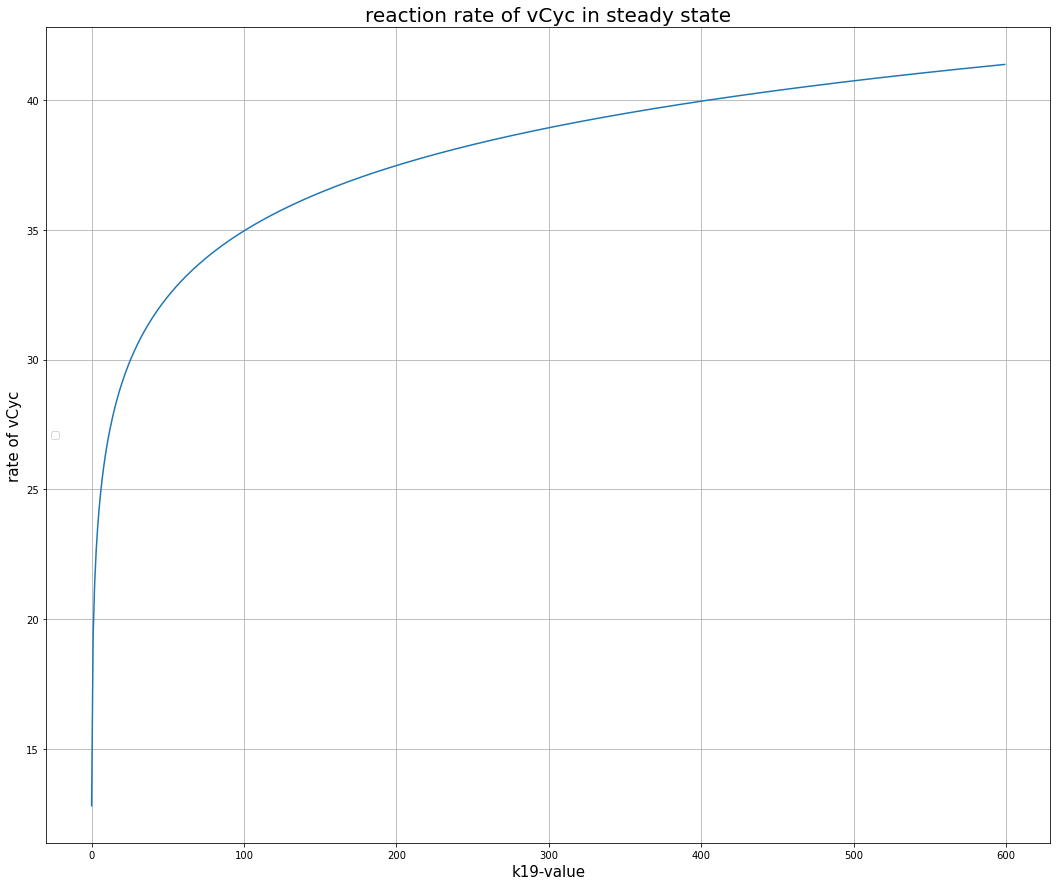

None


In [58]:
#(a) Cyclic electron flow
print(steady_rates_k('vCyc',klist))

No handles with labels found to put in legend.


[array([43.97449203]), array([41.08526583]), array([40.13169409]), array([39.52628791]), array([39.07880266]), array([38.72262673]), array([38.42626334]), array([38.17223158]), array([37.94978972]), array([37.7518514]), array([37.57348955]), array([37.41113657]), array([37.26212435]), array([37.12440456]), array([36.9963695]), array([36.87673368]), array([36.76445331]), array([36.65866825]), array([36.5586622]), array([36.46383121]), array([36.37366219]), array([36.2877148]), array([36.20560856]), array([36.12701248]), array([36.05163683]), array([35.97922634]), array([35.9095551]), array([35.84242224]), array([35.77764801]), array([35.71507158]), array([35.65454789]), array([35.59594546]), array([35.539146]), array([35.48404084]), array([35.43053148]), array([35.37852751]), array([35.32794664]), array([35.27871207]), array([35.23075376]), array([35.18400704]), array([35.13841217]), array([35.09391324]), array([35.05045841]), array([35.00799985]), array([34.96649267]), array([34.925894

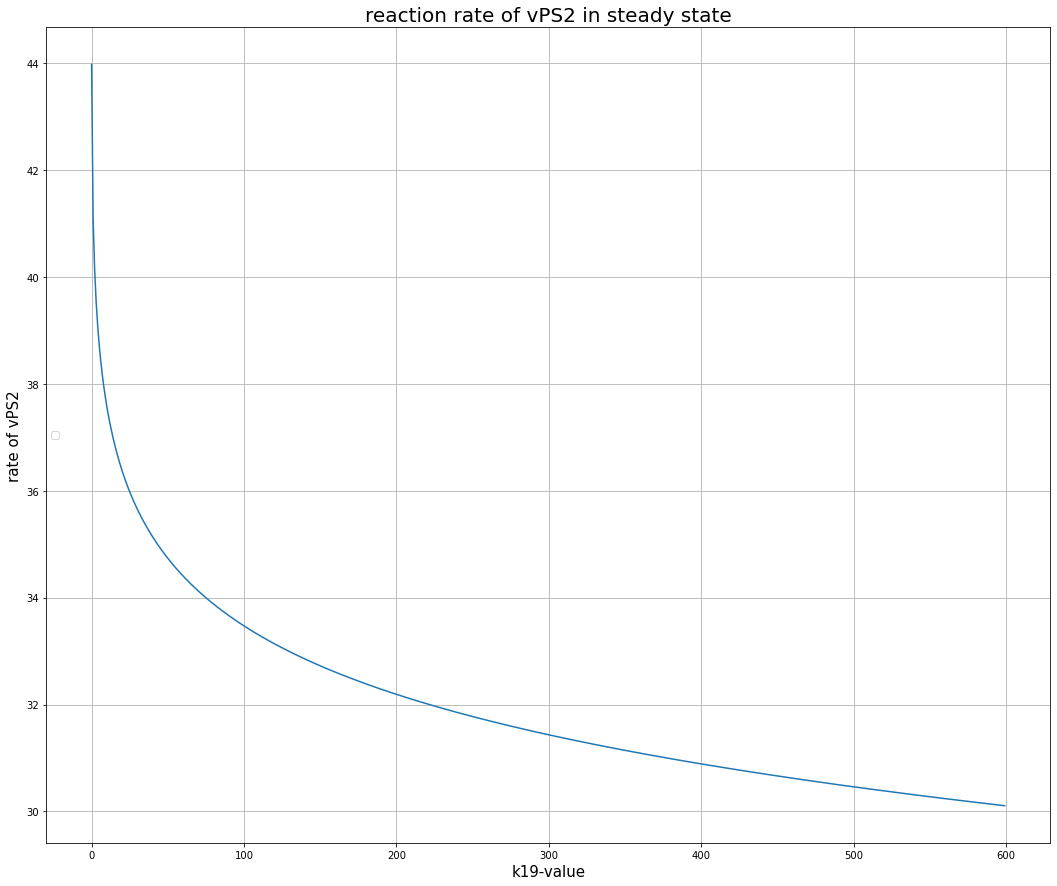

None


In [59]:
#(b) Electron flow through PSII
limly=30
limy=44
limlx=0
limx=600

print(steady_rates_k('vPS2', klist))